In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "q",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "ttr",
    "u",
    "v",
    "vo",
    "w",
]
plevel_list = [
    False,
    False,
    300,
    False,
    False,
    False,
    300,
    300,
    300,
    False,
    False,
    False,
    300,
    False,
    300,
    300,
    300,
    300,
]
aew_subset = "24hr_before"
model_save_name = "best_model24_3001.keras"
tuner_project_name = "tuner_run24_3001"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-10 02:27:05.710140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 02:27:05.720186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752136025.730569   82714 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752136025.734017   82714 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752136025.748395   82714 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="24hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset="24hr_before",
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr_24hr"
)






Loading cape from Zarr store.
Loading crr from Zarr store.
Loading d_300 from Zarr store.
Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_300 from Zarr store.


Loading q_300 from Zarr store.
Loading r_300 from Zarr store.
Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_300 from Zarr store.
Loading ttr from Zarr store.
Loading u_300 from Zarr store.
Loading v_300 from Zarr store.
Loading vo_300 from Zarr store.
Loading w_300 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2444, 32, 32, 18)


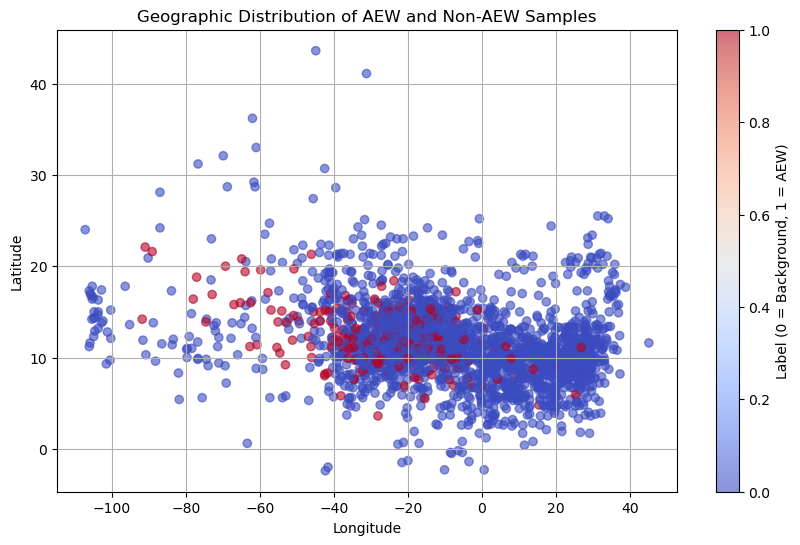

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'q', 'r', 'sp', 'tcw', 'tcwv', 't', 'ttr', 'u', 'v', 'vo', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






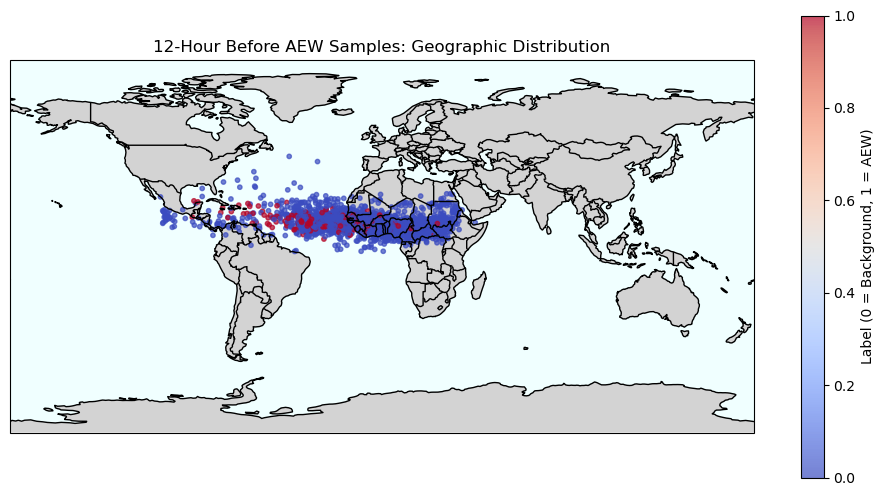

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2444


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -2.4 to 43.6
Longitude Range: -107.2 to 45.1


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(1955, 32, 32, 18) (489, 32, 32, 18) (1955,) (489,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 364 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 94 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(1955, 32, 32, 18) (1955, 1) (489, 32, 32, 18) (489, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 201 (10.28% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.10281329923273658, 1: 0.8971867007672634}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-10 02:28:46.065743: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2444
AEW-positive samples (label=1): 253
Background samples (label=0): 2191


In [35]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 01m 12s]
val_f1_score: 0.5306121706962585

Best val_f1_score So Far: 0.6086956262588501
Total elapsed time: 03h 06m 38s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 32, 32, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 32, 32, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 29)          │           4,727 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 29)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 29)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 45)          │          11,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 45)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 45)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 90)            │          36,540 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 90)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 90)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 90)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 39)                  │           3,549 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              40 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,646 (221.27 KB)

 Trainable params: 56,646 (221.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - auc: 0.7725 - binary_accuracy: 0.7456 - cross entropy: 0.5499 - f1_score: 0.3830 - fn: 7.0000 - fp: 51.0000 - loss: 0.0200 - mean_squared_error: 0.1745 - prc: 0.3940 - precision: 0.2609 - recall: 0.7200 - root_mean_squared_error: 0.4177 - tn: 152.0000 - tp: 18.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7590 - binary_accuracy: 0.7608 - cross entropy: 0.5093 - f1_score: 0.3622 - fn: 13.0000 - fp: 60.8333 - loss: 0.0260 - mean_squared_error: 0.1624 - prc: 0.3618 - precision: 0.2560 - recall: 0.6221 - root_mean_squared_error: 0.4029 - tn: 213.3333 - tp: 20.8333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7541 - binary_accuracy: 0.7597 - cross entropy: 0.5025 - f1_score: 0.3467 - fn: 18.8333 - fp: 78.0833 - loss: 0.0249 - mean_squared_error: 0.1615 - prc: 0.3442 - precision: 0.2467 - recall: 0.5861 - root_mean_squared_error: 0.4018 - tn: 281.8333 - tp: 25.2500

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7431 - binary_accuracy: 0.7565 - cross entropy: 0.5023 - f1_score: 0.3370 - fn: 24.6667 - fp: 97.7778 - loss: 0.0241 - mean_squared_error: 0.1624 - prc: 0.3276 - precision: 0.2404 - recall: 0.5656 - root_mean_squared_error: 0.4029 - tn: 347.2222 - tp: 30.3333

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7385 - binary_accuracy: 0.7576 - cross entropy: 0.5005 - f1_score: 0.3357 - fn: 30.2500 - fp: 114.2917 - loss: 0.0229 - mean_squared_error: 0.1620 - prc: 0.3176 - precision: 0.2408 - recall: 0.5561 - root_mean_squared_error: 0.4025 - tn: 415.6250 - tp: 35.8333

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7353 - binary_accuracy: 0.7608 - cross entropy: 0.4969 - f1_score: 0.3318 - fn: 35.8000 - fp: 128.6000 - loss: 0.0220 - mean_squared_error: 0.1607 - prc: 0.3089 - precision: 0.2393 - recall: 0.5435 - root_mean_squared_error: 0.4009 - tn: 487.6667 - tp: 39.9333

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7335 - binary_accuracy: 0.7641 - cross entropy: 0.4936 - f1_score: 0.3274 - fn: 40.6000 - fp: 138.9714 - loss: 0.0213 - mean_squared_error: 0.1594 - prc: 0.3023 - precision: 0.2371 - recall: 0.5311 - root_mean_squared_error: 0.3992 - tn: 549.8857 - tp: 42.5429

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7325 - binary_accuracy: 0.7670 - cross entropy: 0.4910 - f1_score: 0.3239 - fn: 45.6000 - fp: 149.0000 - loss: 0.0206 - mean_squared_error: 0.1584 - prc: 0.2968 - precision: 0.2358 - recall: 0.5201 - root_mean_squared_error: 0.3979 - tn: 612.1500 - tp: 45.2500

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7318 - binary_accuracy: 0.7694 - cross entropy: 0.4891 - f1_score: 0.3215 - fn: 50.5111 - fp: 159.4000 - loss: 0.0201 - mean_squared_error: 0.1577 - prc: 0.2921 - precision: 0.2350 - recall: 0.5118 - root_mean_squared_error: 0.3970 - tn: 673.8666 - tp: 48.2222

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.7315 - binary_accuracy: 0.7718 - cross entropy: 0.4872 - f1_score: 0.3193 - fn: 56.6863 - fp: 171.7843 - loss: 0.0195 - mean_squared_error: 0.1569 - prc: 0.2878 - precision: 0.2347 - recall: 0.5029 - root_mean_squared_error: 0.3960 - tn: 747.5883 - tp: 51.9412

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - auc: 0.7314 - binary_accuracy: 0.7735 - cross entropy: 0.4857 - f1_score: 0.3175 - fn: 61.6250 - fp: 182.2321 - loss: 0.0191 - mean_squared_error: 0.1563 - prc: 0.2846 - precision: 0.2341 - recall: 0.4967 - root_mean_squared_error: 0.3953 - tn: 808.5893 - tp: 54.9464 - val_auc: 0.8097 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4102 - val_f1_score: 0.0667 - val_fn: 19.0000 - val_fp: 9.0000 - val_loss: 0.0415 - val_mean_squared_error: 0.1235 - val_prc: 0.2854 - val_precision: 0.1000 - val_recall: 0.0500 - val_root_mean_squared_error: 0.3514 - val_tn: 167.0000 - val_tp: 1.0000


Epoch 2/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8259 - binary_accuracy: 0.8438 - cross entropy: 0.3743 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.0211 - mean_squared_error: 0.1142 - prc: 0.6293 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3379 - tn: 27.0000 - tp: 0.0000e+00

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8067 - binary_accuracy: 0.8215 - cross entropy: 0.4230 - f1_score: 0.3243 - fn: 6.1667 - fp: 14.6667 - loss: 0.0138 - mean_squared_error: 0.1313 - prc: 0.4132 - precision: 0.2644 - recall: 0.4345 - root_mean_squared_error: 0.3620 - tn: 83.5000 - tp: 7.6667                   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8136 - binary_accuracy: 0.8193 - cross entropy: 0.4295 - f1_score: 0.3717 - fn: 10.3333 - fp: 27.5833 - loss: 0.0126 - mean_squared_error: 0.1339 - prc: 0.3957 - precision: 0.2964 - recall: 0.5072 - root_mean_squared_error: 0.3657 - tn: 156.3333 - tp: 13.7500

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8127 - binary_accuracy: 0.8239 - cross entropy: 0.4288 - f1_score: 0.3886 - fn: 15.6111 - fp: 37.2778 - loss: 0.0124 - mean_squared_error: 0.1334 - prc: 0.3953 - precision: 0.3138 - recall: 0.5168 - root_mean_squared_error: 0.3651 - tn: 231.7222 - tp: 19.3889

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8125 - binary_accuracy: 0.8271 - cross entropy: 0.4324 - f1_score: 0.4048 - fn: 19.9583 - fp: 47.6667 - loss: 0.0122 - mean_squared_error: 0.1347 - prc: 0.4045 - precision: 0.3279 - recall: 0.5340 - root_mean_squared_error: 0.3668 - tn: 306.2500 - tp: 26.1250

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8098 - binary_accuracy: 0.8318 - cross entropy: 0.4336 - f1_score: 0.4097 - fn: 24.9333 - fp: 55.5000 - loss: 0.0121 - mean_squared_error: 0.1348 - prc: 0.4037 - precision: 0.3349 - recall: 0.5322 - root_mean_squared_error: 0.3671 - tn: 384.7667 - tp: 30.8000 

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8082 - binary_accuracy: 0.8361 - cross entropy: 0.4341 - f1_score: 0.4091 - fn: 30.2778 - fp: 62.1389 - loss: 0.0119 - mean_squared_error: 0.1347 - prc: 0.3983 - precision: 0.3379 - recall: 0.5231 - root_mean_squared_error: 0.3669 - tn: 465.2500 - tp: 34.3333

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8067 - binary_accuracy: 0.8383 - cross entropy: 0.4352 - f1_score: 0.4064 - fn: 36.0238 - fp: 70.0952 - loss: 0.0118 - mean_squared_error: 0.1350 - prc: 0.3923 - precision: 0.3381 - recall: 0.5141 - root_mean_squared_error: 0.3673 - tn: 543.8571 - tp: 38.0238

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8052 - binary_accuracy: 0.8393 - cross entropy: 0.4362 - f1_score: 0.4034 - fn: 40.9149 - fp: 77.2766 - loss: 0.0118 - mean_squared_error: 0.1352 - prc: 0.3869 - precision: 0.3369 - recall: 0.5072 - root_mean_squared_error: 0.3677 - tn: 608.7234 - tp: 41.0851

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8036 - binary_accuracy: 0.8395 - cross entropy: 0.4376 - f1_score: 0.4004 - fn: 46.6415 - fp: 87.2076 - loss: 0.0117 - mean_squared_error: 0.1357 - prc: 0.3805 - precision: 0.3350 - recall: 0.5017 - root_mean_squared_error: 0.3683 - tn: 684.9434 - tp: 45.2075

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8028 - binary_accuracy: 0.8396 - cross entropy: 0.4380 - f1_score: 0.3984 - fn: 49.5536 - fp: 91.9643 - loss: 0.0117 - mean_squared_error: 0.1358 - prc: 0.3773 - precision: 0.3337 - recall: 0.4984 - root_mean_squared_error: 0.3685 - tn: 722.8571 - tp: 47.0179 - val_auc: 0.8247 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3934 - val_f1_score: 0.0833 - val_fn: 19.0000 - val_fp: 3.0000 - val_loss: 0.0362 - val_mean_squared_error: 0.1159 - val_prc: 0.3312 - val_precision: 0.2500 - val_recall: 0.0500 - val_root_mean_squared_error: 0.3405 - val_tn: 173.0000 - val_tp: 1.0000


Epoch 3/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8889 - binary_accuracy: 0.8438 - cross entropy: 0.3492 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.0188 - mean_squared_error: 0.1028 - prc: 0.8461 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3206 - tn: 27.0000 - tp: 0.0000e+00

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8529 - binary_accuracy: 0.8439 - cross entropy: 0.3947 - f1_score: 0.3105 - fn: 7.0000 - fp: 11.0000 - loss: 0.0123 - mean_squared_error: 0.1185 - prc: 0.5220 - precision: 0.2764 - recall: 0.3703 - root_mean_squared_error: 0.3439 - tn: 87.1667 - tp: 6.8333                   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8499 - binary_accuracy: 0.8390 - cross entropy: 0.4087 - f1_score: 0.3702 - fn: 10.0909 - fp: 21.3636 - loss: 0.0115 - mean_squared_error: 0.1245 - prc: 0.4630 - precision: 0.3136 - recall: 0.4642 - root_mean_squared_error: 0.3526 - tn: 148.1818 - tp: 12.3636

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8407 - binary_accuracy: 0.8403 - cross entropy: 0.4113 - f1_score: 0.3913 - fn: 15.2353 - fp: 30.8824 - loss: 0.0115 - mean_squared_error: 0.1257 - prc: 0.4336 - precision: 0.3308 - recall: 0.4874 - root_mean_squared_error: 0.3544 - tn: 224.1765 - tp: 17.7059

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8335 - binary_accuracy: 0.8353 - cross entropy: 0.4195 - f1_score: 0.3997 - fn: 20.0000 - fp: 44.6522 - loss: 0.0116 - mean_squared_error: 0.1292 - prc: 0.4231 - precision: 0.3332 - recall: 0.5069 - root_mean_squared_error: 0.3592 - tn: 295.0435 - tp: 24.3043

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8255 - binary_accuracy: 0.8357 - cross entropy: 0.4225 - f1_score: 0.3996 - fn: 25.4483 - fp: 54.3793 - loss: 0.0116 - mean_squared_error: 0.1303 - prc: 0.4112 - precision: 0.3332 - recall: 0.5050 - root_mean_squared_error: 0.3607 - tn: 371.4138 - tp: 28.7586

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8206 - binary_accuracy: 0.8374 - cross entropy: 0.4247 - f1_score: 0.3965 - fn: 30.8571 - fp: 62.7714 - loss: 0.0116 - mean_squared_error: 0.1309 - prc: 0.4000 - precision: 0.3315 - recall: 0.4981 - root_mean_squared_error: 0.3617 - tn: 450.0857 - tp: 32.2857 

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8173 - binary_accuracy: 0.8390 - cross entropy: 0.4265 - f1_score: 0.3927 - fn: 37.6190 - fp: 72.3333 - loss: 0.0115 - mean_squared_error: 0.1315 - prc: 0.3902 - precision: 0.3301 - recall: 0.4891 - root_mean_squared_error: 0.3625 - tn: 541.6190 - tp: 36.4286

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8149 - binary_accuracy: 0.8395 - cross entropy: 0.4282 - f1_score: 0.3906 - fn: 43.2083 - fp: 81.5208 - loss: 0.0115 - mean_squared_error: 0.1321 - prc: 0.3832 - precision: 0.3289 - recall: 0.4849 - root_mean_squared_error: 0.3633 - tn: 618.7917 - tp: 40.4792

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8131 - binary_accuracy: 0.8396 - cross entropy: 0.4296 - f1_score: 0.3879 - fn: 49.8182 - fp: 92.8182 - loss: 0.0115 - mean_squared_error: 0.1326 - prc: 0.3768 - precision: 0.3270 - recall: 0.4804 - root_mean_squared_error: 0.3640 - tn: 708.1273 - tp: 45.2182

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8129 - binary_accuracy: 0.8396 - cross entropy: 0.4298 - f1_score: 0.3875 - fn: 50.7143 - fp: 94.3750 - loss: 0.0114 - mean_squared_error: 0.1327 - prc: 0.3760 - precision: 0.3267 - recall: 0.4798 - root_mean_squared_error: 0.3641 - tn: 720.4464 - tp: 45.8571 - val_auc: 0.8500 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.4013 - val_f1_score: 0.4762 - val_fn: 10.0000 - val_fp: 12.0000 - val_loss: 0.0435 - val_mean_squared_error: 0.1210 - val_prc: 0.4203 - val_precision: 0.4545 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3478 - val_tn: 164.0000 - val_tp: 10.0000


Epoch 4/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8519 - binary_accuracy: 0.8750 - cross entropy: 0.3526 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0174 - mean_squared_error: 0.1052 - prc: 0.7222 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3243 - tn: 27.0000 - tp: 1.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8796 - binary_accuracy: 0.8883 - cross entropy: 0.3582 - f1_score: 0.5051 - fn: 7.5714 - fp: 6.7143 - loss: 0.0109 - mean_squared_error: 0.1049 - prc: 0.6034 - precision: 0.6106 - recall: 0.4796 - root_mean_squared_error: 0.3237 - tn: 105.2857 - tp: 8.4286    

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8686 - binary_accuracy: 0.8766 - cross entropy: 0.3729 - f1_score: 0.4866 - fn: 12.5714 - fp: 18.6429 - loss: 0.0105 - mean_squared_error: 0.1113 - prc: 0.5018 - precision: 0.5127 - recall: 0.5104 - root_mean_squared_error: 0.3334 - tn: 194.0714 - tp: 14.7143

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8574 - binary_accuracy: 0.8704 - cross entropy: 0.3855 - f1_score: 0.4862 - fn: 18.0000 - fp: 30.0476 - loss: 0.0108 - mean_squared_error: 0.1164 - prc: 0.4742 - precision: 0.4827 - recall: 0.5304 - root_mean_squared_error: 0.3409 - tn: 281.1905 - tp: 22.7619

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8504 - binary_accuracy: 0.8681 - cross entropy: 0.3928 - f1_score: 0.4820 - fn: 22.0385 - fp: 37.6538 - loss: 0.0109 - mean_squared_error: 0.1193 - prc: 0.4586 - precision: 0.4674 - recall: 0.5338 - root_mean_squared_error: 0.3451 - tn: 344.8846 - tp: 27.4231

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8443 - binary_accuracy: 0.8681 - cross entropy: 0.3976 - f1_score: 0.4752 - fn: 27.0312 - fp: 44.7812 - loss: 0.0109 - mean_squared_error: 0.1210 - prc: 0.4422 - precision: 0.4544 - recall: 0.5287 - root_mean_squared_error: 0.3475 - tn: 424.5312 - tp: 31.6562

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8419 - binary_accuracy: 0.8691 - cross entropy: 0.4001 - f1_score: 0.4715 - fn: 31.0811 - fp: 49.8919 - loss: 0.0108 - mean_squared_error: 0.1218 - prc: 0.4320 - precision: 0.4479 - recall: 0.5246 - root_mean_squared_error: 0.3487 - tn: 492.0000 - tp: 35.0270

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8393 - binary_accuracy: 0.8694 - cross entropy: 0.4032 - f1_score: 0.4675 - fn: 36.2093 - fp: 56.7442 - loss: 0.0108 - mean_squared_error: 0.1228 - prc: 0.4219 - precision: 0.4415 - recall: 0.5203 - root_mean_squared_error: 0.3502 - tn: 571.6512 - tp: 39.3953

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8365 - binary_accuracy: 0.8692 - cross entropy: 0.4066 - f1_score: 0.4626 - fn: 42.5000 - fp: 65.3200 - loss: 0.0107 - mean_squared_error: 0.1240 - prc: 0.4123 - precision: 0.4345 - recall: 0.5152 - root_mean_squared_error: 0.3519 - tn: 663.6800 - tp: 44.5000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8348 - binary_accuracy: 0.8689 - cross entropy: 0.4090 - f1_score: 0.4585 - fn: 47.8214 - fp: 72.8750 - loss: 0.0107 - mean_squared_error: 0.1249 - prc: 0.4057 - precision: 0.4289 - recall: 0.5111 - root_mean_squared_error: 0.3531 - tn: 741.9464 - tp: 48.7500 - val_auc: 0.8426 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.4110 - val_f1_score: 0.4000 - val_fn: 12.0000 - val_fp: 12.0000 - val_loss: 0.0431 - val_mean_squared_error: 0.1237 - val_prc: 0.3576 - val_precision: 0.4000 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3516 - val_tn: 164.0000 - val_tp: 8.0000


Epoch 5/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8519 - binary_accuracy: 0.8750 - cross entropy: 0.3515 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0160 - mean_squared_error: 0.1033 - prc: 0.7139 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3214 - tn: 27.0000 - tp: 1.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8875 - binary_accuracy: 0.9048 - cross entropy: 0.3698 - f1_score: 0.5683 - fn: 6.1429 - fp: 5.7143 - loss: 0.0102 - mean_squared_error: 0.1078 - prc: 0.6234 - precision: 0.6891 - recall: 0.5364 - root_mean_squared_error: 0.3282 - tn: 106.2857 - tp: 9.8571    

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8844 - binary_accuracy: 0.8976 - cross entropy: 0.3779 - f1_score: 0.5692 - fn: 9.0769 - fp: 14.5385 - loss: 0.0098 - mean_squared_error: 0.1116 - prc: 0.5474 - precision: 0.6017 - recall: 0.5955 - root_mean_squared_error: 0.3339 - tn: 183.6923 - tp: 16.6923

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8744 - binary_accuracy: 0.8895 - cross entropy: 0.3860 - f1_score: 0.5595 - fn: 13.8000 - fp: 25.5000 - loss: 0.0100 - mean_squared_error: 0.1151 - prc: 0.5250 - precision: 0.5554 - recall: 0.6112 - root_mean_squared_error: 0.3391 - tn: 271.5500 - tp: 25.1500

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8676 - binary_accuracy: 0.8858 - cross entropy: 0.3927 - f1_score: 0.5526 - fn: 18.3704 - fp: 35.5185 - loss: 0.0101 - mean_squared_error: 0.1179 - prc: 0.5139 - precision: 0.5304 - recall: 0.6177 - root_mean_squared_error: 0.3431 - tn: 361.3704 - tp: 32.7407

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8623 - binary_accuracy: 0.8857 - cross entropy: 0.3962 - f1_score: 0.5443 - fn: 23.4118 - fp: 42.8235 - loss: 0.0101 - mean_squared_error: 0.1191 - prc: 0.5006 - precision: 0.5152 - recall: 0.6105 - root_mean_squared_error: 0.3449 - tn: 455.4706 - tp: 38.2941

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8595 - binary_accuracy: 0.8859 - cross entropy: 0.3982 - f1_score: 0.5390 - fn: 27.2308 - fp: 47.5641 - loss: 0.0101 - mean_squared_error: 0.1197 - prc: 0.4919 - precision: 0.5079 - recall: 0.6039 - root_mean_squared_error: 0.3458 - tn: 523.1795 - tp: 42.0256

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8570 - binary_accuracy: 0.8852 - cross entropy: 0.4008 - f1_score: 0.5335 - fn: 31.0455 - fp: 53.7045 - loss: 0.0101 - mean_squared_error: 0.1207 - prc: 0.4825 - precision: 0.4995 - recall: 0.5991 - root_mean_squared_error: 0.3472 - tn: 589.1364 - tp: 46.1136

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8548 - binary_accuracy: 0.8844 - cross entropy: 0.4026 - f1_score: 0.5280 - fn: 35.2653 - fp: 59.6531 - loss: 0.0101 - mean_squared_error: 0.1213 - prc: 0.4749 - precision: 0.4926 - recall: 0.5931 - root_mean_squared_error: 0.3482 - tn: 655.0000 - tp: 50.0816

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8527 - binary_accuracy: 0.8830 - cross entropy: 0.4047 - f1_score: 0.5215 - fn: 40.0727 - fp: 68.0182 - loss: 0.0101 - mean_squared_error: 0.1221 - prc: 0.4659 - precision: 0.4837 - recall: 0.5878 - root_mean_squared_error: 0.3493 - tn: 732.9272 - tp: 54.9636

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8524 - binary_accuracy: 0.8828 - cross entropy: 0.4050 - f1_score: 0.5204 - fn: 40.8393 - fp: 69.3571 - loss: 0.0101 - mean_squared_error: 0.1222 - prc: 0.4645 - precision: 0.4823 - recall: 0.5870 - root_mean_squared_error: 0.3495 - tn: 745.4643 - tp: 55.7321 - val_auc: 0.8575 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.4036 - val_f1_score: 0.4151 - val_fn: 9.0000 - val_fp: 22.0000 - val_loss: 0.0474 - val_mean_squared_error: 0.1220 - val_prc: 0.4572 - val_precision: 0.3333 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3493 - val_tn: 154.0000 - val_tp: 11.0000


Epoch 6/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8593 - binary_accuracy: 0.8438 - cross entropy: 0.3499 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.0194 - mean_squared_error: 0.1045 - prc: 0.7188 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3232 - tn: 27.0000 - tp: 0.0000e+00

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8529 - binary_accuracy: 0.8660 - cross entropy: 0.3818 - f1_score: 0.4159 - fn: 7.7143 - fp: 9.2857 - loss: 0.0119 - mean_squared_error: 0.1137 - prc: 0.4505 - precision: 0.3975 - recall: 0.4395 - root_mean_squared_error: 0.3370 - tn: 102.7143 - tp: 8.2857                    

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8580 - binary_accuracy: 0.8634 - cross entropy: 0.3889 - f1_score: 0.4440 - fn: 12.2143 - fp: 20.7857 - loss: 0.0108 - mean_squared_error: 0.1164 - prc: 0.4258 - precision: 0.4009 - recall: 0.5034 - root_mean_squared_error: 0.3411 - tn: 191.9286 - tp: 15.0714

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8539 - binary_accuracy: 0.8591 - cross entropy: 0.3973 - f1_score: 0.4576 - fn: 17.0952 - fp: 33.6667 - loss: 0.0107 - mean_squared_error: 0.1199 - prc: 0.4231 - precision: 0.4031 - recall: 0.5356 - root_mean_squared_error: 0.3461 - tn: 277.5714 - tp: 23.6667

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8474 - binary_accuracy: 0.8577 - cross entropy: 0.4032 - f1_score: 0.4583 - fn: 22.4643 - fp: 44.8929 - loss: 0.0108 - mean_squared_error: 0.1223 - prc: 0.4164 - precision: 0.3994 - recall: 0.5430 - root_mean_squared_error: 0.3495 - tn: 366.4286 - tp: 30.2143

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8432 - binary_accuracy: 0.8574 - cross entropy: 0.4060 - f1_score: 0.4526 - fn: 27.8857 - fp: 55.4286 - loss: 0.0107 - mean_squared_error: 0.1232 - prc: 0.4086 - precision: 0.3920 - recall: 0.5401 - root_mean_squared_error: 0.3509 - tn: 457.4286 - tp: 35.2571

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8411 - binary_accuracy: 0.8579 - cross entropy: 0.4078 - f1_score: 0.4498 - fn: 33.4524 - fp: 65.0000 - loss: 0.0106 - mean_squared_error: 0.1238 - prc: 0.4028 - precision: 0.3889 - recall: 0.5372 - root_mean_squared_error: 0.3517 - tn: 548.9524 - tp: 40.5952

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8398 - binary_accuracy: 0.8581 - cross entropy: 0.4094 - f1_score: 0.4483 - fn: 39.0000 - fp: 74.8980 - loss: 0.0106 - mean_squared_error: 0.1243 - prc: 0.3993 - precision: 0.3870 - recall: 0.5360 - root_mean_squared_error: 0.3525 - tn: 639.7551 - tp: 46.3469

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.8391 - binary_accuracy: 0.8582 - cross entropy: 0.4105 - f1_score: 0.4467 - fn: 44.5179 - fp: 84.9643 - loss: 0.0105 - mean_squared_error: 0.1248 - prc: 0.3969 - precision: 0.3851 - recall: 0.5346 - root_mean_squared_error: 0.3531 - tn: 729.8571 - tp: 52.0536 - val_auc: 0.8588 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4051 - val_f1_score: 0.4615 - val_fn: 8.0000 - val_fp: 20.0000 - val_loss: 0.0495 - val_mean_squared_error: 0.1233 - val_prc: 0.4693 - val_precision: 0.3750 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3511 - val_tn: 156.0000 - val_tp: 12.0000


Epoch 7/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9000 - binary_accuracy: 0.9375 - cross entropy: 0.3290 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0126 - mean_squared_error: 0.0957 - prc: 0.7514 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3094 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8999 - binary_accuracy: 0.9195 - cross entropy: 0.3576 - f1_score: 0.6867 - fn: 4.1667 - fp: 5.5000 - loss: 0.0093 - mean_squared_error: 0.1045 - prc: 0.5842 - precision: 0.6950 - recall: 0.7002 - root_mean_squared_error: 0.3231 - tn: 92.6667 - tp: 9.6667    

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8965 - binary_accuracy: 0.9012 - cross entropy: 0.3662 - f1_score: 0.6143 - fn: 8.7500 - fp: 14.0833 - loss: 0.0090 - mean_squared_error: 0.1081 - prc: 0.5415 - precision: 0.5930 - recall: 0.6546 - root_mean_squared_error: 0.3287 - tn: 169.8333 - tp: 15.3333

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8854 - binary_accuracy: 0.8895 - cross entropy: 0.3741 - f1_score: 0.5791 - fn: 13.2222 - fp: 24.1111 - loss: 0.0093 - mean_squared_error: 0.1115 - prc: 0.5198 - precision: 0.5411 - recall: 0.6394 - root_mean_squared_error: 0.3338 - tn: 244.8889 - tp: 21.7778

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8778 - binary_accuracy: 0.8839 - cross entropy: 0.3827 - f1_score: 0.5635 - fn: 18.0800 - fp: 34.4400 - loss: 0.0095 - mean_squared_error: 0.1149 - prc: 0.5113 - precision: 0.5160 - recall: 0.6347 - root_mean_squared_error: 0.3388 - tn: 333.7600 - tp: 29.7200

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8724 - binary_accuracy: 0.8829 - cross entropy: 0.3862 - f1_score: 0.5512 - fn: 22.5484 - fp: 41.2258 - loss: 0.0095 - mean_squared_error: 0.1161 - prc: 0.5013 - precision: 0.5019 - recall: 0.6228 - root_mean_squared_error: 0.3406 - tn: 413.5484 - tp: 34.6774

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8694 - binary_accuracy: 0.8830 - cross entropy: 0.3884 - f1_score: 0.5414 - fn: 27.0000 - fp: 47.2703 - loss: 0.0095 - mean_squared_error: 0.1168 - prc: 0.4926 - precision: 0.4921 - recall: 0.6116 - root_mean_squared_error: 0.3415 - tn: 494.6216 - tp: 39.1081

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8665 - binary_accuracy: 0.8825 - cross entropy: 0.3913 - f1_score: 0.5331 - fn: 32.2955 - fp: 55.2045 - loss: 0.0095 - mean_squared_error: 0.1177 - prc: 0.4810 - precision: 0.4833 - recall: 0.6026 - root_mean_squared_error: 0.3430 - tn: 587.6364 - tp: 44.8636

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8647 - binary_accuracy: 0.8822 - cross entropy: 0.3934 - f1_score: 0.5273 - fn: 37.7059 - fp: 63.0784 - loss: 0.0095 - mean_squared_error: 0.1184 - prc: 0.4735 - precision: 0.4775 - recall: 0.5959 - root_mean_squared_error: 0.3440 - tn: 680.2941 - tp: 50.9216

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8634 - binary_accuracy: 0.8819 - cross entropy: 0.3948 - f1_score: 0.5231 - fn: 41.5893 - fp: 68.8393 - loss: 0.0096 - mean_squared_error: 0.1189 - prc: 0.4688 - precision: 0.4733 - recall: 0.5911 - root_mean_squared_error: 0.3446 - tn: 745.9821 - tp: 54.9821 - val_auc: 0.8324 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3991 - val_f1_score: 0.4500 - val_fn: 11.0000 - val_fp: 11.0000 - val_loss: 0.0406 - val_mean_squared_error: 0.1179 - val_prc: 0.4417 - val_precision: 0.4500 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3434 - val_tn: 165.0000 - val_tp: 9.0000


Epoch 8/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9407 - binary_accuracy: 0.8438 - cross entropy: 0.3754 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.0125 - mean_squared_error: 0.1097 - prc: 0.8000 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3313 - tn: 27.0000 - tp: 0.0000e+00

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9057 - binary_accuracy: 0.8722 - cross entropy: 0.4096 - f1_score: 0.3930 - fn: 7.0000 - fp: 6.5000 - loss: 0.0097 - mean_squared_error: 0.1221 - prc: 0.5321 - precision: 0.3923 - recall: 0.3970 - root_mean_squared_error: 0.3493 - tn: 91.6667 - tp: 6.8333                    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9037 - binary_accuracy: 0.8737 - cross entropy: 0.4110 - f1_score: 0.4394 - fn: 10.7273 - fp: 12.9091 - loss: 0.0093 - mean_squared_error: 0.1226 - prc: 0.4957 - precision: 0.4240 - recall: 0.4595 - root_mean_squared_error: 0.3501 - tn: 156.6364 - tp: 11.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8916 - binary_accuracy: 0.8721 - cross entropy: 0.4123 - f1_score: 0.4503 - fn: 14.6250 - fp: 20.0000 - loss: 0.0094 - mean_squared_error: 0.1233 - prc: 0.4671 - precision: 0.4248 - recall: 0.4826 - root_mean_squared_error: 0.3511 - tn: 221.0000 - tp: 16.3750

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8848 - binary_accuracy: 0.8712 - cross entropy: 0.4150 - f1_score: 0.4667 - fn: 17.9524 - fp: 27.5238 - loss: 0.0095 - mean_squared_error: 0.1246 - prc: 0.4711 - precision: 0.4327 - recall: 0.5109 - root_mean_squared_error: 0.3529 - tn: 283.7143 - tp: 22.8095

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8789 - binary_accuracy: 0.8713 - cross entropy: 0.4151 - f1_score: 0.4746 - fn: 22.1111 - fp: 35.5926 - loss: 0.0096 - mean_squared_error: 0.1247 - prc: 0.4726 - precision: 0.4349 - recall: 0.5264 - root_mean_squared_error: 0.3530 - tn: 361.2963 - tp: 29.0000

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8743 - binary_accuracy: 0.8720 - cross entropy: 0.4140 - f1_score: 0.4760 - fn: 26.1818 - fp: 43.1515 - loss: 0.0096 - mean_squared_error: 0.1242 - prc: 0.4691 - precision: 0.4328 - recall: 0.5325 - root_mean_squared_error: 0.3524 - tn: 440.6364 - tp: 34.0303

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8714 - binary_accuracy: 0.8731 - cross entropy: 0.4128 - f1_score: 0.4771 - fn: 30.3077 - fp: 50.1282 - loss: 0.0095 - mean_squared_error: 0.1237 - prc: 0.4654 - precision: 0.4319 - recall: 0.5360 - root_mean_squared_error: 0.3517 - tn: 520.6154 - tp: 38.9487

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8677 - binary_accuracy: 0.8728 - cross entropy: 0.4129 - f1_score: 0.4769 - fn: 35.1087 - fp: 60.0217 - loss: 0.0096 - mean_squared_error: 0.1239 - prc: 0.4576 - precision: 0.4288 - recall: 0.5405 - root_mean_squared_error: 0.3520 - tn: 611.6087 - tp: 45.2609 

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8654 - binary_accuracy: 0.8724 - cross entropy: 0.4128 - f1_score: 0.4761 - fn: 39.6538 - fp: 68.3654 - loss: 0.0096 - mean_squared_error: 0.1240 - prc: 0.4526 - precision: 0.4266 - recall: 0.5418 - root_mean_squared_error: 0.3520 - tn: 689.3654 - tp: 50.6154

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8641 - binary_accuracy: 0.8721 - cross entropy: 0.4128 - f1_score: 0.4746 - fn: 42.6964 - fp: 74.0536 - loss: 0.0096 - mean_squared_error: 0.1240 - prc: 0.4492 - precision: 0.4242 - recall: 0.5416 - root_mean_squared_error: 0.3521 - tn: 740.7679 - tp: 53.8750 - val_auc: 0.8193 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.4316 - val_f1_score: 0.3929 - val_fn: 9.0000 - val_fp: 25.0000 - val_loss: 0.0608 - val_mean_squared_error: 0.1358 - val_prc: 0.3272 - val_precision: 0.3056 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3685 - val_tn: 151.0000 - val_tp: 11.0000


Epoch 9/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8407 - binary_accuracy: 0.9062 - cross entropy: 0.3634 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0146 - mean_squared_error: 0.1083 - prc: 0.7088 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3292 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8685 - binary_accuracy: 0.9021 - cross entropy: 0.3884 - f1_score: 0.6127 - fn: 4.6667 - fp: 6.5000 - loss: 0.0103 - mean_squared_error: 0.1162 - prc: 0.4882 - precision: 0.6457 - recall: 0.6298 - root_mean_squared_error: 0.3408 - tn: 91.6667 - tp: 9.1667    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8785 - binary_accuracy: 0.8900 - cross entropy: 0.3924 - f1_score: 0.5648 - fn: 9.0909 - fp: 13.2727 - loss: 0.0097 - mean_squared_error: 0.1177 - prc: 0.4739 - precision: 0.5632 - recall: 0.5983 - root_mean_squared_error: 0.3430 - tn: 156.2727 - tp: 13.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8727 - binary_accuracy: 0.8815 - cross entropy: 0.3970 - f1_score: 0.5348 - fn: 13.3125 - fp: 21.3125 - loss: 0.0097 - mean_squared_error: 0.1197 - prc: 0.4534 - precision: 0.5156 - recall: 0.5818 - root_mean_squared_error: 0.3459 - tn: 219.6875 - tp: 17.6875

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8705 - binary_accuracy: 0.8774 - cross entropy: 0.4023 - f1_score: 0.5303 - fn: 16.8095 - fp: 29.1429 - loss: 0.0098 - mean_squared_error: 0.1219 - prc: 0.4663 - precision: 0.4993 - recall: 0.5884 - root_mean_squared_error: 0.3490 - tn: 282.0952 - tp: 23.9524

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8664 - binary_accuracy: 0.8764 - cross entropy: 0.4053 - f1_score: 0.5256 - fn: 21.0000 - fp: 36.9259 - loss: 0.0098 - mean_squared_error: 0.1230 - prc: 0.4714 - precision: 0.4875 - recall: 0.5893 - root_mean_squared_error: 0.3507 - tn: 359.9630 - tp: 30.1111

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8636 - binary_accuracy: 0.8764 - cross entropy: 0.4064 - f1_score: 0.5203 - fn: 24.3125 - fp: 43.0625 - loss: 0.0098 - mean_squared_error: 0.1234 - prc: 0.4675 - precision: 0.4785 - recall: 0.5872 - root_mean_squared_error: 0.3512 - tn: 426.2500 - tp: 34.3750

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8622 - binary_accuracy: 0.8772 - cross entropy: 0.4059 - f1_score: 0.5166 - fn: 27.7297 - fp: 48.3514 - loss: 0.0098 - mean_squared_error: 0.1231 - prc: 0.4639 - precision: 0.4730 - recall: 0.5840 - root_mean_squared_error: 0.3508 - tn: 493.5405 - tp: 38.3784

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8607 - binary_accuracy: 0.8773 - cross entropy: 0.4061 - f1_score: 0.5129 - fn: 31.9767 - fp: 55.5581 - loss: 0.0097 - mean_squared_error: 0.1231 - prc: 0.4596 - precision: 0.4673 - recall: 0.5815 - root_mean_squared_error: 0.3508 - tn: 572.8372 - tp: 43.6279

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8593 - binary_accuracy: 0.8772 - cross entropy: 0.4064 - f1_score: 0.5094 - fn: 36.4694 - fp: 62.8571 - loss: 0.0097 - mean_squared_error: 0.1232 - prc: 0.4560 - precision: 0.4626 - recall: 0.5786 - root_mean_squared_error: 0.3509 - tn: 651.7959 - tp: 48.8776

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8579 - binary_accuracy: 0.8767 - cross entropy: 0.4069 - f1_score: 0.5058 - fn: 40.9091 - fp: 70.8727 - loss: 0.0097 - mean_squared_error: 0.1234 - prc: 0.4515 - precision: 0.4575 - recall: 0.5762 - root_mean_squared_error: 0.3512 - tn: 730.0728 - tp: 54.1273

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8576 - binary_accuracy: 0.8767 - cross entropy: 0.4070 - f1_score: 0.5051 - fn: 41.6429 - fp: 72.1607 - loss: 0.0097 - mean_squared_error: 0.1234 - prc: 0.4507 - precision: 0.4566 - recall: 0.5757 - root_mean_squared_error: 0.3512 - tn: 742.6607 - tp: 54.9286 - val_auc: 0.8491 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.4249 - val_f1_score: 0.4231 - val_fn: 9.0000 - val_fp: 21.0000 - val_loss: 0.0525 - val_mean_squared_error: 0.1309 - val_prc: 0.3496 - val_precision: 0.3438 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3617 - val_tn: 155.0000 - val_tp: 11.0000


Epoch 10/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8852 - binary_accuracy: 0.8750 - cross entropy: 0.3483 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0150 - mean_squared_error: 0.1010 - prc: 0.7454 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3178 - tn: 27.0000 - tp: 1.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8833 - binary_accuracy: 0.9029 - cross entropy: 0.3830 - f1_score: 0.5809 - fn: 4.5000 - fp: 5.8333 - loss: 0.0101 - mean_squared_error: 0.1120 - prc: 0.5786 - precision: 0.6684 - recall: 0.5897 - root_mean_squared_error: 0.3346 - tn: 92.3333 - tp: 9.3333    

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8883 - binary_accuracy: 0.8996 - cross entropy: 0.3920 - f1_score: 0.5927 - fn: 7.4167 - fp: 13.5833 - loss: 0.0094 - mean_squared_error: 0.1157 - prc: 0.5451 - precision: 0.6011 - recall: 0.6440 - root_mean_squared_error: 0.3400 - tn: 170.3333 - tp: 16.6667

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8814 - binary_accuracy: 0.8950 - cross entropy: 0.3949 - f1_score: 0.5825 - fn: 10.8235 - fp: 20.4118 - loss: 0.0095 - mean_squared_error: 0.1171 - prc: 0.5150 - precision: 0.5680 - recall: 0.6461 - root_mean_squared_error: 0.3421 - tn: 234.6471 - tp: 22.1176

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8791 - binary_accuracy: 0.8903 - cross entropy: 0.3992 - f1_score: 0.5771 - fn: 13.8636 - fp: 28.5455 - loss: 0.0095 - mean_squared_error: 0.1189 - prc: 0.5110 - precision: 0.5470 - recall: 0.6532 - root_mean_squared_error: 0.3448 - tn: 296.9546 - tp: 28.6364

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8748 - binary_accuracy: 0.8874 - cross entropy: 0.4008 - f1_score: 0.5672 - fn: 18.0357 - fp: 36.7857 - loss: 0.0095 - mean_squared_error: 0.1197 - prc: 0.5045 - precision: 0.5280 - recall: 0.6482 - root_mean_squared_error: 0.3459 - tn: 374.5357 - tp: 34.6429

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8725 - binary_accuracy: 0.8863 - cross entropy: 0.4008 - f1_score: 0.5577 - fn: 22.0294 - fp: 44.2647 - loss: 0.0095 - mean_squared_error: 0.1197 - prc: 0.4971 - precision: 0.5132 - recall: 0.6413 - root_mean_squared_error: 0.3459 - tn: 454.0294 - tp: 39.6765

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8708 - binary_accuracy: 0.8855 - cross entropy: 0.4004 - f1_score: 0.5482 - fn: 27.0976 - fp: 52.5366 - loss: 0.0095 - mean_squared_error: 0.1196 - prc: 0.4869 - precision: 0.5007 - recall: 0.6317 - root_mean_squared_error: 0.3457 - tn: 547.0244 - tp: 45.3415

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8692 - binary_accuracy: 0.8844 - cross entropy: 0.4008 - f1_score: 0.5414 - fn: 32.0833 - fp: 61.5208 - loss: 0.0094 - mean_squared_error: 0.1198 - prc: 0.4775 - precision: 0.4913 - recall: 0.6257 - root_mean_squared_error: 0.3461 - tn: 638.7917 - tp: 51.6042 

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8680 - binary_accuracy: 0.8835 - cross entropy: 0.4011 - f1_score: 0.5365 - fn: 36.3889 - fp: 69.4444 - loss: 0.0095 - mean_squared_error: 0.1200 - prc: 0.4709 - precision: 0.4846 - recall: 0.6214 - root_mean_squared_error: 0.3464 - tn: 717.1111 - tp: 57.0556

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8677 - binary_accuracy: 0.8833 - cross entropy: 0.4012 - f1_score: 0.5350 - fn: 37.7679 - fp: 72.0714 - loss: 0.0094 - mean_squared_error: 0.1201 - prc: 0.4688 - precision: 0.4825 - recall: 0.6201 - root_mean_squared_error: 0.3464 - tn: 742.7500 - tp: 58.8036 - val_auc: 0.8538 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3974 - val_f1_score: 0.4167 - val_fn: 10.0000 - val_fp: 18.0000 - val_loss: 0.0482 - val_mean_squared_error: 0.1205 - val_prc: 0.3506 - val_precision: 0.3571 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3471 - val_tn: 158.0000 - val_tp: 10.0000


Epoch 11/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9037 - binary_accuracy: 0.8438 - cross entropy: 0.3621 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.0159 - mean_squared_error: 0.1080 - prc: 0.7315 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3286 - tn: 27.0000 - tp: 0.0000e+00

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8870 - binary_accuracy: 0.8712 - cross entropy: 0.3791 - f1_score: 0.3375 - fn: 8.6667 - fp: 5.1667 - loss: 0.0111 - mean_squared_error: 0.1121 - prc: 0.4686 - precision: 0.3897 - recall: 0.3007 - root_mean_squared_error: 0.3347 - tn: 93.0000 - tp: 5.1667                    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8840 - binary_accuracy: 0.8675 - cross entropy: 0.3884 - f1_score: 0.3782 - fn: 12.9091 - fp: 12.5455 - loss: 0.0104 - mean_squared_error: 0.1159 - prc: 0.4562 - precision: 0.3992 - recall: 0.3673 - root_mean_squared_error: 0.3403 - tn: 157.0000 - tp: 9.5455

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8740 - binary_accuracy: 0.8642 - cross entropy: 0.3919 - f1_score: 0.3968 - fn: 17.8824 - fp: 21.7647 - loss: 0.0103 - mean_squared_error: 0.1176 - prc: 0.4500 - precision: 0.3965 - recall: 0.4069 - root_mean_squared_error: 0.3428 - tn: 233.2941 - tp: 15.0588

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8711 - binary_accuracy: 0.8632 - cross entropy: 0.3957 - f1_score: 0.4181 - fn: 21.0455 - fp: 30.0000 - loss: 0.0102 - mean_squared_error: 0.1192 - prc: 0.4543 - precision: 0.4035 - recall: 0.4452 - root_mean_squared_error: 0.3452 - tn: 295.5000 - tp: 21.4545

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8680 - binary_accuracy: 0.8637 - cross entropy: 0.3972 - f1_score: 0.4303 - fn: 24.3333 - fp: 37.1111 - loss: 0.0102 - mean_squared_error: 0.1198 - prc: 0.4530 - precision: 0.4072 - recall: 0.4672 - root_mean_squared_error: 0.3460 - tn: 359.7778 - tp: 26.7778

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8665 - binary_accuracy: 0.8647 - cross entropy: 0.3967 - f1_score: 0.4364 - fn: 27.4688 - fp: 43.8438 - loss: 0.0101 - mean_squared_error: 0.1195 - prc: 0.4499 - precision: 0.4073 - recall: 0.4808 - root_mean_squared_error: 0.3456 - tn: 425.4688 - tp: 31.2188

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8662 - binary_accuracy: 0.8658 - cross entropy: 0.3959 - f1_score: 0.4404 - fn: 30.7297 - fp: 50.1622 - loss: 0.0100 - mean_squared_error: 0.1191 - prc: 0.4475 - precision: 0.4071 - recall: 0.4896 - root_mean_squared_error: 0.3450 - tn: 491.7297 - tp: 35.3784

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8656 - binary_accuracy: 0.8661 - cross entropy: 0.3960 - f1_score: 0.4429 - fn: 34.2619 - fp: 57.1190 - loss: 0.0099 - mean_squared_error: 0.1190 - prc: 0.4462 - precision: 0.4063 - recall: 0.4962 - root_mean_squared_error: 0.3449 - tn: 556.8333 - tp: 39.7857

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8651 - binary_accuracy: 0.8662 - cross entropy: 0.3962 - f1_score: 0.4447 - fn: 37.7872 - fp: 64.2340 - loss: 0.0099 - mean_squared_error: 0.1190 - prc: 0.4454 - precision: 0.4052 - recall: 0.5016 - root_mean_squared_error: 0.3450 - tn: 621.7659 - tp: 44.2128

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8651 - binary_accuracy: 0.8664 - cross entropy: 0.3962 - f1_score: 0.4469 - fn: 42.1509 - fp: 72.4906 - loss: 0.0098 - mean_squared_error: 0.1190 - prc: 0.4452 - precision: 0.4050 - recall: 0.5069 - root_mean_squared_error: 0.3449 - tn: 699.6604 - tp: 49.6981

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8650 - binary_accuracy: 0.8664 - cross entropy: 0.3963 - f1_score: 0.4473 - fn: 44.3750 - fp: 76.5179 - loss: 0.0098 - mean_squared_error: 0.1190 - prc: 0.4443 - precision: 0.4045 - recall: 0.5084 - root_mean_squared_error: 0.3449 - tn: 738.3036 - tp: 52.1964 - val_auc: 0.8402 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.4276 - val_f1_score: 0.4000 - val_fn: 8.0000 - val_fp: 28.0000 - val_loss: 0.0641 - val_mean_squared_error: 0.1346 - val_prc: 0.4841 - val_precision: 0.3000 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3669 - val_tn: 148.0000 - val_tp: 12.0000


Epoch 12/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8667 - binary_accuracy: 0.9062 - cross entropy: 0.3867 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0125 - mean_squared_error: 0.1151 - prc: 0.7228 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3393 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8769 - binary_accuracy: 0.8777 - cross entropy: 0.4136 - f1_score: 0.5448 - fn: 5.0000 - fp: 8.6667 - loss: 0.0101 - mean_squared_error: 0.1258 - prc: 0.5232 - precision: 0.5603 - recall: 0.5921 - root_mean_squared_error: 0.3545 - tn: 89.5000 - tp: 8.8333    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8822 - binary_accuracy: 0.8799 - cross entropy: 0.4029 - f1_score: 0.5493 - fn: 8.0909 - fp: 14.6364 - loss: 0.0096 - mean_squared_error: 0.1217 - prc: 0.5086 - precision: 0.5287 - recall: 0.6130 - root_mean_squared_error: 0.3487 - tn: 154.9091 - tp: 14.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8800 - binary_accuracy: 0.8774 - cross entropy: 0.3992 - f1_score: 0.5399 - fn: 11.4375 - fp: 22.1875 - loss: 0.0095 - mean_squared_error: 0.1206 - prc: 0.4932 - precision: 0.5024 - recall: 0.6164 - root_mean_squared_error: 0.3471 - tn: 218.8125 - tp: 19.5625

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8792 - binary_accuracy: 0.8735 - cross entropy: 0.3989 - f1_score: 0.5348 - fn: 15.0000 - fp: 30.7619 - loss: 0.0095 - mean_squared_error: 0.1206 - prc: 0.4913 - precision: 0.4875 - recall: 0.6202 - root_mean_squared_error: 0.3472 - tn: 280.4762 - tp: 25.7619

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8780 - binary_accuracy: 0.8717 - cross entropy: 0.3988 - f1_score: 0.5298 - fn: 18.3077 - fp: 38.6538 - loss: 0.0095 - mean_squared_error: 0.1206 - prc: 0.4887 - precision: 0.4761 - recall: 0.6213 - root_mean_squared_error: 0.3472 - tn: 343.8846 - tp: 31.1538

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8769 - binary_accuracy: 0.8717 - cross entropy: 0.3978 - f1_score: 0.5232 - fn: 21.9032 - fp: 45.0645 - loss: 0.0094 - mean_squared_error: 0.1201 - prc: 0.4846 - precision: 0.4672 - recall: 0.6154 - root_mean_squared_error: 0.3465 - tn: 409.7097 - tp: 35.3226

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8773 - binary_accuracy: 0.8730 - cross entropy: 0.3961 - f1_score: 0.5195 - fn: 25.3056 - fp: 50.3889 - loss: 0.0093 - mean_squared_error: 0.1193 - prc: 0.4812 - precision: 0.4626 - recall: 0.6104 - root_mean_squared_error: 0.3453 - tn: 477.0000 - tp: 39.3056

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8769 - binary_accuracy: 0.8737 - cross entropy: 0.3955 - f1_score: 0.5153 - fn: 29.7857 - fp: 57.0952 - loss: 0.0093 - mean_squared_error: 0.1190 - prc: 0.4753 - precision: 0.4583 - recall: 0.6041 - root_mean_squared_error: 0.3448 - tn: 556.8571 - tp: 44.2619

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8766 - binary_accuracy: 0.8740 - cross entropy: 0.3953 - f1_score: 0.5122 - fn: 33.4894 - fp: 63.1277 - loss: 0.0092 - mean_squared_error: 0.1189 - prc: 0.4707 - precision: 0.4548 - recall: 0.6000 - root_mean_squared_error: 0.3447 - tn: 622.8723 - tp: 48.5106

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8765 - binary_accuracy: 0.8741 - cross entropy: 0.3950 - f1_score: 0.5092 - fn: 38.0377 - fp: 70.5094 - loss: 0.0092 - mean_squared_error: 0.1188 - prc: 0.4667 - precision: 0.4515 - recall: 0.5960 - root_mean_squared_error: 0.3446 - tn: 701.6415 - tp: 53.8113

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8764 - binary_accuracy: 0.8741 - cross entropy: 0.3949 - f1_score: 0.5074 - fn: 40.2679 - fp: 74.2679 - loss: 0.0092 - mean_squared_error: 0.1187 - prc: 0.4647 - precision: 0.4497 - recall: 0.5939 - root_mean_squared_error: 0.3445 - tn: 740.5536 - tp: 56.3036 - val_auc: 0.8263 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3905 - val_f1_score: 0.4151 - val_fn: 9.0000 - val_fp: 22.0000 - val_loss: 0.0547 - val_mean_squared_error: 0.1209 - val_prc: 0.3749 - val_precision: 0.3333 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3477 - val_tn: 154.0000 - val_tp: 11.0000


Epoch 13/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.3275 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0124 - mean_squared_error: 0.0944 - prc: 0.8273 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3073 - tn: 27.0000 - tp: 1.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9078 - binary_accuracy: 0.8869 - cross entropy: 0.3621 - f1_score: 0.5305 - fn: 6.4286 - fp: 7.8571 - loss: 0.0093 - mean_squared_error: 0.1067 - prc: 0.5484 - precision: 0.6025 - recall: 0.5387 - root_mean_squared_error: 0.3265 - tn: 104.1429 - tp: 9.5714    

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9043 - binary_accuracy: 0.8858 - cross entropy: 0.3646 - f1_score: 0.5402 - fn: 9.6154 - fp: 16.2308 - loss: 0.0089 - mean_squared_error: 0.1079 - prc: 0.5110 - precision: 0.5485 - recall: 0.5857 - root_mean_squared_error: 0.3285 - tn: 182.0000 - tp: 16.1538

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8965 - binary_accuracy: 0.8821 - cross entropy: 0.3684 - f1_score: 0.5385 - fn: 12.8333 - fp: 23.9444 - loss: 0.0091 - mean_squared_error: 0.1097 - prc: 0.4897 - precision: 0.5238 - recall: 0.6003 - root_mean_squared_error: 0.3312 - tn: 245.0556 - tp: 22.1667

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8917 - binary_accuracy: 0.8797 - cross entropy: 0.3737 - f1_score: 0.5408 - fn: 15.5217 - fp: 32.0870 - loss: 0.0092 - mean_squared_error: 0.1119 - prc: 0.4796 - precision: 0.5103 - recall: 0.6169 - root_mean_squared_error: 0.3344 - tn: 307.6087 - tp: 28.7826

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8878 - binary_accuracy: 0.8791 - cross entropy: 0.3758 - f1_score: 0.5395 - fn: 18.0370 - fp: 37.5556 - loss: 0.0093 - mean_squared_error: 0.1128 - prc: 0.4713 - precision: 0.5022 - recall: 0.6203 - root_mean_squared_error: 0.3357 - tn: 359.3333 - tp: 33.0741

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8840 - binary_accuracy: 0.8794 - cross entropy: 0.3774 - f1_score: 0.5360 - fn: 21.6970 - fp: 44.9394 - loss: 0.0093 - mean_squared_error: 0.1133 - prc: 0.4608 - precision: 0.4920 - recall: 0.6208 - root_mean_squared_error: 0.3365 - tn: 438.8485 - tp: 38.5152

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8817 - binary_accuracy: 0.8801 - cross entropy: 0.3783 - f1_score: 0.5328 - fn: 25.5897 - fp: 51.6154 - loss: 0.0093 - mean_squared_error: 0.1135 - prc: 0.4532 - precision: 0.4854 - recall: 0.6184 - root_mean_squared_error: 0.3368 - tn: 519.1282 - tp: 43.6667

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8797 - binary_accuracy: 0.8806 - cross entropy: 0.3800 - f1_score: 0.5315 - fn: 29.8696 - fp: 60.0435 - loss: 0.0093 - mean_squared_error: 0.1141 - prc: 0.4460 - precision: 0.4805 - recall: 0.6190 - root_mean_squared_error: 0.3377 - tn: 611.5870 - tp: 50.5000

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8788 - binary_accuracy: 0.8809 - cross entropy: 0.3809 - f1_score: 0.5314 - fn: 34.0566 - fp: 68.6792 - loss: 0.0093 - mean_squared_error: 0.1144 - prc: 0.4425 - precision: 0.4774 - recall: 0.6207 - root_mean_squared_error: 0.3381 - tn: 703.4717 - tp: 57.7925 

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8783 - binary_accuracy: 0.8810 - cross entropy: 0.3813 - f1_score: 0.5308 - fn: 35.8571 - fp: 72.4643 - loss: 0.0093 - mean_squared_error: 0.1145 - prc: 0.4406 - precision: 0.4758 - recall: 0.6209 - root_mean_squared_error: 0.3383 - tn: 742.3571 - tp: 60.7143 - val_auc: 0.8310 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.4259 - val_f1_score: 0.4138 - val_fn: 8.0000 - val_fp: 26.0000 - val_loss: 0.0654 - val_mean_squared_error: 0.1334 - val_prc: 0.3910 - val_precision: 0.3158 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3653 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 14/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9407 - binary_accuracy: 0.9375 - cross entropy: 0.3480 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0097 - mean_squared_error: 0.0988 - prc: 0.7989 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3143 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9248 - binary_accuracy: 0.9280 - cross entropy: 0.3805 - f1_score: 0.7237 - fn: 3.8571 - fp: 5.8571 - loss: 0.0081 - mean_squared_error: 0.1109 - prc: 0.5997 - precision: 0.7168 - recall: 0.7531 - root_mean_squared_error: 0.3329 - tn: 106.1429 - tp: 12.1429  

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9170 - binary_accuracy: 0.9170 - cross entropy: 0.3795 - f1_score: 0.6706 - fn: 7.6923 - fp: 12.6154 - loss: 0.0081 - mean_squared_error: 0.1109 - prc: 0.5494 - precision: 0.6433 - recall: 0.7155 - root_mean_squared_error: 0.3329 - tn: 185.6154 - tp: 18.0769

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9034 - binary_accuracy: 0.9065 - cross entropy: 0.3844 - f1_score: 0.6400 - fn: 12.0000 - fp: 22.7500 - loss: 0.0086 - mean_squared_error: 0.1133 - prc: 0.5102 - precision: 0.5964 - recall: 0.7041 - root_mean_squared_error: 0.3365 - tn: 274.3000 - tp: 26.9500

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8948 - binary_accuracy: 0.9005 - cross entropy: 0.3885 - f1_score: 0.6188 - fn: 16.5556 - fp: 32.3704 - loss: 0.0088 - mean_squared_error: 0.1152 - prc: 0.4912 - precision: 0.5675 - recall: 0.6919 - root_mean_squared_error: 0.3393 - tn: 364.5185 - tp: 34.5556

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8908 - binary_accuracy: 0.8980 - cross entropy: 0.3894 - f1_score: 0.6039 - fn: 20.0312 - fp: 38.5625 - loss: 0.0088 - mean_squared_error: 0.1156 - prc: 0.4800 - precision: 0.5504 - recall: 0.6792 - root_mean_squared_error: 0.3399 - tn: 430.7500 - tp: 38.6562

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8888 - binary_accuracy: 0.8963 - cross entropy: 0.3894 - f1_score: 0.5908 - fn: 23.7568 - fp: 44.2703 - loss: 0.0088 - mean_squared_error: 0.1156 - prc: 0.4720 - precision: 0.5368 - recall: 0.6659 - root_mean_squared_error: 0.3399 - tn: 497.6216 - tp: 42.3514

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8871 - binary_accuracy: 0.8945 - cross entropy: 0.3898 - f1_score: 0.5802 - fn: 27.9767 - fp: 51.6279 - loss: 0.0088 - mean_squared_error: 0.1158 - prc: 0.4634 - precision: 0.5251 - recall: 0.6563 - root_mean_squared_error: 0.3403 - tn: 576.7675 - tp: 47.6279

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8857 - binary_accuracy: 0.8931 - cross entropy: 0.3897 - f1_score: 0.5725 - fn: 32.1224 - fp: 59.0408 - loss: 0.0089 - mean_squared_error: 0.1159 - prc: 0.4573 - precision: 0.5164 - recall: 0.6496 - root_mean_squared_error: 0.3404 - tn: 655.6122 - tp: 53.2245

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8845 - binary_accuracy: 0.8913 - cross entropy: 0.3897 - f1_score: 0.5639 - fn: 36.9643 - fp: 68.4464 - loss: 0.0089 - mean_squared_error: 0.1160 - prc: 0.4519 - precision: 0.5065 - recall: 0.6428 - root_mean_squared_error: 0.3405 - tn: 746.3750 - tp: 59.6071 - val_auc: 0.8464 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3667 - val_f1_score: 0.4167 - val_fn: 10.0000 - val_fp: 18.0000 - val_loss: 0.0465 - val_mean_squared_error: 0.1113 - val_prc: 0.4565 - val_precision: 0.3571 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3336 - val_tn: 158.0000 - val_tp: 10.0000


Epoch 15/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9259 - binary_accuracy: 0.9062 - cross entropy: 0.3210 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0115 - mean_squared_error: 0.0914 - prc: 0.8220 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3023 - tn: 27.0000 - tp: 2.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9073 - binary_accuracy: 0.8964 - cross entropy: 0.3612 - f1_score: 0.5987 - fn: 5.0000 - fp: 8.4286 - loss: 0.0090 - mean_squared_error: 0.1060 - prc: 0.5108 - precision: 0.6162 - recall: 0.6299 - root_mean_squared_error: 0.3254 - tn: 103.5714 - tp: 11.0000   

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9054 - binary_accuracy: 0.8939 - cross entropy: 0.3644 - f1_score: 0.5958 - fn: 7.9286 - fp: 18.0000 - loss: 0.0086 - mean_squared_error: 0.1075 - prc: 0.4985 - precision: 0.5601 - recall: 0.6751 - root_mean_squared_error: 0.3278 - tn: 194.7143 - tp: 19.3571

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9000 - binary_accuracy: 0.8878 - cross entropy: 0.3703 - f1_score: 0.5893 - fn: 11.5714 - fp: 29.7143 - loss: 0.0087 - mean_squared_error: 0.1101 - prc: 0.5003 - precision: 0.5337 - recall: 0.6900 - root_mean_squared_error: 0.3317 - tn: 281.5238 - tp: 29.1905

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8946 - binary_accuracy: 0.8839 - cross entropy: 0.3743 - f1_score: 0.5784 - fn: 15.5000 - fp: 40.9286 - loss: 0.0088 - mean_squared_error: 0.1116 - prc: 0.4968 - precision: 0.5129 - recall: 0.6907 - root_mean_squared_error: 0.3340 - tn: 370.3929 - tp: 37.1786

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8910 - binary_accuracy: 0.8837 - cross entropy: 0.3752 - f1_score: 0.5705 - fn: 19.3714 - fp: 49.8000 - loss: 0.0088 - mean_squared_error: 0.1118 - prc: 0.4904 - precision: 0.5006 - recall: 0.6862 - root_mean_squared_error: 0.3343 - tn: 463.0571 - tp: 43.7714

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8885 - binary_accuracy: 0.8828 - cross entropy: 0.3762 - f1_score: 0.5621 - fn: 23.4634 - fp: 57.6341 - loss: 0.0089 - mean_squared_error: 0.1122 - prc: 0.4854 - precision: 0.4910 - recall: 0.6775 - root_mean_squared_error: 0.3348 - tn: 541.9268 - tp: 48.9756

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8861 - binary_accuracy: 0.8813 - cross entropy: 0.3778 - f1_score: 0.5544 - fn: 27.4468 - fp: 66.8085 - loss: 0.0089 - mean_squared_error: 0.1128 - prc: 0.4811 - precision: 0.4816 - recall: 0.6714 - root_mean_squared_error: 0.3357 - tn: 619.1915 - tp: 54.5532

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8843 - binary_accuracy: 0.8801 - cross entropy: 0.3788 - f1_score: 0.5490 - fn: 30.9423 - fp: 74.4615 - loss: 0.0089 - mean_squared_error: 0.1132 - prc: 0.4783 - precision: 0.4753 - recall: 0.6665 - root_mean_squared_error: 0.3363 - tn: 683.2692 - tp: 59.3269

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8827 - binary_accuracy: 0.8789 - cross entropy: 0.3796 - f1_score: 0.5439 - fn: 33.7143 - fp: 81.1250 - loss: 0.0089 - mean_squared_error: 0.1135 - prc: 0.4742 - precision: 0.4694 - recall: 0.6624 - root_mean_squared_error: 0.3369 - tn: 733.6964 - tp: 62.8571 - val_auc: 0.8531 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3642 - val_f1_score: 0.4400 - val_fn: 9.0000 - val_fp: 19.0000 - val_loss: 0.0462 - val_mean_squared_error: 0.1101 - val_prc: 0.4708 - val_precision: 0.3667 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3319 - val_tn: 157.0000 - val_tp: 11.0000


Epoch 16/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9111 - binary_accuracy: 0.8750 - cross entropy: 0.3189 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0153 - mean_squared_error: 0.0935 - prc: 0.7604 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3059 - tn: 27.0000 - tp: 1.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9140 - binary_accuracy: 0.8984 - cross entropy: 0.3356 - f1_score: 0.5569 - fn: 5.7143 - fp: 6.7143 - loss: 0.0097 - mean_squared_error: 0.0966 - prc: 0.5629 - precision: 0.6424 - recall: 0.5546 - root_mean_squared_error: 0.3106 - tn: 105.2857 - tp: 10.2857  

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9100 - binary_accuracy: 0.8940 - cross entropy: 0.3471 - f1_score: 0.5683 - fn: 8.3077 - fp: 15.8462 - loss: 0.0090 - mean_squared_error: 0.1010 - prc: 0.5237 - precision: 0.5770 - recall: 0.6197 - root_mean_squared_error: 0.3176 - tn: 182.3846 - tp: 17.4615

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9055 - binary_accuracy: 0.8899 - cross entropy: 0.3536 - f1_score: 0.5681 - fn: 11.8947 - fp: 24.4737 - loss: 0.0089 - mean_squared_error: 0.1036 - prc: 0.5075 - precision: 0.5491 - recall: 0.6379 - root_mean_squared_error: 0.3218 - tn: 258.5263 - tp: 25.1053

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9029 - binary_accuracy: 0.8872 - cross entropy: 0.3588 - f1_score: 0.5683 - fn: 14.9200 - fp: 33.6800 - loss: 0.0089 - mean_squared_error: 0.1057 - prc: 0.5007 - precision: 0.5321 - recall: 0.6532 - root_mean_squared_error: 0.3249 - tn: 334.5200 - tp: 32.8800

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9002 - binary_accuracy: 0.8863 - cross entropy: 0.3608 - f1_score: 0.5637 - fn: 17.9333 - fp: 40.2333 - loss: 0.0089 - mean_squared_error: 0.1064 - prc: 0.4930 - precision: 0.5203 - recall: 0.6535 - root_mean_squared_error: 0.3260 - tn: 400.0333 - tp: 37.8000

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8984 - binary_accuracy: 0.8863 - cross entropy: 0.3620 - f1_score: 0.5583 - fn: 21.6667 - fp: 47.0278 - loss: 0.0088 - mean_squared_error: 0.1067 - prc: 0.4857 - precision: 0.5100 - recall: 0.6496 - root_mean_squared_error: 0.3265 - tn: 480.3611 - tp: 42.9444

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8962 - binary_accuracy: 0.8854 - cross entropy: 0.3642 - f1_score: 0.5518 - fn: 25.8095 - fp: 54.7619 - loss: 0.0088 - mean_squared_error: 0.1075 - prc: 0.4781 - precision: 0.5003 - recall: 0.6442 - root_mean_squared_error: 0.3277 - tn: 559.1905 - tp: 48.2381

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8941 - binary_accuracy: 0.8843 - cross entropy: 0.3664 - f1_score: 0.5461 - fn: 29.9583 - fp: 63.0833 - loss: 0.0088 - mean_squared_error: 0.1083 - prc: 0.4718 - precision: 0.4917 - recall: 0.6400 - root_mean_squared_error: 0.3289 - tn: 637.2292 - tp: 53.7292

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8925 - binary_accuracy: 0.8831 - cross entropy: 0.3680 - f1_score: 0.5410 - fn: 33.6038 - fp: 70.4340 - loss: 0.0088 - mean_squared_error: 0.1089 - prc: 0.4676 - precision: 0.4849 - recall: 0.6359 - root_mean_squared_error: 0.3298 - tn: 701.7170 - tp: 58.2453

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8915 - binary_accuracy: 0.8823 - cross entropy: 0.3690 - f1_score: 0.5376 - fn: 35.8036 - fp: 74.9821 - loss: 0.0088 - mean_squared_error: 0.1092 - prc: 0.4647 - precision: 0.4806 - recall: 0.6332 - root_mean_squared_error: 0.3303 - tn: 739.8393 - tp: 60.7679 - val_auc: 0.8253 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.3536 - val_f1_score: 0.3333 - val_fn: 14.0000 - val_fp: 10.0000 - val_loss: 0.0388 - val_mean_squared_error: 0.1059 - val_prc: 0.3072 - val_precision: 0.3750 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3255 - val_tn: 166.0000 - val_tp: 6.0000


Epoch 17/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9444 - binary_accuracy: 0.8750 - cross entropy: 0.3327 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0137 - mean_squared_error: 0.0963 - prc: 0.7878 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3103 - tn: 27.0000 - tp: 1.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9106 - binary_accuracy: 0.8792 - cross entropy: 0.3702 - f1_score: 0.4718 - fn: 7.2857 - fp: 7.7143 - loss: 0.0095 - mean_squared_error: 0.1081 - prc: 0.5800 - precision: 0.5598 - recall: 0.4640 - root_mean_squared_error: 0.3287 - tn: 104.2857 - tp: 8.7143    

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9088 - binary_accuracy: 0.8809 - cross entropy: 0.3734 - f1_score: 0.5003 - fn: 11.3571 - fp: 16.9286 - loss: 0.0088 - mean_squared_error: 0.1095 - prc: 0.5583 - precision: 0.5164 - recall: 0.5321 - root_mean_squared_error: 0.3309 - tn: 195.7857 - tp: 15.9286

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9037 - binary_accuracy: 0.8797 - cross entropy: 0.3765 - f1_score: 0.5154 - fn: 15.0500 - fp: 25.4500 - loss: 0.0089 - mean_squared_error: 0.1110 - prc: 0.5624 - precision: 0.5066 - recall: 0.5644 - root_mean_squared_error: 0.3331 - tn: 271.6000 - tp: 23.9000

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8982 - binary_accuracy: 0.8780 - cross entropy: 0.3793 - f1_score: 0.5196 - fn: 19.1111 - fp: 36.1481 - loss: 0.0090 - mean_squared_error: 0.1123 - prc: 0.5615 - precision: 0.4926 - recall: 0.5850 - root_mean_squared_error: 0.3350 - tn: 360.7408 - tp: 32.0000

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8936 - binary_accuracy: 0.8776 - cross entropy: 0.3797 - f1_score: 0.5156 - fn: 23.6176 - fp: 45.5882 - loss: 0.0090 - mean_squared_error: 0.1124 - prc: 0.5519 - precision: 0.4795 - recall: 0.5882 - root_mean_squared_error: 0.3352 - tn: 452.7059 - tp: 38.0882

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8910 - binary_accuracy: 0.8778 - cross entropy: 0.3802 - f1_score: 0.5131 - fn: 28.2439 - fp: 54.2439 - loss: 0.0089 - mean_squared_error: 0.1126 - prc: 0.5435 - precision: 0.4717 - recall: 0.5890 - root_mean_squared_error: 0.3355 - tn: 545.3171 - tp: 44.1951

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8893 - binary_accuracy: 0.8779 - cross entropy: 0.3810 - f1_score: 0.5125 - fn: 32.7083 - fp: 63.2500 - loss: 0.0089 - mean_squared_error: 0.1129 - prc: 0.5364 - precision: 0.4669 - recall: 0.5916 - root_mean_squared_error: 0.3360 - tn: 637.0625 - tp: 50.9792

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.8877 - binary_accuracy: 0.8777 - cross entropy: 0.3817 - f1_score: 0.5114 - fn: 37.2364 - fp: 72.7818 - loss: 0.0089 - mean_squared_error: 0.1133 - prc: 0.5276 - precision: 0.4623 - recall: 0.5933 - root_mean_squared_error: 0.3365 - tn: 728.1636 - tp: 57.8000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8875 - binary_accuracy: 0.8776 - cross entropy: 0.3817 - f1_score: 0.5111 - fn: 37.8750 - fp: 74.0893 - loss: 0.0089 - mean_squared_error: 0.1133 - prc: 0.5263 - precision: 0.4617 - recall: 0.5933 - root_mean_squared_error: 0.3366 - tn: 740.7321 - tp: 58.6964 - val_auc: 0.8482 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3613 - val_f1_score: 0.4255 - val_fn: 10.0000 - val_fp: 17.0000 - val_loss: 0.0454 - val_mean_squared_error: 0.1093 - val_prc: 0.3908 - val_precision: 0.3704 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3307 - val_tn: 159.0000 - val_tp: 10.0000


Epoch 18/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9037 - binary_accuracy: 0.8750 - cross entropy: 0.3232 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0147 - mean_squared_error: 0.0945 - prc: 0.7598 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3075 - tn: 27.0000 - tp: 1.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9103 - binary_accuracy: 0.9028 - cross entropy: 0.3455 - f1_score: 0.5534 - fn: 5.3333 - fp: 4.6667 - loss: 0.0094 - mean_squared_error: 0.0993 - prc: 0.6978 - precision: 0.6745 - recall: 0.5254 - root_mean_squared_error: 0.3150 - tn: 93.5000 - tp: 8.5000    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9181 - binary_accuracy: 0.9069 - cross entropy: 0.3493 - f1_score: 0.5927 - fn: 7.6364 - fp: 9.3636 - loss: 0.0085 - mean_squared_error: 0.1006 - prc: 0.6894 - precision: 0.6412 - recall: 0.5976 - root_mean_squared_error: 0.3170 - tn: 160.1818 - tp: 14.8182

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9122 - binary_accuracy: 0.9019 - cross entropy: 0.3539 - f1_score: 0.5850 - fn: 11.6471 - fp: 17.0588 - loss: 0.0084 - mean_squared_error: 0.1027 - prc: 0.6666 - precision: 0.5977 - recall: 0.6111 - root_mean_squared_error: 0.3203 - tn: 238.0000 - tp: 21.2941

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9098 - binary_accuracy: 0.8977 - cross entropy: 0.3586 - f1_score: 0.5843 - fn: 14.9565 - fp: 25.8261 - loss: 0.0084 - mean_squared_error: 0.1047 - prc: 0.6648 - precision: 0.5743 - recall: 0.6297 - root_mean_squared_error: 0.3234 - tn: 313.8696 - tp: 29.3478

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9059 - binary_accuracy: 0.8947 - cross entropy: 0.3609 - f1_score: 0.5755 - fn: 18.8276 - fp: 34.0000 - loss: 0.0085 - mean_squared_error: 0.1056 - prc: 0.6557 - precision: 0.5534 - recall: 0.6308 - root_mean_squared_error: 0.3249 - tn: 391.7931 - tp: 35.3793 

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9035 - binary_accuracy: 0.8933 - cross entropy: 0.3618 - f1_score: 0.5682 - fn: 22.2857 - fp: 41.7143 - loss: 0.0084 - mean_squared_error: 0.1059 - prc: 0.6451 - precision: 0.5374 - recall: 0.6312 - root_mean_squared_error: 0.3253 - tn: 471.1429 - tp: 40.8571

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9015 - binary_accuracy: 0.8926 - cross entropy: 0.3631 - f1_score: 0.5637 - fn: 26.4048 - fp: 50.0000 - loss: 0.0084 - mean_squared_error: 0.1063 - prc: 0.6338 - precision: 0.5264 - recall: 0.6317 - root_mean_squared_error: 0.3260 - tn: 563.9524 - tp: 47.6429

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9005 - binary_accuracy: 0.8919 - cross entropy: 0.3643 - f1_score: 0.5608 - fn: 29.8750 - fp: 57.5417 - loss: 0.0084 - mean_squared_error: 0.1068 - prc: 0.6258 - precision: 0.5190 - recall: 0.6330 - root_mean_squared_error: 0.3267 - tn: 642.7708 - tp: 53.8125

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8995 - binary_accuracy: 0.8911 - cross entropy: 0.3654 - f1_score: 0.5573 - fn: 34.2545 - fp: 66.2909 - loss: 0.0084 - mean_squared_error: 0.1072 - prc: 0.6153 - precision: 0.5119 - recall: 0.6324 - root_mean_squared_error: 0.3274 - tn: 734.6545 - tp: 60.7818

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.8993 - binary_accuracy: 0.8910 - cross entropy: 0.3656 - f1_score: 0.5567 - fn: 34.8571 - fp: 67.5179 - loss: 0.0084 - mean_squared_error: 0.1073 - prc: 0.6135 - precision: 0.5109 - recall: 0.6322 - root_mean_squared_error: 0.3275 - tn: 747.3036 - tp: 61.7143 - val_auc: 0.8494 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3959 - val_f1_score: 0.4483 - val_fn: 7.0000 - val_fp: 25.0000 - val_loss: 0.0648 - val_mean_squared_error: 0.1239 - val_prc: 0.4415 - val_precision: 0.3421 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3520 - val_tn: 151.0000 - val_tp: 13.0000


Epoch 19/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3221 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0101 - mean_squared_error: 0.0912 - prc: 0.8558 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3020 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9443 - binary_accuracy: 0.9135 - cross entropy: 0.3457 - f1_score: 0.6788 - fn: 3.6667 - fp: 6.3333 - loss: 0.0079 - mean_squared_error: 0.0984 - prc: 0.6031 - precision: 0.6622 - recall: 0.7319 - root_mean_squared_error: 0.3135 - tn: 91.8333 - tp: 10.1667   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9353 - binary_accuracy: 0.9035 - cross entropy: 0.3507 - f1_score: 0.6221 - fn: 8.5000 - fp: 12.8333 - loss: 0.0079 - mean_squared_error: 0.1005 - prc: 0.5730 - precision: 0.5961 - recall: 0.6705 - root_mean_squared_error: 0.3169 - tn: 171.0833 - tp: 15.5833

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9242 - binary_accuracy: 0.8968 - cross entropy: 0.3580 - f1_score: 0.5954 - fn: 12.3529 - fp: 19.5294 - loss: 0.0081 - mean_squared_error: 0.1036 - prc: 0.5474 - precision: 0.5609 - recall: 0.6501 - root_mean_squared_error: 0.3218 - tn: 235.5294 - tp: 20.5882

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9172 - binary_accuracy: 0.8941 - cross entropy: 0.3639 - f1_score: 0.5901 - fn: 15.4091 - fp: 26.0000 - loss: 0.0083 - mean_squared_error: 0.1061 - prc: 0.5357 - precision: 0.5488 - recall: 0.6514 - root_mean_squared_error: 0.3255 - tn: 299.5000 - tp: 27.0909

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9109 - binary_accuracy: 0.8914 - cross entropy: 0.3681 - f1_score: 0.5805 - fn: 18.6667 - fp: 32.8889 - loss: 0.0085 - mean_squared_error: 0.1078 - prc: 0.5222 - precision: 0.5342 - recall: 0.6474 - root_mean_squared_error: 0.3281 - tn: 364.0000 - tp: 32.4444

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9059 - binary_accuracy: 0.8908 - cross entropy: 0.3696 - f1_score: 0.5713 - fn: 22.4545 - fp: 39.5758 - loss: 0.0085 - mean_squared_error: 0.1084 - prc: 0.5100 - precision: 0.5224 - recall: 0.6404 - root_mean_squared_error: 0.3290 - tn: 444.2121 - tp: 37.7576

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9030 - binary_accuracy: 0.8909 - cross entropy: 0.3703 - f1_score: 0.5657 - fn: 26.0769 - fp: 45.9744 - loss: 0.0085 - mean_squared_error: 0.1086 - prc: 0.5006 - precision: 0.5149 - recall: 0.6364 - root_mean_squared_error: 0.3294 - tn: 524.7692 - tp: 43.1795

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9004 - binary_accuracy: 0.8898 - cross entropy: 0.3717 - f1_score: 0.5589 - fn: 30.5217 - fp: 54.8913 - loss: 0.0085 - mean_squared_error: 0.1092 - prc: 0.4919 - precision: 0.5057 - recall: 0.6326 - root_mean_squared_error: 0.3304 - tn: 616.7391 - tp: 49.8478 

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8991 - binary_accuracy: 0.8890 - cross entropy: 0.3724 - f1_score: 0.5546 - fn: 35.0000 - fp: 63.6226 - loss: 0.0085 - mean_squared_error: 0.1096 - prc: 0.4888 - precision: 0.4996 - recall: 0.6303 - root_mean_squared_error: 0.3309 - tn: 708.5283 - tp: 56.8491

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8987 - binary_accuracy: 0.8888 - cross entropy: 0.3726 - f1_score: 0.5527 - fn: 36.9107 - fp: 67.2679 - loss: 0.0085 - mean_squared_error: 0.1096 - prc: 0.4873 - precision: 0.4971 - recall: 0.6290 - root_mean_squared_error: 0.3310 - tn: 747.5536 - tp: 59.6607 - val_auc: 0.8339 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.4065 - val_f1_score: 0.4000 - val_fn: 9.0000 - val_fp: 24.0000 - val_loss: 0.0628 - val_mean_squared_error: 0.1274 - val_prc: 0.3797 - val_precision: 0.3143 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3570 - val_tn: 152.0000 - val_tp: 11.0000


Epoch 20/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9519 - binary_accuracy: 0.9375 - cross entropy: 0.3189 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0092 - mean_squared_error: 0.0894 - prc: 0.8818 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2990 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9384 - binary_accuracy: 0.9165 - cross entropy: 0.3534 - f1_score: 0.7038 - fn: 2.8571 - fp: 8.0000 - loss: 0.0075 - mean_squared_error: 0.1018 - prc: 0.6687 - precision: 0.6610 - recall: 0.7899 - root_mean_squared_error: 0.3189 - tn: 104.0000 - tp: 13.1429   

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9335 - binary_accuracy: 0.9121 - cross entropy: 0.3470 - f1_score: 0.6759 - fn: 5.8571 - fp: 16.0000 - loss: 0.0073 - mean_squared_error: 0.0998 - prc: 0.6263 - precision: 0.6093 - recall: 0.7819 - root_mean_squared_error: 0.3159 - tn: 196.7143 - tp: 21.4286

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9260 - binary_accuracy: 0.9060 - cross entropy: 0.3507 - f1_score: 0.6588 - fn: 9.1500 - fp: 24.4000 - loss: 0.0076 - mean_squared_error: 0.1017 - prc: 0.6065 - precision: 0.5855 - recall: 0.7707 - root_mean_squared_error: 0.3188 - tn: 272.6500 - tp: 29.8000

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9209 - binary_accuracy: 0.9017 - cross entropy: 0.3541 - f1_score: 0.6437 - fn: 12.2692 - fp: 33.1154 - loss: 0.0077 - mean_squared_error: 0.1032 - prc: 0.5949 - precision: 0.5654 - recall: 0.7620 - root_mean_squared_error: 0.3212 - tn: 349.4231 - tp: 37.1923

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9168 - binary_accuracy: 0.8997 - cross entropy: 0.3551 - f1_score: 0.6312 - fn: 15.2581 - fp: 39.3226 - loss: 0.0079 - mean_squared_error: 0.1036 - prc: 0.5846 - precision: 0.5521 - recall: 0.7495 - root_mean_squared_error: 0.3218 - tn: 415.4516 - tp: 41.9677

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9151 - binary_accuracy: 0.8987 - cross entropy: 0.3550 - f1_score: 0.6227 - fn: 17.7500 - fp: 45.4444 - loss: 0.0079 - mean_squared_error: 0.1036 - prc: 0.5783 - precision: 0.5422 - recall: 0.7425 - root_mean_squared_error: 0.3217 - tn: 481.9445 - tp: 46.8611

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9125 - binary_accuracy: 0.8976 - cross entropy: 0.3556 - f1_score: 0.6147 - fn: 21.0000 - fp: 52.8810 - loss: 0.0079 - mean_squared_error: 0.1038 - prc: 0.5681 - precision: 0.5334 - recall: 0.7350 - root_mean_squared_error: 0.3221 - tn: 561.0714 - tp: 53.0476

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9098 - binary_accuracy: 0.8960 - cross entropy: 0.3567 - f1_score: 0.6066 - fn: 24.7143 - fp: 62.6122 - loss: 0.0080 - mean_squared_error: 0.1043 - prc: 0.5580 - precision: 0.5240 - recall: 0.7290 - root_mean_squared_error: 0.3229 - tn: 652.0408 - tp: 60.6327

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9076 - binary_accuracy: 0.8943 - cross entropy: 0.3577 - f1_score: 0.5990 - fn: 28.6429 - fp: 72.5536 - loss: 0.0081 - mean_squared_error: 0.1047 - prc: 0.5491 - precision: 0.5155 - recall: 0.7228 - root_mean_squared_error: 0.3236 - tn: 742.2679 - tp: 67.9286 - val_auc: 0.8364 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.4144 - val_f1_score: 0.4138 - val_fn: 8.0000 - val_fp: 26.0000 - val_loss: 0.0659 - val_mean_squared_error: 0.1307 - val_prc: 0.4406 - val_precision: 0.3158 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3615 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 21/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9593 - binary_accuracy: 0.9375 - cross entropy: 0.3233 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0085 - mean_squared_error: 0.0892 - prc: 0.8713 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2986 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9458 - binary_accuracy: 0.9118 - cross entropy: 0.3491 - f1_score: 0.6685 - fn: 4.7143 - fp: 6.8571 - loss: 0.0073 - mean_squared_error: 0.0989 - prc: 0.6412 - precision: 0.6583 - recall: 0.7052 - root_mean_squared_error: 0.3144 - tn: 105.1429 - tp: 11.2857   

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9408 - binary_accuracy: 0.9088 - cross entropy: 0.3470 - f1_score: 0.6365 - fn: 9.0714 - fp: 13.5000 - loss: 0.0072 - mean_squared_error: 0.0984 - prc: 0.6138 - precision: 0.6106 - recall: 0.6795 - root_mean_squared_error: 0.3135 - tn: 199.2143 - tp: 18.2143

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9344 - binary_accuracy: 0.9054 - cross entropy: 0.3515 - f1_score: 0.6256 - fn: 13.1500 - fp: 19.9000 - loss: 0.0074 - mean_squared_error: 0.1005 - prc: 0.6190 - precision: 0.5936 - recall: 0.6722 - root_mean_squared_error: 0.3169 - tn: 277.1500 - tp: 25.8000

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9289 - binary_accuracy: 0.9041 - cross entropy: 0.3545 - f1_score: 0.6190 - fn: 17.1481 - fp: 27.1852 - loss: 0.0075 - mean_squared_error: 0.1018 - prc: 0.6204 - precision: 0.5809 - recall: 0.6711 - root_mean_squared_error: 0.3190 - tn: 369.7037 - tp: 33.9630

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9253 - binary_accuracy: 0.9030 - cross entropy: 0.3553 - f1_score: 0.6098 - fn: 20.5758 - fp: 33.6970 - loss: 0.0076 - mean_squared_error: 0.1022 - prc: 0.6159 - precision: 0.5678 - recall: 0.6662 - root_mean_squared_error: 0.3195 - tn: 450.0909 - tp: 39.6364

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9225 - binary_accuracy: 0.9025 - cross entropy: 0.3558 - f1_score: 0.6026 - fn: 24.5000 - fp: 41.0000 - loss: 0.0076 - mean_squared_error: 0.1024 - prc: 0.6106 - precision: 0.5574 - recall: 0.6625 - root_mean_squared_error: 0.3199 - tn: 544.1500 - tp: 46.3500

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9201 - binary_accuracy: 0.9015 - cross entropy: 0.3571 - f1_score: 0.5965 - fn: 28.1522 - fp: 47.8696 - loss: 0.0076 - mean_squared_error: 0.1030 - prc: 0.6007 - precision: 0.5491 - recall: 0.6590 - root_mean_squared_error: 0.3208 - tn: 623.7609 - tp: 52.2174

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9182 - binary_accuracy: 0.9006 - cross entropy: 0.3580 - f1_score: 0.5917 - fn: 31.9231 - fp: 54.7885 - loss: 0.0077 - mean_squared_error: 0.1034 - prc: 0.5923 - precision: 0.5428 - recall: 0.6561 - root_mean_squared_error: 0.3215 - tn: 702.9423 - tp: 58.3462

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9169 - binary_accuracy: 0.8998 - cross entropy: 0.3585 - f1_score: 0.5880 - fn: 34.3750 - fp: 59.8571 - loss: 0.0077 - mean_squared_error: 0.1037 - prc: 0.5864 - precision: 0.5377 - recall: 0.6541 - root_mean_squared_error: 0.3219 - tn: 754.9643 - tp: 62.1964 - val_auc: 0.8342 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.4083 - val_f1_score: 0.4194 - val_fn: 7.0000 - val_fp: 29.0000 - val_loss: 0.0691 - val_mean_squared_error: 0.1311 - val_prc: 0.4324 - val_precision: 0.3095 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3621 - val_tn: 147.0000 - val_tp: 13.0000


Epoch 22/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9630 - binary_accuracy: 0.8750 - cross entropy: 0.3272 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0098 - mean_squared_error: 0.0968 - prc: 0.8611 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3112 - tn: 27.0000 - tp: 1.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9341 - binary_accuracy: 0.8944 - cross entropy: 0.3536 - f1_score: 0.5653 - fn: 5.5714 - fp: 7.1429 - loss: 0.0083 - mean_squared_error: 0.1049 - prc: 0.5648 - precision: 0.6285 - recall: 0.5832 - root_mean_squared_error: 0.3237 - tn: 104.8571 - tp: 10.4286  

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9289 - binary_accuracy: 0.8970 - cross entropy: 0.3498 - f1_score: 0.5839 - fn: 7.6667 - fp: 13.1667 - loss: 0.0080 - mean_squared_error: 0.1032 - prc: 0.5480 - precision: 0.5924 - recall: 0.6319 - root_mean_squared_error: 0.3212 - tn: 170.7500 - tp: 16.4167

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9189 - binary_accuracy: 0.8924 - cross entropy: 0.3537 - f1_score: 0.5774 - fn: 10.5882 - fp: 20.8824 - loss: 0.0082 - mean_squared_error: 0.1049 - prc: 0.5296 - precision: 0.5595 - recall: 0.6450 - root_mean_squared_error: 0.3238 - tn: 234.1765 - tp: 22.3529

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9146 - binary_accuracy: 0.8897 - cross entropy: 0.3571 - f1_score: 0.5783 - fn: 13.8261 - fp: 29.6087 - loss: 0.0083 - mean_squared_error: 0.1062 - prc: 0.5298 - precision: 0.5431 - recall: 0.6593 - root_mean_squared_error: 0.3258 - tn: 310.0869 - tp: 30.4783

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9107 - binary_accuracy: 0.8885 - cross entropy: 0.3583 - f1_score: 0.5738 - fn: 17.2414 - fp: 37.6207 - loss: 0.0084 - mean_squared_error: 0.1065 - prc: 0.5255 - precision: 0.5292 - recall: 0.6617 - root_mean_squared_error: 0.3263 - tn: 388.1724 - tp: 36.9655

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9090 - binary_accuracy: 0.8884 - cross entropy: 0.3573 - f1_score: 0.5679 - fn: 21.1944 - fp: 45.9167 - loss: 0.0083 - mean_squared_error: 0.1060 - prc: 0.5206 - precision: 0.5169 - recall: 0.6598 - root_mean_squared_error: 0.3254 - tn: 481.4722 - tp: 43.4167 

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9074 - binary_accuracy: 0.8884 - cross entropy: 0.3571 - f1_score: 0.5640 - fn: 25.3488 - fp: 54.1395 - loss: 0.0083 - mean_squared_error: 0.1058 - prc: 0.5144 - precision: 0.5093 - recall: 0.6575 - root_mean_squared_error: 0.3251 - tn: 574.2558 - tp: 50.2558

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9063 - binary_accuracy: 0.8881 - cross entropy: 0.3573 - f1_score: 0.5610 - fn: 29.6000 - fp: 62.7200 - loss: 0.0083 - mean_squared_error: 0.1058 - prc: 0.5090 - precision: 0.5034 - recall: 0.6558 - root_mean_squared_error: 0.3252 - tn: 666.2800 - tp: 57.4000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9054 - binary_accuracy: 0.8875 - cross entropy: 0.3577 - f1_score: 0.5575 - fn: 33.3214 - fp: 70.5000 - loss: 0.0083 - mean_squared_error: 0.1059 - prc: 0.5058 - precision: 0.4980 - recall: 0.6536 - root_mean_squared_error: 0.3253 - tn: 744.3214 - tp: 63.2500 - val_auc: 0.8257 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3857 - val_f1_score: 0.4314 - val_fn: 9.0000 - val_fp: 20.0000 - val_loss: 0.0542 - val_mean_squared_error: 0.1187 - val_prc: 0.4329 - val_precision: 0.3548 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3446 - val_tn: 156.0000 - val_tp: 11.0000


Epoch 23/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9370 - binary_accuracy: 0.9062 - cross entropy: 0.3265 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0102 - mean_squared_error: 0.0937 - prc: 0.8088 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3061 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9319 - binary_accuracy: 0.9040 - cross entropy: 0.3493 - f1_score: 0.6261 - fn: 4.1667 - fp: 6.3333 - loss: 0.0080 - mean_squared_error: 0.1007 - prc: 0.5903 - precision: 0.6498 - recall: 0.6564 - root_mean_squared_error: 0.3172 - tn: 91.8333 - tp: 9.6667    

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9286 - binary_accuracy: 0.9029 - cross entropy: 0.3488 - f1_score: 0.6153 - fn: 7.9167 - fp: 12.3333 - loss: 0.0078 - mean_squared_error: 0.1003 - prc: 0.5765 - precision: 0.6038 - recall: 0.6584 - root_mean_squared_error: 0.3166 - tn: 171.5833 - tp: 16.1667

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9224 - binary_accuracy: 0.8975 - cross entropy: 0.3533 - f1_score: 0.5973 - fn: 12.8947 - fp: 21.0000 - loss: 0.0079 - mean_squared_error: 0.1023 - prc: 0.5630 - precision: 0.5695 - recall: 0.6503 - root_mean_squared_error: 0.3197 - tn: 262.0000 - tp: 24.1053

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9211 - binary_accuracy: 0.8966 - cross entropy: 0.3553 - f1_score: 0.5957 - fn: 16.2400 - fp: 27.8800 - loss: 0.0079 - mean_squared_error: 0.1031 - prc: 0.5706 - precision: 0.5592 - recall: 0.6557 - root_mean_squared_error: 0.3210 - tn: 340.3200 - tp: 31.5600

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9199 - binary_accuracy: 0.8962 - cross entropy: 0.3548 - f1_score: 0.5899 - fn: 19.9688 - fp: 35.8125 - loss: 0.0078 - mean_squared_error: 0.1029 - prc: 0.5689 - precision: 0.5464 - recall: 0.6564 - root_mean_squared_error: 0.3207 - tn: 433.5000 - tp: 38.7188

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9196 - binary_accuracy: 0.8966 - cross entropy: 0.3526 - f1_score: 0.5852 - fn: 23.9487 - fp: 42.7692 - loss: 0.0078 - mean_squared_error: 0.1021 - prc: 0.5638 - precision: 0.5385 - recall: 0.6538 - root_mean_squared_error: 0.3194 - tn: 527.9744 - tp: 45.3077

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9184 - binary_accuracy: 0.8965 - cross entropy: 0.3524 - f1_score: 0.5824 - fn: 27.6522 - fp: 50.7826 - loss: 0.0078 - mean_squared_error: 0.1021 - prc: 0.5581 - precision: 0.5321 - recall: 0.6548 - root_mean_squared_error: 0.3194 - tn: 620.8478 - tp: 52.7174

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9173 - binary_accuracy: 0.8963 - cross entropy: 0.3523 - f1_score: 0.5802 - fn: 31.7170 - fp: 58.4528 - loss: 0.0078 - mean_squared_error: 0.1021 - prc: 0.5537 - precision: 0.5279 - recall: 0.6543 - root_mean_squared_error: 0.3195 - tn: 713.6981 - tp: 60.1321

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9168 - binary_accuracy: 0.8963 - cross entropy: 0.3524 - f1_score: 0.5790 - fn: 33.4286 - fp: 61.7679 - loss: 0.0078 - mean_squared_error: 0.1022 - prc: 0.5515 - precision: 0.5260 - recall: 0.6539 - root_mean_squared_error: 0.3196 - tn: 753.0536 - tp: 63.1429 - val_auc: 0.8172 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.4116 - val_f1_score: 0.3929 - val_fn: 9.0000 - val_fp: 25.0000 - val_loss: 0.0685 - val_mean_squared_error: 0.1301 - val_prc: 0.4271 - val_precision: 0.3056 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3606 - val_tn: 151.0000 - val_tp: 11.0000


Epoch 24/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9444 - binary_accuracy: 0.9688 - cross entropy: 0.3409 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0083 - mean_squared_error: 0.0981 - prc: 0.8749 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.3132 - tn: 27.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9440 - binary_accuracy: 0.9381 - cross entropy: 0.3568 - f1_score: 0.7795 - fn: 2.1429 - fp: 6.2857 - loss: 0.0071 - mean_squared_error: 0.1030 - prc: 0.6948 - precision: 0.7183 - recall: 0.8697 - root_mean_squared_error: 0.3208 - tn: 105.7143 - tp: 13.8571   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9422 - binary_accuracy: 0.9302 - cross entropy: 0.3490 - f1_score: 0.7330 - fn: 5.4615 - fp: 11.5385 - loss: 0.0070 - mean_squared_error: 0.1001 - prc: 0.6593 - precision: 0.6718 - recall: 0.8163 - root_mean_squared_error: 0.3162 - tn: 186.6923 - tp: 20.3077

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9365 - binary_accuracy: 0.9217 - cross entropy: 0.3516 - f1_score: 0.7002 - fn: 8.8889 - fp: 17.6667 - loss: 0.0072 - mean_squared_error: 0.1014 - prc: 0.6308 - precision: 0.6377 - recall: 0.7836 - root_mean_squared_error: 0.3183 - tn: 251.3333 - tp: 26.1111

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9341 - binary_accuracy: 0.9167 - cross entropy: 0.3540 - f1_score: 0.6838 - fn: 11.5652 - fp: 24.0435 - loss: 0.0073 - mean_squared_error: 0.1025 - prc: 0.6209 - precision: 0.6181 - recall: 0.7715 - root_mean_squared_error: 0.3200 - tn: 315.6522 - tp: 32.7391

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9317 - binary_accuracy: 0.9136 - cross entropy: 0.3539 - f1_score: 0.6697 - fn: 14.3571 - fp: 29.8571 - loss: 0.0073 - mean_squared_error: 0.1025 - prc: 0.6118 - precision: 0.6026 - recall: 0.7591 - root_mean_squared_error: 0.3201 - tn: 381.4643 - tp: 38.3214

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9300 - binary_accuracy: 0.9115 - cross entropy: 0.3525 - f1_score: 0.6562 - fn: 17.4118 - fp: 36.4412 - loss: 0.0073 - mean_squared_error: 0.1020 - prc: 0.6012 - precision: 0.5876 - recall: 0.7478 - root_mean_squared_error: 0.3193 - tn: 461.8529 - tp: 44.2941

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9285 - binary_accuracy: 0.9103 - cross entropy: 0.3513 - f1_score: 0.6469 - fn: 20.4500 - fp: 42.7750 - loss: 0.0073 - mean_squared_error: 0.1016 - prc: 0.5926 - precision: 0.5774 - recall: 0.7396 - root_mean_squared_error: 0.3187 - tn: 542.3750 - tp: 50.4000 

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9266 - binary_accuracy: 0.9085 - cross entropy: 0.3512 - f1_score: 0.6374 - fn: 24.1277 - fp: 51.0851 - loss: 0.0074 - mean_squared_error: 0.1017 - prc: 0.5824 - precision: 0.5667 - recall: 0.7323 - root_mean_squared_error: 0.3188 - tn: 634.9149 - tp: 57.8723

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9252 - binary_accuracy: 0.9067 - cross entropy: 0.3512 - f1_score: 0.6299 - fn: 27.5472 - fp: 58.6792 - loss: 0.0074 - mean_squared_error: 0.1018 - prc: 0.5754 - precision: 0.5583 - recall: 0.7262 - root_mean_squared_error: 0.3190 - tn: 713.4717 - tp: 64.3019

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9245 - binary_accuracy: 0.9059 - cross entropy: 0.3512 - f1_score: 0.6262 - fn: 29.2143 - fp: 62.5893 - loss: 0.0074 - mean_squared_error: 0.1018 - prc: 0.5721 - precision: 0.5541 - recall: 0.7234 - root_mean_squared_error: 0.3190 - tn: 752.2321 - tp: 67.3571 - val_auc: 0.8490 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3752 - val_f1_score: 0.4364 - val_fn: 8.0000 - val_fp: 23.0000 - val_loss: 0.0633 - val_mean_squared_error: 0.1182 - val_prc: 0.4734 - val_precision: 0.3429 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3438 - val_tn: 153.0000 - val_tp: 12.0000


Epoch 25/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9963 - binary_accuracy: 0.9062 - cross entropy: 0.3042 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0088 - mean_squared_error: 0.0863 - prc: 0.9811 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2938 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9555 - binary_accuracy: 0.8969 - cross entropy: 0.3286 - f1_score: 0.6109 - fn: 4.0000 - fp: 7.1667 - loss: 0.0072 - mean_squared_error: 0.0940 - prc: 0.6982 - precision: 0.6240 - recall: 0.6586 - root_mean_squared_error: 0.3064 - tn: 91.0000 - tp: 9.8333    

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9448 - binary_accuracy: 0.8979 - cross entropy: 0.3283 - f1_score: 0.6112 - fn: 7.1667 - fp: 13.9167 - loss: 0.0071 - mean_squared_error: 0.0942 - prc: 0.6626 - precision: 0.5845 - recall: 0.6785 - root_mean_squared_error: 0.3068 - tn: 170.0000 - tp: 16.9167

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9347 - binary_accuracy: 0.8956 - cross entropy: 0.3316 - f1_score: 0.6078 - fn: 10.6842 - fp: 23.0000 - loss: 0.0074 - mean_squared_error: 0.0959 - prc: 0.6315 - precision: 0.5609 - recall: 0.6918 - root_mean_squared_error: 0.3096 - tn: 260.0000 - tp: 26.3158

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9318 - binary_accuracy: 0.8960 - cross entropy: 0.3327 - f1_score: 0.6099 - fn: 13.9615 - fp: 31.0385 - loss: 0.0075 - mean_squared_error: 0.0963 - prc: 0.6270 - precision: 0.5536 - recall: 0.7012 - root_mean_squared_error: 0.3102 - tn: 351.5000 - tp: 35.5000

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9300 - binary_accuracy: 0.8968 - cross entropy: 0.3326 - f1_score: 0.6076 - fn: 16.7500 - fp: 37.4375 - loss: 0.0074 - mean_squared_error: 0.0962 - prc: 0.6198 - precision: 0.5468 - recall: 0.7024 - root_mean_squared_error: 0.3100 - tn: 431.8750 - tp: 41.9375

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9297 - binary_accuracy: 0.8980 - cross entropy: 0.3315 - f1_score: 0.6068 - fn: 19.0270 - fp: 42.1351 - loss: 0.0074 - mean_squared_error: 0.0956 - prc: 0.6164 - precision: 0.5439 - recall: 0.7027 - root_mean_squared_error: 0.3092 - tn: 499.7567 - tp: 47.0811

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9286 - binary_accuracy: 0.8982 - cross entropy: 0.3313 - f1_score: 0.6041 - fn: 21.8095 - fp: 47.4048 - loss: 0.0074 - mean_squared_error: 0.0955 - prc: 0.6110 - precision: 0.5401 - recall: 0.7001 - root_mean_squared_error: 0.3090 - tn: 566.5476 - tp: 52.2381

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9274 - binary_accuracy: 0.8976 - cross entropy: 0.3320 - f1_score: 0.6003 - fn: 24.8958 - fp: 55.1042 - loss: 0.0074 - mean_squared_error: 0.0958 - prc: 0.6020 - precision: 0.5338 - recall: 0.6991 - root_mean_squared_error: 0.3095 - tn: 645.2083 - tp: 58.7917

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9262 - binary_accuracy: 0.8968 - cross entropy: 0.3324 - f1_score: 0.5955 - fn: 28.9273 - fp: 63.9091 - loss: 0.0074 - mean_squared_error: 0.0960 - prc: 0.5937 - precision: 0.5274 - recall: 0.6958 - root_mean_squared_error: 0.3098 - tn: 737.0364 - tp: 66.1091

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9260 - binary_accuracy: 0.8966 - cross entropy: 0.3325 - f1_score: 0.5948 - fn: 29.5000 - fp: 65.1250 - loss: 0.0074 - mean_squared_error: 0.0960 - prc: 0.5926 - precision: 0.5265 - recall: 0.6952 - root_mean_squared_error: 0.3098 - tn: 749.6964 - tp: 67.0714 - val_auc: 0.8239 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.4143 - val_f1_score: 0.4516 - val_fn: 6.0000 - val_fp: 28.0000 - val_loss: 0.0807 - val_mean_squared_error: 0.1328 - val_prc: 0.3769 - val_precision: 0.3333 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3645 - val_tn: 148.0000 - val_tp: 14.0000


Epoch 26/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9296 - binary_accuracy: 0.9375 - cross entropy: 0.3426 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0090 - mean_squared_error: 0.1011 - prc: 0.8642 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.3180 - tn: 26.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9262 - binary_accuracy: 0.9029 - cross entropy: 0.3718 - f1_score: 0.6867 - fn: 2.8571 - fp: 9.7143 - loss: 0.0081 - mean_squared_error: 0.1112 - prc: 0.6383 - precision: 0.5900 - recall: 0.8435 - root_mean_squared_error: 0.3332 - tn: 102.2857 - tp: 13.1429

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9270 - binary_accuracy: 0.8995 - cross entropy: 0.3602 - f1_score: 0.6407 - fn: 7.3571 - fp: 17.5000 - loss: 0.0078 - mean_squared_error: 0.1065 - prc: 0.6083 - precision: 0.5559 - recall: 0.7681 - root_mean_squared_error: 0.3261 - tn: 195.2143 - tp: 19.9286

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9239 - binary_accuracy: 0.8950 - cross entropy: 0.3603 - f1_score: 0.6223 - fn: 11.9524 - fp: 26.4762 - loss: 0.0078 - mean_squared_error: 0.1066 - prc: 0.5875 - precision: 0.5409 - recall: 0.7407 - root_mean_squared_error: 0.3264 - tn: 284.7619 - tp: 28.8095

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9210 - binary_accuracy: 0.8936 - cross entropy: 0.3600 - f1_score: 0.6115 - fn: 15.6667 - fp: 33.6296 - loss: 0.0079 - mean_squared_error: 0.1065 - prc: 0.5764 - precision: 0.5318 - recall: 0.7255 - root_mean_squared_error: 0.3263 - tn: 363.2592 - tp: 35.4444

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9196 - binary_accuracy: 0.8937 - cross entropy: 0.3579 - f1_score: 0.6036 - fn: 18.8788 - fp: 40.1818 - loss: 0.0078 - mean_squared_error: 0.1057 - prc: 0.5670 - precision: 0.5248 - recall: 0.7155 - root_mean_squared_error: 0.3250 - tn: 443.6060 - tp: 41.3333

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9190 - binary_accuracy: 0.8947 - cross entropy: 0.3546 - f1_score: 0.5981 - fn: 22.8000 - fp: 46.8000 - loss: 0.0078 - mean_squared_error: 0.1044 - prc: 0.5602 - precision: 0.5214 - recall: 0.7056 - root_mean_squared_error: 0.3230 - tn: 538.3500 - tp: 48.0500

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9180 - binary_accuracy: 0.8945 - cross entropy: 0.3535 - f1_score: 0.5938 - fn: 26.3617 - fp: 55.1915 - loss: 0.0078 - mean_squared_error: 0.1040 - prc: 0.5529 - precision: 0.5167 - recall: 0.7017 - root_mean_squared_error: 0.3223 - tn: 630.8085 - tp: 55.6383

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9175 - binary_accuracy: 0.8945 - cross entropy: 0.3528 - f1_score: 0.5918 - fn: 29.0577 - fp: 60.9423 - loss: 0.0078 - mean_squared_error: 0.1037 - prc: 0.5494 - precision: 0.5148 - recall: 0.6993 - root_mean_squared_error: 0.3219 - tn: 696.7885 - tp: 61.2115

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9172 - binary_accuracy: 0.8944 - cross entropy: 0.3522 - f1_score: 0.5896 - fn: 31.2321 - fp: 65.5893 - loss: 0.0078 - mean_squared_error: 0.1035 - prc: 0.5471 - precision: 0.5127 - recall: 0.6969 - root_mean_squared_error: 0.3216 - tn: 749.2321 - tp: 65.3393 - val_auc: 0.8479 - val_binary_accuracy: 0.8061 - val_cross entropy: 0.3998 - val_f1_score: 0.4242 - val_fn: 6.0000 - val_fp: 32.0000 - val_loss: 0.0766 - val_mean_squared_error: 0.1274 - val_prc: 0.4301 - val_precision: 0.3043 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3569 - val_tn: 144.0000 - val_tp: 14.0000


Epoch 27/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9296 - binary_accuracy: 0.8750 - cross entropy: 0.3421 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0090 - mean_squared_error: 0.1007 - prc: 0.7950 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3173 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9331 - binary_accuracy: 0.8854 - cross entropy: 0.3515 - f1_score: 0.6206 - fn: 3.3333 - fp: 8.6667 - loss: 0.0075 - mean_squared_error: 0.1026 - prc: 0.6614 - precision: 0.5400 - recall: 0.7452 - root_mean_squared_error: 0.3201 - tn: 89.5000 - tp: 10.5000

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9343 - binary_accuracy: 0.8922 - cross entropy: 0.3394 - f1_score: 0.6078 - fn: 7.6667 - fp: 13.8333 - loss: 0.0073 - mean_squared_error: 0.0979 - prc: 0.6572 - precision: 0.5439 - recall: 0.6988 - root_mean_squared_error: 0.3126 - tn: 170.0833 - tp: 16.4167

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9306 - binary_accuracy: 0.8900 - cross entropy: 0.3398 - f1_score: 0.5948 - fn: 12.1053 - fp: 22.9474 - loss: 0.0074 - mean_squared_error: 0.0983 - prc: 0.6400 - precision: 0.5289 - recall: 0.6860 - root_mean_squared_error: 0.3133 - tn: 260.0526 - tp: 24.8947

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9294 - binary_accuracy: 0.8904 - cross entropy: 0.3403 - f1_score: 0.5948 - fn: 15.1600 - fp: 30.1600 - loss: 0.0074 - mean_squared_error: 0.0985 - prc: 0.6367 - precision: 0.5264 - recall: 0.6888 - root_mean_squared_error: 0.3137 - tn: 338.0400 - tp: 32.6400

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9269 - binary_accuracy: 0.8914 - cross entropy: 0.3401 - f1_score: 0.5915 - fn: 18.5000 - fp: 38.2188 - loss: 0.0074 - mean_squared_error: 0.0984 - prc: 0.6277 - precision: 0.5208 - recall: 0.6886 - root_mean_squared_error: 0.3135 - tn: 431.0938 - tp: 40.1875

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9256 - binary_accuracy: 0.8926 - cross entropy: 0.3387 - f1_score: 0.5889 - fn: 21.8974 - fp: 45.7436 - loss: 0.0074 - mean_squared_error: 0.0978 - prc: 0.6207 - precision: 0.5171 - recall: 0.6874 - root_mean_squared_error: 0.3126 - tn: 525.0000 - tp: 47.3590

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9239 - binary_accuracy: 0.8920 - cross entropy: 0.3391 - f1_score: 0.5850 - fn: 24.8667 - fp: 53.9778 - loss: 0.0075 - mean_squared_error: 0.0980 - prc: 0.6136 - precision: 0.5112 - recall: 0.6871 - root_mean_squared_error: 0.3129 - tn: 603.2889 - tp: 53.8667

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9225 - binary_accuracy: 0.8912 - cross entropy: 0.3394 - f1_score: 0.5806 - fn: 28.7500 - fp: 63.6346 - loss: 0.0075 - mean_squared_error: 0.0981 - prc: 0.6068 - precision: 0.5054 - recall: 0.6853 - root_mean_squared_error: 0.3132 - tn: 694.0961 - tp: 61.5192

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9217 - binary_accuracy: 0.8906 - cross entropy: 0.3395 - f1_score: 0.5776 - fn: 31.0000 - fp: 69.2321 - loss: 0.0075 - mean_squared_error: 0.0982 - prc: 0.6031 - precision: 0.5018 - recall: 0.6837 - root_mean_squared_error: 0.3133 - tn: 745.5893 - tp: 65.5714 - val_auc: 0.8403 - val_binary_accuracy: 0.7806 - val_cross entropy: 0.4114 - val_f1_score: 0.3582 - val_fn: 8.0000 - val_fp: 35.0000 - val_loss: 0.0793 - val_mean_squared_error: 0.1341 - val_prc: 0.4366 - val_precision: 0.2553 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3662 - val_tn: 141.0000 - val_tp: 12.0000


Epoch 28/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.8815 - binary_accuracy: 0.9062 - cross entropy: 0.3500 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0102 - mean_squared_error: 0.1058 - prc: 0.7402 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3252 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9179 - binary_accuracy: 0.8943 - cross entropy: 0.3584 - f1_score: 0.6448 - fn: 3.0000 - fp: 8.1667 - loss: 0.0080 - mean_squared_error: 0.1063 - prc: 0.6466 - precision: 0.5766 - recall: 0.7606 - root_mean_squared_error: 0.3258 - tn: 90.0000 - tp: 10.8333

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9269 - binary_accuracy: 0.9030 - cross entropy: 0.3419 - f1_score: 0.6468 - fn: 6.0909 - fp: 11.3636 - loss: 0.0075 - mean_squared_error: 0.0995 - prc: 0.6464 - precision: 0.5900 - recall: 0.7330 - root_mean_squared_error: 0.3150 - tn: 158.1818 - tp: 16.3636

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9250 - binary_accuracy: 0.8996 - cross entropy: 0.3399 - f1_score: 0.6289 - fn: 9.4118 - fp: 19.4118 - loss: 0.0075 - mean_squared_error: 0.0989 - prc: 0.6222 - precision: 0.5645 - recall: 0.7225 - root_mean_squared_error: 0.3142 - tn: 235.6471 - tp: 23.5294

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9258 - binary_accuracy: 0.8992 - cross entropy: 0.3403 - f1_score: 0.6268 - fn: 13.0833 - fp: 27.2083 - loss: 0.0075 - mean_squared_error: 0.0989 - prc: 0.6176 - precision: 0.5597 - recall: 0.7212 - root_mean_squared_error: 0.3143 - tn: 326.7083 - tp: 33.0000

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9253 - binary_accuracy: 0.9003 - cross entropy: 0.3404 - f1_score: 0.6241 - fn: 16.0667 - fp: 32.9333 - loss: 0.0075 - mean_squared_error: 0.0987 - prc: 0.6120 - precision: 0.5564 - recall: 0.7176 - root_mean_squared_error: 0.3141 - tn: 407.3333 - tp: 39.6667

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9254 - binary_accuracy: 0.9014 - cross entropy: 0.3393 - f1_score: 0.6199 - fn: 19.1944 - fp: 38.2222 - loss: 0.0074 - mean_squared_error: 0.0981 - prc: 0.6063 - precision: 0.5528 - recall: 0.7115 - root_mean_squared_error: 0.3131 - tn: 489.1667 - tp: 45.4167

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9250 - binary_accuracy: 0.9015 - cross entropy: 0.3390 - f1_score: 0.6133 - fn: 23.4884 - fp: 45.0233 - loss: 0.0074 - mean_squared_error: 0.0979 - prc: 0.6006 - precision: 0.5475 - recall: 0.7022 - root_mean_squared_error: 0.3128 - tn: 583.3721 - tp: 52.1163

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9247 - binary_accuracy: 0.9014 - cross entropy: 0.3391 - f1_score: 0.6099 - fn: 26.7959 - fp: 51.4490 - loss: 0.0074 - mean_squared_error: 0.0979 - prc: 0.5968 - precision: 0.5438 - recall: 0.6988 - root_mean_squared_error: 0.3128 - tn: 663.2041 - tp: 58.5510

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9244 - binary_accuracy: 0.9012 - cross entropy: 0.3389 - f1_score: 0.6069 - fn: 30.0364 - fp: 58.1091 - loss: 0.0074 - mean_squared_error: 0.0978 - prc: 0.5925 - precision: 0.5403 - recall: 0.6963 - root_mean_squared_error: 0.3127 - tn: 742.8364 - tp: 65.0000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9243 - binary_accuracy: 0.9012 - cross entropy: 0.3388 - f1_score: 0.6064 - fn: 30.5536 - fp: 59.1964 - loss: 0.0074 - mean_squared_error: 0.0978 - prc: 0.5918 - precision: 0.5397 - recall: 0.6959 - root_mean_squared_error: 0.3127 - tn: 755.6250 - tp: 66.0179 - val_auc: 0.8514 - val_binary_accuracy: 0.7908 - val_cross entropy: 0.4075 - val_f1_score: 0.4058 - val_fn: 6.0000 - val_fp: 35.0000 - val_loss: 0.0816 - val_mean_squared_error: 0.1326 - val_prc: 0.4440 - val_precision: 0.2857 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3642 - val_tn: 141.0000 - val_tp: 14.0000


Epoch 29/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9259 - binary_accuracy: 0.9062 - cross entropy: 0.3045 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0095 - mean_squared_error: 0.0857 - prc: 0.8220 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2927 - tn: 26.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9253 - binary_accuracy: 0.8893 - cross entropy: 0.3466 - f1_score: 0.6365 - fn: 3.4286 - fp: 10.2857 - loss: 0.0079 - mean_squared_error: 0.1012 - prc: 0.6236 - precision: 0.5582 - recall: 0.7686 - root_mean_squared_error: 0.3179 - tn: 101.7143 - tp: 12.5714

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9296 - binary_accuracy: 0.8950 - cross entropy: 0.3367 - f1_score: 0.6292 - fn: 6.5385 - fp: 16.2308 - loss: 0.0074 - mean_squared_error: 0.0975 - prc: 0.6243 - precision: 0.5506 - recall: 0.7494 - root_mean_squared_error: 0.3120 - tn: 182.0000 - tp: 19.2308

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9283 - binary_accuracy: 0.8942 - cross entropy: 0.3372 - f1_score: 0.6237 - fn: 9.0556 - fp: 22.7222 - loss: 0.0074 - mean_squared_error: 0.0979 - prc: 0.6220 - precision: 0.5423 - recall: 0.7452 - root_mean_squared_error: 0.3127 - tn: 246.2778 - tp: 25.9444

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9283 - binary_accuracy: 0.8932 - cross entropy: 0.3385 - f1_score: 0.6204 - fn: 11.4783 - fp: 29.5217 - loss: 0.0074 - mean_squared_error: 0.0985 - prc: 0.6236 - precision: 0.5367 - recall: 0.7443 - root_mean_squared_error: 0.3137 - tn: 310.1739 - tp: 32.8261

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9282 - binary_accuracy: 0.8933 - cross entropy: 0.3379 - f1_score: 0.6146 - fn: 14.6552 - fp: 36.4828 - loss: 0.0074 - mean_squared_error: 0.0982 - prc: 0.6212 - precision: 0.5309 - recall: 0.7370 - root_mean_squared_error: 0.3133 - tn: 389.3103 - tp: 39.5517

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9290 - binary_accuracy: 0.8948 - cross entropy: 0.3356 - f1_score: 0.6125 - fn: 17.1143 - fp: 42.7429 - loss: 0.0073 - mean_squared_error: 0.0973 - prc: 0.6168 - precision: 0.5281 - recall: 0.7352 - root_mean_squared_error: 0.3119 - tn: 470.1143 - tp: 46.0286

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9287 - binary_accuracy: 0.8956 - cross entropy: 0.3337 - f1_score: 0.6089 - fn: 20.5952 - fp: 50.2143 - loss: 0.0072 - mean_squared_error: 0.0966 - prc: 0.6097 - precision: 0.5249 - recall: 0.7301 - root_mean_squared_error: 0.3107 - tn: 563.7381 - tp: 53.4524 

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9280 - binary_accuracy: 0.8951 - cross entropy: 0.3333 - f1_score: 0.6045 - fn: 24.0204 - fp: 59.3469 - loss: 0.0072 - mean_squared_error: 0.0966 - prc: 0.6004 - precision: 0.5196 - recall: 0.7271 - root_mean_squared_error: 0.3107 - tn: 655.3062 - tp: 61.3265

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9271 - binary_accuracy: 0.8948 - cross entropy: 0.3330 - f1_score: 0.6007 - fn: 27.6071 - fp: 68.0000 - loss: 0.0072 - mean_squared_error: 0.0965 - prc: 0.5929 - precision: 0.5156 - recall: 0.7236 - root_mean_squared_error: 0.3106 - tn: 746.8214 - tp: 68.9643 - val_auc: 0.8280 - val_binary_accuracy: 0.7908 - val_cross entropy: 0.4127 - val_f1_score: 0.3881 - val_fn: 7.0000 - val_fp: 34.0000 - val_loss: 0.0743 - val_mean_squared_error: 0.1349 - val_prc: 0.5109 - val_precision: 0.2766 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3673 - val_tn: 142.0000 - val_tp: 13.0000


Epoch 30/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9407 - binary_accuracy: 0.8750 - cross entropy: 0.3285 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0087 - mean_squared_error: 0.0941 - prc: 0.7835 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3068 - tn: 26.0000 - tp: 2.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9254 - binary_accuracy: 0.8820 - cross entropy: 0.3691 - f1_score: 0.5857 - fn: 4.4286 - fp: 9.2857 - loss: 0.0080 - mean_squared_error: 0.1101 - prc: 0.5825 - precision: 0.5413 - recall: 0.6685 - root_mean_squared_error: 0.3315 - tn: 102.7143 - tp: 11.5714

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9308 - binary_accuracy: 0.8972 - cross entropy: 0.3545 - f1_score: 0.6180 - fn: 7.2857 - fp: 15.2143 - loss: 0.0075 - mean_squared_error: 0.1044 - prc: 0.5841 - precision: 0.5608 - recall: 0.7043 - root_mean_squared_error: 0.3228 - tn: 197.5000 - tp: 20.0000

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9301 - binary_accuracy: 0.8970 - cross entropy: 0.3509 - f1_score: 0.6177 - fn: 11.3810 - fp: 23.4762 - loss: 0.0075 - mean_squared_error: 0.1032 - prc: 0.5821 - precision: 0.5559 - recall: 0.7061 - root_mean_squared_error: 0.3211 - tn: 287.7619 - tp: 29.3810

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9303 - binary_accuracy: 0.8971 - cross entropy: 0.3480 - f1_score: 0.6138 - fn: 15.1429 - fp: 31.5000 - loss: 0.0074 - mean_squared_error: 0.1020 - prc: 0.5900 - precision: 0.5488 - recall: 0.7050 - root_mean_squared_error: 0.3193 - tn: 379.8214 - tp: 37.5357

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9314 - binary_accuracy: 0.8988 - cross entropy: 0.3442 - f1_score: 0.6135 - fn: 17.7353 - fp: 37.2059 - loss: 0.0072 - mean_squared_error: 0.1005 - prc: 0.5947 - precision: 0.5467 - recall: 0.7063 - root_mean_squared_error: 0.3168 - tn: 461.0882 - tp: 43.9706

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9321 - binary_accuracy: 0.9001 - cross entropy: 0.3411 - f1_score: 0.6133 - fn: 20.0513 - fp: 41.6923 - loss: 0.0071 - mean_squared_error: 0.0992 - prc: 0.5968 - precision: 0.5459 - recall: 0.7060 - root_mean_squared_error: 0.3148 - tn: 529.0513 - tp: 49.2051

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9320 - binary_accuracy: 0.9003 - cross entropy: 0.3394 - f1_score: 0.6114 - fn: 22.7111 - fp: 48.7111 - loss: 0.0071 - mean_squared_error: 0.0986 - prc: 0.5981 - precision: 0.5418 - recall: 0.7072 - root_mean_squared_error: 0.3137 - tn: 608.5555 - tp: 56.0222

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9321 - binary_accuracy: 0.9004 - cross entropy: 0.3379 - f1_score: 0.6102 - fn: 25.5294 - fp: 55.5882 - loss: 0.0071 - mean_squared_error: 0.0980 - prc: 0.5996 - precision: 0.5393 - recall: 0.7079 - root_mean_squared_error: 0.3129 - tn: 687.7843 - tp: 63.0980

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9320 - binary_accuracy: 0.9004 - cross entropy: 0.3366 - f1_score: 0.6086 - fn: 28.0179 - fp: 61.1250 - loss: 0.0070 - mean_squared_error: 0.0976 - prc: 0.5995 - precision: 0.5370 - recall: 0.7071 - root_mean_squared_error: 0.3122 - tn: 753.6964 - tp: 68.5536 - val_auc: 0.8433 - val_binary_accuracy: 0.8010 - val_cross entropy: 0.4028 - val_f1_score: 0.4000 - val_fn: 7.0000 - val_fp: 32.0000 - val_loss: 0.0828 - val_mean_squared_error: 0.1315 - val_prc: 0.4149 - val_precision: 0.2889 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3626 - val_tn: 144.0000 - val_tp: 13.0000


Epoch 31/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9111 - binary_accuracy: 0.9062 - cross entropy: 0.3388 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0107 - mean_squared_error: 0.1016 - prc: 0.7598 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.3188 - tn: 25.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9152 - binary_accuracy: 0.8628 - cross entropy: 0.3800 - f1_score: 0.6109 - fn: 2.1667 - fp: 13.1667 - loss: 0.0093 - mean_squared_error: 0.1167 - prc: 0.6113 - precision: 0.4857 - recall: 0.8515 - root_mean_squared_error: 0.3412 - tn: 85.0000 - tp: 11.6667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9188 - binary_accuracy: 0.8772 - cross entropy: 0.3611 - f1_score: 0.6108 - fn: 5.3636 - fp: 16.6364 - loss: 0.0086 - mean_squared_error: 0.1087 - prc: 0.6014 - precision: 0.5060 - recall: 0.7918 - root_mean_squared_error: 0.3292 - tn: 152.9091 - tp: 17.0909

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9155 - binary_accuracy: 0.8809 - cross entropy: 0.3562 - f1_score: 0.5992 - fn: 9.2353 - fp: 23.4706 - loss: 0.0084 - mean_squared_error: 0.1068 - prc: 0.5750 - precision: 0.5035 - recall: 0.7549 - root_mean_squared_error: 0.3264 - tn: 231.5882 - tp: 23.7059

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9145 - binary_accuracy: 0.8829 - cross entropy: 0.3554 - f1_score: 0.5999 - fn: 12.4348 - fp: 30.7391 - loss: 0.0084 - mean_squared_error: 0.1064 - prc: 0.5681 - precision: 0.5072 - recall: 0.7455 - root_mean_squared_error: 0.3259 - tn: 308.9565 - tp: 31.8696

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9129 - binary_accuracy: 0.8850 - cross entropy: 0.3539 - f1_score: 0.5968 - fn: 15.7241 - fp: 37.2759 - loss: 0.0083 - mean_squared_error: 0.1057 - prc: 0.5625 - precision: 0.5070 - recall: 0.7346 - root_mean_squared_error: 0.3248 - tn: 388.5172 - tp: 38.4828

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9132 - binary_accuracy: 0.8873 - cross entropy: 0.3508 - f1_score: 0.5933 - fn: 18.9143 - fp: 43.1714 - loss: 0.0082 - mean_squared_error: 0.1044 - prc: 0.5598 - precision: 0.5060 - recall: 0.7248 - root_mean_squared_error: 0.3228 - tn: 469.6857 - tp: 44.2286

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9135 - binary_accuracy: 0.8889 - cross entropy: 0.3480 - f1_score: 0.5896 - fn: 22.9048 - fp: 50.2857 - loss: 0.0081 - mean_squared_error: 0.1032 - prc: 0.5572 - precision: 0.5051 - recall: 0.7151 - root_mean_squared_error: 0.3210 - tn: 563.6667 - tp: 51.1429 

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9137 - binary_accuracy: 0.8895 - cross entropy: 0.3468 - f1_score: 0.5876 - fn: 25.9583 - fp: 57.3750 - loss: 0.0080 - mean_squared_error: 0.1027 - prc: 0.5551 - precision: 0.5035 - recall: 0.7115 - root_mean_squared_error: 0.3203 - tn: 642.9375 - tp: 57.7292

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9139 - binary_accuracy: 0.8900 - cross entropy: 0.3457 - f1_score: 0.5864 - fn: 28.6415 - fp: 63.0000 - loss: 0.0080 - mean_squared_error: 0.1022 - prc: 0.5539 - precision: 0.5029 - recall: 0.7086 - root_mean_squared_error: 0.3196 - tn: 709.1509 - tp: 63.2075

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9140 - binary_accuracy: 0.8902 - cross entropy: 0.3451 - f1_score: 0.5853 - fn: 30.2500 - fp: 66.4286 - loss: 0.0079 - mean_squared_error: 0.1020 - prc: 0.5532 - precision: 0.5021 - recall: 0.7068 - root_mean_squared_error: 0.3192 - tn: 748.3929 - tp: 66.3214 - val_auc: 0.8379 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3886 - val_f1_score: 0.4561 - val_fn: 7.0000 - val_fp: 24.0000 - val_loss: 0.0692 - val_mean_squared_error: 0.1239 - val_prc: 0.4651 - val_precision: 0.3514 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3521 - val_tn: 152.0000 - val_tp: 13.0000


Epoch 32/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9556 - binary_accuracy: 0.9375 - cross entropy: 0.3190 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0065 - mean_squared_error: 0.0893 - prc: 0.8856 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2988 - tn: 26.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9499 - binary_accuracy: 0.8942 - cross entropy: 0.3495 - f1_score: 0.6727 - fn: 2.4286 - fp: 11.1429 - loss: 0.0066 - mean_squared_error: 0.1013 - prc: 0.7219 - precision: 0.5659 - recall: 0.8546 - root_mean_squared_error: 0.3181 - tn: 100.8571 - tp: 13.5714

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9455 - binary_accuracy: 0.8994 - cross entropy: 0.3336 - f1_score: 0.6485 - fn: 6.7143 - fp: 17.0714 - loss: 0.0066 - mean_squared_error: 0.0956 - prc: 0.6929 - precision: 0.5578 - recall: 0.7890 - root_mean_squared_error: 0.3089 - tn: 195.6429 - tp: 20.5714

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9395 - binary_accuracy: 0.8957 - cross entropy: 0.3356 - f1_score: 0.6345 - fn: 10.4286 - fp: 26.9048 - loss: 0.0069 - mean_squared_error: 0.0967 - prc: 0.6751 - precision: 0.5441 - recall: 0.7708 - root_mean_squared_error: 0.3108 - tn: 284.3333 - tp: 30.3333

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9372 - binary_accuracy: 0.8952 - cross entropy: 0.3353 - f1_score: 0.6264 - fn: 13.8929 - fp: 35.3214 - loss: 0.0070 - mean_squared_error: 0.0966 - prc: 0.6663 - precision: 0.5367 - recall: 0.7596 - root_mean_squared_error: 0.3107 - tn: 376.0000 - tp: 38.7857

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9368 - binary_accuracy: 0.8967 - cross entropy: 0.3333 - f1_score: 0.6224 - fn: 16.7429 - fp: 42.5714 - loss: 0.0069 - mean_squared_error: 0.0957 - prc: 0.6593 - precision: 0.5329 - recall: 0.7541 - root_mean_squared_error: 0.3093 - tn: 470.2857 - tp: 46.4000

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9362 - binary_accuracy: 0.8977 - cross entropy: 0.3316 - f1_score: 0.6188 - fn: 20.1429 - fp: 49.5476 - loss: 0.0069 - mean_squared_error: 0.0951 - prc: 0.6513 - precision: 0.5308 - recall: 0.7469 - root_mean_squared_error: 0.3082 - tn: 564.4048 - tp: 53.9048

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9357 - binary_accuracy: 0.8979 - cross entropy: 0.3312 - f1_score: 0.6164 - fn: 23.1429 - fp: 57.7755 - loss: 0.0069 - mean_squared_error: 0.0950 - prc: 0.6424 - precision: 0.5279 - recall: 0.7447 - root_mean_squared_error: 0.3081 - tn: 656.8776 - tp: 62.2041

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9352 - binary_accuracy: 0.8981 - cross entropy: 0.3305 - f1_score: 0.6145 - fn: 25.9273 - fp: 64.4364 - loss: 0.0069 - mean_squared_error: 0.0948 - prc: 0.6350 - precision: 0.5264 - recall: 0.7421 - root_mean_squared_error: 0.3077 - tn: 736.5091 - tp: 69.1091

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9351 - binary_accuracy: 0.8982 - cross entropy: 0.3303 - f1_score: 0.6142 - fn: 26.3929 - fp: 65.4643 - loss: 0.0069 - mean_squared_error: 0.0947 - prc: 0.6338 - precision: 0.5262 - recall: 0.7415 - root_mean_squared_error: 0.3077 - tn: 749.3571 - tp: 70.1786 - val_auc: 0.8403 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.3780 - val_f1_score: 0.3793 - val_fn: 9.0000 - val_fp: 27.0000 - val_loss: 0.0708 - val_mean_squared_error: 0.1206 - val_prc: 0.4232 - val_precision: 0.2895 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3473 - val_tn: 149.0000 - val_tp: 11.0000


Epoch 33/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9375 - cross entropy: 0.3082 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0070 - mean_squared_error: 0.0878 - prc: 0.9000 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2963 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9560 - binary_accuracy: 0.8947 - cross entropy: 0.3417 - f1_score: 0.6578 - fn: 2.1667 - fp: 9.6667 - loss: 0.0068 - mean_squared_error: 0.1004 - prc: 0.7519 - precision: 0.5981 - recall: 0.7982 - root_mean_squared_error: 0.3166 - tn: 88.5000 - tp: 11.6667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9563 - binary_accuracy: 0.9006 - cross entropy: 0.3278 - f1_score: 0.6652 - fn: 3.7273 - fp: 14.7273 - loss: 0.0065 - mean_squared_error: 0.0954 - prc: 0.7477 - precision: 0.5837 - recall: 0.8145 - root_mean_squared_error: 0.3085 - tn: 154.8182 - tp: 18.7273

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9470 - binary_accuracy: 0.8994 - cross entropy: 0.3209 - f1_score: 0.6454 - fn: 7.6471 - fp: 21.2353 - loss: 0.0067 - mean_squared_error: 0.0933 - prc: 0.7167 - precision: 0.5649 - recall: 0.7794 - root_mean_squared_error: 0.3052 - tn: 233.8235 - tp: 25.2941

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9416 - binary_accuracy: 0.8954 - cross entropy: 0.3242 - f1_score: 0.6360 - fn: 10.1739 - fp: 31.0000 - loss: 0.0070 - mean_squared_error: 0.0948 - prc: 0.6960 - precision: 0.5487 - recall: 0.7777 - root_mean_squared_error: 0.3077 - tn: 308.6956 - tp: 34.1304

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9373 - binary_accuracy: 0.8950 - cross entropy: 0.3242 - f1_score: 0.6298 - fn: 12.7931 - fp: 38.5172 - loss: 0.0071 - mean_squared_error: 0.0949 - prc: 0.6771 - precision: 0.5402 - recall: 0.7725 - root_mean_squared_error: 0.3079 - tn: 387.2758 - tp: 41.4138

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9359 - binary_accuracy: 0.8963 - cross entropy: 0.3218 - f1_score: 0.6270 - fn: 15.0000 - fp: 44.9143 - loss: 0.0071 - mean_squared_error: 0.0940 - prc: 0.6657 - precision: 0.5359 - recall: 0.7701 - root_mean_squared_error: 0.3064 - tn: 467.9429 - tp: 48.1429

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9349 - binary_accuracy: 0.8970 - cross entropy: 0.3201 - f1_score: 0.6236 - fn: 17.8049 - fp: 51.1707 - loss: 0.0071 - mean_squared_error: 0.0933 - prc: 0.6564 - precision: 0.5327 - recall: 0.7644 - root_mean_squared_error: 0.3053 - tn: 548.3903 - tp: 54.6341

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9339 - binary_accuracy: 0.8968 - cross entropy: 0.3195 - f1_score: 0.6197 - fn: 20.5319 - fp: 58.5745 - loss: 0.0071 - mean_squared_error: 0.0931 - prc: 0.6469 - precision: 0.5282 - recall: 0.7605 - root_mean_squared_error: 0.3050 - tn: 627.4255 - tp: 61.4681

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9329 - binary_accuracy: 0.8965 - cross entropy: 0.3189 - f1_score: 0.6156 - fn: 23.9259 - fp: 67.3519 - loss: 0.0071 - mean_squared_error: 0.0929 - prc: 0.6382 - precision: 0.5239 - recall: 0.7560 - root_mean_squared_error: 0.3047 - tn: 719.2037 - tp: 69.5185

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9327 - binary_accuracy: 0.8965 - cross entropy: 0.3186 - f1_score: 0.6146 - fn: 24.8929 - fp: 69.6607 - loss: 0.0071 - mean_squared_error: 0.0928 - prc: 0.6361 - precision: 0.5229 - recall: 0.7547 - root_mean_squared_error: 0.3046 - tn: 745.1607 - tp: 71.6786 - val_auc: 0.8338 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.3569 - val_f1_score: 0.3793 - val_fn: 9.0000 - val_fp: 27.0000 - val_loss: 0.0722 - val_mean_squared_error: 0.1136 - val_prc: 0.3859 - val_precision: 0.2895 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3370 - val_tn: 149.0000 - val_tp: 11.0000


Epoch 34/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.2939 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0099 - mean_squared_error: 0.0841 - prc: 0.8053 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2900 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9425 - binary_accuracy: 0.9201 - cross entropy: 0.3126 - f1_score: 0.7135 - fn: 2.1667 - fp: 6.6667 - loss: 0.0072 - mean_squared_error: 0.0889 - prc: 0.7593 - precision: 0.6754 - recall: 0.7982 - root_mean_squared_error: 0.2980 - tn: 91.5000 - tp: 11.6667   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9465 - binary_accuracy: 0.9199 - cross entropy: 0.3071 - f1_score: 0.7023 - fn: 4.7500 - fp: 11.9167 - loss: 0.0067 - mean_squared_error: 0.0868 - prc: 0.7424 - precision: 0.6442 - recall: 0.7956 - root_mean_squared_error: 0.2945 - tn: 172.0000 - tp: 19.3333

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9403 - binary_accuracy: 0.9125 - cross entropy: 0.3109 - f1_score: 0.6737 - fn: 7.8824 - fp: 18.8235 - loss: 0.0069 - mean_squared_error: 0.0887 - prc: 0.7098 - precision: 0.6089 - recall: 0.7723 - root_mean_squared_error: 0.2977 - tn: 236.2353 - tp: 25.0588

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9368 - binary_accuracy: 0.9064 - cross entropy: 0.3165 - f1_score: 0.6583 - fn: 10.3636 - fp: 26.9091 - loss: 0.0071 - mean_squared_error: 0.0910 - prc: 0.6918 - precision: 0.5862 - recall: 0.7670 - root_mean_squared_error: 0.3015 - tn: 298.5909 - tp: 32.1364

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9340 - binary_accuracy: 0.9028 - cross entropy: 0.3195 - f1_score: 0.6458 - fn: 12.8519 - fp: 34.2593 - loss: 0.0071 - mean_squared_error: 0.0922 - prc: 0.6786 - precision: 0.5693 - recall: 0.7607 - root_mean_squared_error: 0.3035 - tn: 362.6296 - tp: 38.2593

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9320 - binary_accuracy: 0.9008 - cross entropy: 0.3203 - f1_score: 0.6341 - fn: 15.5758 - fp: 42.1515 - loss: 0.0072 - mean_squared_error: 0.0925 - prc: 0.6653 - precision: 0.5541 - recall: 0.7541 - root_mean_squared_error: 0.3040 - tn: 441.6364 - tp: 44.6364

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9313 - binary_accuracy: 0.9003 - cross entropy: 0.3200 - f1_score: 0.6277 - fn: 18.1538 - fp: 49.0513 - loss: 0.0071 - mean_squared_error: 0.0924 - prc: 0.6553 - precision: 0.5456 - recall: 0.7502 - root_mean_squared_error: 0.3038 - tn: 521.6923 - tp: 51.1026

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9306 - binary_accuracy: 0.8998 - cross entropy: 0.3201 - f1_score: 0.6230 - fn: 20.7778 - fp: 56.2889 - loss: 0.0071 - mean_squared_error: 0.0924 - prc: 0.6464 - precision: 0.5393 - recall: 0.7476 - root_mean_squared_error: 0.3039 - tn: 600.9778 - tp: 57.9556

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9300 - binary_accuracy: 0.8991 - cross entropy: 0.3205 - f1_score: 0.6196 - fn: 23.3137 - fp: 64.0196 - loss: 0.0072 - mean_squared_error: 0.0926 - prc: 0.6392 - precision: 0.5343 - recall: 0.7467 - root_mean_squared_error: 0.3042 - tn: 679.3530 - tp: 65.3137

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9294 - binary_accuracy: 0.8986 - cross entropy: 0.3205 - f1_score: 0.6161 - fn: 25.7143 - fp: 70.3214 - loss: 0.0072 - mean_squared_error: 0.0926 - prc: 0.6331 - precision: 0.5300 - recall: 0.7441 - root_mean_squared_error: 0.3043 - tn: 744.5000 - tp: 70.8571 - val_auc: 0.8220 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.3666 - val_f1_score: 0.3929 - val_fn: 9.0000 - val_fp: 25.0000 - val_loss: 0.0630 - val_mean_squared_error: 0.1165 - val_prc: 0.3446 - val_precision: 0.3056 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3413 - val_tn: 151.0000 - val_tp: 11.0000


Epoch 35/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9519 - binary_accuracy: 0.8750 - cross entropy: 0.3032 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0091 - mean_squared_error: 0.0871 - prc: 0.7666 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.2951 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9439 - binary_accuracy: 0.8806 - cross entropy: 0.3334 - f1_score: 0.5880 - fn: 3.1667 - fp: 9.5000 - loss: 0.0072 - mean_squared_error: 0.0972 - prc: 0.7121 - precision: 0.5306 - recall: 0.7006 - root_mean_squared_error: 0.3116 - tn: 88.6667 - tp: 10.6667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9477 - binary_accuracy: 0.8899 - cross entropy: 0.3314 - f1_score: 0.6176 - fn: 4.5455 - fp: 15.2727 - loss: 0.0067 - mean_squared_error: 0.0962 - prc: 0.7360 - precision: 0.5375 - recall: 0.7520 - root_mean_squared_error: 0.3100 - tn: 154.2727 - tp: 17.9091

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9435 - binary_accuracy: 0.8927 - cross entropy: 0.3291 - f1_score: 0.6159 - fn: 7.5000 - fp: 20.3125 - loss: 0.0068 - mean_squared_error: 0.0955 - prc: 0.7198 - precision: 0.5359 - recall: 0.7423 - root_mean_squared_error: 0.3089 - tn: 220.6875 - tp: 23.5000

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9424 - binary_accuracy: 0.8939 - cross entropy: 0.3295 - f1_score: 0.6203 - fn: 10.0000 - fp: 26.0000 - loss: 0.0068 - mean_squared_error: 0.0956 - prc: 0.7159 - precision: 0.5393 - recall: 0.7439 - root_mean_squared_error: 0.3092 - tn: 285.2381 - tp: 30.7619

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9408 - binary_accuracy: 0.8962 - cross entropy: 0.3298 - f1_score: 0.6243 - fn: 12.4815 - fp: 32.1852 - loss: 0.0068 - mean_squared_error: 0.0957 - prc: 0.7115 - precision: 0.5420 - recall: 0.7470 - root_mean_squared_error: 0.3092 - tn: 364.7037 - tp: 38.6296

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9403 - binary_accuracy: 0.8987 - cross entropy: 0.3281 - f1_score: 0.6260 - fn: 14.8182 - fp: 37.6667 - loss: 0.0068 - mean_squared_error: 0.0949 - prc: 0.7066 - precision: 0.5432 - recall: 0.7475 - root_mean_squared_error: 0.3080 - tn: 446.1212 - tp: 45.3939

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9403 - binary_accuracy: 0.9009 - cross entropy: 0.3255 - f1_score: 0.6271 - fn: 17.3846 - fp: 42.6410 - loss: 0.0067 - mean_squared_error: 0.0939 - prc: 0.7016 - precision: 0.5451 - recall: 0.7457 - root_mean_squared_error: 0.3063 - tn: 528.1025 - tp: 51.8718

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9399 - binary_accuracy: 0.9015 - cross entropy: 0.3244 - f1_score: 0.6257 - fn: 19.9778 - fp: 49.2000 - loss: 0.0067 - mean_squared_error: 0.0935 - prc: 0.6954 - precision: 0.5431 - recall: 0.7446 - root_mean_squared_error: 0.3057 - tn: 608.0667 - tp: 58.7556

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9396 - binary_accuracy: 0.9018 - cross entropy: 0.3235 - f1_score: 0.6249 - fn: 22.5098 - fp: 56.1176 - loss: 0.0067 - mean_squared_error: 0.0932 - prc: 0.6886 - precision: 0.5415 - recall: 0.7447 - root_mean_squared_error: 0.3052 - tn: 687.2549 - tp: 66.1176

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9392 - binary_accuracy: 0.9018 - cross entropy: 0.3228 - f1_score: 0.6233 - fn: 24.7500 - fp: 61.9286 - loss: 0.0067 - mean_squared_error: 0.0929 - prc: 0.6825 - precision: 0.5394 - recall: 0.7435 - root_mean_squared_error: 0.3048 - tn: 752.8929 - tp: 71.8214 - val_auc: 0.8423 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3434 - val_f1_score: 0.4074 - val_fn: 9.0000 - val_fp: 23.0000 - val_loss: 0.0571 - val_mean_squared_error: 0.1084 - val_prc: 0.4528 - val_precision: 0.3235 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3293 - val_tn: 153.0000 - val_tp: 11.0000


Epoch 36/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8889 - binary_accuracy: 0.8750 - cross entropy: 0.3323 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0118 - mean_squared_error: 0.1020 - prc: 0.4847 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3194 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9249 - binary_accuracy: 0.9020 - cross entropy: 0.3254 - f1_score: 0.6669 - fn: 2.5000 - fp: 7.5000 - loss: 0.0079 - mean_squared_error: 0.0951 - prc: 0.6316 - precision: 0.5847 - recall: 0.7848 - root_mean_squared_error: 0.3082 - tn: 90.6667 - tp: 11.3333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9381 - binary_accuracy: 0.9108 - cross entropy: 0.3149 - f1_score: 0.6823 - fn: 4.4167 - fp: 12.9167 - loss: 0.0070 - mean_squared_error: 0.0905 - prc: 0.6883 - precision: 0.5968 - recall: 0.8011 - root_mean_squared_error: 0.3006 - tn: 171.0000 - tp: 19.6667

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9384 - binary_accuracy: 0.9115 - cross entropy: 0.3147 - f1_score: 0.6785 - fn: 7.6316 - fp: 19.7895 - loss: 0.0069 - mean_squared_error: 0.0904 - prc: 0.6839 - precision: 0.5949 - recall: 0.7926 - root_mean_squared_error: 0.3006 - tn: 263.2105 - tp: 29.3684 

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9369 - binary_accuracy: 0.9096 - cross entropy: 0.3182 - f1_score: 0.6718 - fn: 10.1154 - fp: 28.9231 - loss: 0.0070 - mean_squared_error: 0.0917 - prc: 0.6728 - precision: 0.5838 - recall: 0.7941 - root_mean_squared_error: 0.3027 - tn: 353.6154 - tp: 39.3462

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9357 - binary_accuracy: 0.9090 - cross entropy: 0.3181 - f1_score: 0.6636 - fn: 12.8788 - fp: 36.8182 - loss: 0.0070 - mean_squared_error: 0.0916 - prc: 0.6633 - precision: 0.5740 - recall: 0.7888 - root_mean_squared_error: 0.3025 - tn: 446.9697 - tp: 47.3333

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9356 - binary_accuracy: 0.9094 - cross entropy: 0.3169 - f1_score: 0.6586 - fn: 15.8000 - fp: 43.5750 - loss: 0.0069 - mean_squared_error: 0.0910 - prc: 0.6584 - precision: 0.5695 - recall: 0.7831 - root_mean_squared_error: 0.3016 - tn: 541.5750 - tp: 55.0500

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9356 - binary_accuracy: 0.9093 - cross entropy: 0.3167 - f1_score: 0.6544 - fn: 18.8085 - fp: 50.8936 - loss: 0.0069 - mean_squared_error: 0.0909 - prc: 0.6531 - precision: 0.5654 - recall: 0.7786 - root_mean_squared_error: 0.3015 - tn: 635.1064 - tp: 63.1915

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9355 - binary_accuracy: 0.9088 - cross entropy: 0.3164 - f1_score: 0.6502 - fn: 22.0926 - fp: 58.4815 - loss: 0.0069 - mean_squared_error: 0.0909 - prc: 0.6487 - precision: 0.5615 - recall: 0.7738 - root_mean_squared_error: 0.3014 - tn: 728.0741 - tp: 71.3519

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9353 - binary_accuracy: 0.9087 - cross entropy: 0.3162 - f1_score: 0.6487 - fn: 23.0893 - fp: 60.6429 - loss: 0.0069 - mean_squared_error: 0.0908 - prc: 0.6473 - precision: 0.5602 - recall: 0.7720 - root_mean_squared_error: 0.3013 - tn: 754.1786 - tp: 73.4821 - val_auc: 0.8406 - val_binary_accuracy: 0.8010 - val_cross entropy: 0.3715 - val_f1_score: 0.4000 - val_fn: 7.0000 - val_fp: 32.0000 - val_loss: 0.0723 - val_mean_squared_error: 0.1200 - val_prc: 0.3823 - val_precision: 0.2889 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3464 - val_tn: 144.0000 - val_tp: 13.0000


Epoch 37/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9185 - binary_accuracy: 0.8750 - cross entropy: 0.3087 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0102 - mean_squared_error: 0.0912 - prc: 0.7794 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3020 - tn: 25.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9344 - binary_accuracy: 0.8884 - cross entropy: 0.3239 - f1_score: 0.6448 - fn: 2.2857 - fp: 11.5714 - loss: 0.0073 - mean_squared_error: 0.0947 - prc: 0.7208 - precision: 0.5402 - recall: 0.8130 - root_mean_squared_error: 0.3077 - tn: 100.4286 - tp: 13.7143

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9418 - binary_accuracy: 0.8929 - cross entropy: 0.3149 - f1_score: 0.6467 - fn: 3.6667 - fp: 17.8333 - loss: 0.0067 - mean_squared_error: 0.0913 - prc: 0.7387 - precision: 0.5350 - recall: 0.8260 - root_mean_squared_error: 0.3020 - tn: 166.0833 - tp: 20.4167

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9420 - binary_accuracy: 0.8946 - cross entropy: 0.3104 - f1_score: 0.6419 - fn: 6.2941 - fp: 23.1765 - loss: 0.0067 - mean_squared_error: 0.0898 - prc: 0.7373 - precision: 0.5349 - recall: 0.8090 - root_mean_squared_error: 0.2995 - tn: 231.8824 - tp: 26.6471

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9434 - binary_accuracy: 0.8957 - cross entropy: 0.3094 - f1_score: 0.6440 - fn: 8.2727 - fp: 29.1364 - loss: 0.0066 - mean_squared_error: 0.0894 - prc: 0.7394 - precision: 0.5382 - recall: 0.8068 - root_mean_squared_error: 0.2989 - tn: 296.3636 - tp: 34.2273

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9427 - binary_accuracy: 0.8956 - cross entropy: 0.3097 - f1_score: 0.6401 - fn: 10.4074 - fp: 35.5926 - loss: 0.0066 - mean_squared_error: 0.0895 - prc: 0.7361 - precision: 0.5348 - recall: 0.8014 - root_mean_squared_error: 0.2990 - tn: 361.2963 - tp: 40.7037

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9425 - binary_accuracy: 0.8961 - cross entropy: 0.3087 - f1_score: 0.6356 - fn: 12.4375 - fp: 41.5312 - loss: 0.0066 - mean_squared_error: 0.0890 - prc: 0.7302 - precision: 0.5307 - recall: 0.7958 - root_mean_squared_error: 0.2983 - tn: 427.7812 - tp: 46.2500

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9428 - binary_accuracy: 0.8973 - cross entropy: 0.3064 - f1_score: 0.6323 - fn: 14.7568 - fp: 46.3514 - loss: 0.0065 - mean_squared_error: 0.0881 - prc: 0.7250 - precision: 0.5294 - recall: 0.7882 - root_mean_squared_error: 0.2968 - tn: 495.5405 - tp: 51.3514

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9427 - binary_accuracy: 0.8979 - cross entropy: 0.3051 - f1_score: 0.6297 - fn: 17.1667 - fp: 51.5238 - loss: 0.0065 - mean_squared_error: 0.0877 - prc: 0.7188 - precision: 0.5285 - recall: 0.7820 - root_mean_squared_error: 0.2960 - tn: 562.4286 - tp: 56.8810

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9425 - binary_accuracy: 0.8982 - cross entropy: 0.3046 - f1_score: 0.6272 - fn: 19.4468 - fp: 57.1915 - loss: 0.0065 - mean_squared_error: 0.0875 - prc: 0.7126 - precision: 0.5268 - recall: 0.7776 - root_mean_squared_error: 0.2957 - tn: 628.8085 - tp: 62.5532

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9422 - binary_accuracy: 0.8984 - cross entropy: 0.3042 - f1_score: 0.6256 - fn: 21.7500 - fp: 62.7692 - loss: 0.0065 - mean_squared_error: 0.0874 - prc: 0.7059 - precision: 0.5261 - recall: 0.7742 - root_mean_squared_error: 0.2955 - tn: 694.9615 - tp: 68.5192

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9418 - binary_accuracy: 0.8986 - cross entropy: 0.3038 - f1_score: 0.6240 - fn: 23.6429 - fp: 67.1071 - loss: 0.0065 - mean_squared_error: 0.0872 - prc: 0.7006 - precision: 0.5252 - recall: 0.7710 - root_mean_squared_error: 0.2953 - tn: 747.7143 - tp: 72.9286 - val_auc: 0.8470 - val_binary_accuracy: 0.7755 - val_cross entropy: 0.3905 - val_f1_score: 0.3714 - val_fn: 7.0000 - val_fp: 37.0000 - val_loss: 0.0848 - val_mean_squared_error: 0.1286 - val_prc: 0.4505 - val_precision: 0.2600 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3586 - val_tn: 139.0000 - val_tp: 13.0000


Epoch 38/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9593 - binary_accuracy: 0.9375 - cross entropy: 0.3064 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0080 - mean_squared_error: 0.0866 - prc: 0.8554 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2943 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9496 - binary_accuracy: 0.9038 - cross entropy: 0.3310 - f1_score: 0.6734 - fn: 2.3333 - fp: 8.8333 - loss: 0.0069 - mean_squared_error: 0.0956 - prc: 0.7079 - precision: 0.6216 - recall: 0.7915 - root_mean_squared_error: 0.3090 - tn: 89.3333 - tp: 11.5000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9474 - binary_accuracy: 0.9011 - cross entropy: 0.3234 - f1_score: 0.6600 - fn: 4.1818 - fp: 15.2727 - loss: 0.0068 - mean_squared_error: 0.0929 - prc: 0.7086 - precision: 0.5824 - recall: 0.7990 - root_mean_squared_error: 0.3046 - tn: 154.2727 - tp: 18.2727

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9427 - binary_accuracy: 0.8986 - cross entropy: 0.3218 - f1_score: 0.6431 - fn: 6.9375 - fp: 21.3750 - loss: 0.0068 - mean_squared_error: 0.0925 - prc: 0.6973 - precision: 0.5607 - recall: 0.7805 - root_mean_squared_error: 0.3041 - tn: 219.6250 - tp: 24.0625

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9408 - binary_accuracy: 0.8975 - cross entropy: 0.3228 - f1_score: 0.6400 - fn: 9.3333 - fp: 27.6190 - loss: 0.0069 - mean_squared_error: 0.0930 - prc: 0.6903 - precision: 0.5551 - recall: 0.7763 - root_mean_squared_error: 0.3048 - tn: 283.6190 - tp: 31.4286

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9388 - binary_accuracy: 0.8964 - cross entropy: 0.3249 - f1_score: 0.6355 - fn: 11.2692 - fp: 34.5385 - loss: 0.0070 - mean_squared_error: 0.0937 - prc: 0.6825 - precision: 0.5468 - recall: 0.7760 - root_mean_squared_error: 0.3061 - tn: 348.0000 - tp: 38.1923

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9375 - binary_accuracy: 0.8964 - cross entropy: 0.3252 - f1_score: 0.6302 - fn: 13.4516 - fp: 40.4516 - loss: 0.0070 - mean_squared_error: 0.0938 - prc: 0.6754 - precision: 0.5401 - recall: 0.7712 - root_mean_squared_error: 0.3062 - tn: 414.3226 - tp: 43.7742

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9373 - binary_accuracy: 0.8971 - cross entropy: 0.3242 - f1_score: 0.6268 - fn: 15.4000 - fp: 44.2857 - loss: 0.0069 - mean_squared_error: 0.0933 - prc: 0.6708 - precision: 0.5372 - recall: 0.7654 - root_mean_squared_error: 0.3054 - tn: 468.5714 - tp: 47.7429

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9369 - binary_accuracy: 0.8980 - cross entropy: 0.3236 - f1_score: 0.6238 - fn: 17.9750 - fp: 48.8500 - loss: 0.0069 - mean_squared_error: 0.0930 - prc: 0.6656 - precision: 0.5356 - recall: 0.7586 - root_mean_squared_error: 0.3048 - tn: 536.3000 - tp: 52.8750

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9363 - binary_accuracy: 0.8978 - cross entropy: 0.3240 - f1_score: 0.6204 - fn: 20.2000 - fp: 55.0444 - loss: 0.0069 - mean_squared_error: 0.0931 - prc: 0.6604 - precision: 0.5314 - recall: 0.7557 - root_mean_squared_error: 0.3050 - tn: 602.2222 - tp: 58.5333

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9356 - binary_accuracy: 0.8976 - cross entropy: 0.3245 - f1_score: 0.6176 - fn: 22.6200 - fp: 61.2000 - loss: 0.0069 - mean_squared_error: 0.0933 - prc: 0.6558 - precision: 0.5284 - recall: 0.7526 - root_mean_squared_error: 0.3053 - tn: 667.8000 - tp: 64.3800

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9350 - binary_accuracy: 0.8974 - cross entropy: 0.3247 - f1_score: 0.6148 - fn: 25.0727 - fp: 67.2364 - loss: 0.0069 - mean_squared_error: 0.0933 - prc: 0.6520 - precision: 0.5255 - recall: 0.7494 - root_mean_squared_error: 0.3054 - tn: 733.7091 - tp: 69.9636

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9350 - binary_accuracy: 0.8974 - cross entropy: 0.3247 - f1_score: 0.6143 - fn: 25.5536 - fp: 68.3571 - loss: 0.0069 - mean_squared_error: 0.0933 - prc: 0.6513 - precision: 0.5250 - recall: 0.7487 - root_mean_squared_error: 0.3054 - tn: 746.4643 - tp: 71.0179 - val_auc: 0.8310 - val_binary_accuracy: 0.7857 - val_cross entropy: 0.3936 - val_f1_score: 0.3636 - val_fn: 8.0000 - val_fp: 34.0000 - val_loss: 0.0814 - val_mean_squared_error: 0.1283 - val_prc: 0.4034 - val_precision: 0.2609 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3582 - val_tn: 142.0000 - val_tp: 12.0000


Epoch 39/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9481 - binary_accuracy: 0.9062 - cross entropy: 0.2945 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0081 - mean_squared_error: 0.0841 - prc: 0.7753 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2900 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9475 - binary_accuracy: 0.9229 - cross entropy: 0.3128 - f1_score: 0.7187 - fn: 2.3333 - fp: 5.8333 - loss: 0.0067 - mean_squared_error: 0.0897 - prc: 0.6708 - precision: 0.6669 - recall: 0.7915 - root_mean_squared_error: 0.2993 - tn: 92.3333 - tp: 11.5000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9502 - binary_accuracy: 0.9227 - cross entropy: 0.3027 - f1_score: 0.7104 - fn: 4.3636 - fp: 10.2727 - loss: 0.0064 - mean_squared_error: 0.0862 - prc: 0.6906 - precision: 0.6491 - recall: 0.7921 - root_mean_squared_error: 0.2933 - tn: 159.2727 - tp: 18.0909

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9488 - binary_accuracy: 0.9188 - cross entropy: 0.2990 - f1_score: 0.6928 - fn: 6.2000 - fp: 15.1333 - loss: 0.0064 - mean_squared_error: 0.0852 - prc: 0.6899 - precision: 0.6248 - recall: 0.7843 - root_mean_squared_error: 0.2917 - tn: 211.8000 - tp: 22.8667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9471 - binary_accuracy: 0.9138 - cross entropy: 0.2984 - f1_score: 0.6786 - fn: 9.0500 - fp: 21.5500 - loss: 0.0065 - mean_squared_error: 0.0852 - prc: 0.6918 - precision: 0.6076 - recall: 0.7739 - root_mean_squared_error: 0.2918 - tn: 275.5000 - tp: 29.9000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9460 - binary_accuracy: 0.9102 - cross entropy: 0.2996 - f1_score: 0.6665 - fn: 11.5200 - fp: 28.2400 - loss: 0.0065 - mean_squared_error: 0.0857 - prc: 0.6919 - precision: 0.5919 - recall: 0.7677 - root_mean_squared_error: 0.2926 - tn: 339.9600 - tp: 36.2800

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9444 - binary_accuracy: 0.9075 - cross entropy: 0.3002 - f1_score: 0.6537 - fn: 14.0667 - fp: 34.9667 - loss: 0.0065 - mean_squared_error: 0.0860 - prc: 0.6868 - precision: 0.5766 - recall: 0.7597 - root_mean_squared_error: 0.2931 - tn: 405.3000 - tp: 41.6667

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9439 - binary_accuracy: 0.9062 - cross entropy: 0.2993 - f1_score: 0.6440 - fn: 16.6000 - fp: 40.7429 - loss: 0.0065 - mean_squared_error: 0.0856 - prc: 0.6824 - precision: 0.5658 - recall: 0.7518 - root_mean_squared_error: 0.2925 - tn: 472.1143 - tp: 46.5429

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9435 - binary_accuracy: 0.9054 - cross entropy: 0.2984 - f1_score: 0.6361 - fn: 19.9024 - fp: 46.8780 - loss: 0.0065 - mean_squared_error: 0.0852 - prc: 0.6785 - precision: 0.5583 - recall: 0.7429 - root_mean_squared_error: 0.2919 - tn: 552.6829 - tp: 52.5366

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9429 - binary_accuracy: 0.9043 - cross entropy: 0.2987 - f1_score: 0.6301 - fn: 22.3913 - fp: 53.2391 - loss: 0.0065 - mean_squared_error: 0.0853 - prc: 0.6740 - precision: 0.5512 - recall: 0.7388 - root_mean_squared_error: 0.2921 - tn: 618.3913 - tp: 57.9783

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9423 - binary_accuracy: 0.9033 - cross entropy: 0.2991 - f1_score: 0.6259 - fn: 24.8039 - fp: 59.5882 - loss: 0.0065 - mean_squared_error: 0.0855 - prc: 0.6699 - precision: 0.5461 - recall: 0.7365 - root_mean_squared_error: 0.2924 - tn: 683.7843 - tp: 63.8235

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9415 - binary_accuracy: 0.9024 - cross entropy: 0.2994 - f1_score: 0.6212 - fn: 27.3750 - fp: 66.0000 - loss: 0.0065 - mean_squared_error: 0.0857 - prc: 0.6645 - precision: 0.5407 - recall: 0.7330 - root_mean_squared_error: 0.2927 - tn: 748.8214 - tp: 69.1964 - val_auc: 0.8203 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.3740 - val_f1_score: 0.4333 - val_fn: 7.0000 - val_fp: 27.0000 - val_loss: 0.0769 - val_mean_squared_error: 0.1197 - val_prc: 0.4085 - val_precision: 0.3250 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3460 - val_tn: 149.0000 - val_tp: 13.0000


Epoch 40/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8963 - binary_accuracy: 0.9062 - cross entropy: 0.3045 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0141 - mean_squared_error: 0.0910 - prc: 0.6711 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3017 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9215 - binary_accuracy: 0.9148 - cross entropy: 0.3083 - f1_score: 0.6655 - fn: 3.0000 - fp: 6.0000 - loss: 0.0086 - mean_squared_error: 0.0884 - prc: 0.6857 - precision: 0.6814 - recall: 0.7073 - root_mean_squared_error: 0.2972 - tn: 92.1667 - tp: 10.8333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9379 - binary_accuracy: 0.9194 - cross entropy: 0.3034 - f1_score: 0.6935 - fn: 3.5455 - fp: 11.2727 - loss: 0.0073 - mean_squared_error: 0.0857 - prc: 0.7349 - precision: 0.6543 - recall: 0.7838 - root_mean_squared_error: 0.2927 - tn: 158.2727 - tp: 18.9091

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9405 - binary_accuracy: 0.9175 - cross entropy: 0.3015 - f1_score: 0.6867 - fn: 5.5625 - fp: 16.7500 - loss: 0.0070 - mean_squared_error: 0.0851 - prc: 0.7320 - precision: 0.6310 - recall: 0.7886 - root_mean_squared_error: 0.2916 - tn: 224.2500 - tp: 25.4375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9417 - binary_accuracy: 0.9160 - cross entropy: 0.3021 - f1_score: 0.6853 - fn: 7.6667 - fp: 22.1905 - loss: 0.0069 - mean_squared_error: 0.0853 - prc: 0.7283 - precision: 0.6219 - recall: 0.7912 - root_mean_squared_error: 0.2920 - tn: 289.0476 - tp: 33.0952

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9417 - binary_accuracy: 0.9148 - cross entropy: 0.3041 - f1_score: 0.6812 - fn: 9.5385 - fp: 27.9615 - loss: 0.0068 - mean_squared_error: 0.0860 - prc: 0.7210 - precision: 0.6116 - recall: 0.7925 - root_mean_squared_error: 0.2932 - tn: 354.5769 - tp: 39.9231

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9417 - binary_accuracy: 0.9141 - cross entropy: 0.3049 - f1_score: 0.6766 - fn: 11.1613 - fp: 33.6774 - loss: 0.0068 - mean_squared_error: 0.0863 - prc: 0.7140 - precision: 0.6019 - recall: 0.7936 - root_mean_squared_error: 0.2936 - tn: 421.0968 - tp: 46.0645

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9422 - binary_accuracy: 0.9143 - cross entropy: 0.3035 - f1_score: 0.6728 - fn: 13.1389 - fp: 38.2222 - loss: 0.0067 - mean_squared_error: 0.0857 - prc: 0.7081 - precision: 0.5963 - recall: 0.7904 - root_mean_squared_error: 0.2927 - tn: 489.1667 - tp: 51.4722

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9419 - binary_accuracy: 0.9139 - cross entropy: 0.3027 - f1_score: 0.6676 - fn: 15.7317 - fp: 42.9268 - loss: 0.0066 - mean_squared_error: 0.0854 - prc: 0.6998 - precision: 0.5909 - recall: 0.7834 - root_mean_squared_error: 0.2922 - tn: 556.6342 - tp: 56.7073

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9411 - binary_accuracy: 0.9123 - cross entropy: 0.3034 - f1_score: 0.6611 - fn: 17.9130 - fp: 49.7391 - loss: 0.0067 - mean_squared_error: 0.0858 - prc: 0.6896 - precision: 0.5821 - recall: 0.7801 - root_mean_squared_error: 0.2928 - tn: 621.8913 - tp: 62.4565

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9406 - binary_accuracy: 0.9110 - cross entropy: 0.3039 - f1_score: 0.6560 - fn: 20.1176 - fp: 56.4902 - loss: 0.0067 - mean_squared_error: 0.0860 - prc: 0.6814 - precision: 0.5751 - recall: 0.7776 - root_mean_squared_error: 0.2933 - tn: 686.8823 - tp: 68.5098

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9399 - binary_accuracy: 0.9100 - cross entropy: 0.3040 - f1_score: 0.6509 - fn: 22.6607 - fp: 62.5536 - loss: 0.0067 - mean_squared_error: 0.0862 - prc: 0.6739 - precision: 0.5692 - recall: 0.7731 - root_mean_squared_error: 0.2935 - tn: 752.2679 - tp: 73.9107 - val_auc: 0.8494 - val_binary_accuracy: 0.8010 - val_cross entropy: 0.3693 - val_f1_score: 0.4507 - val_fn: 4.0000 - val_fp: 35.0000 - val_loss: 0.0773 - val_mean_squared_error: 0.1194 - val_prc: 0.4853 - val_precision: 0.3137 - val_recall: 0.8000 - val_root_mean_squared_error: 0.3455 - val_tn: 141.0000 - val_tp: 16.0000


Epoch 41/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9593 - binary_accuracy: 0.9062 - cross entropy: 0.2824 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0087 - mean_squared_error: 0.0799 - prc: 0.8104 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2826 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9561 - binary_accuracy: 0.9114 - cross entropy: 0.3027 - f1_score: 0.6910 - fn: 2.1667 - fp: 7.8333 - loss: 0.0067 - mean_squared_error: 0.0859 - prc: 0.7359 - precision: 0.6224 - recall: 0.7982 - root_mean_squared_error: 0.2929 - tn: 90.3333 - tp: 11.6667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9603 - binary_accuracy: 0.9127 - cross entropy: 0.2996 - f1_score: 0.6976 - fn: 2.7273 - fp: 13.9091 - loss: 0.0061 - mean_squared_error: 0.0844 - prc: 0.7630 - precision: 0.6039 - recall: 0.8428 - root_mean_squared_error: 0.2905 - tn: 155.6364 - tp: 19.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9565 - binary_accuracy: 0.9104 - cross entropy: 0.2983 - f1_score: 0.6858 - fn: 4.6250 - fp: 20.0625 - loss: 0.0062 - mean_squared_error: 0.0842 - prc: 0.7492 - precision: 0.5868 - recall: 0.8379 - root_mean_squared_error: 0.2901 - tn: 220.9375 - tp: 26.3750

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9541 - binary_accuracy: 0.9084 - cross entropy: 0.2985 - f1_score: 0.6782 - fn: 7.2857 - fp: 25.7143 - loss: 0.0063 - mean_squared_error: 0.0843 - prc: 0.7411 - precision: 0.5810 - recall: 0.8243 - root_mean_squared_error: 0.2903 - tn: 285.5238 - tp: 33.4762

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9520 - binary_accuracy: 0.9061 - cross entropy: 0.3005 - f1_score: 0.6681 - fn: 9.6154 - fp: 32.3846 - loss: 0.0063 - mean_squared_error: 0.0851 - prc: 0.7337 - precision: 0.5702 - recall: 0.8147 - root_mean_squared_error: 0.2917 - tn: 350.1538 - tp: 39.8462

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9508 - binary_accuracy: 0.9049 - cross entropy: 0.3009 - f1_score: 0.6595 - fn: 11.6774 - fp: 38.7097 - loss: 0.0063 - mean_squared_error: 0.0853 - prc: 0.7261 - precision: 0.5608 - recall: 0.8076 - root_mean_squared_error: 0.2920 - tn: 416.0645 - tp: 45.5484

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9503 - binary_accuracy: 0.9049 - cross entropy: 0.2990 - f1_score: 0.6536 - fn: 13.8611 - fp: 43.8611 - loss: 0.0063 - mean_squared_error: 0.0846 - prc: 0.7206 - precision: 0.5555 - recall: 0.7999 - root_mean_squared_error: 0.2908 - tn: 483.5278 - tp: 50.7500

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9494 - binary_accuracy: 0.9051 - cross entropy: 0.2973 - f1_score: 0.6491 - fn: 16.3902 - fp: 48.5610 - loss: 0.0063 - mean_squared_error: 0.0840 - prc: 0.7149 - precision: 0.5528 - recall: 0.7915 - root_mean_squared_error: 0.2898 - tn: 551.0000 - tp: 56.0488

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9485 - binary_accuracy: 0.9046 - cross entropy: 0.2970 - f1_score: 0.6451 - fn: 18.4783 - fp: 54.5435 - loss: 0.0063 - mean_squared_error: 0.0840 - prc: 0.7118 - precision: 0.5487 - recall: 0.7875 - root_mean_squared_error: 0.2897 - tn: 617.0870 - tp: 61.8913

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9479 - binary_accuracy: 0.9041 - cross entropy: 0.2969 - f1_score: 0.6423 - fn: 20.3137 - fp: 61.0784 - loss: 0.0063 - mean_squared_error: 0.0840 - prc: 0.7096 - precision: 0.5451 - recall: 0.7862 - root_mean_squared_error: 0.2898 - tn: 682.2941 - tp: 68.3137

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9472 - binary_accuracy: 0.9038 - cross entropy: 0.2965 - f1_score: 0.6393 - fn: 22.4643 - fp: 66.9286 - loss: 0.0063 - mean_squared_error: 0.0839 - prc: 0.7066 - precision: 0.5422 - recall: 0.7830 - root_mean_squared_error: 0.2896 - tn: 747.8929 - tp: 74.1071 - val_auc: 0.8339 - val_binary_accuracy: 0.8061 - val_cross entropy: 0.3585 - val_f1_score: 0.3871 - val_fn: 8.0000 - val_fp: 30.0000 - val_loss: 0.0729 - val_mean_squared_error: 0.1160 - val_prc: 0.4716 - val_precision: 0.2857 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3405 - val_tn: 146.0000 - val_tp: 12.0000


Epoch 42/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9852 - binary_accuracy: 0.9375 - cross entropy: 0.2773 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0082 - mean_squared_error: 0.0761 - prc: 0.9189 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2759 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9559 - binary_accuracy: 0.9241 - cross entropy: 0.3185 - f1_score: 0.7207 - fn: 2.5000 - fp: 6.5000 - loss: 0.0074 - mean_squared_error: 0.0906 - prc: 0.6943 - precision: 0.6969 - recall: 0.7827 - root_mean_squared_error: 0.3007 - tn: 91.6667 - tp: 11.3333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9549 - binary_accuracy: 0.9154 - cross entropy: 0.3218 - f1_score: 0.6990 - fn: 3.5455 - fp: 13.7273 - loss: 0.0069 - mean_squared_error: 0.0922 - prc: 0.7024 - precision: 0.6325 - recall: 0.8155 - root_mean_squared_error: 0.3035 - tn: 155.8182 - tp: 18.9091

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9506 - binary_accuracy: 0.9113 - cross entropy: 0.3177 - f1_score: 0.6787 - fn: 6.1875 - fp: 19.3750 - loss: 0.0069 - mean_squared_error: 0.0913 - prc: 0.6908 - precision: 0.6045 - recall: 0.7994 - root_mean_squared_error: 0.3021 - tn: 221.6250 - tp: 24.8125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9464 - binary_accuracy: 0.9072 - cross entropy: 0.3167 - f1_score: 0.6632 - fn: 9.6667 - fp: 25.1905 - loss: 0.0070 - mean_squared_error: 0.0914 - prc: 0.6780 - precision: 0.5892 - recall: 0.7781 - root_mean_squared_error: 0.3023 - tn: 286.0476 - tp: 31.0952

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9427 - binary_accuracy: 0.9036 - cross entropy: 0.3182 - f1_score: 0.6496 - fn: 12.3846 - fp: 32.2308 - loss: 0.0070 - mean_squared_error: 0.0923 - prc: 0.6690 - precision: 0.5724 - recall: 0.7676 - root_mean_squared_error: 0.3036 - tn: 350.3077 - tp: 37.0769

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9404 - binary_accuracy: 0.9018 - cross entropy: 0.3182 - f1_score: 0.6391 - fn: 14.8065 - fp: 38.7097 - loss: 0.0071 - mean_squared_error: 0.0924 - prc: 0.6625 - precision: 0.5595 - recall: 0.7598 - root_mean_squared_error: 0.3039 - tn: 416.0645 - tp: 42.4194

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9397 - binary_accuracy: 0.9015 - cross entropy: 0.3162 - f1_score: 0.6328 - fn: 17.0278 - fp: 44.1667 - loss: 0.0070 - mean_squared_error: 0.0917 - prc: 0.6585 - precision: 0.5519 - recall: 0.7544 - root_mean_squared_error: 0.3028 - tn: 483.2222 - tp: 47.5833

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9390 - binary_accuracy: 0.9017 - cross entropy: 0.3143 - f1_score: 0.6283 - fn: 19.7805 - fp: 48.7073 - loss: 0.0070 - mean_squared_error: 0.0910 - prc: 0.6541 - precision: 0.5484 - recall: 0.7469 - root_mean_squared_error: 0.3016 - tn: 550.8536 - tp: 52.6585

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9383 - binary_accuracy: 0.9015 - cross entropy: 0.3135 - f1_score: 0.6245 - fn: 22.2826 - fp: 54.0652 - loss: 0.0070 - mean_squared_error: 0.0908 - prc: 0.6515 - precision: 0.5444 - recall: 0.7424 - root_mean_squared_error: 0.3012 - tn: 617.5652 - tp: 58.0870

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9379 - binary_accuracy: 0.9010 - cross entropy: 0.3134 - f1_score: 0.6214 - fn: 24.6275 - fp: 60.1569 - loss: 0.0069 - mean_squared_error: 0.0907 - prc: 0.6496 - precision: 0.5405 - recall: 0.7401 - root_mean_squared_error: 0.3011 - tn: 683.2157 - tp: 64.0000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9374 - binary_accuracy: 0.9008 - cross entropy: 0.3128 - f1_score: 0.6183 - fn: 27.1786 - fp: 65.6964 - loss: 0.0069 - mean_squared_error: 0.0905 - prc: 0.6473 - precision: 0.5373 - recall: 0.7366 - root_mean_squared_error: 0.3008 - tn: 749.1250 - tp: 69.3929 - val_auc: 0.8163 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.3284 - val_f1_score: 0.3265 - val_fn: 12.0000 - val_fp: 21.0000 - val_loss: 0.0603 - val_mean_squared_error: 0.1013 - val_prc: 0.4271 - val_precision: 0.2759 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3182 - val_tn: 155.0000 - val_tp: 8.0000


Epoch 43/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9852 - binary_accuracy: 0.9062 - cross entropy: 0.2480 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0142 - mean_squared_error: 0.0705 - prc: 0.9189 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2654 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9456 - binary_accuracy: 0.9331 - cross entropy: 0.2787 - f1_score: 0.7148 - fn: 3.1667 - fp: 3.6667 - loss: 0.0086 - mean_squared_error: 0.0766 - prc: 0.7106 - precision: 0.7755 - recall: 0.7006 - root_mean_squared_error: 0.2766 - tn: 94.5000 - tp: 10.6667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9497 - binary_accuracy: 0.9293 - cross entropy: 0.2889 - f1_score: 0.7163 - fn: 4.1818 - fp: 9.5455 - loss: 0.0074 - mean_squared_error: 0.0797 - prc: 0.7306 - precision: 0.7102 - recall: 0.7615 - root_mean_squared_error: 0.2821 - tn: 160.0000 - tp: 18.2727

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9470 - binary_accuracy: 0.9204 - cross entropy: 0.2957 - f1_score: 0.6918 - fn: 6.1875 - fp: 17.1875 - loss: 0.0072 - mean_squared_error: 0.0824 - prc: 0.7076 - precision: 0.6556 - recall: 0.7701 - root_mean_squared_error: 0.2870 - tn: 223.8125 - tp: 24.8125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9469 - binary_accuracy: 0.9165 - cross entropy: 0.2977 - f1_score: 0.6848 - fn: 8.2381 - fp: 23.4286 - loss: 0.0071 - mean_squared_error: 0.0833 - prc: 0.6995 - precision: 0.6348 - recall: 0.7758 - root_mean_squared_error: 0.2885 - tn: 287.8095 - tp: 32.5238

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9472 - binary_accuracy: 0.9152 - cross entropy: 0.2983 - f1_score: 0.6800 - fn: 10.2692 - fp: 28.6538 - loss: 0.0069 - mean_squared_error: 0.0835 - prc: 0.6940 - precision: 0.6225 - recall: 0.7769 - root_mean_squared_error: 0.2889 - tn: 353.8846 - tp: 39.1923

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9468 - binary_accuracy: 0.9137 - cross entropy: 0.2988 - f1_score: 0.6722 - fn: 12.2581 - fp: 34.4839 - loss: 0.0068 - mean_squared_error: 0.0838 - prc: 0.6866 - precision: 0.6087 - recall: 0.7756 - root_mean_squared_error: 0.2893 - tn: 420.2903 - tp: 44.9677

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9472 - binary_accuracy: 0.9132 - cross entropy: 0.2978 - f1_score: 0.6672 - fn: 14.0278 - fp: 39.8056 - loss: 0.0067 - mean_squared_error: 0.0834 - prc: 0.6827 - precision: 0.5991 - recall: 0.7753 - root_mean_squared_error: 0.2887 - tn: 487.5833 - tp: 50.5833

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9471 - binary_accuracy: 0.9131 - cross entropy: 0.2970 - f1_score: 0.6638 - fn: 16.2439 - fp: 44.2927 - loss: 0.0066 - mean_squared_error: 0.0831 - prc: 0.6774 - precision: 0.5940 - recall: 0.7722 - root_mean_squared_error: 0.2882 - tn: 555.2683 - tp: 56.1951

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9468 - binary_accuracy: 0.9128 - cross entropy: 0.2971 - f1_score: 0.6609 - fn: 18.2391 - fp: 49.4348 - loss: 0.0066 - mean_squared_error: 0.0832 - prc: 0.6721 - precision: 0.5890 - recall: 0.7711 - root_mean_squared_error: 0.2884 - tn: 622.1957 - tp: 62.1304

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9464 - binary_accuracy: 0.9122 - cross entropy: 0.2977 - f1_score: 0.6584 - fn: 20.0000 - fp: 55.5098 - loss: 0.0066 - mean_squared_error: 0.0835 - prc: 0.6658 - precision: 0.5838 - recall: 0.7720 - root_mean_squared_error: 0.2888 - tn: 687.8627 - tp: 68.6274

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9458 - binary_accuracy: 0.9115 - cross entropy: 0.2980 - f1_score: 0.6551 - fn: 22.1429 - fp: 61.1964 - loss: 0.0066 - mean_squared_error: 0.0837 - prc: 0.6593 - precision: 0.5788 - recall: 0.7702 - root_mean_squared_error: 0.2892 - tn: 753.6250 - tp: 74.4286 - val_auc: 0.8203 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3318 - val_f1_score: 0.3913 - val_fn: 11.0000 - val_fp: 17.0000 - val_loss: 0.0588 - val_mean_squared_error: 0.1028 - val_prc: 0.3694 - val_precision: 0.3462 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3206 - val_tn: 159.0000 - val_tp: 9.0000


Epoch 44/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9778 - binary_accuracy: 0.9062 - cross entropy: 0.2614 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0144 - mean_squared_error: 0.0761 - prc: 0.8937 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2759 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9402 - binary_accuracy: 0.9089 - cross entropy: 0.2866 - f1_score: 0.6480 - fn: 3.3333 - fp: 6.6667 - loss: 0.0087 - mean_squared_error: 0.0812 - prc: 0.7152 - precision: 0.6618 - recall: 0.6939 - root_mean_squared_error: 0.2848 - tn: 91.5000 - tp: 10.5000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9433 - binary_accuracy: 0.9093 - cross entropy: 0.2979 - f1_score: 0.6585 - fn: 4.7273 - fp: 12.5455 - loss: 0.0076 - mean_squared_error: 0.0845 - prc: 0.7448 - precision: 0.6231 - recall: 0.7437 - root_mean_squared_error: 0.2905 - tn: 157.0000 - tp: 17.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9439 - binary_accuracy: 0.9066 - cross entropy: 0.3027 - f1_score: 0.6512 - fn: 6.6875 - fp: 19.1250 - loss: 0.0072 - mean_squared_error: 0.0861 - prc: 0.7453 - precision: 0.5957 - recall: 0.7557 - root_mean_squared_error: 0.2934 - tn: 221.8750 - tp: 24.3125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9440 - binary_accuracy: 0.9055 - cross entropy: 0.3040 - f1_score: 0.6490 - fn: 9.5238 - fp: 24.3333 - loss: 0.0071 - mean_squared_error: 0.0866 - prc: 0.7362 - precision: 0.5886 - recall: 0.7524 - root_mean_squared_error: 0.2941 - tn: 286.9048 - tp: 31.2381

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9431 - binary_accuracy: 0.9045 - cross entropy: 0.3055 - f1_score: 0.6447 - fn: 11.8846 - fp: 30.2308 - loss: 0.0070 - mean_squared_error: 0.0870 - prc: 0.7265 - precision: 0.5792 - recall: 0.7513 - root_mean_squared_error: 0.2948 - tn: 352.3077 - tp: 37.5769

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9419 - binary_accuracy: 0.9027 - cross entropy: 0.3073 - f1_score: 0.6372 - fn: 13.8710 - fp: 37.3226 - loss: 0.0070 - mean_squared_error: 0.0876 - prc: 0.7132 - precision: 0.5660 - recall: 0.7514 - root_mean_squared_error: 0.2958 - tn: 417.4516 - tp: 43.3548

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9419 - binary_accuracy: 0.9028 - cross entropy: 0.3068 - f1_score: 0.6340 - fn: 15.6111 - fp: 43.1389 - loss: 0.0069 - mean_squared_error: 0.0873 - prc: 0.7047 - precision: 0.5588 - recall: 0.7527 - root_mean_squared_error: 0.2954 - tn: 484.2500 - tp: 49.0000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9408 - binary_accuracy: 0.9026 - cross entropy: 0.3061 - f1_score: 0.6294 - fn: 18.3415 - fp: 48.2683 - loss: 0.0069 - mean_squared_error: 0.0870 - prc: 0.6955 - precision: 0.5536 - recall: 0.7469 - root_mean_squared_error: 0.2949 - tn: 551.2927 - tp: 54.0976

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9395 - binary_accuracy: 0.9016 - cross entropy: 0.3068 - f1_score: 0.6245 - fn: 20.6957 - fp: 54.9783 - loss: 0.0069 - mean_squared_error: 0.0873 - prc: 0.6870 - precision: 0.5467 - recall: 0.7445 - root_mean_squared_error: 0.2953 - tn: 616.6522 - tp: 59.6739

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9384 - binary_accuracy: 0.9001 - cross entropy: 0.3078 - f1_score: 0.6199 - fn: 22.8235 - fp: 62.9216 - loss: 0.0069 - mean_squared_error: 0.0877 - prc: 0.6811 - precision: 0.5395 - recall: 0.7443 - root_mean_squared_error: 0.2961 - tn: 680.4510 - tp: 65.8039

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9376 - binary_accuracy: 0.8992 - cross entropy: 0.3082 - f1_score: 0.6164 - fn: 24.7455 - fp: 68.6909 - loss: 0.0070 - mean_squared_error: 0.0879 - prc: 0.6766 - precision: 0.5346 - recall: 0.7427 - root_mean_squared_error: 0.2963 - tn: 732.2545 - tp: 70.2909

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9374 - binary_accuracy: 0.8990 - cross entropy: 0.3082 - f1_score: 0.6156 - fn: 25.2321 - fp: 70.0179 - loss: 0.0070 - mean_squared_error: 0.0879 - prc: 0.6755 - precision: 0.5336 - recall: 0.7421 - root_mean_squared_error: 0.2964 - tn: 744.8036 - tp: 71.3393 - val_auc: 0.8345 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3472 - val_f1_score: 0.4561 - val_fn: 7.0000 - val_fp: 24.0000 - val_loss: 0.0617 - val_mean_squared_error: 0.1097 - val_prc: 0.3936 - val_precision: 0.3514 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3312 - val_tn: 152.0000 - val_tp: 13.0000


Epoch 45/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9852 - binary_accuracy: 0.9062 - cross entropy: 0.2495 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0099 - mean_squared_error: 0.0695 - prc: 0.9383 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2637 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9541 - binary_accuracy: 0.9214 - cross entropy: 0.2854 - f1_score: 0.6795 - fn: 3.3333 - fp: 5.0000 - loss: 0.0072 - mean_squared_error: 0.0798 - prc: 0.7059 - precision: 0.7168 - recall: 0.6918 - root_mean_squared_error: 0.2823 - tn: 93.1667 - tp: 10.5000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9596 - binary_accuracy: 0.9275 - cross entropy: 0.2870 - f1_score: 0.7127 - fn: 3.8182 - fp: 9.2727 - loss: 0.0063 - mean_squared_error: 0.0795 - prc: 0.7461 - precision: 0.6937 - recall: 0.7707 - root_mean_squared_error: 0.2818 - tn: 160.2727 - tp: 18.6364

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9577 - binary_accuracy: 0.9241 - cross entropy: 0.2910 - f1_score: 0.7057 - fn: 5.1875 - fp: 15.5000 - loss: 0.0062 - mean_squared_error: 0.0810 - prc: 0.7207 - precision: 0.6606 - recall: 0.7913 - root_mean_squared_error: 0.2845 - tn: 225.5000 - tp: 25.8125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9564 - binary_accuracy: 0.9213 - cross entropy: 0.2942 - f1_score: 0.7011 - fn: 7.1905 - fp: 21.2857 - loss: 0.0062 - mean_squared_error: 0.0822 - prc: 0.7113 - precision: 0.6450 - recall: 0.7960 - root_mean_squared_error: 0.2865 - tn: 289.9524 - tp: 33.5714

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9546 - binary_accuracy: 0.9191 - cross entropy: 0.2968 - f1_score: 0.6939 - fn: 9.2308 - fp: 27.0769 - loss: 0.0062 - mean_squared_error: 0.0832 - prc: 0.7034 - precision: 0.6306 - recall: 0.7955 - root_mean_squared_error: 0.2883 - tn: 355.4615 - tp: 40.2308

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9532 - binary_accuracy: 0.9179 - cross entropy: 0.2982 - f1_score: 0.6871 - fn: 11.1290 - fp: 32.5161 - loss: 0.0062 - mean_squared_error: 0.0837 - prc: 0.6946 - precision: 0.6188 - recall: 0.7937 - root_mean_squared_error: 0.2892 - tn: 422.2581 - tp: 46.0968

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9529 - binary_accuracy: 0.9178 - cross entropy: 0.2977 - f1_score: 0.6838 - fn: 12.6111 - fp: 37.4444 - loss: 0.0062 - mean_squared_error: 0.0835 - prc: 0.6907 - precision: 0.6115 - recall: 0.7949 - root_mean_squared_error: 0.2889 - tn: 489.9445 - tp: 52.0000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9520 - binary_accuracy: 0.9176 - cross entropy: 0.2968 - f1_score: 0.6791 - fn: 15.1220 - fp: 41.6829 - loss: 0.0062 - mean_squared_error: 0.0832 - prc: 0.6859 - precision: 0.6064 - recall: 0.7886 - root_mean_squared_error: 0.2884 - tn: 557.8781 - tp: 57.3171

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9510 - binary_accuracy: 0.9172 - cross entropy: 0.2966 - f1_score: 0.6749 - fn: 17.5000 - fp: 46.3261 - loss: 0.0062 - mean_squared_error: 0.0832 - prc: 0.6819 - precision: 0.6016 - recall: 0.7839 - root_mean_squared_error: 0.2884 - tn: 625.3043 - tp: 62.8696

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9502 - binary_accuracy: 0.9163 - cross entropy: 0.2972 - f1_score: 0.6712 - fn: 19.5882 - fp: 52.0392 - loss: 0.0062 - mean_squared_error: 0.0834 - prc: 0.6786 - precision: 0.5962 - recall: 0.7820 - root_mean_squared_error: 0.2888 - tn: 691.3333 - tp: 69.0392

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9494 - binary_accuracy: 0.9155 - cross entropy: 0.2976 - f1_score: 0.6669 - fn: 21.8750 - fp: 57.6607 - loss: 0.0062 - mean_squared_error: 0.0836 - prc: 0.6747 - precision: 0.5907 - recall: 0.7787 - root_mean_squared_error: 0.2891 - tn: 757.1607 - tp: 74.6964 - val_auc: 0.8371 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3163 - val_f1_score: 0.4400 - val_fn: 9.0000 - val_fp: 19.0000 - val_loss: 0.0507 - val_mean_squared_error: 0.0983 - val_prc: 0.3856 - val_precision: 0.3667 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3135 - val_tn: 157.0000 - val_tp: 11.0000


Epoch 46/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9778 - binary_accuracy: 0.9062 - cross entropy: 0.2610 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0149 - mean_squared_error: 0.0743 - prc: 0.8614 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2725 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9493 - binary_accuracy: 0.9231 - cross entropy: 0.2713 - f1_score: 0.6667 - fn: 3.8333 - fp: 3.8333 - loss: 0.0087 - mean_squared_error: 0.0741 - prc: 0.7267 - precision: 0.7356 - recall: 0.6430 - root_mean_squared_error: 0.2722 - tn: 94.3333 - tp: 10.0000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9544 - binary_accuracy: 0.9291 - cross entropy: 0.2734 - f1_score: 0.7078 - fn: 4.0909 - fp: 8.5455 - loss: 0.0073 - mean_squared_error: 0.0743 - prc: 0.7477 - precision: 0.7076 - recall: 0.7441 - root_mean_squared_error: 0.2725 - tn: 161.0000 - tp: 18.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9510 - binary_accuracy: 0.9233 - cross entropy: 0.2803 - f1_score: 0.6963 - fn: 5.5625 - fp: 15.6875 - loss: 0.0071 - mean_squared_error: 0.0772 - prc: 0.7191 - precision: 0.6633 - recall: 0.7691 - root_mean_squared_error: 0.2776 - tn: 225.3125 - tp: 25.4375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9498 - binary_accuracy: 0.9203 - cross entropy: 0.2842 - f1_score: 0.6922 - fn: 7.7143 - fp: 21.3810 - loss: 0.0069 - mean_squared_error: 0.0787 - prc: 0.7093 - precision: 0.6462 - recall: 0.7758 - root_mean_squared_error: 0.2804 - tn: 289.8571 - tp: 33.0476

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9496 - binary_accuracy: 0.9191 - cross entropy: 0.2866 - f1_score: 0.6890 - fn: 9.6154 - fp: 26.5385 - loss: 0.0068 - mean_squared_error: 0.0796 - prc: 0.7048 - precision: 0.6348 - recall: 0.7796 - root_mean_squared_error: 0.2819 - tn: 356.0000 - tp: 39.8462

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9495 - binary_accuracy: 0.9187 - cross entropy: 0.2880 - f1_score: 0.6848 - fn: 11.4839 - fp: 31.3548 - loss: 0.0067 - mean_squared_error: 0.0800 - prc: 0.6999 - precision: 0.6252 - recall: 0.7801 - root_mean_squared_error: 0.2828 - tn: 423.4193 - tp: 45.7419

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9501 - binary_accuracy: 0.9190 - cross entropy: 0.2879 - f1_score: 0.6826 - fn: 13.1667 - fp: 35.6667 - loss: 0.0065 - mean_squared_error: 0.0799 - prc: 0.6980 - precision: 0.6192 - recall: 0.7810 - root_mean_squared_error: 0.2825 - tn: 491.7222 - tp: 51.4444

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9503 - binary_accuracy: 0.9191 - cross entropy: 0.2876 - f1_score: 0.6801 - fn: 15.3415 - fp: 39.7073 - loss: 0.0065 - mean_squared_error: 0.0797 - prc: 0.6960 - precision: 0.6153 - recall: 0.7783 - root_mean_squared_error: 0.2822 - tn: 559.8536 - tp: 57.0976

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9505 - binary_accuracy: 0.9191 - cross entropy: 0.2876 - f1_score: 0.6782 - fn: 17.3261 - fp: 44.0870 - loss: 0.0064 - mean_squared_error: 0.0797 - prc: 0.6947 - precision: 0.6118 - recall: 0.7773 - root_mean_squared_error: 0.2822 - tn: 627.5435 - tp: 63.0435

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9505 - binary_accuracy: 0.9188 - cross entropy: 0.2881 - f1_score: 0.6766 - fn: 19.0588 - fp: 49.3333 - loss: 0.0063 - mean_squared_error: 0.0799 - prc: 0.6926 - precision: 0.6077 - recall: 0.7783 - root_mean_squared_error: 0.2825 - tn: 694.0392 - tp: 69.5686

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9504 - binary_accuracy: 0.9185 - cross entropy: 0.2884 - f1_score: 0.6748 - fn: 20.8571 - fp: 54.3571 - loss: 0.0063 - mean_squared_error: 0.0800 - prc: 0.6900 - precision: 0.6041 - recall: 0.7784 - root_mean_squared_error: 0.2827 - tn: 760.4643 - tp: 75.7143 - val_auc: 0.8381 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3152 - val_f1_score: 0.4314 - val_fn: 9.0000 - val_fp: 20.0000 - val_loss: 0.0511 - val_mean_squared_error: 0.0969 - val_prc: 0.4414 - val_precision: 0.3548 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3113 - val_tn: 156.0000 - val_tp: 11.0000


Epoch 47/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.2279 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0071 - mean_squared_error: 0.0599 - prc: 0.9635 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2448 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9710 - binary_accuracy: 0.9348 - cross entropy: 0.2619 - f1_score: 0.7506 - fn: 2.3333 - fp: 4.5000 - loss: 0.0056 - mean_squared_error: 0.0701 - prc: 0.7836 - precision: 0.7399 - recall: 0.7894 - root_mean_squared_error: 0.2645 - tn: 93.6667 - tp: 11.5000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9727 - binary_accuracy: 0.9399 - cross entropy: 0.2640 - f1_score: 0.7674 - fn: 3.1818 - fp: 7.7273 - loss: 0.0052 - mean_squared_error: 0.0702 - prc: 0.7981 - precision: 0.7289 - recall: 0.8286 - root_mean_squared_error: 0.2649 - tn: 161.8182 - tp: 19.2727

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9690 - binary_accuracy: 0.9359 - cross entropy: 0.2707 - f1_score: 0.7519 - fn: 4.7500 - fp: 13.0000 - loss: 0.0053 - mean_squared_error: 0.0729 - prc: 0.7726 - precision: 0.6977 - recall: 0.8308 - root_mean_squared_error: 0.2698 - tn: 228.0000 - tp: 26.2500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9669 - binary_accuracy: 0.9333 - cross entropy: 0.2747 - f1_score: 0.7463 - fn: 6.1905 - fp: 18.1905 - loss: 0.0054 - mean_squared_error: 0.0746 - prc: 0.7598 - precision: 0.6833 - recall: 0.8353 - root_mean_squared_error: 0.2729 - tn: 293.0476 - tp: 34.5714

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9655 - binary_accuracy: 0.9321 - cross entropy: 0.2767 - f1_score: 0.7407 - fn: 7.9231 - fp: 22.5385 - loss: 0.0054 - mean_squared_error: 0.0753 - prc: 0.7507 - precision: 0.6740 - recall: 0.8331 - root_mean_squared_error: 0.2742 - tn: 360.0000 - tp: 41.5385

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9641 - binary_accuracy: 0.9307 - cross entropy: 0.2781 - f1_score: 0.7323 - fn: 9.6774 - fp: 27.3548 - loss: 0.0055 - mean_squared_error: 0.0759 - prc: 0.7408 - precision: 0.6622 - recall: 0.8289 - root_mean_squared_error: 0.2753 - tn: 427.4193 - tp: 47.5484

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9635 - binary_accuracy: 0.9301 - cross entropy: 0.2782 - f1_score: 0.7272 - fn: 11.0000 - fp: 31.9722 - loss: 0.0054 - mean_squared_error: 0.0759 - prc: 0.7361 - precision: 0.6537 - recall: 0.8285 - root_mean_squared_error: 0.2754 - tn: 495.4167 - tp: 53.6111

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9627 - binary_accuracy: 0.9297 - cross entropy: 0.2781 - f1_score: 0.7225 - fn: 13.0488 - fp: 35.8049 - loss: 0.0055 - mean_squared_error: 0.0759 - prc: 0.7323 - precision: 0.6489 - recall: 0.8232 - root_mean_squared_error: 0.2753 - tn: 563.7561 - tp: 59.3902

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9618 - binary_accuracy: 0.9289 - cross entropy: 0.2787 - f1_score: 0.7171 - fn: 15.2174 - fp: 40.2609 - loss: 0.0055 - mean_squared_error: 0.0761 - prc: 0.7280 - precision: 0.6430 - recall: 0.8177 - root_mean_squared_error: 0.2757 - tn: 631.3696 - tp: 65.1522

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9609 - binary_accuracy: 0.9277 - cross entropy: 0.2798 - f1_score: 0.7121 - fn: 17.1765 - fp: 45.5882 - loss: 0.0055 - mean_squared_error: 0.0765 - prc: 0.7241 - precision: 0.6366 - recall: 0.8146 - root_mean_squared_error: 0.2765 - tn: 697.7843 - tp: 71.4510

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9601 - binary_accuracy: 0.9268 - cross entropy: 0.2806 - f1_score: 0.7071 - fn: 19.3214 - fp: 50.5893 - loss: 0.0056 - mean_squared_error: 0.0768 - prc: 0.7195 - precision: 0.6309 - recall: 0.8105 - root_mean_squared_error: 0.2771 - tn: 764.2321 - tp: 77.2500 - val_auc: 0.8553 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.2951 - val_f1_score: 0.4000 - val_fn: 11.0000 - val_fp: 16.0000 - val_loss: 0.0450 - val_mean_squared_error: 0.0899 - val_prc: 0.4586 - val_precision: 0.3600 - val_recall: 0.4500 - val_root_mean_squared_error: 0.2998 - val_tn: 160.0000 - val_tp: 9.0000


Epoch 48/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.8889 - binary_accuracy: 0.9375 - cross entropy: 0.2787 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0162 - mean_squared_error: 0.0752 - prc: 0.8461 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2742 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9081 - binary_accuracy: 0.9265 - cross entropy: 0.3001 - f1_score: 0.7084 - fn: 3.1667 - fp: 5.0000 - loss: 0.0101 - mean_squared_error: 0.0831 - prc: 0.6809 - precision: 0.7149 - recall: 0.7252 - root_mean_squared_error: 0.2881 - tn: 93.1667 - tp: 10.6667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9270 - binary_accuracy: 0.9311 - cross entropy: 0.2983 - f1_score: 0.7304 - fn: 3.8182 - fp: 9.0000 - loss: 0.0084 - mean_squared_error: 0.0822 - prc: 0.7276 - precision: 0.6971 - recall: 0.7867 - root_mean_squared_error: 0.2866 - tn: 160.5455 - tp: 18.6364

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9338 - binary_accuracy: 0.9268 - cross entropy: 0.2992 - f1_score: 0.7199 - fn: 4.8750 - fp: 15.5625 - loss: 0.0078 - mean_squared_error: 0.0829 - prc: 0.7234 - precision: 0.6628 - recall: 0.8086 - root_mean_squared_error: 0.2878 - tn: 225.4375 - tp: 26.1250

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9371 - binary_accuracy: 0.9240 - cross entropy: 0.2995 - f1_score: 0.7146 - fn: 6.7143 - fp: 21.1429 - loss: 0.0075 - mean_squared_error: 0.0833 - prc: 0.7165 - precision: 0.6488 - recall: 0.8126 - root_mean_squared_error: 0.2885 - tn: 290.0952 - tp: 34.0476

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9389 - binary_accuracy: 0.9216 - cross entropy: 0.3007 - f1_score: 0.7067 - fn: 8.4615 - fp: 27.1538 - loss: 0.0073 - mean_squared_error: 0.0839 - prc: 0.7079 - precision: 0.6343 - recall: 0.8134 - root_mean_squared_error: 0.2896 - tn: 355.3846 - tp: 41.0000

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9397 - binary_accuracy: 0.9192 - cross entropy: 0.3010 - f1_score: 0.6967 - fn: 10.1935 - fp: 33.6129 - loss: 0.0072 - mean_squared_error: 0.0842 - prc: 0.6947 - precision: 0.6189 - recall: 0.8117 - root_mean_squared_error: 0.2902 - tn: 421.1613 - tp: 47.0323

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9407 - binary_accuracy: 0.9182 - cross entropy: 0.2991 - f1_score: 0.6902 - fn: 11.8056 - fp: 39.1944 - loss: 0.0070 - mean_squared_error: 0.0837 - prc: 0.6852 - precision: 0.6087 - recall: 0.8105 - root_mean_squared_error: 0.2893 - tn: 488.1945 - tp: 52.8056

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9405 - binary_accuracy: 0.9173 - cross entropy: 0.2973 - f1_score: 0.6831 - fn: 14.3659 - fp: 44.0488 - loss: 0.0070 - mean_squared_error: 0.0833 - prc: 0.6763 - precision: 0.6014 - recall: 0.8026 - root_mean_squared_error: 0.2886 - tn: 555.5122 - tp: 58.0732

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9400 - binary_accuracy: 0.9156 - cross entropy: 0.2969 - f1_score: 0.6752 - fn: 16.8261 - fp: 50.3043 - loss: 0.0070 - mean_squared_error: 0.0833 - prc: 0.6678 - precision: 0.5922 - recall: 0.7964 - root_mean_squared_error: 0.2886 - tn: 621.3261 - tp: 63.5435

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9395 - binary_accuracy: 0.9134 - cross entropy: 0.2974 - f1_score: 0.6679 - fn: 18.9608 - fp: 58.0000 - loss: 0.0070 - mean_squared_error: 0.0837 - prc: 0.6612 - precision: 0.5826 - recall: 0.7934 - root_mean_squared_error: 0.2892 - tn: 685.3726 - tp: 69.6667

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9389 - binary_accuracy: 0.9116 - cross entropy: 0.2975 - f1_score: 0.6609 - fn: 21.4286 - fp: 64.9821 - loss: 0.0070 - mean_squared_error: 0.0839 - prc: 0.6547 - precision: 0.5744 - recall: 0.7884 - root_mean_squared_error: 0.2896 - tn: 749.8393 - tp: 75.1429 - val_auc: 0.8094 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3317 - val_f1_score: 0.4490 - val_fn: 9.0000 - val_fp: 18.0000 - val_loss: 0.0601 - val_mean_squared_error: 0.1031 - val_prc: 0.4228 - val_precision: 0.3793 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3211 - val_tn: 158.0000 - val_tp: 11.0000


Epoch 49/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9630 - binary_accuracy: 0.9062 - cross entropy: 0.2606 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0136 - mean_squared_error: 0.0751 - prc: 0.8946 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2741 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9485 - binary_accuracy: 0.9232 - cross entropy: 0.2731 - f1_score: 0.6614 - fn: 4.1667 - fp: 3.8333 - loss: 0.0084 - mean_squared_error: 0.0755 - prc: 0.7369 - precision: 0.7443 - recall: 0.6276 - root_mean_squared_error: 0.2747 - tn: 94.3333 - tp: 9.6667    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9518 - binary_accuracy: 0.9266 - cross entropy: 0.2776 - f1_score: 0.6943 - fn: 4.7273 - fp: 8.8182 - loss: 0.0073 - mean_squared_error: 0.0763 - prc: 0.7454 - precision: 0.7041 - recall: 0.7216 - root_mean_squared_error: 0.2762 - tn: 160.7273 - tp: 17.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9509 - binary_accuracy: 0.9230 - cross entropy: 0.2830 - f1_score: 0.6929 - fn: 5.5625 - fp: 15.6250 - loss: 0.0069 - mean_squared_error: 0.0782 - prc: 0.7309 - precision: 0.6654 - recall: 0.7622 - root_mean_squared_error: 0.2796 - tn: 225.3750 - tp: 25.4375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9514 - binary_accuracy: 0.9217 - cross entropy: 0.2858 - f1_score: 0.6969 - fn: 6.8095 - fp: 21.2857 - loss: 0.0067 - mean_squared_error: 0.0792 - prc: 0.7275 - precision: 0.6518 - recall: 0.7832 - root_mean_squared_error: 0.2814 - tn: 289.9524 - tp: 33.9524

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9515 - binary_accuracy: 0.9211 - cross entropy: 0.2873 - f1_score: 0.6965 - fn: 8.3462 - fp: 26.3846 - loss: 0.0066 - mean_squared_error: 0.0797 - prc: 0.7241 - precision: 0.6416 - recall: 0.7919 - root_mean_squared_error: 0.2822 - tn: 356.1538 - tp: 41.1154

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9509 - binary_accuracy: 0.9200 - cross entropy: 0.2886 - f1_score: 0.6915 - fn: 9.9677 - fp: 32.0000 - loss: 0.0065 - mean_squared_error: 0.0802 - prc: 0.7150 - precision: 0.6291 - recall: 0.7951 - root_mean_squared_error: 0.2830 - tn: 422.7742 - tp: 47.2581

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9512 - binary_accuracy: 0.9201 - cross entropy: 0.2880 - f1_score: 0.6894 - fn: 11.4722 - fp: 36.5833 - loss: 0.0064 - mean_squared_error: 0.0799 - prc: 0.7113 - precision: 0.6222 - recall: 0.7974 - root_mean_squared_error: 0.2826 - tn: 490.8055 - tp: 53.1389

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9508 - binary_accuracy: 0.9202 - cross entropy: 0.2874 - f1_score: 0.6864 - fn: 13.8293 - fp: 40.4146 - loss: 0.0064 - mean_squared_error: 0.0797 - prc: 0.7073 - precision: 0.6183 - recall: 0.7930 - root_mean_squared_error: 0.2823 - tn: 559.1464 - tp: 58.6098

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9502 - binary_accuracy: 0.9197 - cross entropy: 0.2878 - f1_score: 0.6821 - fn: 16.3043 - fp: 45.0000 - loss: 0.0063 - mean_squared_error: 0.0798 - prc: 0.7029 - precision: 0.6130 - recall: 0.7881 - root_mean_squared_error: 0.2825 - tn: 626.6304 - tp: 64.0652

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9494 - binary_accuracy: 0.9187 - cross entropy: 0.2891 - f1_score: 0.6781 - fn: 18.4118 - fp: 50.7843 - loss: 0.0064 - mean_squared_error: 0.0803 - prc: 0.6978 - precision: 0.6068 - recall: 0.7863 - root_mean_squared_error: 0.2834 - tn: 692.5883 - tp: 70.2157

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9486 - binary_accuracy: 0.9180 - cross entropy: 0.2902 - f1_score: 0.6749 - fn: 20.3393 - fp: 56.3750 - loss: 0.0064 - mean_squared_error: 0.0808 - prc: 0.6925 - precision: 0.6015 - recall: 0.7853 - root_mean_squared_error: 0.2842 - tn: 758.4464 - tp: 76.2321 - val_auc: 0.8372 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.3154 - val_f1_score: 0.4545 - val_fn: 10.0000 - val_fp: 14.0000 - val_loss: 0.0488 - val_mean_squared_error: 0.0965 - val_prc: 0.3980 - val_precision: 0.4167 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3107 - val_tn: 162.0000 - val_tp: 10.0000


Epoch 50/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9111 - binary_accuracy: 0.9062 - cross entropy: 0.2875 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0189 - mean_squared_error: 0.0827 - prc: 0.7362 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2876 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9211 - binary_accuracy: 0.9287 - cross entropy: 0.2777 - f1_score: 0.6772 - fn: 4.3333 - fp: 2.8333 - loss: 0.0105 - mean_squared_error: 0.0757 - prc: 0.7344 - precision: 0.7828 - recall: 0.6209 - root_mean_squared_error: 0.2749 - tn: 95.3333 - tp: 9.5000    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9342 - binary_accuracy: 0.9336 - cross entropy: 0.2779 - f1_score: 0.7081 - fn: 5.7273 - fp: 6.1818 - loss: 0.0087 - mean_squared_error: 0.0750 - prc: 0.7584 - precision: 0.7550 - recall: 0.6898 - root_mean_squared_error: 0.2738 - tn: 163.3636 - tp: 16.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9374 - binary_accuracy: 0.9308 - cross entropy: 0.2839 - f1_score: 0.7066 - fn: 6.9375 - fp: 11.8125 - loss: 0.0080 - mean_squared_error: 0.0772 - prc: 0.7370 - precision: 0.7139 - recall: 0.7261 - root_mean_squared_error: 0.2778 - tn: 229.1875 - tp: 24.0625

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9403 - binary_accuracy: 0.9289 - cross entropy: 0.2882 - f1_score: 0.7089 - fn: 8.3810 - fp: 17.0476 - loss: 0.0076 - mean_squared_error: 0.0788 - prc: 0.7309 - precision: 0.6955 - recall: 0.7484 - root_mean_squared_error: 0.2805 - tn: 294.1905 - tp: 32.3810

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9421 - binary_accuracy: 0.9278 - cross entropy: 0.2912 - f1_score: 0.7068 - fn: 10.5185 - fp: 22.5556 - loss: 0.0073 - mean_squared_error: 0.0798 - prc: 0.7243 - precision: 0.6796 - recall: 0.7587 - root_mean_squared_error: 0.2823 - tn: 374.3333 - tp: 40.5926

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9430 - binary_accuracy: 0.9264 - cross entropy: 0.2929 - f1_score: 0.6997 - fn: 12.7576 - fp: 28.4545 - loss: 0.0071 - mean_squared_error: 0.0804 - prc: 0.7130 - precision: 0.6629 - recall: 0.7615 - root_mean_squared_error: 0.2834 - tn: 455.3333 - tp: 47.4545

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9444 - binary_accuracy: 0.9260 - cross entropy: 0.2928 - f1_score: 0.6950 - fn: 15.5750 - fp: 34.1250 - loss: 0.0069 - mean_squared_error: 0.0803 - prc: 0.7069 - precision: 0.6522 - recall: 0.7616 - root_mean_squared_error: 0.2832 - tn: 551.0250 - tp: 55.2750

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9449 - binary_accuracy: 0.9257 - cross entropy: 0.2928 - f1_score: 0.6917 - fn: 18.2609 - fp: 38.7826 - loss: 0.0068 - mean_squared_error: 0.0803 - prc: 0.7029 - precision: 0.6463 - recall: 0.7599 - root_mean_squared_error: 0.2833 - tn: 632.8478 - tp: 62.1087

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9451 - binary_accuracy: 0.9248 - cross entropy: 0.2937 - f1_score: 0.6881 - fn: 20.6923 - fp: 44.8462 - loss: 0.0067 - mean_squared_error: 0.0807 - prc: 0.6984 - precision: 0.6388 - recall: 0.7603 - root_mean_squared_error: 0.2839 - tn: 712.8846 - tp: 69.5769

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9452 - binary_accuracy: 0.9241 - cross entropy: 0.2942 - f1_score: 0.6849 - fn: 22.3750 - fp: 49.0893 - loss: 0.0067 - mean_squared_error: 0.0809 - prc: 0.6953 - precision: 0.6334 - recall: 0.7597 - root_mean_squared_error: 0.2843 - tn: 765.7321 - tp: 74.1964 - val_auc: 0.8268 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3259 - val_f1_score: 0.4082 - val_fn: 10.0000 - val_fp: 19.0000 - val_loss: 0.0597 - val_mean_squared_error: 0.1018 - val_prc: 0.3827 - val_precision: 0.3448 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3191 - val_tn: 157.0000 - val_tp: 10.0000


Epoch 51/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9481 - binary_accuracy: 0.9375 - cross entropy: 0.2460 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0111 - mean_squared_error: 0.0653 - prc: 0.8782 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2555 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9492 - binary_accuracy: 0.9398 - cross entropy: 0.2559 - f1_score: 0.7587 - fn: 3.0000 - fp: 3.8333 - loss: 0.0073 - mean_squared_error: 0.0680 - prc: 0.7315 - precision: 0.7766 - recall: 0.7606 - root_mean_squared_error: 0.2606 - tn: 94.3333 - tp: 10.8333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9566 - binary_accuracy: 0.9406 - cross entropy: 0.2515 - f1_score: 0.7585 - fn: 4.6364 - fp: 6.7273 - loss: 0.0065 - mean_squared_error: 0.0661 - prc: 0.7429 - precision: 0.7518 - recall: 0.7779 - root_mean_squared_error: 0.2570 - tn: 162.8182 - tp: 17.8182

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9563 - binary_accuracy: 0.9356 - cross entropy: 0.2561 - f1_score: 0.7395 - fn: 6.5625 - fp: 11.8750 - loss: 0.0063 - mean_squared_error: 0.0680 - prc: 0.7245 - precision: 0.7132 - recall: 0.7799 - root_mean_squared_error: 0.2606 - tn: 229.1250 - tp: 24.4375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9553 - binary_accuracy: 0.9307 - cross entropy: 0.2630 - f1_score: 0.7275 - fn: 8.5238 - fp: 17.8095 - loss: 0.0063 - mean_squared_error: 0.0707 - prc: 0.7192 - precision: 0.6885 - recall: 0.7832 - root_mean_squared_error: 0.2656 - tn: 293.4286 - tp: 32.2381

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9546 - binary_accuracy: 0.9281 - cross entropy: 0.2681 - f1_score: 0.7194 - fn: 10.1154 - fp: 23.3846 - loss: 0.0063 - mean_squared_error: 0.0725 - prc: 0.7161 - precision: 0.6708 - recall: 0.7873 - root_mean_squared_error: 0.2690 - tn: 359.1538 - tp: 39.3462

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9541 - binary_accuracy: 0.9268 - cross entropy: 0.2703 - f1_score: 0.7128 - fn: 11.5333 - fp: 27.4333 - loss: 0.0062 - mean_squared_error: 0.0734 - prc: 0.7115 - precision: 0.6594 - recall: 0.7870 - root_mean_squared_error: 0.2706 - tn: 412.8333 - tp: 44.2000

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9543 - binary_accuracy: 0.9265 - cross entropy: 0.2708 - f1_score: 0.7095 - fn: 12.6765 - fp: 30.9412 - loss: 0.0062 - mean_squared_error: 0.0736 - prc: 0.7087 - precision: 0.6522 - recall: 0.7886 - root_mean_squared_error: 0.2710 - tn: 467.3529 - tp: 49.0294

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9545 - binary_accuracy: 0.9266 - cross entropy: 0.2703 - f1_score: 0.7063 - fn: 14.5385 - fp: 34.5641 - loss: 0.0061 - mean_squared_error: 0.0734 - prc: 0.7059 - precision: 0.6470 - recall: 0.7869 - root_mean_squared_error: 0.2708 - tn: 536.1795 - tp: 54.7179

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9544 - binary_accuracy: 0.9261 - cross entropy: 0.2703 - f1_score: 0.7016 - fn: 16.7955 - fp: 38.6591 - loss: 0.0061 - mean_squared_error: 0.0735 - prc: 0.7031 - precision: 0.6414 - recall: 0.7830 - root_mean_squared_error: 0.2709 - tn: 604.1818 - tp: 60.3636

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9541 - binary_accuracy: 0.9251 - cross entropy: 0.2709 - f1_score: 0.6971 - fn: 18.5625 - fp: 42.9375 - loss: 0.0061 - mean_squared_error: 0.0738 - prc: 0.7017 - precision: 0.6351 - recall: 0.7807 - root_mean_squared_error: 0.2715 - tn: 657.3750 - tp: 65.1250

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9535 - binary_accuracy: 0.9235 - cross entropy: 0.2722 - f1_score: 0.6910 - fn: 20.7736 - fp: 49.0000 - loss: 0.0061 - mean_squared_error: 0.0744 - prc: 0.6984 - precision: 0.6266 - recall: 0.7781 - root_mean_squared_error: 0.2725 - tn: 723.1509 - tp: 71.0755

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9531 - binary_accuracy: 0.9227 - cross entropy: 0.2729 - f1_score: 0.6874 - fn: 22.1071 - fp: 52.5893 - loss: 0.0061 - mean_squared_error: 0.0747 - prc: 0.6961 - precision: 0.6218 - recall: 0.7764 - root_mean_squared_error: 0.2731 - tn: 762.2321 - tp: 74.4643 - val_auc: 0.8278 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3330 - val_f1_score: 0.3673 - val_fn: 11.0000 - val_fp: 20.0000 - val_loss: 0.0634 - val_mean_squared_error: 0.1049 - val_prc: 0.3408 - val_precision: 0.3103 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3238 - val_tn: 156.0000 - val_tp: 9.0000


Epoch 52/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.2697 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0138 - mean_squared_error: 0.0755 - prc: 0.8719 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2747 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9432 - binary_accuracy: 0.9262 - cross entropy: 0.2733 - f1_score: 0.6926 - fn: 3.3333 - fp: 4.1667 - loss: 0.0081 - mean_squared_error: 0.0744 - prc: 0.7741 - precision: 0.7390 - recall: 0.6918 - root_mean_squared_error: 0.2726 - tn: 94.0000 - tp: 10.5000   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9536 - binary_accuracy: 0.9353 - cross entropy: 0.2705 - f1_score: 0.7328 - fn: 4.5000 - fp: 7.7500 - loss: 0.0067 - mean_squared_error: 0.0728 - prc: 0.7925 - precision: 0.7299 - recall: 0.7631 - root_mean_squared_error: 0.2697 - tn: 176.1667 - tp: 19.5833

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9556 - binary_accuracy: 0.9346 - cross entropy: 0.2713 - f1_score: 0.7340 - fn: 5.8235 - fp: 12.2941 - loss: 0.0064 - mean_squared_error: 0.0732 - prc: 0.7885 - precision: 0.7096 - recall: 0.7837 - root_mean_squared_error: 0.2704 - tn: 242.7647 - tp: 27.1176

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9565 - binary_accuracy: 0.9326 - cross entropy: 0.2748 - f1_score: 0.7320 - fn: 7.6957 - fp: 18.2609 - loss: 0.0062 - mean_squared_error: 0.0746 - prc: 0.7801 - precision: 0.6928 - recall: 0.7958 - root_mean_squared_error: 0.2730 - tn: 321.4348 - tp: 36.6087

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9556 - binary_accuracy: 0.9301 - cross entropy: 0.2780 - f1_score: 0.7238 - fn: 9.4483 - fp: 25.1379 - loss: 0.0062 - mean_squared_error: 0.0759 - prc: 0.7688 - precision: 0.6730 - recall: 0.8018 - root_mean_squared_error: 0.2753 - tn: 400.6552 - tp: 44.7586

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9557 - binary_accuracy: 0.9290 - cross entropy: 0.2783 - f1_score: 0.7181 - fn: 10.9429 - fp: 31.2571 - loss: 0.0061 - mean_squared_error: 0.0761 - prc: 0.7597 - precision: 0.6591 - recall: 0.8065 - root_mean_squared_error: 0.2757 - tn: 481.6000 - tp: 52.2000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9550 - binary_accuracy: 0.9284 - cross entropy: 0.2775 - f1_score: 0.7127 - fn: 13.3415 - fp: 36.2927 - loss: 0.0060 - mean_squared_error: 0.0759 - prc: 0.7523 - precision: 0.6507 - recall: 0.8034 - root_mean_squared_error: 0.2754 - tn: 563.2683 - tp: 59.0976 

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9540 - binary_accuracy: 0.9273 - cross entropy: 0.2778 - f1_score: 0.7070 - fn: 16.0833 - fp: 42.9167 - loss: 0.0060 - mean_squared_error: 0.0761 - prc: 0.7446 - precision: 0.6419 - recall: 0.8007 - root_mean_squared_error: 0.2759 - tn: 657.3958 - tp: 67.6042

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9531 - binary_accuracy: 0.9261 - cross entropy: 0.2791 - f1_score: 0.7023 - fn: 18.3636 - fp: 50.5455 - loss: 0.0061 - mean_squared_error: 0.0767 - prc: 0.7362 - precision: 0.6333 - recall: 0.8010 - root_mean_squared_error: 0.2770 - tn: 750.4000 - tp: 76.6727

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9530 - binary_accuracy: 0.9259 - cross entropy: 0.2793 - f1_score: 0.7017 - fn: 18.6786 - fp: 51.5714 - loss: 0.0061 - mean_squared_error: 0.0768 - prc: 0.7351 - precision: 0.6322 - recall: 0.8010 - root_mean_squared_error: 0.2771 - tn: 763.2500 - tp: 77.8929 - val_auc: 0.8499 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3097 - val_f1_score: 0.3913 - val_fn: 11.0000 - val_fp: 17.0000 - val_loss: 0.0529 - val_mean_squared_error: 0.0967 - val_prc: 0.3973 - val_precision: 0.3462 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3109 - val_tn: 159.0000 - val_tp: 9.0000


Epoch 53/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.2481 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0095 - mean_squared_error: 0.0680 - prc: 1.0000 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2608 - tn: 27.0000 - tp: 2.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9691 - binary_accuracy: 0.9272 - cross entropy: 0.2554 - f1_score: 0.6711 - fn: 5.4286 - fp: 3.1429 - loss: 0.0069 - mean_squared_error: 0.0685 - prc: 0.7509 - precision: 0.7799 - recall: 0.6072 - root_mean_squared_error: 0.2617 - tn: 108.8571 - tp: 10.5714  

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9632 - binary_accuracy: 0.9307 - cross entropy: 0.2575 - f1_score: 0.6948 - fn: 7.2857 - fp: 8.8571 - loss: 0.0065 - mean_squared_error: 0.0691 - prc: 0.7294 - precision: 0.7329 - recall: 0.6835 - root_mean_squared_error: 0.2629 - tn: 203.8571 - tp: 20.0000 

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9593 - binary_accuracy: 0.9274 - cross entropy: 0.2657 - f1_score: 0.6955 - fn: 9.8571 - fp: 16.0952 - loss: 0.0064 - mean_squared_error: 0.0723 - prc: 0.7188 - precision: 0.6992 - recall: 0.7148 - root_mean_squared_error: 0.2686 - tn: 295.1429 - tp: 30.9048

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9573 - binary_accuracy: 0.9268 - cross entropy: 0.2704 - f1_score: 0.6964 - fn: 12.1071 - fp: 22.3929 - loss: 0.0063 - mean_squared_error: 0.0738 - prc: 0.7121 - precision: 0.6816 - recall: 0.7328 - root_mean_squared_error: 0.2715 - tn: 388.9286 - tp: 40.5714

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9565 - binary_accuracy: 0.9264 - cross entropy: 0.2723 - f1_score: 0.6947 - fn: 13.4545 - fp: 27.1515 - loss: 0.0063 - mean_squared_error: 0.0744 - prc: 0.7080 - precision: 0.6695 - recall: 0.7422 - root_mean_squared_error: 0.2727 - tn: 456.6364 - tp: 46.7576

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9565 - binary_accuracy: 0.9266 - cross entropy: 0.2727 - f1_score: 0.6941 - fn: 14.8947 - fp: 31.3158 - loss: 0.0062 - mean_squared_error: 0.0745 - prc: 0.7068 - precision: 0.6619 - recall: 0.7488 - root_mean_squared_error: 0.2728 - tn: 525.0000 - tp: 52.7895

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9565 - binary_accuracy: 0.9267 - cross entropy: 0.2726 - f1_score: 0.6931 - fn: 16.9070 - fp: 34.9767 - loss: 0.0061 - mean_squared_error: 0.0744 - prc: 0.7063 - precision: 0.6573 - recall: 0.7504 - root_mean_squared_error: 0.2726 - tn: 593.4186 - tp: 58.6977

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9565 - binary_accuracy: 0.9267 - cross entropy: 0.2729 - f1_score: 0.6924 - fn: 19.1020 - fp: 39.8367 - loss: 0.0061 - mean_squared_error: 0.0744 - prc: 0.7062 - precision: 0.6524 - recall: 0.7534 - root_mean_squared_error: 0.2727 - tn: 674.8163 - tp: 66.2449

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9563 - binary_accuracy: 0.9261 - cross entropy: 0.2738 - f1_score: 0.6906 - fn: 20.9818 - fp: 45.9636 - loss: 0.0060 - mean_squared_error: 0.0748 - prc: 0.7043 - precision: 0.6456 - recall: 0.7576 - root_mean_squared_error: 0.2734 - tn: 754.9818 - tp: 74.0545

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9563 - binary_accuracy: 0.9260 - cross entropy: 0.2739 - f1_score: 0.6903 - fn: 21.2679 - fp: 46.9643 - loss: 0.0060 - mean_squared_error: 0.0748 - prc: 0.7040 - precision: 0.6445 - recall: 0.7582 - root_mean_squared_error: 0.2735 - tn: 767.8571 - tp: 75.3036 - val_auc: 0.8545 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3153 - val_f1_score: 0.4231 - val_fn: 9.0000 - val_fp: 21.0000 - val_loss: 0.0658 - val_mean_squared_error: 0.1012 - val_prc: 0.4271 - val_precision: 0.3438 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3182 - val_tn: 155.0000 - val_tp: 11.0000


Epoch 54/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9778 - binary_accuracy: 0.9375 - cross entropy: 0.2377 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0069 - mean_squared_error: 0.0632 - prc: 0.8937 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2513 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9715 - binary_accuracy: 0.9318 - cross entropy: 0.2363 - f1_score: 0.7141 - fn: 4.8571 - fp: 3.5714 - loss: 0.0055 - mean_squared_error: 0.0626 - prc: 0.8054 - precision: 0.7642 - recall: 0.6810 - root_mean_squared_error: 0.2501 - tn: 108.4286 - tp: 11.1429   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9688 - binary_accuracy: 0.9297 - cross entropy: 0.2340 - f1_score: 0.6932 - fn: 8.4615 - fp: 7.6154 - loss: 0.0056 - mean_squared_error: 0.0622 - prc: 0.7784 - precision: 0.7256 - recall: 0.6713 - root_mean_squared_error: 0.2493 - tn: 190.6154 - tp: 17.3077

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9619 - binary_accuracy: 0.9229 - cross entropy: 0.2463 - f1_score: 0.6779 - fn: 11.6500 - fp: 15.9000 - loss: 0.0059 - mean_squared_error: 0.0670 - prc: 0.7469 - precision: 0.6796 - recall: 0.6875 - root_mean_squared_error: 0.2585 - tn: 281.1500 - tp: 27.3000

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9580 - binary_accuracy: 0.9200 - cross entropy: 0.2552 - f1_score: 0.6725 - fn: 14.0370 - fp: 23.9630 - loss: 0.0061 - mean_squared_error: 0.0702 - prc: 0.7311 - precision: 0.6538 - recall: 0.7057 - root_mean_squared_error: 0.2645 - tn: 372.9259 - tp: 37.0741

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9561 - binary_accuracy: 0.9196 - cross entropy: 0.2590 - f1_score: 0.6690 - fn: 16.3824 - fp: 30.4706 - loss: 0.0061 - mean_squared_error: 0.0714 - prc: 0.7207 - precision: 0.6388 - recall: 0.7151 - root_mean_squared_error: 0.2668 - tn: 467.8235 - tp: 45.3235

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9554 - binary_accuracy: 0.9203 - cross entropy: 0.2604 - f1_score: 0.6692 - fn: 18.5000 - fp: 34.9250 - loss: 0.0061 - mean_squared_error: 0.0717 - prc: 0.7148 - precision: 0.6337 - recall: 0.7207 - root_mean_squared_error: 0.2674 - tn: 550.2250 - tp: 52.3500

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9546 - binary_accuracy: 0.9207 - cross entropy: 0.2623 - f1_score: 0.6689 - fn: 21.2766 - fp: 40.3191 - loss: 0.0061 - mean_squared_error: 0.0723 - prc: 0.7092 - precision: 0.6293 - recall: 0.7243 - root_mean_squared_error: 0.2685 - tn: 645.6808 - tp: 60.7234

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9540 - binary_accuracy: 0.9207 - cross entropy: 0.2649 - f1_score: 0.6689 - fn: 23.6481 - fp: 46.7593 - loss: 0.0061 - mean_squared_error: 0.0731 - prc: 0.7040 - precision: 0.6246 - recall: 0.7299 - root_mean_squared_error: 0.2701 - tn: 739.7963 - tp: 69.7963

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9538 - binary_accuracy: 0.9207 - cross entropy: 0.2655 - f1_score: 0.6688 - fn: 24.3036 - fp: 48.5536 - loss: 0.0061 - mean_squared_error: 0.0733 - prc: 0.7025 - precision: 0.6233 - recall: 0.7313 - root_mean_squared_error: 0.2704 - tn: 766.2679 - tp: 72.2679 - val_auc: 0.8176 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3231 - val_f1_score: 0.4082 - val_fn: 10.0000 - val_fp: 19.0000 - val_loss: 0.0579 - val_mean_squared_error: 0.1011 - val_prc: 0.4086 - val_precision: 0.3448 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3180 - val_tn: 157.0000 - val_tp: 10.0000


Epoch 55/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9852 - binary_accuracy: 0.9375 - cross entropy: 0.2415 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0067 - mean_squared_error: 0.0652 - prc: 0.9189 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2553 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9690 - binary_accuracy: 0.9232 - cross entropy: 0.2582 - f1_score: 0.6973 - fn: 3.5000 - fp: 4.8333 - loss: 0.0055 - mean_squared_error: 0.0696 - prc: 0.7694 - precision: 0.7046 - recall: 0.7118 - root_mean_squared_error: 0.2636 - tn: 93.3333 - tp: 10.3333   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9708 - binary_accuracy: 0.9284 - cross entropy: 0.2513 - f1_score: 0.7119 - fn: 5.5833 - fp: 8.7500 - loss: 0.0052 - mean_squared_error: 0.0669 - prc: 0.7833 - precision: 0.6949 - recall: 0.7433 - root_mean_squared_error: 0.2584 - tn: 175.1667 - tp: 18.5000

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9683 - binary_accuracy: 0.9276 - cross entropy: 0.2529 - f1_score: 0.7105 - fn: 7.7222 - fp: 14.1111 - loss: 0.0052 - mean_squared_error: 0.0677 - prc: 0.7728 - precision: 0.6773 - recall: 0.7584 - root_mean_squared_error: 0.2600 - tn: 254.8889 - tp: 27.2778

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9661 - binary_accuracy: 0.9262 - cross entropy: 0.2577 - f1_score: 0.7089 - fn: 9.7500 - fp: 20.0417 - loss: 0.0053 - mean_squared_error: 0.0695 - prc: 0.7698 - precision: 0.6651 - recall: 0.7689 - root_mean_squared_error: 0.2634 - tn: 333.8750 - tp: 36.3333

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9638 - binary_accuracy: 0.9242 - cross entropy: 0.2618 - f1_score: 0.7013 - fn: 11.6333 - fp: 26.9667 - loss: 0.0054 - mean_squared_error: 0.0711 - prc: 0.7647 - precision: 0.6480 - recall: 0.7745 - root_mean_squared_error: 0.2664 - tn: 413.3000 - tp: 44.1000

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9629 - binary_accuracy: 0.9238 - cross entropy: 0.2630 - f1_score: 0.6972 - fn: 13.2222 - fp: 32.8889 - loss: 0.0054 - mean_squared_error: 0.0716 - prc: 0.7609 - precision: 0.6373 - recall: 0.7797 - root_mean_squared_error: 0.2673 - tn: 494.5000 - tp: 51.3889

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9618 - binary_accuracy: 0.9237 - cross entropy: 0.2633 - f1_score: 0.6936 - fn: 15.7619 - fp: 37.6905 - loss: 0.0055 - mean_squared_error: 0.0717 - prc: 0.7562 - precision: 0.6319 - recall: 0.7773 - root_mean_squared_error: 0.2677 - tn: 576.2619 - tp: 58.2857

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9610 - binary_accuracy: 0.9233 - cross entropy: 0.2640 - f1_score: 0.6901 - fn: 18.5306 - fp: 43.9388 - loss: 0.0055 - mean_squared_error: 0.0720 - prc: 0.7520 - precision: 0.6262 - recall: 0.7763 - root_mean_squared_error: 0.2682 - tn: 670.7143 - tp: 66.8163

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9598 - binary_accuracy: 0.9224 - cross entropy: 0.2653 - f1_score: 0.6862 - fn: 20.7818 - fp: 50.4545 - loss: 0.0055 - mean_squared_error: 0.0726 - prc: 0.7448 - precision: 0.6196 - recall: 0.7761 - root_mean_squared_error: 0.2692 - tn: 750.4909 - tp: 74.2545

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9597 - binary_accuracy: 0.9222 - cross entropy: 0.2655 - f1_score: 0.6855 - fn: 21.1429 - fp: 51.5179 - loss: 0.0055 - mean_squared_error: 0.0726 - prc: 0.7437 - precision: 0.6186 - recall: 0.7761 - root_mean_squared_error: 0.2694 - tn: 763.3036 - tp: 75.4286 - val_auc: 0.8108 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.3720 - val_f1_score: 0.4068 - val_fn: 8.0000 - val_fp: 27.0000 - val_loss: 0.0890 - val_mean_squared_error: 0.1191 - val_prc: 0.2781 - val_precision: 0.3077 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3451 - val_tn: 149.0000 - val_tp: 12.0000


Epoch 56/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2348 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0032 - mean_squared_error: 0.0589 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2428 - tn: 27.0000 - tp: 5.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9833 - binary_accuracy: 0.9477 - cross entropy: 0.2743 - f1_score: 0.8239 - fn: 0.7143 - fp: 6.4286 - loss: 0.0046 - mean_squared_error: 0.0742 - prc: 0.8039 - precision: 0.7237 - recall: 0.9720 - root_mean_squared_error: 0.2720 - tn: 105.5714 - tp: 15.2857      

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9778 - binary_accuracy: 0.9455 - cross entropy: 0.2640 - f1_score: 0.7957 - fn: 3.3846 - fp: 9.5385 - loss: 0.0048 - mean_squared_error: 0.0708 - prc: 0.7919 - precision: 0.7149 - recall: 0.9075 - root_mean_squared_error: 0.2658 - tn: 188.6923 - tp: 22.3846

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9723 - binary_accuracy: 0.9385 - cross entropy: 0.2648 - f1_score: 0.7667 - fn: 6.4211 - fp: 15.2632 - loss: 0.0051 - mean_squared_error: 0.0715 - prc: 0.7795 - precision: 0.6902 - recall: 0.8694 - root_mean_squared_error: 0.2671 - tn: 267.7368 - tp: 30.5789

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9689 - binary_accuracy: 0.9342 - cross entropy: 0.2682 - f1_score: 0.7515 - fn: 8.2083 - fp: 21.0417 - loss: 0.0052 - mean_squared_error: 0.0729 - prc: 0.7700 - precision: 0.6724 - recall: 0.8579 - root_mean_squared_error: 0.2698 - tn: 332.8750 - tp: 37.8750

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9655 - binary_accuracy: 0.9304 - cross entropy: 0.2715 - f1_score: 0.7345 - fn: 10.5333 - fp: 27.8000 - loss: 0.0054 - mean_squared_error: 0.0742 - prc: 0.7565 - precision: 0.6532 - recall: 0.8443 - root_mean_squared_error: 0.2721 - tn: 412.4667 - tp: 45.2000

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9640 - binary_accuracy: 0.9284 - cross entropy: 0.2721 - f1_score: 0.7234 - fn: 12.3056 - fp: 34.1944 - loss: 0.0054 - mean_squared_error: 0.0744 - prc: 0.7483 - precision: 0.6394 - recall: 0.8378 - root_mean_squared_error: 0.2727 - tn: 493.1945 - tp: 52.3056

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9628 - binary_accuracy: 0.9272 - cross entropy: 0.2718 - f1_score: 0.7155 - fn: 14.7619 - fp: 39.4524 - loss: 0.0055 - mean_squared_error: 0.0743 - prc: 0.7423 - precision: 0.6320 - recall: 0.8288 - root_mean_squared_error: 0.2725 - tn: 574.5000 - tp: 59.2857

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9618 - binary_accuracy: 0.9265 - cross entropy: 0.2719 - f1_score: 0.7098 - fn: 17.2292 - fp: 44.5625 - loss: 0.0055 - mean_squared_error: 0.0744 - prc: 0.7379 - precision: 0.6270 - recall: 0.8217 - root_mean_squared_error: 0.2726 - tn: 655.7500 - tp: 66.4583

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9605 - binary_accuracy: 0.9250 - cross entropy: 0.2736 - f1_score: 0.7035 - fn: 19.4630 - fp: 51.3333 - loss: 0.0056 - mean_squared_error: 0.0750 - prc: 0.7294 - precision: 0.6196 - recall: 0.8173 - root_mean_squared_error: 0.2738 - tn: 735.2222 - tp: 73.9815

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9601 - binary_accuracy: 0.9246 - cross entropy: 0.2741 - f1_score: 0.7014 - fn: 20.2321 - fp: 53.5714 - loss: 0.0056 - mean_squared_error: 0.0752 - prc: 0.7266 - precision: 0.6172 - recall: 0.8157 - root_mean_squared_error: 0.2741 - tn: 761.2500 - tp: 76.3393 - val_auc: 0.8224 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3283 - val_f1_score: 0.3673 - val_fn: 11.0000 - val_fp: 20.0000 - val_loss: 0.0612 - val_mean_squared_error: 0.1025 - val_prc: 0.3951 - val_precision: 0.3103 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3202 - val_tn: 156.0000 - val_tp: 9.0000


Epoch 57/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9519 - binary_accuracy: 0.8750 - cross entropy: 0.2855 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0099 - mean_squared_error: 0.0840 - prc: 0.8022 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.2899 - tn: 27.0000 - tp: 1.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9525 - binary_accuracy: 0.9023 - cross entropy: 0.2767 - f1_score: 0.5582 - fn: 5.8333 - fp: 4.1667 - loss: 0.0071 - mean_squared_error: 0.0773 - prc: 0.7008 - precision: 0.6854 - recall: 0.5235 - root_mean_squared_error: 0.2777 - tn: 94.0000 - tp: 8.0000    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9587 - binary_accuracy: 0.9136 - cross entropy: 0.2634 - f1_score: 0.6120 - fn: 8.1818 - fp: 6.8182 - loss: 0.0064 - mean_squared_error: 0.0720 - prc: 0.7177 - precision: 0.6878 - recall: 0.5873 - root_mean_squared_error: 0.2679 - tn: 162.7273 - tp: 14.2727

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9549 - binary_accuracy: 0.9116 - cross entropy: 0.2659 - f1_score: 0.6150 - fn: 11.2353 - fp: 13.6471 - loss: 0.0064 - mean_squared_error: 0.0731 - prc: 0.6905 - precision: 0.6484 - recall: 0.6177 - root_mean_squared_error: 0.2700 - tn: 241.4118 - tp: 21.7059

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9533 - binary_accuracy: 0.9105 - cross entropy: 0.2713 - f1_score: 0.6245 - fn: 12.7727 - fp: 20.0000 - loss: 0.0064 - mean_squared_error: 0.0751 - prc: 0.6895 - precision: 0.6325 - recall: 0.6499 - root_mean_squared_error: 0.2737 - tn: 305.5000 - tp: 29.7273

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9519 - binary_accuracy: 0.9101 - cross entropy: 0.2746 - f1_score: 0.6280 - fn: 14.6296 - fp: 25.6667 - loss: 0.0064 - mean_squared_error: 0.0762 - prc: 0.6882 - precision: 0.6204 - recall: 0.6674 - root_mean_squared_error: 0.2757 - tn: 371.2222 - tp: 36.4815

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9512 - binary_accuracy: 0.9103 - cross entropy: 0.2758 - f1_score: 0.6292 - fn: 16.3750 - fp: 30.8438 - loss: 0.0064 - mean_squared_error: 0.0766 - prc: 0.6860 - precision: 0.6104 - recall: 0.6788 - root_mean_squared_error: 0.2765 - tn: 438.4688 - tp: 42.3125

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9512 - binary_accuracy: 0.9110 - cross entropy: 0.2758 - f1_score: 0.6308 - fn: 18.1081 - fp: 35.5135 - loss: 0.0063 - mean_squared_error: 0.0765 - prc: 0.6848 - precision: 0.6040 - recall: 0.6876 - root_mean_squared_error: 0.2763 - tn: 506.3784 - tp: 48.0000

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9509 - binary_accuracy: 0.9112 - cross entropy: 0.2759 - f1_score: 0.6293 - fn: 20.9048 - fp: 39.7381 - loss: 0.0063 - mean_squared_error: 0.0764 - prc: 0.6828 - precision: 0.5991 - recall: 0.6875 - root_mean_squared_error: 0.2763 - tn: 574.2143 - tp: 53.1429

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9505 - binary_accuracy: 0.9110 - cross entropy: 0.2766 - f1_score: 0.6280 - fn: 23.8750 - fp: 45.5417 - loss: 0.0063 - mean_squared_error: 0.0767 - prc: 0.6819 - precision: 0.5933 - recall: 0.6895 - root_mean_squared_error: 0.2767 - tn: 654.7708 - tp: 59.8125

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9500 - binary_accuracy: 0.9105 - cross entropy: 0.2781 - f1_score: 0.6268 - fn: 26.4815 - fp: 52.3889 - loss: 0.0063 - mean_squared_error: 0.0772 - prc: 0.6781 - precision: 0.5870 - recall: 0.6934 - root_mean_squared_error: 0.2776 - tn: 734.1667 - tp: 66.9630

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9498 - binary_accuracy: 0.9104 - cross entropy: 0.2784 - f1_score: 0.6264 - fn: 27.3214 - fp: 54.5536 - loss: 0.0063 - mean_squared_error: 0.0773 - prc: 0.6768 - precision: 0.5852 - recall: 0.6944 - root_mean_squared_error: 0.2779 - tn: 760.2679 - tp: 69.2500 - val_auc: 0.8152 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3227 - val_f1_score: 0.4255 - val_fn: 10.0000 - val_fp: 17.0000 - val_loss: 0.0575 - val_mean_squared_error: 0.0997 - val_prc: 0.3728 - val_precision: 0.3704 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3158 - val_tn: 159.0000 - val_tp: 10.0000


Epoch 58/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2346 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0051 - mean_squared_error: 0.0595 - prc: 1.0000 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2440 - tn: 27.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9858 - binary_accuracy: 0.9612 - cross entropy: 0.2535 - f1_score: 0.8468 - fn: 2.2857 - fp: 2.7143 - loss: 0.0046 - mean_squared_error: 0.0658 - prc: 0.8506 - precision: 0.8422 - recall: 0.8575 - root_mean_squared_error: 0.2564 - tn: 109.2857 - tp: 13.7143  

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9832 - binary_accuracy: 0.9587 - cross entropy: 0.2461 - f1_score: 0.8261 - fn: 4.6154 - fp: 5.0769 - loss: 0.0045 - mean_squared_error: 0.0638 - prc: 0.8267 - precision: 0.8227 - recall: 0.8331 - root_mean_squared_error: 0.2524 - tn: 193.1538 - tp: 21.1538

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9777 - binary_accuracy: 0.9541 - cross entropy: 0.2497 - f1_score: 0.8083 - fn: 6.8421 - fp: 9.1579 - loss: 0.0048 - mean_squared_error: 0.0656 - prc: 0.8024 - precision: 0.7948 - recall: 0.8255 - root_mean_squared_error: 0.2560 - tn: 273.8421 - tp: 30.1579 

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9741 - binary_accuracy: 0.9500 - cross entropy: 0.2551 - f1_score: 0.7939 - fn: 8.7600 - fp: 14.2800 - loss: 0.0050 - mean_squared_error: 0.0677 - prc: 0.7882 - precision: 0.7693 - recall: 0.8241 - root_mean_squared_error: 0.2601 - tn: 353.9200 - tp: 39.0400

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9710 - binary_accuracy: 0.9459 - cross entropy: 0.2592 - f1_score: 0.7758 - fn: 11.0000 - fp: 20.9688 - loss: 0.0051 - mean_squared_error: 0.0694 - prc: 0.7702 - precision: 0.7403 - recall: 0.8199 - root_mean_squared_error: 0.2633 - tn: 448.3438 - tp: 47.6875

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9693 - binary_accuracy: 0.9438 - cross entropy: 0.2598 - f1_score: 0.7644 - fn: 13.2564 - fp: 26.6410 - loss: 0.0051 - mean_squared_error: 0.0698 - prc: 0.7597 - precision: 0.7225 - recall: 0.8165 - root_mean_squared_error: 0.2640 - tn: 544.1025 - tp: 56.0000

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9677 - binary_accuracy: 0.9418 - cross entropy: 0.2600 - f1_score: 0.7538 - fn: 16.4348 - fp: 31.8261 - loss: 0.0052 - mean_squared_error: 0.0700 - prc: 0.7519 - precision: 0.7101 - recall: 0.8079 - root_mean_squared_error: 0.2645 - tn: 639.8043 - tp: 63.9348

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9663 - binary_accuracy: 0.9397 - cross entropy: 0.2612 - f1_score: 0.7452 - fn: 18.9615 - fp: 37.6923 - loss: 0.0053 - mean_squared_error: 0.0706 - prc: 0.7441 - precision: 0.6983 - recall: 0.8034 - root_mean_squared_error: 0.2656 - tn: 720.0385 - tp: 71.3077

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9653 - binary_accuracy: 0.9383 - cross entropy: 0.2624 - f1_score: 0.7395 - fn: 20.4643 - fp: 42.1071 - loss: 0.0053 - mean_squared_error: 0.0711 - prc: 0.7377 - precision: 0.6900 - recall: 0.8015 - root_mean_squared_error: 0.2665 - tn: 772.7143 - tp: 76.1071 - val_auc: 0.8104 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3455 - val_f1_score: 0.4082 - val_fn: 10.0000 - val_fp: 19.0000 - val_loss: 0.0649 - val_mean_squared_error: 0.1084 - val_prc: 0.3751 - val_precision: 0.3448 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3292 - val_tn: 157.0000 - val_tp: 10.0000


Epoch 59/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.2304 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0585 - prc: 0.9635 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2418 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9760 - binary_accuracy: 0.9340 - cross entropy: 0.2579 - f1_score: 0.7410 - fn: 3.0000 - fp: 4.3333 - loss: 0.0052 - mean_squared_error: 0.0674 - prc: 0.8148 - precision: 0.7448 - recall: 0.7606 - root_mean_squared_error: 0.2594 - tn: 93.8333 - tp: 10.8333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9738 - binary_accuracy: 0.9373 - cross entropy: 0.2518 - f1_score: 0.7439 - fn: 5.2727 - fp: 6.3636 - loss: 0.0052 - mean_squared_error: 0.0655 - prc: 0.8032 - precision: 0.7418 - recall: 0.7589 - root_mean_squared_error: 0.2559 - tn: 163.1818 - tp: 17.1818

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9714 - binary_accuracy: 0.9360 - cross entropy: 0.2521 - f1_score: 0.7346 - fn: 7.8824 - fp: 10.5294 - loss: 0.0052 - mean_squared_error: 0.0661 - prc: 0.7853 - precision: 0.7218 - recall: 0.7571 - root_mean_squared_error: 0.2570 - tn: 244.5294 - tp: 25.0588

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9699 - binary_accuracy: 0.9340 - cross entropy: 0.2557 - f1_score: 0.7297 - fn: 10.7083 - fp: 16.2083 - loss: 0.0052 - mean_squared_error: 0.0676 - prc: 0.7846 - precision: 0.7064 - recall: 0.7622 - root_mean_squared_error: 0.2598 - tn: 337.7083 - tp: 35.3750

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9683 - binary_accuracy: 0.9325 - cross entropy: 0.2589 - f1_score: 0.7219 - fn: 13.0645 - fp: 22.5161 - loss: 0.0052 - mean_squared_error: 0.0689 - prc: 0.7789 - precision: 0.6887 - recall: 0.7658 - root_mean_squared_error: 0.2623 - tn: 432.2581 - tp: 44.1613

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9677 - binary_accuracy: 0.9322 - cross entropy: 0.2586 - f1_score: 0.7168 - fn: 15.5263 - fp: 27.7368 - loss: 0.0052 - mean_squared_error: 0.0689 - prc: 0.7739 - precision: 0.6784 - recall: 0.7665 - root_mean_squared_error: 0.2624 - tn: 528.5789 - tp: 52.1579

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9666 - binary_accuracy: 0.9315 - cross entropy: 0.2581 - f1_score: 0.7099 - fn: 19.2000 - fp: 32.4222 - loss: 0.0052 - mean_squared_error: 0.0689 - prc: 0.7682 - precision: 0.6712 - recall: 0.7589 - root_mean_squared_error: 0.2624 - tn: 624.8444 - tp: 59.5333

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9654 - binary_accuracy: 0.9303 - cross entropy: 0.2593 - f1_score: 0.7045 - fn: 22.1154 - fp: 38.9615 - loss: 0.0053 - mean_squared_error: 0.0695 - prc: 0.7608 - precision: 0.6623 - recall: 0.7579 - root_mean_squared_error: 0.2635 - tn: 718.7692 - tp: 68.1538

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9646 - binary_accuracy: 0.9294 - cross entropy: 0.2601 - f1_score: 0.7006 - fn: 23.8214 - fp: 43.0714 - loss: 0.0053 - mean_squared_error: 0.0699 - prc: 0.7557 - precision: 0.6563 - recall: 0.7568 - root_mean_squared_error: 0.2642 - tn: 771.7500 - tp: 72.7500 - val_auc: 0.7889 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3385 - val_f1_score: 0.4167 - val_fn: 10.0000 - val_fp: 18.0000 - val_loss: 0.0635 - val_mean_squared_error: 0.1054 - val_prc: 0.3116 - val_precision: 0.3571 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3246 - val_tn: 158.0000 - val_tp: 10.0000


Epoch 60/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9593 - binary_accuracy: 0.9062 - cross entropy: 0.2625 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0139 - mean_squared_error: 0.0760 - prc: 0.8554 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2756 - tn: 27.0000 - tp: 2.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9562 - binary_accuracy: 0.9435 - cross entropy: 0.2579 - f1_score: 0.7532 - fn: 3.4286 - fp: 3.0000 - loss: 0.0073 - mean_squared_error: 0.0689 - prc: 0.7715 - precision: 0.8337 - recall: 0.7161 - root_mean_squared_error: 0.2623 - tn: 109.0000 - tp: 12.5714   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9636 - binary_accuracy: 0.9432 - cross entropy: 0.2541 - f1_score: 0.7588 - fn: 4.6923 - fp: 7.8462 - loss: 0.0061 - mean_squared_error: 0.0669 - prc: 0.8005 - precision: 0.7745 - recall: 0.7719 - root_mean_squared_error: 0.2586 - tn: 190.3846 - tp: 21.0769

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9637 - binary_accuracy: 0.9384 - cross entropy: 0.2579 - f1_score: 0.7459 - fn: 7.2105 - fp: 13.4737 - loss: 0.0059 - mean_squared_error: 0.0684 - prc: 0.7994 - precision: 0.7367 - recall: 0.7793 - root_mean_squared_error: 0.2614 - tn: 269.5263 - tp: 29.7895

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9625 - binary_accuracy: 0.9353 - cross entropy: 0.2625 - f1_score: 0.7380 - fn: 9.0000 - fp: 18.5417 - loss: 0.0059 - mean_squared_error: 0.0702 - prc: 0.7855 - precision: 0.7149 - recall: 0.7844 - root_mean_squared_error: 0.2647 - tn: 335.3750 - tp: 37.0833

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9611 - binary_accuracy: 0.9330 - cross entropy: 0.2662 - f1_score: 0.7290 - fn: 10.9000 - fp: 24.5667 - loss: 0.0059 - mean_squared_error: 0.0716 - prc: 0.7710 - precision: 0.6938 - recall: 0.7883 - root_mean_squared_error: 0.2673 - tn: 415.7000 - tp: 44.8333

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9609 - binary_accuracy: 0.9324 - cross entropy: 0.2666 - f1_score: 0.7242 - fn: 12.5000 - fp: 29.6944 - loss: 0.0058 - mean_squared_error: 0.0718 - prc: 0.7607 - precision: 0.6807 - recall: 0.7923 - root_mean_squared_error: 0.2678 - tn: 497.6945 - tp: 52.1111 

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9605 - binary_accuracy: 0.9318 - cross entropy: 0.2664 - f1_score: 0.7194 - fn: 15.0000 - fp: 34.0476 - loss: 0.0057 - mean_squared_error: 0.0718 - prc: 0.7521 - precision: 0.6728 - recall: 0.7892 - root_mean_squared_error: 0.2679 - tn: 579.9048 - tp: 59.0476

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9601 - binary_accuracy: 0.9312 - cross entropy: 0.2667 - f1_score: 0.7154 - fn: 17.3542 - fp: 38.8750 - loss: 0.0057 - mean_squared_error: 0.0721 - prc: 0.7466 - precision: 0.6659 - recall: 0.7875 - root_mean_squared_error: 0.2683 - tn: 661.4375 - tp: 66.3333

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9594 - binary_accuracy: 0.9302 - cross entropy: 0.2678 - f1_score: 0.7112 - fn: 19.4815 - fp: 44.8333 - loss: 0.0057 - mean_squared_error: 0.0726 - prc: 0.7392 - precision: 0.6579 - recall: 0.7875 - root_mean_squared_error: 0.2693 - tn: 741.7222 - tp: 73.9630

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9592 - binary_accuracy: 0.9298 - cross entropy: 0.2681 - f1_score: 0.7096 - fn: 20.2143 - fp: 46.8393 - loss: 0.0057 - mean_squared_error: 0.0727 - prc: 0.7368 - precision: 0.6552 - recall: 0.7872 - root_mean_squared_error: 0.2695 - tn: 767.9821 - tp: 76.3571 - val_auc: 0.8145 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3401 - val_f1_score: 0.3913 - val_fn: 11.0000 - val_fp: 17.0000 - val_loss: 0.0677 - val_mean_squared_error: 0.1073 - val_prc: 0.2944 - val_precision: 0.3462 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3276 - val_tn: 159.0000 - val_tp: 9.0000


Epoch 61/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9704 - binary_accuracy: 0.9688 - cross entropy: 0.2433 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0082 - mean_squared_error: 0.0640 - prc: 0.9058 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2530 - tn: 27.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9655 - binary_accuracy: 0.9560 - cross entropy: 0.2522 - f1_score: 0.8348 - fn: 1.7143 - fp: 3.8571 - loss: 0.0058 - mean_squared_error: 0.0666 - prc: 0.7649 - precision: 0.7983 - recall: 0.8852 - root_mean_squared_error: 0.2579 - tn: 108.1429 - tp: 14.2857   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9688 - binary_accuracy: 0.9532 - cross entropy: 0.2481 - f1_score: 0.8133 - fn: 3.6923 - fp: 7.2308 - loss: 0.0053 - mean_squared_error: 0.0650 - prc: 0.7697 - precision: 0.7728 - recall: 0.8643 - root_mean_squared_error: 0.2549 - tn: 191.0000 - tp: 22.0769

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9676 - binary_accuracy: 0.9467 - cross entropy: 0.2529 - f1_score: 0.7893 - fn: 6.0000 - fp: 12.7368 - loss: 0.0054 - mean_squared_error: 0.0669 - prc: 0.7577 - precision: 0.7403 - recall: 0.8504 - root_mean_squared_error: 0.2585 - tn: 270.2632 - tp: 31.0000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9669 - binary_accuracy: 0.9435 - cross entropy: 0.2574 - f1_score: 0.7777 - fn: 7.7600 - fp: 18.0000 - loss: 0.0054 - mean_squared_error: 0.0685 - prc: 0.7518 - precision: 0.7221 - recall: 0.8474 - root_mean_squared_error: 0.2615 - tn: 350.2000 - tp: 40.0400

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9657 - binary_accuracy: 0.9412 - cross entropy: 0.2605 - f1_score: 0.7661 - fn: 9.6667 - fp: 22.3000 - loss: 0.0054 - mean_squared_error: 0.0696 - prc: 0.7441 - precision: 0.7076 - recall: 0.8393 - root_mean_squared_error: 0.2637 - tn: 417.9667 - tp: 46.0667

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9651 - binary_accuracy: 0.9399 - cross entropy: 0.2619 - f1_score: 0.7574 - fn: 11.4571 - fp: 26.1143 - loss: 0.0054 - mean_squared_error: 0.0701 - prc: 0.7382 - precision: 0.6973 - recall: 0.8328 - root_mean_squared_error: 0.2647 - tn: 486.7429 - tp: 51.6857

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9648 - binary_accuracy: 0.9392 - cross entropy: 0.2626 - f1_score: 0.7509 - fn: 13.5750 - fp: 29.3750 - loss: 0.0054 - mean_squared_error: 0.0704 - prc: 0.7350 - precision: 0.6912 - recall: 0.8253 - root_mean_squared_error: 0.2652 - tn: 555.7750 - tp: 57.2750

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9645 - binary_accuracy: 0.9383 - cross entropy: 0.2632 - f1_score: 0.7446 - fn: 16.0000 - fp: 32.6000 - loss: 0.0054 - mean_squared_error: 0.0707 - prc: 0.7328 - precision: 0.6861 - recall: 0.8170 - root_mean_squared_error: 0.2657 - tn: 624.6667 - tp: 62.7333

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9641 - binary_accuracy: 0.9373 - cross entropy: 0.2642 - f1_score: 0.7391 - fn: 18.3000 - fp: 36.4600 - loss: 0.0054 - mean_squared_error: 0.0711 - prc: 0.7286 - precision: 0.6808 - recall: 0.8111 - root_mean_squared_error: 0.2665 - tn: 692.5400 - tp: 68.7000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9634 - binary_accuracy: 0.9358 - cross entropy: 0.2657 - f1_score: 0.7320 - fn: 20.8036 - fp: 42.1607 - loss: 0.0054 - mean_squared_error: 0.0718 - prc: 0.7215 - precision: 0.6722 - recall: 0.8060 - root_mean_squared_error: 0.2677 - tn: 772.6607 - tp: 75.7679 - val_auc: 0.8334 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3229 - val_f1_score: 0.3750 - val_fn: 11.0000 - val_fp: 19.0000 - val_loss: 0.0626 - val_mean_squared_error: 0.1013 - val_prc: 0.3720 - val_precision: 0.3214 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3183 - val_tn: 157.0000 - val_tp: 9.0000


Epoch 62/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9667 - binary_accuracy: 0.9062 - cross entropy: 0.2563 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0093 - mean_squared_error: 0.0733 - prc: 0.8213 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2707 - tn: 27.0000 - tp: 2.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9633 - binary_accuracy: 0.9139 - cross entropy: 0.2570 - f1_score: 0.6310 - fn: 5.5714 - fp: 5.0000 - loss: 0.0063 - mean_squared_error: 0.0711 - prc: 0.7719 - precision: 0.6997 - recall: 0.6004 - root_mean_squared_error: 0.2666 - tn: 107.0000 - tp: 10.4286  

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9650 - binary_accuracy: 0.9155 - cross entropy: 0.2509 - f1_score: 0.6418 - fn: 7.5000 - fp: 9.7500 - loss: 0.0057 - mean_squared_error: 0.0689 - prc: 0.7760 - precision: 0.6632 - recall: 0.6463 - root_mean_squared_error: 0.2625 - tn: 174.1667 - tp: 16.5833

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9627 - binary_accuracy: 0.9133 - cross entropy: 0.2518 - f1_score: 0.6426 - fn: 10.2222 - fp: 16.3333 - loss: 0.0057 - mean_squared_error: 0.0695 - prc: 0.7645 - precision: 0.6357 - recall: 0.6720 - root_mean_squared_error: 0.2636 - tn: 252.6667 - tp: 24.7778

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9611 - binary_accuracy: 0.9131 - cross entropy: 0.2546 - f1_score: 0.6473 - fn: 12.2174 - fp: 21.3913 - loss: 0.0058 - mean_squared_error: 0.0706 - prc: 0.7586 - precision: 0.6271 - recall: 0.6891 - root_mean_squared_error: 0.2656 - tn: 318.3044 - tp: 32.0870

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9595 - binary_accuracy: 0.9132 - cross entropy: 0.2583 - f1_score: 0.6492 - fn: 14.2759 - fp: 27.5517 - loss: 0.0058 - mean_squared_error: 0.0718 - prc: 0.7487 - precision: 0.6170 - recall: 0.7037 - root_mean_squared_error: 0.2679 - tn: 398.2414 - tp: 39.9310

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9590 - binary_accuracy: 0.9141 - cross entropy: 0.2596 - f1_score: 0.6511 - fn: 15.9429 - fp: 33.2286 - loss: 0.0057 - mean_squared_error: 0.0722 - prc: 0.7409 - precision: 0.6099 - recall: 0.7158 - root_mean_squared_error: 0.2686 - tn: 479.6286 - tp: 47.2000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9587 - binary_accuracy: 0.9153 - cross entropy: 0.2595 - f1_score: 0.6532 - fn: 18.2195 - fp: 37.7561 - loss: 0.0057 - mean_squared_error: 0.0721 - prc: 0.7349 - precision: 0.6080 - recall: 0.7211 - root_mean_squared_error: 0.2684 - tn: 561.8049 - tp: 54.2195

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9585 - binary_accuracy: 0.9162 - cross entropy: 0.2595 - f1_score: 0.6549 - fn: 20.3261 - fp: 41.1957 - loss: 0.0057 - mean_squared_error: 0.0720 - prc: 0.7316 - precision: 0.6081 - recall: 0.7233 - root_mean_squared_error: 0.2683 - tn: 630.4348 - tp: 60.0435

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9583 - binary_accuracy: 0.9166 - cross entropy: 0.2603 - f1_score: 0.6562 - fn: 22.0588 - fp: 45.7451 - loss: 0.0057 - mean_squared_error: 0.0723 - prc: 0.7272 - precision: 0.6064 - recall: 0.7277 - root_mean_squared_error: 0.2688 - tn: 697.6274 - tp: 66.5686

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9579 - binary_accuracy: 0.9165 - cross entropy: 0.2613 - f1_score: 0.6555 - fn: 23.8929 - fp: 50.9286 - loss: 0.0057 - mean_squared_error: 0.0726 - prc: 0.7220 - precision: 0.6028 - recall: 0.7306 - root_mean_squared_error: 0.2694 - tn: 763.8929 - tp: 72.6786 - val_auc: 0.8392 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.2994 - val_f1_score: 0.3556 - val_fn: 12.0000 - val_fp: 17.0000 - val_loss: 0.0525 - val_mean_squared_error: 0.0916 - val_prc: 0.4197 - val_precision: 0.3200 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3026 - val_tn: 159.0000 - val_tp: 8.0000


Epoch 63/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9852 - binary_accuracy: 0.9375 - cross entropy: 0.2147 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0071 - mean_squared_error: 0.0575 - prc: 0.9189 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2398 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9783 - binary_accuracy: 0.9453 - cross entropy: 0.2274 - f1_score: 0.7763 - fn: 3.4286 - fp: 3.2857 - loss: 0.0052 - mean_squared_error: 0.0594 - prc: 0.8240 - precision: 0.8098 - recall: 0.7571 - root_mean_squared_error: 0.2436 - tn: 108.7143 - tp: 12.5714   

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9767 - binary_accuracy: 0.9424 - cross entropy: 0.2258 - f1_score: 0.7607 - fn: 5.5000 - fp: 8.7143 - loss: 0.0048 - mean_squared_error: 0.0592 - prc: 0.8163 - precision: 0.7529 - recall: 0.7802 - root_mean_squared_error: 0.2433 - tn: 204.0000 - tp: 21.7857

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9746 - binary_accuracy: 0.9401 - cross entropy: 0.2295 - f1_score: 0.7574 - fn: 7.1500 - fp: 13.7500 - loss: 0.0049 - mean_squared_error: 0.0607 - prc: 0.8139 - precision: 0.7320 - recall: 0.7956 - root_mean_squared_error: 0.2462 - tn: 283.3000 - tp: 31.8000

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9731 - binary_accuracy: 0.9390 - cross entropy: 0.2333 - f1_score: 0.7549 - fn: 8.5385 - fp: 18.7308 - loss: 0.0049 - mean_squared_error: 0.0620 - prc: 0.8078 - precision: 0.7175 - recall: 0.8068 - root_mean_squared_error: 0.2488 - tn: 363.8077 - tp: 40.9231

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9718 - binary_accuracy: 0.9383 - cross entropy: 0.2365 - f1_score: 0.7501 - fn: 10.0000 - fp: 24.6364 - loss: 0.0049 - mean_squared_error: 0.0630 - prc: 0.7976 - precision: 0.7022 - recall: 0.8151 - root_mean_squared_error: 0.2509 - tn: 459.1515 - tp: 50.2121

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9712 - binary_accuracy: 0.9384 - cross entropy: 0.2371 - f1_score: 0.7480 - fn: 11.7000 - fp: 29.4750 - loss: 0.0049 - mean_squared_error: 0.0632 - prc: 0.7903 - precision: 0.6947 - recall: 0.8192 - root_mean_squared_error: 0.2513 - tn: 555.6750 - tp: 59.1500

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9709 - binary_accuracy: 0.9386 - cross entropy: 0.2374 - f1_score: 0.7464 - fn: 13.9362 - fp: 33.7234 - loss: 0.0049 - mean_squared_error: 0.0633 - prc: 0.7873 - precision: 0.6913 - recall: 0.8188 - root_mean_squared_error: 0.2515 - tn: 652.2766 - tp: 68.0638

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9704 - binary_accuracy: 0.9382 - cross entropy: 0.2387 - f1_score: 0.7439 - fn: 15.7547 - fp: 38.5094 - loss: 0.0049 - mean_squared_error: 0.0637 - prc: 0.7816 - precision: 0.6863 - recall: 0.8192 - root_mean_squared_error: 0.2524 - tn: 733.6415 - tp: 76.0943

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9701 - binary_accuracy: 0.9378 - cross entropy: 0.2393 - f1_score: 0.7422 - fn: 16.6786 - fp: 41.0536 - loss: 0.0049 - mean_squared_error: 0.0640 - prc: 0.7784 - precision: 0.6833 - recall: 0.8191 - root_mean_squared_error: 0.2528 - tn: 773.7679 - tp: 79.8929 - val_auc: 0.8129 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3172 - val_f1_score: 0.3404 - val_fn: 12.0000 - val_fp: 19.0000 - val_loss: 0.0636 - val_mean_squared_error: 0.1002 - val_prc: 0.3893 - val_precision: 0.2963 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3165 - val_tn: 157.0000 - val_tp: 8.0000


Epoch 64/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2224 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0047 - mean_squared_error: 0.0571 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2390 - tn: 27.0000 - tp: 5.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9791 - binary_accuracy: 0.9559 - cross entropy: 0.2366 - f1_score: 0.8263 - fn: 2.5000 - fp: 3.3333 - loss: 0.0048 - mean_squared_error: 0.0622 - prc: 0.7995 - precision: 0.7931 - recall: 0.8734 - root_mean_squared_error: 0.2491 - tn: 94.8333 - tp: 11.3333       

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9792 - binary_accuracy: 0.9507 - cross entropy: 0.2298 - f1_score: 0.7920 - fn: 5.3636 - fp: 5.0909 - loss: 0.0047 - mean_squared_error: 0.0599 - prc: 0.8100 - precision: 0.7840 - recall: 0.8086 - root_mean_squared_error: 0.2446 - tn: 164.4545 - tp: 17.0909

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9741 - binary_accuracy: 0.9446 - cross entropy: 0.2351 - f1_score: 0.7689 - fn: 7.2941 - fp: 10.4706 - loss: 0.0050 - mean_squared_error: 0.0623 - prc: 0.7675 - precision: 0.7448 - recall: 0.8021 - root_mean_squared_error: 0.2494 - tn: 244.5882 - tp: 25.6471

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9715 - binary_accuracy: 0.9405 - cross entropy: 0.2398 - f1_score: 0.7596 - fn: 8.6522 - fp: 16.6522 - loss: 0.0051 - mean_squared_error: 0.0642 - prc: 0.7576 - precision: 0.7207 - recall: 0.8111 - root_mean_squared_error: 0.2532 - tn: 323.0435 - tp: 35.6522

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9696 - binary_accuracy: 0.9384 - cross entropy: 0.2416 - f1_score: 0.7506 - fn: 10.5517 - fp: 21.7241 - loss: 0.0051 - mean_squared_error: 0.0650 - prc: 0.7516 - precision: 0.7048 - recall: 0.8102 - root_mean_squared_error: 0.2547 - tn: 404.0690 - tp: 43.6552

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9684 - binary_accuracy: 0.9376 - cross entropy: 0.2416 - f1_score: 0.7444 - fn: 12.2286 - fp: 26.2857 - loss: 0.0052 - mean_squared_error: 0.0651 - prc: 0.7458 - precision: 0.6938 - recall: 0.8099 - root_mean_squared_error: 0.2549 - tn: 486.5714 - tp: 50.9143

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9673 - binary_accuracy: 0.9371 - cross entropy: 0.2418 - f1_score: 0.7396 - fn: 14.3171 - fp: 30.4390 - loss: 0.0052 - mean_squared_error: 0.0652 - prc: 0.7407 - precision: 0.6869 - recall: 0.8072 - root_mean_squared_error: 0.2552 - tn: 569.1219 - tp: 58.1220

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9665 - binary_accuracy: 0.9364 - cross entropy: 0.2427 - f1_score: 0.7352 - fn: 16.4043 - fp: 35.1064 - loss: 0.0052 - mean_squared_error: 0.0655 - prc: 0.7380 - precision: 0.6804 - recall: 0.8052 - root_mean_squared_error: 0.2559 - tn: 650.8936 - tp: 65.5957

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9655 - binary_accuracy: 0.9351 - cross entropy: 0.2443 - f1_score: 0.7303 - fn: 18.2642 - fp: 41.1509 - loss: 0.0053 - mean_squared_error: 0.0662 - prc: 0.7352 - precision: 0.6720 - recall: 0.8053 - root_mean_squared_error: 0.2571 - tn: 731.0000 - tp: 73.5849

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9651 - binary_accuracy: 0.9346 - cross entropy: 0.2451 - f1_score: 0.7282 - fn: 19.1071 - fp: 44.1071 - loss: 0.0053 - mean_squared_error: 0.0665 - prc: 0.7338 - precision: 0.6682 - recall: 0.8056 - root_mean_squared_error: 0.2576 - tn: 770.7143 - tp: 77.4643 - val_auc: 0.8124 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3170 - val_f1_score: 0.3636 - val_fn: 12.0000 - val_fp: 16.0000 - val_loss: 0.0545 - val_mean_squared_error: 0.0976 - val_prc: 0.4188 - val_precision: 0.3333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3125 - val_tn: 160.0000 - val_tp: 8.0000


Epoch 65/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9852 - binary_accuracy: 0.9375 - cross entropy: 0.2844 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0076 - mean_squared_error: 0.0812 - prc: 0.9189 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2850 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9664 - binary_accuracy: 0.9246 - cross entropy: 0.2734 - f1_score: 0.7228 - fn: 2.8571 - fp: 6.2857 - loss: 0.0059 - mean_squared_error: 0.0763 - prc: 0.7337 - precision: 0.6941 - recall: 0.7845 - root_mean_squared_error: 0.2759 - tn: 105.7143 - tp: 13.1429   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9713 - binary_accuracy: 0.9335 - cross entropy: 0.2591 - f1_score: 0.7439 - fn: 4.3077 - fp: 9.4615 - loss: 0.0053 - mean_squared_error: 0.0707 - prc: 0.7648 - precision: 0.7010 - recall: 0.8101 - root_mean_squared_error: 0.2654 - tn: 188.7692 - tp: 21.4615

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9704 - binary_accuracy: 0.9308 - cross entropy: 0.2574 - f1_score: 0.7357 - fn: 6.3158 - fp: 15.6316 - loss: 0.0052 - mean_squared_error: 0.0702 - prc: 0.7718 - precision: 0.6801 - recall: 0.8150 - root_mean_squared_error: 0.2647 - tn: 267.3684 - tp: 30.6842

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9706 - binary_accuracy: 0.9307 - cross entropy: 0.2565 - f1_score: 0.7354 - fn: 7.8000 - fp: 20.9200 - loss: 0.0051 - mean_squared_error: 0.0698 - prc: 0.7796 - precision: 0.6725 - recall: 0.8227 - root_mean_squared_error: 0.2640 - tn: 347.2800 - tp: 40.0000

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9705 - binary_accuracy: 0.9309 - cross entropy: 0.2557 - f1_score: 0.7338 - fn: 9.0000 - fp: 26.1290 - loss: 0.0051 - mean_squared_error: 0.0695 - prc: 0.7792 - precision: 0.6648 - recall: 0.8289 - root_mean_squared_error: 0.2634 - tn: 428.6452 - tp: 48.2258

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9708 - binary_accuracy: 0.9320 - cross entropy: 0.2533 - f1_score: 0.7344 - fn: 10.0000 - fp: 30.5946 - loss: 0.0050 - mean_squared_error: 0.0686 - prc: 0.7798 - precision: 0.6613 - recall: 0.8347 - root_mean_squared_error: 0.2618 - tn: 511.2973 - tp: 56.1081

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9706 - binary_accuracy: 0.9325 - cross entropy: 0.2513 - f1_score: 0.7330 - fn: 12.0233 - fp: 34.5581 - loss: 0.0049 - mean_squared_error: 0.0680 - prc: 0.7784 - precision: 0.6598 - recall: 0.8323 - root_mean_squared_error: 0.2606 - tn: 593.8372 - tp: 63.5814

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9701 - binary_accuracy: 0.9326 - cross entropy: 0.2505 - f1_score: 0.7310 - fn: 14.3000 - fp: 39.8800 - loss: 0.0049 - mean_squared_error: 0.0677 - prc: 0.7749 - precision: 0.6570 - recall: 0.8306 - root_mean_squared_error: 0.2601 - tn: 689.1200 - tp: 72.7000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9694 - binary_accuracy: 0.9320 - cross entropy: 0.2508 - f1_score: 0.7276 - fn: 16.0714 - fp: 45.7143 - loss: 0.0050 - mean_squared_error: 0.0679 - prc: 0.7702 - precision: 0.6516 - recall: 0.8300 - root_mean_squared_error: 0.2605 - tn: 769.1071 - tp: 80.5000 - val_auc: 0.8115 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3184 - val_f1_score: 0.3913 - val_fn: 11.0000 - val_fp: 17.0000 - val_loss: 0.0635 - val_mean_squared_error: 0.0986 - val_prc: 0.3902 - val_precision: 0.3462 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3140 - val_tn: 159.0000 - val_tp: 9.0000


Epoch 66/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 0.9062 - cross entropy: 0.1981 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0506 - prc: 1.0000 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2249 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9733 - binary_accuracy: 0.9063 - cross entropy: 0.2203 - f1_score: 0.6286 - fn: 4.3333 - fp: 5.6667 - loss: 0.0053 - mean_squared_error: 0.0588 - prc: 0.7815 - precision: 0.6627 - recall: 0.6453 - root_mean_squared_error: 0.2422 - tn: 92.5000 - tp: 9.5000    

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9711 - binary_accuracy: 0.9163 - cross entropy: 0.2173 - f1_score: 0.6589 - fn: 6.9167 - fp: 9.2500 - loss: 0.0054 - mean_squared_error: 0.0579 - prc: 0.7790 - precision: 0.6629 - recall: 0.6822 - root_mean_squared_error: 0.2405 - tn: 174.6667 - tp: 17.1667

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9697 - binary_accuracy: 0.9200 - cross entropy: 0.2222 - f1_score: 0.6772 - fn: 8.4444 - fp: 14.3889 - loss: 0.0053 - mean_squared_error: 0.0596 - prc: 0.7867 - precision: 0.6575 - recall: 0.7203 - root_mean_squared_error: 0.2439 - tn: 254.6111 - tp: 26.5556

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9690 - binary_accuracy: 0.9214 - cross entropy: 0.2276 - f1_score: 0.6870 - fn: 10.0833 - fp: 19.7917 - loss: 0.0053 - mean_squared_error: 0.0612 - prc: 0.7898 - precision: 0.6534 - recall: 0.7430 - root_mean_squared_error: 0.2473 - tn: 334.1250 - tp: 36.0000

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9682 - binary_accuracy: 0.9223 - cross entropy: 0.2314 - f1_score: 0.6885 - fn: 12.0667 - fp: 24.9333 - loss: 0.0053 - mean_squared_error: 0.0623 - prc: 0.7886 - precision: 0.6469 - recall: 0.7520 - root_mean_squared_error: 0.2495 - tn: 415.3333 - tp: 43.6667 

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9679 - binary_accuracy: 0.9233 - cross entropy: 0.2333 - f1_score: 0.6893 - fn: 13.9730 - fp: 30.8649 - loss: 0.0052 - mean_squared_error: 0.0628 - prc: 0.7875 - precision: 0.6401 - recall: 0.7611 - root_mean_squared_error: 0.2505 - tn: 511.0270 - tp: 52.1351

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9674 - binary_accuracy: 0.9239 - cross entropy: 0.2345 - f1_score: 0.6887 - fn: 16.6364 - fp: 36.3636 - loss: 0.0052 - mean_squared_error: 0.0631 - prc: 0.7858 - precision: 0.6363 - recall: 0.7630 - root_mean_squared_error: 0.2511 - tn: 606.4773 - tp: 60.5227

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9673 - binary_accuracy: 0.9242 - cross entropy: 0.2355 - f1_score: 0.6893 - fn: 18.6400 - fp: 41.3600 - loss: 0.0051 - mean_squared_error: 0.0634 - prc: 0.7854 - precision: 0.6340 - recall: 0.7663 - root_mean_squared_error: 0.2518 - tn: 687.6400 - tp: 68.3600

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9670 - binary_accuracy: 0.9243 - cross entropy: 0.2369 - f1_score: 0.6891 - fn: 20.4821 - fp: 46.7679 - loss: 0.0051 - mean_squared_error: 0.0639 - prc: 0.7835 - precision: 0.6309 - recall: 0.7696 - root_mean_squared_error: 0.2526 - tn: 768.0536 - tp: 76.0893 - val_auc: 0.8034 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3244 - val_f1_score: 0.3415 - val_fn: 13.0000 - val_fp: 14.0000 - val_loss: 0.0600 - val_mean_squared_error: 0.1018 - val_prc: 0.3605 - val_precision: 0.3333 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3191 - val_tn: 162.0000 - val_tp: 7.0000


Epoch 67/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2093 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0021 - mean_squared_error: 0.0479 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2188 - tn: 27.0000 - tp: 5.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9855 - binary_accuracy: 0.9602 - cross entropy: 0.2431 - f1_score: 0.8527 - fn: 1.5714 - fp: 4.2857 - loss: 0.0038 - mean_squared_error: 0.0631 - prc: 0.8924 - precision: 0.7881 - recall: 0.9375 - root_mean_squared_error: 0.2507 - tn: 107.7143 - tp: 14.4286      

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9829 - binary_accuracy: 0.9554 - cross entropy: 0.2357 - f1_score: 0.8198 - fn: 4.2308 - fp: 6.9231 - loss: 0.0040 - mean_squared_error: 0.0612 - prc: 0.8666 - precision: 0.7744 - recall: 0.8771 - root_mean_squared_error: 0.2470 - tn: 191.3077 - tp: 21.5385 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9794 - binary_accuracy: 0.9469 - cross entropy: 0.2381 - f1_score: 0.7889 - fn: 6.6316 - fp: 13.0000 - loss: 0.0043 - mean_squared_error: 0.0627 - prc: 0.8457 - precision: 0.7367 - recall: 0.8542 - root_mean_squared_error: 0.2501 - tn: 270.0000 - tp: 30.3684

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9769 - binary_accuracy: 0.9397 - cross entropy: 0.2407 - f1_score: 0.7652 - fn: 8.8077 - fp: 21.3462 - loss: 0.0044 - mean_squared_error: 0.0640 - prc: 0.8350 - precision: 0.7025 - recall: 0.8460 - root_mean_squared_error: 0.2528 - tn: 361.1923 - tp: 40.6538

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9753 - binary_accuracy: 0.9370 - cross entropy: 0.2404 - f1_score: 0.7522 - fn: 10.5000 - fp: 27.2188 - loss: 0.0045 - mean_squared_error: 0.0642 - prc: 0.8252 - precision: 0.6843 - recall: 0.8410 - root_mean_squared_error: 0.2531 - tn: 442.0938 - tp: 48.1875

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9745 - binary_accuracy: 0.9357 - cross entropy: 0.2386 - f1_score: 0.7431 - fn: 12.6410 - fp: 32.8718 - loss: 0.0045 - mean_squared_error: 0.0637 - prc: 0.8182 - precision: 0.6724 - recall: 0.8354 - root_mean_squared_error: 0.2523 - tn: 537.8718 - tp: 56.6154

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9738 - binary_accuracy: 0.9350 - cross entropy: 0.2377 - f1_score: 0.7375 - fn: 14.9778 - fp: 36.9778 - loss: 0.0045 - mean_squared_error: 0.0636 - prc: 0.8134 - precision: 0.6673 - recall: 0.8287 - root_mean_squared_error: 0.2520 - tn: 620.2889 - tp: 63.7556

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9729 - binary_accuracy: 0.9339 - cross entropy: 0.2384 - f1_score: 0.7318 - fn: 17.4423 - fp: 43.0192 - loss: 0.0046 - mean_squared_error: 0.0639 - prc: 0.8042 - precision: 0.6605 - recall: 0.8245 - root_mean_squared_error: 0.2526 - tn: 714.7115 - tp: 72.8269

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9723 - binary_accuracy: 0.9331 - cross entropy: 0.2389 - f1_score: 0.7280 - fn: 18.7500 - fp: 47.0714 - loss: 0.0046 - mean_squared_error: 0.0642 - prc: 0.7983 - precision: 0.6553 - recall: 0.8227 - root_mean_squared_error: 0.2532 - tn: 767.7500 - tp: 77.8214 - val_auc: 0.8216 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3195 - val_f1_score: 0.3750 - val_fn: 11.0000 - val_fp: 19.0000 - val_loss: 0.0648 - val_mean_squared_error: 0.1020 - val_prc: 0.3555 - val_precision: 0.3214 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3194 - val_tn: 157.0000 - val_tp: 9.0000


Epoch 68/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.1947 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0055 - mean_squared_error: 0.0510 - prc: 0.9635 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2258 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9771 - binary_accuracy: 0.9275 - cross entropy: 0.2126 - f1_score: 0.6994 - fn: 4.1667 - fp: 3.8333 - loss: 0.0050 - mean_squared_error: 0.0566 - prc: 0.8499 - precision: 0.7379 - recall: 0.6786 - root_mean_squared_error: 0.2378 - tn: 94.3333 - tp: 9.6667    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9754 - binary_accuracy: 0.9289 - cross entropy: 0.2129 - f1_score: 0.6938 - fn: 7.2727 - fp: 6.1818 - loss: 0.0050 - mean_squared_error: 0.0566 - prc: 0.8330 - precision: 0.7264 - recall: 0.6720 - root_mean_squared_error: 0.2378 - tn: 163.3636 - tp: 15.1818

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9716 - binary_accuracy: 0.9249 - cross entropy: 0.2189 - f1_score: 0.6818 - fn: 9.3125 - fp: 11.7500 - loss: 0.0051 - mean_squared_error: 0.0589 - prc: 0.8055 - precision: 0.6874 - recall: 0.6873 - root_mean_squared_error: 0.2425 - tn: 229.2500 - tp: 21.6875

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9695 - binary_accuracy: 0.9221 - cross entropy: 0.2247 - f1_score: 0.6805 - fn: 11.0952 - fp: 17.5238 - loss: 0.0052 - mean_squared_error: 0.0609 - prc: 0.7951 - precision: 0.6679 - recall: 0.7060 - root_mean_squared_error: 0.2465 - tn: 293.7143 - tp: 29.6667

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9684 - binary_accuracy: 0.9212 - cross entropy: 0.2290 - f1_score: 0.6801 - fn: 12.6538 - fp: 22.6538 - loss: 0.0052 - mean_squared_error: 0.0622 - prc: 0.7898 - precision: 0.6552 - recall: 0.7196 - root_mean_squared_error: 0.2492 - tn: 359.8846 - tp: 36.8077

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9675 - binary_accuracy: 0.9205 - cross entropy: 0.2320 - f1_score: 0.6774 - fn: 14.0968 - fp: 27.9355 - loss: 0.0052 - mean_squared_error: 0.0632 - prc: 0.7843 - precision: 0.6428 - recall: 0.7292 - root_mean_squared_error: 0.2511 - tn: 426.8387 - tp: 43.1290

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9674 - binary_accuracy: 0.9210 - cross entropy: 0.2326 - f1_score: 0.6780 - fn: 15.1944 - fp: 32.4722 - loss: 0.0052 - mean_squared_error: 0.0633 - prc: 0.7821 - precision: 0.6359 - recall: 0.7391 - root_mean_squared_error: 0.2513 - tn: 494.9167 - tp: 49.4167

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9673 - binary_accuracy: 0.9216 - cross entropy: 0.2324 - f1_score: 0.6787 - fn: 16.9268 - fp: 36.1463 - loss: 0.0051 - mean_squared_error: 0.0632 - prc: 0.7797 - precision: 0.6332 - recall: 0.7431 - root_mean_squared_error: 0.2511 - tn: 563.4146 - tp: 55.5122

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9671 - binary_accuracy: 0.9222 - cross entropy: 0.2327 - f1_score: 0.6791 - fn: 18.8478 - fp: 39.6522 - loss: 0.0051 - mean_squared_error: 0.0632 - prc: 0.7775 - precision: 0.6316 - recall: 0.7452 - root_mean_squared_error: 0.2512 - tn: 631.9783 - tp: 61.5217

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9665 - binary_accuracy: 0.9219 - cross entropy: 0.2340 - f1_score: 0.6778 - fn: 20.6863 - fp: 44.5882 - loss: 0.0051 - mean_squared_error: 0.0637 - prc: 0.7716 - precision: 0.6271 - recall: 0.7477 - root_mean_squared_error: 0.2522 - tn: 698.7843 - tp: 67.9412

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9658 - binary_accuracy: 0.9214 - cross entropy: 0.2355 - f1_score: 0.6761 - fn: 22.3393 - fp: 49.9107 - loss: 0.0052 - mean_squared_error: 0.0642 - prc: 0.7650 - precision: 0.6221 - recall: 0.7506 - root_mean_squared_error: 0.2532 - tn: 764.9107 - tp: 74.2321 - val_auc: 0.8033 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.2980 - val_f1_score: 0.4615 - val_fn: 11.0000 - val_fp: 10.0000 - val_loss: 0.0502 - val_mean_squared_error: 0.0890 - val_prc: 0.4057 - val_precision: 0.4737 - val_recall: 0.4500 - val_root_mean_squared_error: 0.2983 - val_tn: 166.0000 - val_tp: 9.0000


Epoch 69/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.2615 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0122 - mean_squared_error: 0.0794 - prc: 0.7180 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2818 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9489 - binary_accuracy: 0.9236 - cross entropy: 0.2447 - f1_score: 0.6783 - fn: 4.0000 - fp: 4.0000 - loss: 0.0077 - mean_squared_error: 0.0691 - prc: 0.6992 - precision: 0.7377 - recall: 0.6630 - root_mean_squared_error: 0.2626 - tn: 94.1667 - tp: 9.8333    

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9306 - cross entropy: 0.2429 - f1_score: 0.7101 - fn: 5.9231 - fp: 8.6923 - loss: 0.0066 - mean_squared_error: 0.0671 - prc: 0.7179 - precision: 0.7152 - recall: 0.7290 - root_mean_squared_error: 0.2589 - tn: 189.5385 - tp: 19.8462

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9275 - cross entropy: 0.2496 - f1_score: 0.7052 - fn: 9.0000 - fp: 15.5000 - loss: 0.0064 - mean_squared_error: 0.0691 - prc: 0.7089 - precision: 0.6871 - recall: 0.7437 - root_mean_squared_error: 0.2628 - tn: 281.5500 - tp: 29.9500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9550 - binary_accuracy: 0.9251 - cross entropy: 0.2541 - f1_score: 0.6985 - fn: 11.1200 - fp: 20.9200 - loss: 0.0063 - mean_squared_error: 0.0706 - prc: 0.7053 - precision: 0.6695 - recall: 0.7479 - root_mean_squared_error: 0.2655 - tn: 347.2800 - tp: 36.6800

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9547 - binary_accuracy: 0.9238 - cross entropy: 0.2574 - f1_score: 0.6929 - fn: 13.0968 - fp: 27.0968 - loss: 0.0062 - mean_squared_error: 0.0716 - prc: 0.6987 - precision: 0.6535 - recall: 0.7538 - root_mean_squared_error: 0.2674 - tn: 427.6774 - tp: 44.1290

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9554 - binary_accuracy: 0.9241 - cross entropy: 0.2574 - f1_score: 0.6917 - fn: 14.5000 - fp: 31.2778 - loss: 0.0061 - mean_squared_error: 0.0714 - prc: 0.6982 - precision: 0.6466 - recall: 0.7588 - root_mean_squared_error: 0.2671 - tn: 496.1111 - tp: 50.1111

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9555 - binary_accuracy: 0.9244 - cross entropy: 0.2568 - f1_score: 0.6895 - fn: 17.1190 - fp: 35.5000 - loss: 0.0060 - mean_squared_error: 0.0711 - prc: 0.6974 - precision: 0.6423 - recall: 0.7575 - root_mean_squared_error: 0.2665 - tn: 578.4524 - tp: 56.9286

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9553 - binary_accuracy: 0.9241 - cross entropy: 0.2574 - f1_score: 0.6864 - fn: 20.0612 - fp: 41.4286 - loss: 0.0060 - mean_squared_error: 0.0712 - prc: 0.6961 - precision: 0.6363 - recall: 0.7569 - root_mean_squared_error: 0.2668 - tn: 673.2245 - tp: 65.2857

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9547 - binary_accuracy: 0.9230 - cross entropy: 0.2593 - f1_score: 0.6821 - fn: 22.6607 - fp: 49.0893 - loss: 0.0060 - mean_squared_error: 0.0718 - prc: 0.6942 - precision: 0.6276 - recall: 0.7581 - root_mean_squared_error: 0.2679 - tn: 765.7321 - tp: 73.9107 - val_auc: 0.8020 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3309 - val_f1_score: 0.3673 - val_fn: 11.0000 - val_fp: 20.0000 - val_loss: 0.0555 - val_mean_squared_error: 0.1017 - val_prc: 0.3531 - val_precision: 0.3103 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3188 - val_tn: 156.0000 - val_tp: 9.0000


Epoch 70/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9481 - binary_accuracy: 0.9062 - cross entropy: 0.2837 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0083 - mean_squared_error: 0.0808 - prc: 0.8217 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2842 - tn: 26.0000 - tp: 3.0000

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9596 - binary_accuracy: 0.9272 - cross entropy: 0.2735 - f1_score: 0.7296 - fn: 3.1250 - fp: 6.5000 - loss: 0.0060 - mean_squared_error: 0.0754 - prc: 0.7658 - precision: 0.6814 - recall: 0.7939 - root_mean_squared_error: 0.2743 - tn: 119.8750 - tp: 14.5000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9642 - binary_accuracy: 0.9332 - cross entropy: 0.2610 - f1_score: 0.7383 - fn: 5.4000 - fp: 10.6000 - loss: 0.0055 - mean_squared_error: 0.0707 - prc: 0.7659 - precision: 0.6872 - recall: 0.8025 - root_mean_squared_error: 0.2655 - tn: 216.3333 - tp: 23.6667

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9618 - binary_accuracy: 0.9291 - cross entropy: 0.2628 - f1_score: 0.7247 - fn: 8.7273 - fp: 17.6818 - loss: 0.0057 - mean_squared_error: 0.0716 - prc: 0.7444 - precision: 0.6694 - recall: 0.7940 - root_mean_squared_error: 0.2673 - tn: 307.8182 - tp: 33.7727

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9598 - binary_accuracy: 0.9252 - cross entropy: 0.2664 - f1_score: 0.7103 - fn: 11.2759 - fp: 26.2759 - loss: 0.0057 - mean_squared_error: 0.0729 - prc: 0.7288 - precision: 0.6466 - recall: 0.7926 - root_mean_squared_error: 0.2698 - tn: 399.5172 - tp: 42.9310

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9593 - binary_accuracy: 0.9234 - cross entropy: 0.2668 - f1_score: 0.7001 - fn: 13.4722 - fp: 33.9722 - loss: 0.0057 - mean_squared_error: 0.0731 - prc: 0.7199 - precision: 0.6305 - recall: 0.7922 - root_mean_squared_error: 0.2702 - tn: 493.4167 - tp: 51.1389

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9588 - binary_accuracy: 0.9225 - cross entropy: 0.2662 - f1_score: 0.6929 - fn: 16.5116 - fp: 40.3023 - loss: 0.0057 - mean_squared_error: 0.0729 - prc: 0.7138 - precision: 0.6220 - recall: 0.7864 - root_mean_squared_error: 0.2699 - tn: 588.0930 - tp: 59.0930

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9585 - binary_accuracy: 0.9216 - cross entropy: 0.2666 - f1_score: 0.6878 - fn: 19.2000 - fp: 47.4200 - loss: 0.0056 - mean_squared_error: 0.0731 - prc: 0.7117 - precision: 0.6149 - recall: 0.7844 - root_mean_squared_error: 0.2702 - tn: 681.5800 - tp: 67.8000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9581 - binary_accuracy: 0.9204 - cross entropy: 0.2675 - f1_score: 0.6830 - fn: 21.2321 - fp: 54.6964 - loss: 0.0056 - mean_squared_error: 0.0735 - prc: 0.7094 - precision: 0.6075 - recall: 0.7843 - root_mean_squared_error: 0.2709 - tn: 760.1250 - tp: 75.3393 - val_auc: 0.8138 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3265 - val_f1_score: 0.3600 - val_fn: 11.0000 - val_fp: 21.0000 - val_loss: 0.0607 - val_mean_squared_error: 0.1032 - val_prc: 0.3807 - val_precision: 0.3000 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3212 - val_tn: 155.0000 - val_tp: 9.0000


Epoch 71/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9778 - binary_accuracy: 0.9375 - cross entropy: 0.2358 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0077 - mean_squared_error: 0.0641 - prc: 0.9199 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2532 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9663 - binary_accuracy: 0.9396 - cross entropy: 0.2429 - f1_score: 0.7598 - fn: 3.2857 - fp: 4.0000 - loss: 0.0059 - mean_squared_error: 0.0656 - prc: 0.7704 - precision: 0.7707 - recall: 0.7664 - root_mean_squared_error: 0.2559 - tn: 108.0000 - tp: 12.7143   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9705 - binary_accuracy: 0.9439 - cross entropy: 0.2307 - f1_score: 0.7692 - fn: 4.9231 - fp: 7.0769 - loss: 0.0054 - mean_squared_error: 0.0612 - prc: 0.7900 - precision: 0.7596 - recall: 0.7900 - root_mean_squared_error: 0.2471 - tn: 191.1538 - tp: 20.8462

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9702 - binary_accuracy: 0.9404 - cross entropy: 0.2311 - f1_score: 0.7600 - fn: 7.1500 - fp: 13.2500 - loss: 0.0053 - mean_squared_error: 0.0616 - prc: 0.7969 - precision: 0.7314 - recall: 0.8006 - root_mean_squared_error: 0.2480 - tn: 283.8000 - tp: 31.8000

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9695 - binary_accuracy: 0.9381 - cross entropy: 0.2337 - f1_score: 0.7531 - fn: 8.6154 - fp: 19.1923 - loss: 0.0052 - mean_squared_error: 0.0626 - prc: 0.7996 - precision: 0.7116 - recall: 0.8098 - root_mean_squared_error: 0.2500 - tn: 363.3462 - tp: 40.8462

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9684 - binary_accuracy: 0.9361 - cross entropy: 0.2359 - f1_score: 0.7441 - fn: 10.1818 - fp: 26.2424 - loss: 0.0052 - mean_squared_error: 0.0634 - prc: 0.7950 - precision: 0.6913 - recall: 0.8162 - root_mean_squared_error: 0.2517 - tn: 457.5454 - tp: 50.0303

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9683 - binary_accuracy: 0.9361 - cross entropy: 0.2355 - f1_score: 0.7420 - fn: 11.3846 - fp: 30.8974 - loss: 0.0051 - mean_squared_error: 0.0634 - prc: 0.7932 - precision: 0.6836 - recall: 0.8213 - root_mean_squared_error: 0.2516 - tn: 539.8461 - tp: 57.8718

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9682 - binary_accuracy: 0.9366 - cross entropy: 0.2350 - f1_score: 0.7419 - fn: 13.1957 - fp: 35.3043 - loss: 0.0051 - mean_squared_error: 0.0632 - prc: 0.7917 - precision: 0.6808 - recall: 0.8236 - root_mean_squared_error: 0.2512 - tn: 636.3261 - tp: 67.1739

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9679 - binary_accuracy: 0.9363 - cross entropy: 0.2356 - f1_score: 0.7403 - fn: 14.6731 - fp: 40.3077 - loss: 0.0051 - mean_squared_error: 0.0634 - prc: 0.7882 - precision: 0.6763 - recall: 0.8259 - root_mean_squared_error: 0.2517 - tn: 717.4231 - tp: 75.5962

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9674 - binary_accuracy: 0.9357 - cross entropy: 0.2365 - f1_score: 0.7378 - fn: 15.6429 - fp: 44.4286 - loss: 0.0051 - mean_squared_error: 0.0638 - prc: 0.7834 - precision: 0.6712 - recall: 0.8270 - root_mean_squared_error: 0.2524 - tn: 770.3929 - tp: 80.9286 - val_auc: 0.8118 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3207 - val_f1_score: 0.3830 - val_fn: 11.0000 - val_fp: 18.0000 - val_loss: 0.0602 - val_mean_squared_error: 0.1000 - val_prc: 0.3985 - val_precision: 0.3333 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3162 - val_tn: 158.0000 - val_tp: 9.0000


Epoch 72/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9852 - binary_accuracy: 0.9688 - cross entropy: 0.2418 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0057 - mean_squared_error: 0.0652 - prc: 0.9383 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2554 - tn: 27.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9651 - binary_accuracy: 0.9384 - cross entropy: 0.2573 - f1_score: 0.7733 - fn: 2.1667 - fp: 5.0000 - loss: 0.0058 - mean_squared_error: 0.0710 - prc: 0.6895 - precision: 0.7284 - recall: 0.8399 - root_mean_squared_error: 0.2662 - tn: 93.1667 - tp: 11.6667   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9694 - binary_accuracy: 0.9421 - cross entropy: 0.2435 - f1_score: 0.7738 - fn: 4.2500 - fp: 7.5833 - loss: 0.0053 - mean_squared_error: 0.0660 - prc: 0.7121 - precision: 0.7321 - recall: 0.8287 - root_mean_squared_error: 0.2566 - tn: 176.3333 - tp: 19.8333

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9706 - binary_accuracy: 0.9411 - cross entropy: 0.2393 - f1_score: 0.7649 - fn: 6.2941 - fp: 10.7647 - loss: 0.0052 - mean_squared_error: 0.0646 - prc: 0.7283 - precision: 0.7228 - recall: 0.8179 - root_mean_squared_error: 0.2539 - tn: 244.2941 - tp: 26.6471

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9714 - binary_accuracy: 0.9405 - cross entropy: 0.2382 - f1_score: 0.7643 - fn: 7.3810 - fp: 13.8095 - loss: 0.0051 - mean_squared_error: 0.0642 - prc: 0.7421 - precision: 0.7183 - recall: 0.8216 - root_mean_squared_error: 0.2532 - tn: 297.4286 - tp: 33.3810

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9713 - binary_accuracy: 0.9394 - cross entropy: 0.2381 - f1_score: 0.7599 - fn: 8.7308 - fp: 18.0385 - loss: 0.0050 - mean_squared_error: 0.0642 - prc: 0.7525 - precision: 0.7086 - recall: 0.8238 - root_mean_squared_error: 0.2531 - tn: 364.5000 - tp: 40.7308

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9706 - binary_accuracy: 0.9379 - cross entropy: 0.2392 - f1_score: 0.7520 - fn: 10.1250 - fp: 23.7812 - loss: 0.0050 - mean_squared_error: 0.0645 - prc: 0.7532 - precision: 0.6937 - recall: 0.8261 - root_mean_squared_error: 0.2539 - tn: 445.5312 - tp: 48.5625

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9705 - binary_accuracy: 0.9374 - cross entropy: 0.2388 - f1_score: 0.7477 - fn: 11.3243 - fp: 27.9459 - loss: 0.0050 - mean_squared_error: 0.0644 - prc: 0.7551 - precision: 0.6856 - recall: 0.8270 - root_mean_squared_error: 0.2537 - tn: 513.9459 - tp: 54.7838

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9698 - binary_accuracy: 0.9370 - cross entropy: 0.2384 - f1_score: 0.7429 - fn: 13.6977 - fp: 31.9302 - loss: 0.0050 - mean_squared_error: 0.0643 - prc: 0.7554 - precision: 0.6809 - recall: 0.8217 - root_mean_squared_error: 0.2534 - tn: 596.4651 - tp: 61.9070

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9692 - binary_accuracy: 0.9365 - cross entropy: 0.2386 - f1_score: 0.7396 - fn: 15.5833 - fp: 35.5833 - loss: 0.0050 - mean_squared_error: 0.0644 - prc: 0.7559 - precision: 0.6771 - recall: 0.8186 - root_mean_squared_error: 0.2536 - tn: 664.7292 - tp: 68.1042

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9681 - binary_accuracy: 0.9352 - cross entropy: 0.2400 - f1_score: 0.7340 - fn: 17.6296 - fp: 41.6481 - loss: 0.0051 - mean_squared_error: 0.0650 - prc: 0.7529 - precision: 0.6690 - recall: 0.8168 - root_mean_squared_error: 0.2548 - tn: 744.9074 - tp: 75.8148

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9677 - binary_accuracy: 0.9348 - cross entropy: 0.2405 - f1_score: 0.7320 - fn: 18.3214 - fp: 43.7321 - loss: 0.0051 - mean_squared_error: 0.0652 - prc: 0.7516 - precision: 0.6662 - recall: 0.8160 - root_mean_squared_error: 0.2552 - tn: 771.0893 - tp: 78.2500 - val_auc: 0.7986 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.2985 - val_f1_score: 0.4286 - val_fn: 11.0000 - val_fp: 13.0000 - val_loss: 0.0512 - val_mean_squared_error: 0.0889 - val_prc: 0.3825 - val_precision: 0.4091 - val_recall: 0.4500 - val_root_mean_squared_error: 0.2982 - val_tn: 163.0000 - val_tp: 9.0000


Epoch 73/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9741 - binary_accuracy: 0.9375 - cross entropy: 0.2385 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0080 - mean_squared_error: 0.0648 - prc: 0.9126 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2546 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9668 - binary_accuracy: 0.9344 - cross entropy: 0.2406 - f1_score: 0.7244 - fn: 4.7143 - fp: 3.8571 - loss: 0.0064 - mean_squared_error: 0.0652 - prc: 0.7464 - precision: 0.7740 - recall: 0.6905 - root_mean_squared_error: 0.2552 - tn: 108.1429 - tp: 11.2857   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9664 - binary_accuracy: 0.9293 - cross entropy: 0.2377 - f1_score: 0.6977 - fn: 7.7692 - fp: 8.7692 - loss: 0.0059 - mean_squared_error: 0.0642 - prc: 0.7428 - precision: 0.7140 - recall: 0.6911 - root_mean_squared_error: 0.2534 - tn: 189.4615 - tp: 18.0000

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9653 - binary_accuracy: 0.9261 - cross entropy: 0.2406 - f1_score: 0.6927 - fn: 10.0526 - fp: 14.7368 - loss: 0.0057 - mean_squared_error: 0.0653 - prc: 0.7508 - precision: 0.6855 - recall: 0.7104 - root_mean_squared_error: 0.2555 - tn: 268.2632 - tp: 26.9474

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9655 - binary_accuracy: 0.9253 - cross entropy: 0.2424 - f1_score: 0.6939 - fn: 11.9200 - fp: 20.2800 - loss: 0.0056 - mean_squared_error: 0.0657 - prc: 0.7589 - precision: 0.6720 - recall: 0.7279 - root_mean_squared_error: 0.2564 - tn: 347.9200 - tp: 35.8800

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9651 - binary_accuracy: 0.9247 - cross entropy: 0.2438 - f1_score: 0.6906 - fn: 13.9355 - fp: 25.7419 - loss: 0.0055 - mean_squared_error: 0.0661 - prc: 0.7611 - precision: 0.6590 - recall: 0.7357 - root_mean_squared_error: 0.2571 - tn: 429.0323 - tp: 43.2903

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9654 - binary_accuracy: 0.9252 - cross entropy: 0.2435 - f1_score: 0.6904 - fn: 15.5135 - fp: 30.6216 - loss: 0.0054 - mean_squared_error: 0.0659 - prc: 0.7643 - precision: 0.6514 - recall: 0.7443 - root_mean_squared_error: 0.2567 - tn: 511.2703 - tp: 50.5946

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9655 - binary_accuracy: 0.9257 - cross entropy: 0.2429 - f1_score: 0.6908 - fn: 17.3095 - fp: 34.0714 - loss: 0.0053 - mean_squared_error: 0.0657 - prc: 0.7659 - precision: 0.6490 - recall: 0.7473 - root_mean_squared_error: 0.2562 - tn: 579.8810 - tp: 56.7381

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9657 - binary_accuracy: 0.9264 - cross entropy: 0.2425 - f1_score: 0.6920 - fn: 19.3750 - fp: 38.1250 - loss: 0.0053 - mean_squared_error: 0.0655 - prc: 0.7681 - precision: 0.6477 - recall: 0.7509 - root_mean_squared_error: 0.2558 - tn: 662.1875 - tp: 64.3125

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9653 - binary_accuracy: 0.9260 - cross entropy: 0.2433 - f1_score: 0.6900 - fn: 21.6111 - fp: 43.7037 - loss: 0.0053 - mean_squared_error: 0.0657 - prc: 0.7663 - precision: 0.6424 - recall: 0.7530 - root_mean_squared_error: 0.2563 - tn: 742.8519 - tp: 71.8333

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9651 - binary_accuracy: 0.9256 - cross entropy: 0.2437 - f1_score: 0.6889 - fn: 22.3036 - fp: 45.8929 - loss: 0.0053 - mean_squared_error: 0.0659 - prc: 0.7651 - precision: 0.6398 - recall: 0.7537 - root_mean_squared_error: 0.2566 - tn: 768.9286 - tp: 74.2679 - val_auc: 0.8116 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3274 - val_f1_score: 0.3830 - val_fn: 11.0000 - val_fp: 18.0000 - val_loss: 0.0622 - val_mean_squared_error: 0.1031 - val_prc: 0.3679 - val_precision: 0.3333 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3211 - val_tn: 158.0000 - val_tp: 9.0000


Epoch 74/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9704 - binary_accuracy: 0.9375 - cross entropy: 0.2772 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0073 - mean_squared_error: 0.0771 - prc: 0.8753 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2777 - tn: 26.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9673 - binary_accuracy: 0.9382 - cross entropy: 0.2748 - f1_score: 0.7814 - fn: 1.8571 - fp: 5.8571 - loss: 0.0057 - mean_squared_error: 0.0751 - prc: 0.7973 - precision: 0.7064 - recall: 0.8803 - root_mean_squared_error: 0.2737 - tn: 106.1429 - tp: 14.1429

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9711 - binary_accuracy: 0.9403 - cross entropy: 0.2561 - f1_score: 0.7673 - fn: 4.8462 - fp: 8.2308 - loss: 0.0051 - mean_squared_error: 0.0685 - prc: 0.7989 - precision: 0.7142 - recall: 0.8348 - root_mean_squared_error: 0.2612 - tn: 190.0000 - tp: 20.9231 

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9724 - binary_accuracy: 0.9403 - cross entropy: 0.2493 - f1_score: 0.7580 - fn: 9.0000 - fp: 10.9000 - loss: 0.0050 - mean_squared_error: 0.0662 - prc: 0.8049 - precision: 0.7252 - recall: 0.8004 - root_mean_squared_error: 0.2569 - tn: 286.1500 - tp: 29.9500

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9723 - binary_accuracy: 0.9398 - cross entropy: 0.2495 - f1_score: 0.7526 - fn: 11.7778 - fp: 15.2222 - loss: 0.0050 - mean_squared_error: 0.0663 - prc: 0.8010 - precision: 0.7208 - recall: 0.7924 - root_mean_squared_error: 0.2571 - tn: 381.6667 - tp: 39.3333

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9719 - binary_accuracy: 0.9392 - cross entropy: 0.2498 - f1_score: 0.7468 - fn: 13.5000 - fp: 20.8529 - loss: 0.0049 - mean_squared_error: 0.0664 - prc: 0.7941 - precision: 0.7081 - recall: 0.7946 - root_mean_squared_error: 0.2575 - tn: 477.4412 - tp: 48.2059

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9713 - binary_accuracy: 0.9392 - cross entropy: 0.2484 - f1_score: 0.7431 - fn: 15.6250 - fp: 24.5500 - loss: 0.0049 - mean_squared_error: 0.0661 - prc: 0.7889 - precision: 0.7033 - recall: 0.7918 - root_mean_squared_error: 0.2568 - tn: 560.6000 - tp: 55.2250

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9705 - binary_accuracy: 0.9392 - cross entropy: 0.2475 - f1_score: 0.7403 - fn: 18.1304 - fp: 27.7609 - loss: 0.0049 - mean_squared_error: 0.0658 - prc: 0.7857 - precision: 0.7014 - recall: 0.7874 - root_mean_squared_error: 0.2563 - tn: 643.8696 - tp: 62.2391

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9697 - binary_accuracy: 0.9386 - cross entropy: 0.2479 - f1_score: 0.7370 - fn: 20.3269 - fp: 32.3462 - loss: 0.0050 - mean_squared_error: 0.0661 - prc: 0.7822 - precision: 0.6964 - recall: 0.7861 - root_mean_squared_error: 0.2569 - tn: 725.3846 - tp: 69.9423

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9691 - binary_accuracy: 0.9380 - cross entropy: 0.2486 - f1_score: 0.7337 - fn: 21.8571 - fp: 35.8036 - loss: 0.0050 - mean_squared_error: 0.0664 - prc: 0.7790 - precision: 0.6915 - recall: 0.7847 - root_mean_squared_error: 0.2574 - tn: 779.0179 - tp: 74.7143 - val_auc: 0.8156 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.2994 - val_f1_score: 0.3684 - val_fn: 13.0000 - val_fp: 11.0000 - val_loss: 0.0453 - val_mean_squared_error: 0.0924 - val_prc: 0.3972 - val_precision: 0.3889 - val_recall: 0.3500 - val_root_mean_squared_error: 0.3039 - val_tn: 165.0000 - val_tp: 7.0000


Epoch 75/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9926 - binary_accuracy: 0.9688 - cross entropy: 0.2566 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0048 - mean_squared_error: 0.0667 - prc: 0.9635 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2583 - tn: 27.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9711 - binary_accuracy: 0.9285 - cross entropy: 0.2797 - f1_score: 0.7508 - fn: 2.4286 - fp: 7.1429 - loss: 0.0053 - mean_squared_error: 0.0770 - prc: 0.7964 - precision: 0.6848 - recall: 0.8538 - root_mean_squared_error: 0.2771 - tn: 104.8571 - tp: 13.5714   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9718 - binary_accuracy: 0.9303 - cross entropy: 0.2655 - f1_score: 0.7414 - fn: 4.3077 - fp: 11.3846 - loss: 0.0050 - mean_squared_error: 0.0723 - prc: 0.7905 - precision: 0.6709 - recall: 0.8409 - root_mean_squared_error: 0.2685 - tn: 186.8462 - tp: 21.4615

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9708 - binary_accuracy: 0.9300 - cross entropy: 0.2608 - f1_score: 0.7364 - fn: 6.5789 - fp: 15.9474 - loss: 0.0050 - mean_squared_error: 0.0711 - prc: 0.7846 - precision: 0.6663 - recall: 0.8318 - root_mean_squared_error: 0.2664 - tn: 267.0526 - tp: 30.4211

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9702 - binary_accuracy: 0.9310 - cross entropy: 0.2585 - f1_score: 0.7375 - fn: 8.5769 - fp: 21.0000 - loss: 0.0050 - mean_squared_error: 0.0705 - prc: 0.7747 - precision: 0.6665 - recall: 0.8318 - root_mean_squared_error: 0.2654 - tn: 361.5385 - tp: 40.8846

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9695 - binary_accuracy: 0.9308 - cross entropy: 0.2571 - f1_score: 0.7327 - fn: 10.1515 - fp: 27.3636 - loss: 0.0050 - mean_squared_error: 0.0702 - prc: 0.7634 - precision: 0.6572 - recall: 0.8335 - root_mean_squared_error: 0.2648 - tn: 456.4243 - tp: 50.0606

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9695 - binary_accuracy: 0.9315 - cross entropy: 0.2541 - f1_score: 0.7314 - fn: 11.6410 - fp: 31.7179 - loss: 0.0049 - mean_squared_error: 0.0693 - prc: 0.7598 - precision: 0.6546 - recall: 0.8336 - root_mean_squared_error: 0.2631 - tn: 539.0256 - tp: 57.6154

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9694 - binary_accuracy: 0.9324 - cross entropy: 0.2508 - f1_score: 0.7313 - fn: 13.8043 - fp: 36.0217 - loss: 0.0049 - mean_squared_error: 0.0683 - prc: 0.7582 - precision: 0.6554 - recall: 0.8313 - root_mean_squared_error: 0.2611 - tn: 635.6087 - tp: 66.5652

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9691 - binary_accuracy: 0.9328 - cross entropy: 0.2493 - f1_score: 0.7307 - fn: 15.8491 - fp: 41.1132 - loss: 0.0049 - mean_squared_error: 0.0679 - prc: 0.7567 - precision: 0.6547 - recall: 0.8305 - root_mean_squared_error: 0.2603 - tn: 731.0377 - tp: 76.0000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9688 - binary_accuracy: 0.9326 - cross entropy: 0.2491 - f1_score: 0.7293 - fn: 16.7143 - fp: 43.8750 - loss: 0.0049 - mean_squared_error: 0.0678 - prc: 0.7553 - precision: 0.6526 - recall: 0.8300 - root_mean_squared_error: 0.2603 - tn: 770.9464 - tp: 79.8571 - val_auc: 0.8084 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.3255 - val_f1_score: 0.3396 - val_fn: 11.0000 - val_fp: 24.0000 - val_loss: 0.0650 - val_mean_squared_error: 0.1066 - val_prc: 0.3076 - val_precision: 0.2727 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3265 - val_tn: 152.0000 - val_tp: 9.0000


Epoch 76/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9481 - binary_accuracy: 0.9375 - cross entropy: 0.2914 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0074 - mean_squared_error: 0.0846 - prc: 0.8782 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2909 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9592 - binary_accuracy: 0.9230 - cross entropy: 0.2785 - f1_score: 0.7157 - fn: 2.6667 - fp: 5.6667 - loss: 0.0059 - mean_squared_error: 0.0785 - prc: 0.7775 - precision: 0.6927 - recall: 0.7761 - root_mean_squared_error: 0.2798 - tn: 92.5000 - tp: 11.1667   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9689 - binary_accuracy: 0.9355 - cross entropy: 0.2562 - f1_score: 0.7493 - fn: 4.4167 - fp: 7.6667 - loss: 0.0051 - mean_squared_error: 0.0701 - prc: 0.7939 - precision: 0.7200 - recall: 0.7991 - root_mean_squared_error: 0.2641 - tn: 176.2500 - tp: 19.6667

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9726 - binary_accuracy: 0.9386 - cross entropy: 0.2476 - f1_score: 0.7565 - fn: 6.3889 - fp: 10.7778 - loss: 0.0048 - mean_squared_error: 0.0671 - prc: 0.8088 - precision: 0.7234 - recall: 0.8048 - root_mean_squared_error: 0.2584 - tn: 258.2222 - tp: 28.6111

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9747 - binary_accuracy: 0.9402 - cross entropy: 0.2439 - f1_score: 0.7623 - fn: 7.9167 - fp: 14.4167 - loss: 0.0047 - mean_squared_error: 0.0656 - prc: 0.8178 - precision: 0.7240 - recall: 0.8142 - root_mean_squared_error: 0.2557 - tn: 339.5000 - tp: 38.1667

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9756 - binary_accuracy: 0.9404 - cross entropy: 0.2419 - f1_score: 0.7607 - fn: 9.3000 - fp: 18.9333 - loss: 0.0046 - mean_squared_error: 0.0648 - prc: 0.8224 - precision: 0.7159 - recall: 0.8199 - root_mean_squared_error: 0.2542 - tn: 421.3333 - tp: 46.4333

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9764 - binary_accuracy: 0.9406 - cross entropy: 0.2395 - f1_score: 0.7592 - fn: 10.2000 - fp: 22.7714 - loss: 0.0045 - mean_squared_error: 0.0640 - prc: 0.8257 - precision: 0.7090 - recall: 0.8249 - root_mean_squared_error: 0.2526 - tn: 490.0857 - tp: 52.9429

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9768 - binary_accuracy: 0.9413 - cross entropy: 0.2367 - f1_score: 0.7593 - fn: 11.5854 - fp: 26.4390 - loss: 0.0044 - mean_squared_error: 0.0631 - prc: 0.8283 - precision: 0.7063 - recall: 0.8278 - root_mean_squared_error: 0.2508 - tn: 573.1219 - tp: 60.8537 

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9771 - binary_accuracy: 0.9421 - cross entropy: 0.2340 - f1_score: 0.7608 - fn: 13.1458 - fp: 30.4375 - loss: 0.0044 - mean_squared_error: 0.0623 - prc: 0.8287 - precision: 0.7057 - recall: 0.8312 - root_mean_squared_error: 0.2492 - tn: 669.8750 - tp: 70.5417

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9768 - binary_accuracy: 0.9422 - cross entropy: 0.2329 - f1_score: 0.7599 - fn: 14.8000 - fp: 35.4545 - loss: 0.0044 - mean_squared_error: 0.0620 - prc: 0.8233 - precision: 0.7022 - recall: 0.8334 - root_mean_squared_error: 0.2486 - tn: 765.4909 - tp: 80.2364

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9768 - binary_accuracy: 0.9421 - cross entropy: 0.2328 - f1_score: 0.7596 - fn: 15.0357 - fp: 36.2143 - loss: 0.0044 - mean_squared_error: 0.0619 - prc: 0.8226 - precision: 0.7015 - recall: 0.8336 - root_mean_squared_error: 0.2486 - tn: 778.6071 - tp: 81.5357 - val_auc: 0.8098 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3145 - val_f1_score: 0.3636 - val_fn: 12.0000 - val_fp: 16.0000 - val_loss: 0.0607 - val_mean_squared_error: 0.1008 - val_prc: 0.3209 - val_precision: 0.3333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3175 - val_tn: 160.0000 - val_tp: 8.0000


Epoch 77/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.2626 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0073 - mean_squared_error: 0.0735 - prc: 0.8856 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2712 - tn: 27.0000 - tp: 2.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9529 - binary_accuracy: 0.9073 - cross entropy: 0.2722 - f1_score: 0.6231 - fn: 4.8571 - fp: 6.4286 - loss: 0.0067 - mean_squared_error: 0.0778 - prc: 0.7370 - precision: 0.6585 - recall: 0.6285 - root_mean_squared_error: 0.2787 - tn: 105.5714 - tp: 11.1429   

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9591 - binary_accuracy: 0.9169 - cross entropy: 0.2564 - f1_score: 0.6611 - fn: 6.7143 - fp: 11.8571 - loss: 0.0060 - mean_squared_error: 0.0719 - prc: 0.7365 - precision: 0.6464 - recall: 0.7037 - root_mean_squared_error: 0.2678 - tn: 200.8571 - tp: 20.5714

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9609 - binary_accuracy: 0.9202 - cross entropy: 0.2520 - f1_score: 0.6799 - fn: 8.6500 - fp: 16.4500 - loss: 0.0058 - mean_squared_error: 0.0703 - prc: 0.7396 - precision: 0.6509 - recall: 0.7325 - root_mean_squared_error: 0.2648 - tn: 280.6000 - tp: 30.3000

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9625 - binary_accuracy: 0.9225 - cross entropy: 0.2499 - f1_score: 0.6909 - fn: 10.2963 - fp: 22.4444 - loss: 0.0056 - mean_squared_error: 0.0694 - prc: 0.7449 - precision: 0.6486 - recall: 0.7566 - root_mean_squared_error: 0.2631 - tn: 374.4445 - tp: 40.8148

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9634 - binary_accuracy: 0.9242 - cross entropy: 0.2478 - f1_score: 0.6952 - fn: 11.8235 - fp: 28.3235 - loss: 0.0055 - mean_squared_error: 0.0685 - prc: 0.7452 - precision: 0.6436 - recall: 0.7711 - root_mean_squared_error: 0.2616 - tn: 469.9706 - tp: 49.8824

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9637 - binary_accuracy: 0.9254 - cross entropy: 0.2454 - f1_score: 0.6972 - fn: 13.8293 - fp: 33.7805 - loss: 0.0054 - mean_squared_error: 0.0677 - prc: 0.7448 - precision: 0.6407 - recall: 0.7780 - root_mean_squared_error: 0.2601 - tn: 565.7805 - tp: 58.6098

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9634 - binary_accuracy: 0.9259 - cross entropy: 0.2443 - f1_score: 0.6979 - fn: 16.0000 - fp: 39.6250 - loss: 0.0054 - mean_squared_error: 0.0674 - prc: 0.7440 - precision: 0.6378 - recall: 0.7823 - root_mean_squared_error: 0.2595 - tn: 660.6875 - tp: 67.6875

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9630 - binary_accuracy: 0.9255 - cross entropy: 0.2444 - f1_score: 0.6968 - fn: 17.6852 - fp: 45.8889 - loss: 0.0054 - mean_squared_error: 0.0675 - prc: 0.7425 - precision: 0.6329 - recall: 0.7863 - root_mean_squared_error: 0.2597 - tn: 740.6667 - tp: 75.7593

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9629 - binary_accuracy: 0.9255 - cross entropy: 0.2444 - f1_score: 0.6965 - fn: 18.2321 - fp: 47.8571 - loss: 0.0054 - mean_squared_error: 0.0675 - prc: 0.7420 - precision: 0.6316 - recall: 0.7875 - root_mean_squared_error: 0.2597 - tn: 766.9643 - tp: 78.3393 - val_auc: 0.8138 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3117 - val_f1_score: 0.4348 - val_fn: 10.0000 - val_fp: 16.0000 - val_loss: 0.0590 - val_mean_squared_error: 0.0955 - val_prc: 0.4122 - val_precision: 0.3846 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3090 - val_tn: 160.0000 - val_tp: 10.0000


Epoch 78/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9296 - binary_accuracy: 0.9688 - cross entropy: 0.2281 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0101 - mean_squared_error: 0.0611 - prc: 0.8642 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2471 - tn: 27.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9468 - binary_accuracy: 0.9476 - cross entropy: 0.2471 - f1_score: 0.8104 - fn: 1.1667 - fp: 4.6667 - loss: 0.0068 - mean_squared_error: 0.0677 - prc: 0.8052 - precision: 0.7527 - recall: 0.8958 - root_mean_squared_error: 0.2599 - tn: 93.5000 - tp: 12.6667   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9600 - binary_accuracy: 0.9513 - cross entropy: 0.2365 - f1_score: 0.8158 - fn: 2.1667 - fp: 7.5833 - loss: 0.0057 - mean_squared_error: 0.0635 - prc: 0.8243 - precision: 0.7502 - recall: 0.9036 - root_mean_squared_error: 0.2517 - tn: 176.3333 - tp: 21.9167

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9637 - binary_accuracy: 0.9504 - cross entropy: 0.2341 - f1_score: 0.8079 - fn: 3.8235 - fp: 10.4118 - loss: 0.0054 - mean_squared_error: 0.0626 - prc: 0.8276 - precision: 0.7443 - recall: 0.8901 - root_mean_squared_error: 0.2500 - tn: 244.6471 - tp: 29.1176

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9658 - binary_accuracy: 0.9486 - cross entropy: 0.2348 - f1_score: 0.8001 - fn: 5.9565 - fp: 14.1739 - loss: 0.0052 - mean_squared_error: 0.0628 - prc: 0.8248 - precision: 0.7386 - recall: 0.8778 - root_mean_squared_error: 0.2504 - tn: 325.5217 - tp: 38.3478

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9663 - binary_accuracy: 0.9470 - cross entropy: 0.2372 - f1_score: 0.7905 - fn: 7.8276 - fp: 18.6207 - loss: 0.0052 - mean_squared_error: 0.0635 - prc: 0.8147 - precision: 0.7277 - recall: 0.8694 - root_mean_squared_error: 0.2518 - tn: 407.1724 - tp: 46.3793

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9669 - binary_accuracy: 0.9455 - cross entropy: 0.2383 - f1_score: 0.7812 - fn: 9.4000 - fp: 23.4857 - loss: 0.0051 - mean_squared_error: 0.0638 - prc: 0.8079 - precision: 0.7153 - recall: 0.8643 - root_mean_squared_error: 0.2525 - tn: 489.3714 - tp: 53.7429

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9670 - binary_accuracy: 0.9444 - cross entropy: 0.2386 - f1_score: 0.7737 - fn: 11.5122 - fp: 27.7073 - loss: 0.0050 - mean_squared_error: 0.0639 - prc: 0.8023 - precision: 0.7076 - recall: 0.8568 - root_mean_squared_error: 0.2527 - tn: 571.8536 - tp: 60.9268

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9665 - binary_accuracy: 0.9434 - cross entropy: 0.2390 - f1_score: 0.7668 - fn: 13.9362 - fp: 31.8936 - loss: 0.0051 - mean_squared_error: 0.0641 - prc: 0.7949 - precision: 0.7014 - recall: 0.8487 - root_mean_squared_error: 0.2531 - tn: 654.1064 - tp: 68.0638

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9657 - binary_accuracy: 0.9416 - cross entropy: 0.2407 - f1_score: 0.7591 - fn: 16.1321 - fp: 37.8113 - loss: 0.0051 - mean_squared_error: 0.0648 - prc: 0.7859 - precision: 0.6919 - recall: 0.8434 - root_mean_squared_error: 0.2544 - tn: 734.3396 - tp: 75.7170

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9652 - binary_accuracy: 0.9406 - cross entropy: 0.2416 - f1_score: 0.7548 - fn: 17.2321 - fp: 41.0536 - loss: 0.0051 - mean_squared_error: 0.0651 - prc: 0.7811 - precision: 0.6867 - recall: 0.8409 - root_mean_squared_error: 0.2551 - tn: 773.7679 - tp: 79.3393 - val_auc: 0.7855 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3431 - val_f1_score: 0.3830 - val_fn: 11.0000 - val_fp: 18.0000 - val_loss: 0.0639 - val_mean_squared_error: 0.1062 - val_prc: 0.3260 - val_precision: 0.3333 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3259 - val_tn: 158.0000 - val_tp: 9.0000


Epoch 79/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.2453 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0059 - mean_squared_error: 0.0651 - prc: 0.9635 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2551 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9802 - binary_accuracy: 0.9417 - cross entropy: 0.2484 - f1_score: 0.7736 - fn: 2.5714 - fp: 4.4286 - loss: 0.0047 - mean_squared_error: 0.0653 - prc: 0.8479 - precision: 0.7665 - recall: 0.8016 - root_mean_squared_error: 0.2555 - tn: 107.5714 - tp: 13.4286   

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9788 - binary_accuracy: 0.9452 - cross entropy: 0.2384 - f1_score: 0.7791 - fn: 4.1429 - fp: 8.4286 - loss: 0.0045 - mean_squared_error: 0.0624 - prc: 0.8302 - precision: 0.7464 - recall: 0.8274 - root_mean_squared_error: 0.2497 - tn: 204.2857 - tp: 23.1429

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9775 - binary_accuracy: 0.9449 - cross entropy: 0.2380 - f1_score: 0.7805 - fn: 5.8000 - fp: 12.4000 - loss: 0.0045 - mean_squared_error: 0.0625 - prc: 0.8245 - precision: 0.7396 - recall: 0.8355 - root_mean_squared_error: 0.2499 - tn: 284.6500 - tp: 33.1500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9767 - binary_accuracy: 0.9442 - cross entropy: 0.2385 - f1_score: 0.7775 - fn: 7.2800 - fp: 15.8800 - loss: 0.0046 - mean_squared_error: 0.0626 - prc: 0.8209 - precision: 0.7320 - recall: 0.8368 - root_mean_squared_error: 0.2502 - tn: 352.3200 - tp: 40.5200

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9752 - binary_accuracy: 0.9424 - cross entropy: 0.2408 - f1_score: 0.7686 - fn: 8.8333 - fp: 20.4667 - loss: 0.0046 - mean_squared_error: 0.0635 - prc: 0.8117 - precision: 0.7175 - recall: 0.8351 - root_mean_squared_error: 0.2518 - tn: 419.8000 - tp: 46.9000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9743 - binary_accuracy: 0.9411 - cross entropy: 0.2423 - f1_score: 0.7614 - fn: 10.1429 - fp: 25.0286 - loss: 0.0046 - mean_squared_error: 0.0640 - prc: 0.8053 - precision: 0.7052 - recall: 0.8347 - root_mean_squared_error: 0.2528 - tn: 487.8286 - tp: 53.0000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9734 - binary_accuracy: 0.9399 - cross entropy: 0.2432 - f1_score: 0.7546 - fn: 12.0732 - fp: 30.0244 - loss: 0.0047 - mean_squared_error: 0.0643 - prc: 0.8004 - precision: 0.6950 - recall: 0.8320 - root_mean_squared_error: 0.2535 - tn: 569.5366 - tp: 60.3659 

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9725 - binary_accuracy: 0.9390 - cross entropy: 0.2437 - f1_score: 0.7478 - fn: 15.1250 - fp: 34.8333 - loss: 0.0047 - mean_squared_error: 0.0645 - prc: 0.7954 - precision: 0.6883 - recall: 0.8244 - root_mean_squared_error: 0.2539 - tn: 665.4792 - tp: 68.5625

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9716 - binary_accuracy: 0.9379 - cross entropy: 0.2450 - f1_score: 0.7427 - fn: 17.3333 - fp: 39.9630 - loss: 0.0047 - mean_squared_error: 0.0649 - prc: 0.7900 - precision: 0.6816 - recall: 0.8212 - root_mean_squared_error: 0.2547 - tn: 746.5926 - tp: 76.1111

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9714 - binary_accuracy: 0.9375 - cross entropy: 0.2454 - f1_score: 0.7410 - fn: 17.9643 - fp: 41.8571 - loss: 0.0048 - mean_squared_error: 0.0651 - prc: 0.7883 - precision: 0.6791 - recall: 0.8207 - root_mean_squared_error: 0.2551 - tn: 772.9643 - tp: 78.6071 - val_auc: 0.8072 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3333 - val_f1_score: 0.4255 - val_fn: 10.0000 - val_fp: 17.0000 - val_loss: 0.0638 - val_mean_squared_error: 0.1024 - val_prc: 0.3178 - val_precision: 0.3704 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3200 - val_tn: 159.0000 - val_tp: 10.0000


Epoch 80/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9889 - binary_accuracy: 0.9375 - cross entropy: 0.2874 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0060 - mean_squared_error: 0.0805 - prc: 0.9505 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2836 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9661 - binary_accuracy: 0.9189 - cross entropy: 0.2958 - f1_score: 0.6887 - fn: 4.0000 - fp: 6.2857 - loss: 0.0062 - mean_squared_error: 0.0833 - prc: 0.6851 - precision: 0.6813 - recall: 0.7185 - root_mean_squared_error: 0.2884 - tn: 105.7143 - tp: 12.0000  

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9699 - binary_accuracy: 0.9283 - cross entropy: 0.2727 - f1_score: 0.7122 - fn: 5.9231 - fp: 9.0000 - loss: 0.0056 - mean_squared_error: 0.0752 - prc: 0.7009 - precision: 0.6921 - recall: 0.7463 - root_mean_squared_error: 0.2736 - tn: 189.2308 - tp: 19.8462 

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9713 - binary_accuracy: 0.9315 - cross entropy: 0.2619 - f1_score: 0.7232 - fn: 8.1053 - fp: 12.4211 - loss: 0.0053 - mean_squared_error: 0.0717 - prc: 0.7171 - precision: 0.6972 - recall: 0.7602 - root_mean_squared_error: 0.2671 - tn: 270.5789 - tp: 28.8947

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9715 - binary_accuracy: 0.9322 - cross entropy: 0.2574 - f1_score: 0.7265 - fn: 10.0400 - fp: 16.8800 - loss: 0.0052 - mean_squared_error: 0.0702 - prc: 0.7244 - precision: 0.6932 - recall: 0.7704 - root_mean_squared_error: 0.2645 - tn: 351.3200 - tp: 37.7600

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9703 - binary_accuracy: 0.9302 - cross entropy: 0.2562 - f1_score: 0.7176 - fn: 12.1250 - fp: 24.5312 - loss: 0.0052 - mean_squared_error: 0.0700 - prc: 0.7169 - precision: 0.6730 - recall: 0.7768 - root_mean_squared_error: 0.2641 - tn: 444.7812 - tp: 46.5625

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9697 - binary_accuracy: 0.9295 - cross entropy: 0.2540 - f1_score: 0.7129 - fn: 13.8684 - fp: 30.2632 - loss: 0.0052 - mean_squared_error: 0.0694 - prc: 0.7138 - precision: 0.6620 - recall: 0.7805 - root_mean_squared_error: 0.2630 - tn: 526.0526 - tp: 53.8158

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9690 - binary_accuracy: 0.9290 - cross entropy: 0.2522 - f1_score: 0.7088 - fn: 16.1818 - fp: 35.3864 - loss: 0.0052 - mean_squared_error: 0.0689 - prc: 0.7110 - precision: 0.6550 - recall: 0.7798 - root_mean_squared_error: 0.2621 - tn: 607.4545 - tp: 60.9773

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9684 - binary_accuracy: 0.9285 - cross entropy: 0.2515 - f1_score: 0.7064 - fn: 17.9184 - fp: 40.0204 - loss: 0.0052 - mean_squared_error: 0.0687 - prc: 0.7094 - precision: 0.6500 - recall: 0.7807 - root_mean_squared_error: 0.2619 - tn: 674.6326 - tp: 67.4286

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9675 - binary_accuracy: 0.9278 - cross entropy: 0.2516 - f1_score: 0.7035 - fn: 19.5370 - fp: 45.3148 - loss: 0.0052 - mean_squared_error: 0.0689 - prc: 0.7059 - precision: 0.6440 - recall: 0.7820 - root_mean_squared_error: 0.2622 - tn: 741.2407 - tp: 73.9074

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9672 - binary_accuracy: 0.9275 - cross entropy: 0.2518 - f1_score: 0.7023 - fn: 20.1607 - fp: 47.4464 - loss: 0.0052 - mean_squared_error: 0.0690 - prc: 0.7046 - precision: 0.6417 - recall: 0.7825 - root_mean_squared_error: 0.2624 - tn: 767.3750 - tp: 76.4107 - val_auc: 0.8345 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3220 - val_f1_score: 0.4583 - val_fn: 9.0000 - val_fp: 17.0000 - val_loss: 0.0585 - val_mean_squared_error: 0.1010 - val_prc: 0.4386 - val_precision: 0.3929 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3178 - val_tn: 159.0000 - val_tp: 11.0000


Epoch 81/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.2883 - f1_score: 0.7273 - fn: 1.0000 - fp: 2.0000 - loss: 0.0062 - mean_squared_error: 0.0832 - prc: 0.6165 - precision: 0.6667 - recall: 0.8000 - root_mean_squared_error: 0.2885 - tn: 25.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9624 - binary_accuracy: 0.9180 - cross entropy: 0.2778 - f1_score: 0.7115 - fn: 2.5000 - fp: 6.0000 - loss: 0.0054 - mean_squared_error: 0.0780 - prc: 0.7405 - precision: 0.6386 - recall: 0.8050 - root_mean_squared_error: 0.2791 - tn: 92.1667 - tp: 11.3333

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9687 - binary_accuracy: 0.9238 - cross entropy: 0.2633 - f1_score: 0.7173 - fn: 4.4545 - fp: 9.1818 - loss: 0.0050 - mean_squared_error: 0.0726 - prc: 0.7825 - precision: 0.6512 - recall: 0.7998 - root_mean_squared_error: 0.2691 - tn: 160.3636 - tp: 18.0000

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9709 - binary_accuracy: 0.9285 - cross entropy: 0.2545 - f1_score: 0.7244 - fn: 6.7647 - fp: 12.3529 - loss: 0.0048 - mean_squared_error: 0.0695 - prc: 0.7949 - precision: 0.6658 - recall: 0.7958 - root_mean_squared_error: 0.2633 - tn: 242.7059 - tp: 26.1765

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9711 - binary_accuracy: 0.9305 - cross entropy: 0.2516 - f1_score: 0.7305 - fn: 8.7391 - fp: 16.3478 - loss: 0.0048 - mean_squared_error: 0.0685 - prc: 0.7958 - precision: 0.6728 - recall: 0.8002 - root_mean_squared_error: 0.2615 - tn: 323.3478 - tp: 35.5652

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9705 - binary_accuracy: 0.9305 - cross entropy: 0.2512 - f1_score: 0.7280 - fn: 10.4828 - fp: 21.6207 - loss: 0.0048 - mean_squared_error: 0.0684 - prc: 0.7890 - precision: 0.6667 - recall: 0.8030 - root_mean_squared_error: 0.2614 - tn: 404.1724 - tp: 43.7241

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9698 - binary_accuracy: 0.9301 - cross entropy: 0.2502 - f1_score: 0.7228 - fn: 12.2286 - fp: 27.1143 - loss: 0.0048 - mean_squared_error: 0.0681 - prc: 0.7800 - precision: 0.6578 - recall: 0.8034 - root_mean_squared_error: 0.2608 - tn: 485.7429 - tp: 50.9143

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9692 - binary_accuracy: 0.9301 - cross entropy: 0.2484 - f1_score: 0.7186 - fn: 14.6585 - fp: 31.5610 - loss: 0.0049 - mean_squared_error: 0.0676 - prc: 0.7727 - precision: 0.6537 - recall: 0.7990 - root_mean_squared_error: 0.2598 - tn: 568.0000 - tp: 57.7805

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9689 - binary_accuracy: 0.9303 - cross entropy: 0.2471 - f1_score: 0.7159 - fn: 17.1489 - fp: 35.6596 - loss: 0.0049 - mean_squared_error: 0.0672 - prc: 0.7681 - precision: 0.6519 - recall: 0.7950 - root_mean_squared_error: 0.2590 - tn: 650.3405 - tp: 64.8511

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9683 - binary_accuracy: 0.9299 - cross entropy: 0.2471 - f1_score: 0.7136 - fn: 19.2075 - fp: 40.9245 - loss: 0.0049 - mean_squared_error: 0.0673 - prc: 0.7618 - precision: 0.6483 - recall: 0.7946 - root_mean_squared_error: 0.2592 - tn: 731.2264 - tp: 72.6415

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9680 - binary_accuracy: 0.9297 - cross entropy: 0.2473 - f1_score: 0.7122 - fn: 20.1607 - fp: 43.6786 - loss: 0.0049 - mean_squared_error: 0.0673 - prc: 0.7590 - precision: 0.6461 - recall: 0.7946 - root_mean_squared_error: 0.2594 - tn: 771.1429 - tp: 76.4107 - val_auc: 0.7906 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3483 - val_f1_score: 0.3750 - val_fn: 11.0000 - val_fp: 19.0000 - val_loss: 0.0672 - val_mean_squared_error: 0.1116 - val_prc: 0.2801 - val_precision: 0.3214 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3341 - val_tn: 157.0000 - val_tp: 9.0000


Epoch 82/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9630 - binary_accuracy: 0.9688 - cross entropy: 0.2610 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0064 - mean_squared_error: 0.0705 - prc: 0.8946 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2655 - tn: 27.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9633 - binary_accuracy: 0.9429 - cross entropy: 0.2716 - f1_score: 0.7894 - fn: 2.0000 - fp: 5.0000 - loss: 0.0055 - mean_squared_error: 0.0750 - prc: 0.7941 - precision: 0.7432 - recall: 0.8559 - root_mean_squared_error: 0.2736 - tn: 93.1667 - tp: 11.8333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9640 - binary_accuracy: 0.9364 - cross entropy: 0.2654 - f1_score: 0.7539 - fn: 4.5455 - fp: 8.6364 - loss: 0.0054 - mean_squared_error: 0.0731 - prc: 0.7925 - precision: 0.7068 - recall: 0.8157 - root_mean_squared_error: 0.2702 - tn: 160.9091 - tp: 17.9091

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9646 - binary_accuracy: 0.9347 - cross entropy: 0.2619 - f1_score: 0.7428 - fn: 6.7059 - fp: 13.0000 - loss: 0.0053 - mean_squared_error: 0.0722 - prc: 0.7887 - precision: 0.6910 - recall: 0.8088 - root_mean_squared_error: 0.2685 - tn: 242.0588 - tp: 26.2353

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9658 - binary_accuracy: 0.9347 - cross entropy: 0.2593 - f1_score: 0.7423 - fn: 9.2917 - fp: 17.4167 - loss: 0.0052 - mean_squared_error: 0.0713 - prc: 0.7914 - precision: 0.6906 - recall: 0.8062 - root_mean_squared_error: 0.2669 - tn: 336.5000 - tp: 36.7917

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9666 - binary_accuracy: 0.9347 - cross entropy: 0.2574 - f1_score: 0.7385 - fn: 11.2903 - fp: 22.6129 - loss: 0.0051 - mean_squared_error: 0.0706 - prc: 0.7913 - precision: 0.6831 - recall: 0.8070 - root_mean_squared_error: 0.2656 - tn: 432.1613 - tp: 45.9355

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9678 - binary_accuracy: 0.9355 - cross entropy: 0.2542 - f1_score: 0.7376 - fn: 12.8421 - fp: 27.3947 - loss: 0.0050 - mean_squared_error: 0.0695 - prc: 0.7943 - precision: 0.6788 - recall: 0.8107 - root_mean_squared_error: 0.2635 - tn: 528.9211 - tp: 54.8421

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9687 - binary_accuracy: 0.9366 - cross entropy: 0.2509 - f1_score: 0.7395 - fn: 14.4667 - fp: 31.4889 - loss: 0.0049 - mean_squared_error: 0.0684 - prc: 0.7970 - precision: 0.6793 - recall: 0.8140 - root_mean_squared_error: 0.2613 - tn: 625.7778 - tp: 64.2667

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9689 - binary_accuracy: 0.9369 - cross entropy: 0.2490 - f1_score: 0.7396 - fn: 16.0392 - fp: 35.6863 - loss: 0.0049 - mean_squared_error: 0.0678 - prc: 0.7974 - precision: 0.6780 - recall: 0.8158 - root_mean_squared_error: 0.2603 - tn: 707.6863 - tp: 72.5882

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9689 - binary_accuracy: 0.9366 - cross entropy: 0.2482 - f1_score: 0.7379 - fn: 17.2500 - fp: 40.0714 - loss: 0.0048 - mean_squared_error: 0.0676 - prc: 0.7957 - precision: 0.6743 - recall: 0.8174 - root_mean_squared_error: 0.2599 - tn: 774.7500 - tp: 79.3214 - val_auc: 0.8044 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.3667 - val_f1_score: 0.3929 - val_fn: 9.0000 - val_fp: 25.0000 - val_loss: 0.0870 - val_mean_squared_error: 0.1178 - val_prc: 0.3404 - val_precision: 0.3056 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3432 - val_tn: 151.0000 - val_tp: 11.0000


Epoch 83/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9852 - binary_accuracy: 0.9688 - cross entropy: 0.2597 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0048 - mean_squared_error: 0.0725 - prc: 0.9189 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.2693 - tn: 26.0000 - tp: 5.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9698 - binary_accuracy: 0.9389 - cross entropy: 0.2642 - f1_score: 0.8053 - fn: 0.1429 - fp: 7.1429 - loss: 0.0054 - mean_squared_error: 0.0745 - prc: 0.6981 - precision: 0.6830 - recall: 0.9951 - root_mean_squared_error: 0.2724 - tn: 104.8571 - tp: 15.8571   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9739 - binary_accuracy: 0.9485 - cross entropy: 0.2429 - f1_score: 0.8200 - fn: 1.3077 - fp: 8.8462 - loss: 0.0048 - mean_squared_error: 0.0667 - prc: 0.7266 - precision: 0.7185 - recall: 0.9664 - root_mean_squared_error: 0.2574 - tn: 189.3846 - tp: 24.4615

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9748 - binary_accuracy: 0.9487 - cross entropy: 0.2343 - f1_score: 0.8120 - fn: 3.9000 - fp: 12.4500 - loss: 0.0047 - mean_squared_error: 0.0639 - prc: 0.7454 - precision: 0.7261 - recall: 0.9304 - root_mean_squared_error: 0.2520 - tn: 284.6000 - tp: 35.0500

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9741 - binary_accuracy: 0.9466 - cross entropy: 0.2331 - f1_score: 0.7984 - fn: 6.4444 - fp: 17.5556 - loss: 0.0048 - mean_squared_error: 0.0634 - prc: 0.7449 - precision: 0.7174 - recall: 0.9073 - root_mean_squared_error: 0.2514 - tn: 379.3333 - tp: 44.6667

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9737 - binary_accuracy: 0.9453 - cross entropy: 0.2325 - f1_score: 0.7878 - fn: 8.3636 - fp: 22.0000 - loss: 0.0048 - mean_squared_error: 0.0632 - prc: 0.7439 - precision: 0.7082 - recall: 0.8935 - root_mean_squared_error: 0.2510 - tn: 461.7879 - tp: 51.8485

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9737 - binary_accuracy: 0.9447 - cross entropy: 0.2304 - f1_score: 0.7805 - fn: 10.4615 - fp: 25.7179 - loss: 0.0047 - mean_squared_error: 0.0625 - prc: 0.7460 - precision: 0.7035 - recall: 0.8817 - root_mean_squared_error: 0.2496 - tn: 545.0256 - tp: 58.7949

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9731 - binary_accuracy: 0.9442 - cross entropy: 0.2293 - f1_score: 0.7746 - fn: 12.7273 - fp: 28.5455 - loss: 0.0047 - mean_squared_error: 0.0621 - prc: 0.7464 - precision: 0.7010 - recall: 0.8702 - root_mean_squared_error: 0.2489 - tn: 614.2955 - tp: 64.4318

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9725 - binary_accuracy: 0.9433 - cross entropy: 0.2290 - f1_score: 0.7690 - fn: 14.7959 - fp: 32.1429 - loss: 0.0048 - mean_squared_error: 0.0621 - prc: 0.7452 - precision: 0.6970 - recall: 0.8620 - root_mean_squared_error: 0.2489 - tn: 682.5102 - tp: 70.5510

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9715 - binary_accuracy: 0.9421 - cross entropy: 0.2298 - f1_score: 0.7625 - fn: 16.9455 - fp: 37.3455 - loss: 0.0048 - mean_squared_error: 0.0624 - prc: 0.7408 - precision: 0.6904 - recall: 0.8555 - root_mean_squared_error: 0.2495 - tn: 763.6000 - tp: 78.0909

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9714 - binary_accuracy: 0.9419 - cross entropy: 0.2299 - f1_score: 0.7616 - fn: 17.2679 - fp: 38.1786 - loss: 0.0048 - mean_squared_error: 0.0625 - prc: 0.7401 - precision: 0.6894 - recall: 0.8546 - root_mean_squared_error: 0.2497 - tn: 776.6429 - tp: 79.3036 - val_auc: 0.8169 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3194 - val_f1_score: 0.3600 - val_fn: 11.0000 - val_fp: 21.0000 - val_loss: 0.0634 - val_mean_squared_error: 0.1008 - val_prc: 0.3404 - val_precision: 0.3000 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3174 - val_tn: 155.0000 - val_tp: 9.0000


Epoch 84/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2054 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0043 - mean_squared_error: 0.0484 - prc: 1.0000 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2199 - tn: 27.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9771 - binary_accuracy: 0.9297 - cross entropy: 0.2361 - f1_score: 0.7395 - fn: 2.8333 - fp: 5.1667 - loss: 0.0048 - mean_squared_error: 0.0621 - prc: 0.8450 - precision: 0.7045 - recall: 0.7940 - root_mean_squared_error: 0.2486 - tn: 93.0000 - tp: 11.0000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9750 - binary_accuracy: 0.9331 - cross entropy: 0.2310 - f1_score: 0.7383 - fn: 5.0000 - fp: 7.5455 - loss: 0.0049 - mean_squared_error: 0.0609 - prc: 0.8247 - precision: 0.7065 - recall: 0.7820 - root_mean_squared_error: 0.2464 - tn: 162.0000 - tp: 17.4545

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9724 - binary_accuracy: 0.9342 - cross entropy: 0.2306 - f1_score: 0.7364 - fn: 6.8125 - fp: 10.6875 - loss: 0.0050 - mean_squared_error: 0.0610 - prc: 0.8208 - precision: 0.7009 - recall: 0.7819 - root_mean_squared_error: 0.2467 - tn: 230.3125 - tp: 24.1875

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9709 - binary_accuracy: 0.9337 - cross entropy: 0.2345 - f1_score: 0.7385 - fn: 8.2273 - fp: 16.0000 - loss: 0.0051 - mean_squared_error: 0.0625 - prc: 0.8131 - precision: 0.6929 - recall: 0.7965 - root_mean_squared_error: 0.2497 - tn: 309.5000 - tp: 34.2727

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9695 - binary_accuracy: 0.9325 - cross entropy: 0.2380 - f1_score: 0.7332 - fn: 10.0714 - fp: 21.5714 - loss: 0.0051 - mean_squared_error: 0.0637 - prc: 0.8013 - precision: 0.6807 - recall: 0.8001 - root_mean_squared_error: 0.2521 - tn: 389.7500 - tp: 42.6071

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9691 - binary_accuracy: 0.9326 - cross entropy: 0.2392 - f1_score: 0.7292 - fn: 11.9714 - fp: 27.0857 - loss: 0.0051 - mean_squared_error: 0.0640 - prc: 0.7947 - precision: 0.6715 - recall: 0.8027 - root_mean_squared_error: 0.2528 - tn: 485.7714 - tp: 51.1714 

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9689 - binary_accuracy: 0.9324 - cross entropy: 0.2393 - f1_score: 0.7248 - fn: 14.5952 - fp: 32.1667 - loss: 0.0050 - mean_squared_error: 0.0640 - prc: 0.7908 - precision: 0.6657 - recall: 0.7998 - root_mean_squared_error: 0.2528 - tn: 581.7857 - tp: 59.4524

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9686 - binary_accuracy: 0.9322 - cross entropy: 0.2398 - f1_score: 0.7220 - fn: 16.7500 - fp: 36.7917 - loss: 0.0050 - mean_squared_error: 0.0641 - prc: 0.7872 - precision: 0.6616 - recall: 0.7984 - root_mean_squared_error: 0.2531 - tn: 663.5208 - tp: 66.9375

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9680 - binary_accuracy: 0.9315 - cross entropy: 0.2411 - f1_score: 0.7185 - fn: 18.7407 - fp: 42.5000 - loss: 0.0051 - mean_squared_error: 0.0646 - prc: 0.7814 - precision: 0.6557 - recall: 0.7984 - root_mean_squared_error: 0.2541 - tn: 744.0555 - tp: 74.7037

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9678 - binary_accuracy: 0.9312 - cross entropy: 0.2415 - f1_score: 0.7171 - fn: 19.4286 - fp: 44.4464 - loss: 0.0051 - mean_squared_error: 0.0648 - prc: 0.7792 - precision: 0.6536 - recall: 0.7981 - root_mean_squared_error: 0.2544 - tn: 770.3750 - tp: 77.1429 - val_auc: 0.8027 - val_binary_accuracy: 0.8214 - val_cross entropy: 0.3496 - val_f1_score: 0.3396 - val_fn: 11.0000 - val_fp: 24.0000 - val_loss: 0.0764 - val_mean_squared_error: 0.1123 - val_prc: 0.2970 - val_precision: 0.2727 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3351 - val_tn: 152.0000 - val_tp: 9.0000


Epoch 85/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.2531 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0080 - mean_squared_error: 0.0720 - prc: 0.8274 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2684 - tn: 26.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9599 - binary_accuracy: 0.9199 - cross entropy: 0.2601 - f1_score: 0.7137 - fn: 2.5714 - fp: 7.2857 - loss: 0.0061 - mean_squared_error: 0.0728 - prc: 0.7666 - precision: 0.6515 - recall: 0.8024 - root_mean_squared_error: 0.2696 - tn: 104.7143 - tp: 13.4286

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9640 - binary_accuracy: 0.9206 - cross entropy: 0.2505 - f1_score: 0.7085 - fn: 4.0000 - fp: 12.2500 - loss: 0.0056 - mean_squared_error: 0.0694 - prc: 0.7825 - precision: 0.6327 - recall: 0.8142 - root_mean_squared_error: 0.2633 - tn: 171.6667 - tp: 20.0833

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9638 - binary_accuracy: 0.9204 - cross entropy: 0.2481 - f1_score: 0.7058 - fn: 6.0556 - fp: 18.0000 - loss: 0.0055 - mean_squared_error: 0.0688 - prc: 0.7812 - precision: 0.6253 - recall: 0.8169 - root_mean_squared_error: 0.2621 - tn: 251.0000 - tp: 28.9444

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9635 - binary_accuracy: 0.9204 - cross entropy: 0.2487 - f1_score: 0.7053 - fn: 8.1250 - fp: 23.5833 - loss: 0.0055 - mean_squared_error: 0.0689 - prc: 0.7748 - precision: 0.6233 - recall: 0.8175 - root_mean_squared_error: 0.2624 - tn: 330.3333 - tp: 37.9583

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9631 - binary_accuracy: 0.9203 - cross entropy: 0.2495 - f1_score: 0.7018 - fn: 9.9000 - fp: 29.5333 - loss: 0.0055 - mean_squared_error: 0.0691 - prc: 0.7687 - precision: 0.6171 - recall: 0.8180 - root_mean_squared_error: 0.2627 - tn: 410.7333 - tp: 45.8333

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9633 - binary_accuracy: 0.9211 - cross entropy: 0.2492 - f1_score: 0.7001 - fn: 11.3889 - fp: 34.8611 - loss: 0.0054 - mean_squared_error: 0.0688 - prc: 0.7650 - precision: 0.6133 - recall: 0.8195 - root_mean_squared_error: 0.2622 - tn: 492.5278 - tp: 53.2222

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9635 - binary_accuracy: 0.9222 - cross entropy: 0.2486 - f1_score: 0.7007 - fn: 13.0714 - fp: 39.4762 - loss: 0.0054 - mean_squared_error: 0.0684 - prc: 0.7625 - precision: 0.6136 - recall: 0.8200 - root_mean_squared_error: 0.2615 - tn: 574.4762 - tp: 60.9762

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9638 - binary_accuracy: 0.9233 - cross entropy: 0.2479 - f1_score: 0.7021 - fn: 14.7917 - fp: 43.7292 - loss: 0.0053 - mean_squared_error: 0.0680 - prc: 0.7621 - precision: 0.6154 - recall: 0.8203 - root_mean_squared_error: 0.2608 - tn: 656.5833 - tp: 68.8958

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9639 - binary_accuracy: 0.9236 - cross entropy: 0.2480 - f1_score: 0.7017 - fn: 16.5000 - fp: 49.0926 - loss: 0.0053 - mean_squared_error: 0.0680 - prc: 0.7611 - precision: 0.6144 - recall: 0.8207 - root_mean_squared_error: 0.2607 - tn: 737.4630 - tp: 76.9444

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9639 - binary_accuracy: 0.9236 - cross entropy: 0.2482 - f1_score: 0.7013 - fn: 17.0536 - fp: 50.9821 - loss: 0.0053 - mean_squared_error: 0.0680 - prc: 0.7607 - precision: 0.6137 - recall: 0.8208 - root_mean_squared_error: 0.2608 - tn: 763.8393 - tp: 79.5179 - val_auc: 0.8082 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.3538 - val_f1_score: 0.3774 - val_fn: 10.0000 - val_fp: 23.0000 - val_loss: 0.0760 - val_mean_squared_error: 0.1126 - val_prc: 0.3665 - val_precision: 0.3030 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3355 - val_tn: 153.0000 - val_tp: 10.0000


Epoch 86/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9852 - binary_accuracy: 0.9688 - cross entropy: 0.2686 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0045 - mean_squared_error: 0.0749 - prc: 0.9189 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.2737 - tn: 26.0000 - tp: 5.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9768 - binary_accuracy: 0.9478 - cross entropy: 0.2720 - f1_score: 0.8252 - fn: 0.1667 - fp: 5.8333 - loss: 0.0049 - mean_squared_error: 0.0758 - prc: 0.7713 - precision: 0.7082 - recall: 0.9933 - root_mean_squared_error: 0.2750 - tn: 92.3333 - tp: 13.6667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9789 - binary_accuracy: 0.9507 - cross entropy: 0.2521 - f1_score: 0.8245 - fn: 1.0909 - fp: 8.1818 - loss: 0.0045 - mean_squared_error: 0.0688 - prc: 0.7943 - precision: 0.7204 - recall: 0.9680 - root_mean_squared_error: 0.2618 - tn: 161.3636 - tp: 21.3636

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9776 - binary_accuracy: 0.9487 - cross entropy: 0.2407 - f1_score: 0.8075 - fn: 3.4118 - fp: 11.5882 - loss: 0.0045 - mean_squared_error: 0.0654 - prc: 0.8007 - precision: 0.7175 - recall: 0.9276 - root_mean_squared_error: 0.2551 - tn: 243.4706 - tp: 29.5294

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9765 - binary_accuracy: 0.9476 - cross entropy: 0.2358 - f1_score: 0.8000 - fn: 5.8261 - fp: 14.7391 - loss: 0.0046 - mean_squared_error: 0.0638 - prc: 0.8024 - precision: 0.7209 - recall: 0.9033 - root_mean_squared_error: 0.2522 - tn: 324.9565 - tp: 38.4783

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9751 - binary_accuracy: 0.9460 - cross entropy: 0.2348 - f1_score: 0.7895 - fn: 7.8621 - fp: 19.0690 - loss: 0.0046 - mean_squared_error: 0.0635 - prc: 0.7915 - precision: 0.7131 - recall: 0.8881 - root_mean_squared_error: 0.2517 - tn: 406.7242 - tp: 46.3448

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9743 - binary_accuracy: 0.9450 - cross entropy: 0.2342 - f1_score: 0.7819 - fn: 9.2571 - fp: 23.6571 - loss: 0.0046 - mean_squared_error: 0.0633 - prc: 0.7839 - precision: 0.7046 - recall: 0.8815 - root_mean_squared_error: 0.2513 - tn: 489.2000 - tp: 53.8857

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9736 - binary_accuracy: 0.9446 - cross entropy: 0.2328 - f1_score: 0.7767 - fn: 11.0732 - fp: 27.4634 - loss: 0.0047 - mean_squared_error: 0.0629 - prc: 0.7797 - precision: 0.7008 - recall: 0.8739 - root_mean_squared_error: 0.2505 - tn: 572.0975 - tp: 61.3659

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9730 - binary_accuracy: 0.9440 - cross entropy: 0.2318 - f1_score: 0.7711 - fn: 13.4894 - fp: 31.0638 - loss: 0.0047 - mean_squared_error: 0.0625 - prc: 0.7759 - precision: 0.6979 - recall: 0.8640 - root_mean_squared_error: 0.2498 - tn: 654.9362 - tp: 68.5106

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9722 - binary_accuracy: 0.9429 - cross entropy: 0.2322 - f1_score: 0.7655 - fn: 15.5849 - fp: 35.9245 - loss: 0.0047 - mean_squared_error: 0.0627 - prc: 0.7716 - precision: 0.6925 - recall: 0.8580 - root_mean_squared_error: 0.2502 - tn: 736.2264 - tp: 76.2642

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9718 - binary_accuracy: 0.9422 - cross entropy: 0.2329 - f1_score: 0.7622 - fn: 16.4643 - fp: 38.9107 - loss: 0.0047 - mean_squared_error: 0.0629 - prc: 0.7689 - precision: 0.6885 - recall: 0.8560 - root_mean_squared_error: 0.2506 - tn: 775.9107 - tp: 80.1071 - val_auc: 0.8085 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3535 - val_f1_score: 0.4286 - val_fn: 8.0000 - val_fp: 24.0000 - val_loss: 0.0722 - val_mean_squared_error: 0.1130 - val_prc: 0.3459 - val_precision: 0.3333 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3361 - val_tn: 152.0000 - val_tp: 12.0000


Epoch 87/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 1.0000 - binary_accuracy: 1.0000 - cross entropy: 0.2368 - f1_score: 1.0000 - fn: 0.0000e+00 - fp: 0.0000e+00 - loss: 0.0038 - mean_squared_error: 0.0571 - prc: 1.0000 - precision: 1.0000 - recall: 1.0000 - root_mean_squared_error: 0.2390 - tn: 27.0000 - tp: 5.0000

 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9723 - binary_accuracy: 0.9374 - cross entropy: 0.2564 - f1_score: 0.7899 - fn: 1.5000 - fp: 8.0000 - loss: 0.0049 - mean_squared_error: 0.0683 - prc: 0.7997 - precision: 0.6891 - recall: 0.9439 - root_mean_squared_error: 0.2610 - tn: 118.3750 - tp: 16.1250       

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9719 - binary_accuracy: 0.9405 - cross entropy: 0.2420 - f1_score: 0.7792 - fn: 3.9333 - fp: 11.2000 - loss: 0.0048 - mean_squared_error: 0.0638 - prc: 0.8020 - precision: 0.6964 - recall: 0.8961 - root_mean_squared_error: 0.2522 - tn: 215.7333 - tp: 25.1333

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9719 - binary_accuracy: 0.9397 - cross entropy: 0.2402 - f1_score: 0.7743 - fn: 5.9524 - fp: 15.3810 - loss: 0.0049 - mean_squared_error: 0.0634 - prc: 0.8095 - precision: 0.6964 - recall: 0.8805 - root_mean_squared_error: 0.2516 - tn: 295.8571 - tp: 34.8095

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9721 - binary_accuracy: 0.9392 - cross entropy: 0.2401 - f1_score: 0.7701 - fn: 7.2308 - fp: 19.3077 - loss: 0.0048 - mean_squared_error: 0.0634 - prc: 0.8141 - precision: 0.6918 - recall: 0.8754 - root_mean_squared_error: 0.2516 - tn: 363.2308 - tp: 42.2308

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9723 - binary_accuracy: 0.9390 - cross entropy: 0.2400 - f1_score: 0.7659 - fn: 8.3226 - fp: 23.1935 - loss: 0.0048 - mean_squared_error: 0.0634 - prc: 0.8161 - precision: 0.6864 - recall: 0.8723 - root_mean_squared_error: 0.2515 - tn: 431.5807 - tp: 48.9032

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9730 - binary_accuracy: 0.9395 - cross entropy: 0.2384 - f1_score: 0.7639 - fn: 9.3243 - fp: 27.4054 - loss: 0.0047 - mean_squared_error: 0.0628 - prc: 0.8201 - precision: 0.6829 - recall: 0.8720 - root_mean_squared_error: 0.2505 - tn: 514.4865 - tp: 56.7838

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9733 - binary_accuracy: 0.9403 - cross entropy: 0.2366 - f1_score: 0.7638 - fn: 10.7674 - fp: 30.7674 - loss: 0.0046 - mean_squared_error: 0.0623 - prc: 0.8220 - precision: 0.6838 - recall: 0.8694 - root_mean_squared_error: 0.2494 - tn: 597.6279 - tp: 64.8372

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9732 - binary_accuracy: 0.9409 - cross entropy: 0.2353 - f1_score: 0.7638 - fn: 12.3878 - fp: 34.0000 - loss: 0.0046 - mean_squared_error: 0.0619 - prc: 0.8224 - precision: 0.6854 - recall: 0.8665 - root_mean_squared_error: 0.2486 - tn: 680.6531 - tp: 72.9592

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9727 - binary_accuracy: 0.9406 - cross entropy: 0.2353 - f1_score: 0.7610 - fn: 13.8545 - fp: 38.9455 - loss: 0.0046 - mean_squared_error: 0.0620 - prc: 0.8180 - precision: 0.6818 - recall: 0.8648 - root_mean_squared_error: 0.2489 - tn: 762.0000 - tp: 81.1818

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9726 - binary_accuracy: 0.9405 - cross entropy: 0.2353 - f1_score: 0.7606 - fn: 14.0714 - fp: 39.7857 - loss: 0.0046 - mean_squared_error: 0.0620 - prc: 0.8173 - precision: 0.6811 - recall: 0.8647 - root_mean_squared_error: 0.2489 - tn: 775.0357 - tp: 82.5000 - val_auc: 0.8142 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3294 - val_f1_score: 0.4074 - val_fn: 9.0000 - val_fp: 23.0000 - val_loss: 0.0669 - val_mean_squared_error: 0.1039 - val_prc: 0.4250 - val_precision: 0.3235 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3223 - val_tn: 153.0000 - val_tp: 11.0000


Epoch 88/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9852 - binary_accuracy: 0.9062 - cross entropy: 0.2494 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0063 - mean_squared_error: 0.0694 - prc: 0.9189 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2634 - tn: 26.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9696 - binary_accuracy: 0.9192 - cross entropy: 0.2577 - f1_score: 0.7109 - fn: 2.7143 - fp: 6.7143 - loss: 0.0055 - mean_squared_error: 0.0718 - prc: 0.7273 - precision: 0.6528 - recall: 0.7941 - root_mean_squared_error: 0.2679 - tn: 105.2857 - tp: 13.2857

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9720 - binary_accuracy: 0.9310 - cross entropy: 0.2415 - f1_score: 0.7365 - fn: 4.6154 - fp: 9.0769 - loss: 0.0051 - mean_squared_error: 0.0659 - prc: 0.7488 - precision: 0.6837 - recall: 0.8060 - root_mean_squared_error: 0.2564 - tn: 189.1538 - tp: 21.1538

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9705 - binary_accuracy: 0.9349 - cross entropy: 0.2376 - f1_score: 0.7468 - fn: 6.6842 - fp: 12.1579 - loss: 0.0051 - mean_squared_error: 0.0646 - prc: 0.7599 - precision: 0.6974 - recall: 0.8094 - root_mean_squared_error: 0.2539 - tn: 270.8421 - tp: 30.3158

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9692 - binary_accuracy: 0.9356 - cross entropy: 0.2383 - f1_score: 0.7484 - fn: 8.3200 - fp: 16.8000 - loss: 0.0051 - mean_squared_error: 0.0648 - prc: 0.7669 - precision: 0.6946 - recall: 0.8157 - root_mean_squared_error: 0.2544 - tn: 351.4000 - tp: 39.4800

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9682 - binary_accuracy: 0.9349 - cross entropy: 0.2399 - f1_score: 0.7431 - fn: 9.9062 - fp: 23.3750 - loss: 0.0052 - mean_squared_error: 0.0653 - prc: 0.7616 - precision: 0.6819 - recall: 0.8211 - root_mean_squared_error: 0.2554 - tn: 445.9375 - tp: 48.7812

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9679 - binary_accuracy: 0.9349 - cross entropy: 0.2393 - f1_score: 0.7387 - fn: 11.9744 - fp: 28.8718 - loss: 0.0051 - mean_squared_error: 0.0650 - prc: 0.7600 - precision: 0.6744 - recall: 0.8207 - root_mean_squared_error: 0.2548 - tn: 541.8718 - tp: 57.2821

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9676 - binary_accuracy: 0.9348 - cross entropy: 0.2384 - f1_score: 0.7346 - fn: 14.8913 - fp: 33.4348 - loss: 0.0051 - mean_squared_error: 0.0646 - prc: 0.7591 - precision: 0.6712 - recall: 0.8146 - root_mean_squared_error: 0.2541 - tn: 638.1957 - tp: 65.4783

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9673 - binary_accuracy: 0.9344 - cross entropy: 0.2386 - f1_score: 0.7318 - fn: 16.8039 - fp: 37.4314 - loss: 0.0051 - mean_squared_error: 0.0647 - prc: 0.7573 - precision: 0.6679 - recall: 0.8123 - root_mean_squared_error: 0.2542 - tn: 705.9412 - tp: 71.8235

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9668 - binary_accuracy: 0.9335 - cross entropy: 0.2394 - f1_score: 0.7274 - fn: 18.5714 - fp: 42.5000 - loss: 0.0051 - mean_squared_error: 0.0649 - prc: 0.7541 - precision: 0.6618 - recall: 0.8107 - root_mean_squared_error: 0.2547 - tn: 772.3214 - tp: 78.0000 - val_auc: 0.8379 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3212 - val_f1_score: 0.4400 - val_fn: 9.0000 - val_fp: 19.0000 - val_loss: 0.0673 - val_mean_squared_error: 0.1011 - val_prc: 0.4792 - val_precision: 0.3667 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3179 - val_tn: 157.0000 - val_tp: 11.0000


Epoch 89/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.2441 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0043 - mean_squared_error: 0.0625 - prc: 0.9635 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2500 - tn: 26.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9799 - binary_accuracy: 0.9299 - cross entropy: 0.2560 - f1_score: 0.7536 - fn: 2.0000 - fp: 5.6667 - loss: 0.0045 - mean_squared_error: 0.0688 - prc: 0.8663 - precision: 0.6791 - recall: 0.8559 - root_mean_squared_error: 0.2620 - tn: 92.5000 - tp: 11.8333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9792 - binary_accuracy: 0.9338 - cross entropy: 0.2397 - f1_score: 0.7454 - fn: 5.0000 - fp: 8.2500 - loss: 0.0043 - mean_squared_error: 0.0635 - prc: 0.8604 - precision: 0.6947 - recall: 0.8112 - root_mean_squared_error: 0.2516 - tn: 175.6667 - tp: 19.0833

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9791 - binary_accuracy: 0.9337 - cross entropy: 0.2326 - f1_score: 0.7391 - fn: 7.9474 - fp: 13.0000 - loss: 0.0043 - mean_squared_error: 0.0614 - prc: 0.8599 - precision: 0.6909 - recall: 0.7991 - root_mean_squared_error: 0.2474 - tn: 270.0000 - tp: 29.0526

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9794 - binary_accuracy: 0.9347 - cross entropy: 0.2303 - f1_score: 0.7409 - fn: 10.0385 - fp: 17.6538 - loss: 0.0042 - mean_squared_error: 0.0606 - prc: 0.8633 - precision: 0.6908 - recall: 0.8023 - root_mean_squared_error: 0.2459 - tn: 364.8846 - tp: 39.4231

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9790 - binary_accuracy: 0.9351 - cross entropy: 0.2292 - f1_score: 0.7386 - fn: 11.6970 - fp: 23.0606 - loss: 0.0042 - mean_squared_error: 0.0603 - prc: 0.8587 - precision: 0.6836 - recall: 0.8064 - root_mean_squared_error: 0.2453 - tn: 460.7273 - tp: 48.5152

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9789 - binary_accuracy: 0.9357 - cross entropy: 0.2271 - f1_score: 0.7379 - fn: 13.2000 - fp: 28.2000 - loss: 0.0042 - mean_squared_error: 0.0596 - prc: 0.8566 - precision: 0.6790 - recall: 0.8109 - root_mean_squared_error: 0.2440 - tn: 556.9500 - tp: 57.6500

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9787 - binary_accuracy: 0.9365 - cross entropy: 0.2249 - f1_score: 0.7386 - fn: 15.1064 - fp: 32.4894 - loss: 0.0041 - mean_squared_error: 0.0590 - prc: 0.8546 - precision: 0.6787 - recall: 0.8125 - root_mean_squared_error: 0.2427 - tn: 653.5106 - tp: 66.8936

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9779 - binary_accuracy: 0.9364 - cross entropy: 0.2243 - f1_score: 0.7371 - fn: 17.1111 - fp: 37.9074 - loss: 0.0042 - mean_squared_error: 0.0589 - prc: 0.8482 - precision: 0.6755 - recall: 0.8135 - root_mean_squared_error: 0.2425 - tn: 748.6481 - tp: 76.3333

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9776 - binary_accuracy: 0.9363 - cross entropy: 0.2243 - f1_score: 0.7365 - fn: 17.6429 - fp: 39.5893 - loss: 0.0042 - mean_squared_error: 0.0589 - prc: 0.8463 - precision: 0.6741 - recall: 0.8139 - root_mean_squared_error: 0.2426 - tn: 775.2321 - tp: 78.9286 - val_auc: 0.8226 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3206 - val_f1_score: 0.4151 - val_fn: 9.0000 - val_fp: 22.0000 - val_loss: 0.0620 - val_mean_squared_error: 0.1015 - val_prc: 0.4965 - val_precision: 0.3333 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3186 - val_tn: 154.0000 - val_tp: 11.0000


Epoch 90/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9741 - binary_accuracy: 0.9375 - cross entropy: 0.2421 - f1_score: 0.8333 - fn: 0.0000e+00 - fp: 2.0000 - loss: 0.0042 - mean_squared_error: 0.0634 - prc: 0.8789 - precision: 0.7143 - recall: 1.0000 - root_mean_squared_error: 0.2517 - tn: 25.0000 - tp: 5.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9665 - binary_accuracy: 0.9092 - cross entropy: 0.2825 - f1_score: 0.7273 - fn: 0.8571 - fp: 11.0000 - loss: 0.0056 - mean_squared_error: 0.0792 - prc: 0.7688 - precision: 0.5863 - recall: 0.9663 - root_mean_squared_error: 0.2811 - tn: 101.0000 - tp: 15.1429  

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9676 - binary_accuracy: 0.9163 - cross entropy: 0.2693 - f1_score: 0.7267 - fn: 2.2500 - fp: 14.5000 - loss: 0.0054 - mean_squared_error: 0.0743 - prc: 0.7866 - precision: 0.5989 - recall: 0.9314 - root_mean_squared_error: 0.2721 - tn: 169.4167 - tp: 21.8333

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9693 - binary_accuracy: 0.9217 - cross entropy: 0.2608 - f1_score: 0.7343 - fn: 3.4118 - fp: 17.6471 - loss: 0.0051 - mean_squared_error: 0.0711 - prc: 0.7953 - precision: 0.6152 - recall: 0.9182 - root_mean_squared_error: 0.2662 - tn: 237.4118 - tp: 29.5294

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9709 - binary_accuracy: 0.9268 - cross entropy: 0.2546 - f1_score: 0.7453 - fn: 5.0435 - fp: 20.5652 - loss: 0.0050 - mean_squared_error: 0.0687 - prc: 0.8033 - precision: 0.6369 - recall: 0.9067 - root_mean_squared_error: 0.2617 - tn: 319.1304 - tp: 39.2609

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9705 - binary_accuracy: 0.9284 - cross entropy: 0.2527 - f1_score: 0.7432 - fn: 7.2414 - fp: 24.5172 - loss: 0.0050 - mean_squared_error: 0.0680 - prc: 0.7970 - precision: 0.6417 - recall: 0.8908 - root_mean_squared_error: 0.2604 - tn: 401.2758 - tp: 46.9655

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9703 - binary_accuracy: 0.9296 - cross entropy: 0.2520 - f1_score: 0.7403 - fn: 8.9143 - fp: 28.9429 - loss: 0.0049 - mean_squared_error: 0.0677 - prc: 0.7903 - precision: 0.6414 - recall: 0.8821 - root_mean_squared_error: 0.2599 - tn: 483.9143 - tp: 54.2286

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9703 - binary_accuracy: 0.9307 - cross entropy: 0.2509 - f1_score: 0.7381 - fn: 11.0952 - fp: 33.7857 - loss: 0.0049 - mean_squared_error: 0.0673 - prc: 0.7859 - precision: 0.6424 - recall: 0.8734 - root_mean_squared_error: 0.2591 - tn: 580.1667 - tp: 62.9524

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9703 - binary_accuracy: 0.9315 - cross entropy: 0.2494 - f1_score: 0.7367 - fn: 13.5000 - fp: 37.1042 - loss: 0.0049 - mean_squared_error: 0.0668 - prc: 0.7831 - precision: 0.6454 - recall: 0.8641 - root_mean_squared_error: 0.2582 - tn: 663.2083 - tp: 70.1875

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9700 - binary_accuracy: 0.9319 - cross entropy: 0.2488 - f1_score: 0.7341 - fn: 16.1636 - fp: 41.9818 - loss: 0.0049 - mean_squared_error: 0.0666 - prc: 0.7793 - precision: 0.6457 - recall: 0.8561 - root_mean_squared_error: 0.2579 - tn: 758.9636 - tp: 78.8727

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9699 - binary_accuracy: 0.9319 - cross entropy: 0.2488 - f1_score: 0.7337 - fn: 16.5000 - fp: 42.7500 - loss: 0.0049 - mean_squared_error: 0.0666 - prc: 0.7788 - precision: 0.6455 - recall: 0.8552 - root_mean_squared_error: 0.2579 - tn: 772.0714 - tp: 80.0714 - val_auc: 0.8312 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.3366 - val_f1_score: 0.3704 - val_fn: 10.0000 - val_fp: 24.0000 - val_loss: 0.0717 - val_mean_squared_error: 0.1083 - val_prc: 0.4831 - val_precision: 0.2941 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3291 - val_tn: 152.0000 - val_tp: 10.0000


Epoch 91/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9852 - binary_accuracy: 0.9688 - cross entropy: 0.2558 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0044 - mean_squared_error: 0.0694 - prc: 0.9189 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.2635 - tn: 26.0000 - tp: 5.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9655 - binary_accuracy: 0.9138 - cross entropy: 0.2950 - f1_score: 0.7420 - fn: 0.3333 - fp: 9.8333 - loss: 0.0064 - mean_squared_error: 0.0841 - prc: 0.7024 - precision: 0.6024 - recall: 0.9846 - root_mean_squared_error: 0.2895 - tn: 88.3333 - tp: 13.5000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9691 - binary_accuracy: 0.9193 - cross entropy: 0.2739 - f1_score: 0.7405 - fn: 1.5455 - fp: 13.5455 - loss: 0.0057 - mean_squared_error: 0.0764 - prc: 0.7201 - precision: 0.6113 - recall: 0.9514 - root_mean_squared_error: 0.2755 - tn: 156.0000 - tp: 20.9091

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9697 - binary_accuracy: 0.9236 - cross entropy: 0.2605 - f1_score: 0.7372 - fn: 3.9375 - fp: 15.8125 - loss: 0.0055 - mean_squared_error: 0.0718 - prc: 0.7279 - precision: 0.6266 - recall: 0.9093 - root_mean_squared_error: 0.2670 - tn: 225.1875 - tp: 27.0625

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9703 - binary_accuracy: 0.9259 - cross entropy: 0.2538 - f1_score: 0.7386 - fn: 6.1905 - fp: 18.5238 - loss: 0.0053 - mean_squared_error: 0.0694 - prc: 0.7375 - precision: 0.6402 - recall: 0.8865 - root_mean_squared_error: 0.2627 - tn: 292.7143 - tp: 34.5714

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9705 - binary_accuracy: 0.9271 - cross entropy: 0.2510 - f1_score: 0.7369 - fn: 8.0000 - fp: 22.0385 - loss: 0.0053 - mean_squared_error: 0.0684 - prc: 0.7386 - precision: 0.6437 - recall: 0.8735 - root_mean_squared_error: 0.2609 - tn: 360.5000 - tp: 41.4615

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9699 - binary_accuracy: 0.9267 - cross entropy: 0.2504 - f1_score: 0.7312 - fn: 9.2903 - fp: 27.0968 - loss: 0.0052 - mean_squared_error: 0.0682 - prc: 0.7324 - precision: 0.6374 - recall: 0.8674 - root_mean_squared_error: 0.2607 - tn: 427.6774 - tp: 47.9355

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9701 - binary_accuracy: 0.9275 - cross entropy: 0.2484 - f1_score: 0.7292 - fn: 10.3056 - fp: 31.3056 - loss: 0.0052 - mean_squared_error: 0.0676 - prc: 0.7299 - precision: 0.6350 - recall: 0.8649 - root_mean_squared_error: 0.2594 - tn: 496.0833 - tp: 54.3056

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9699 - binary_accuracy: 0.9285 - cross entropy: 0.2456 - f1_score: 0.7285 - fn: 12.0476 - fp: 35.3810 - loss: 0.0051 - mean_squared_error: 0.0667 - prc: 0.7276 - precision: 0.6362 - recall: 0.8597 - root_mean_squared_error: 0.2578 - tn: 578.5714 - tp: 62.0000

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9700 - binary_accuracy: 0.9296 - cross entropy: 0.2431 - f1_score: 0.7286 - fn: 14.0000 - fp: 38.9375 - loss: 0.0051 - mean_squared_error: 0.0659 - prc: 0.7281 - precision: 0.6391 - recall: 0.8543 - root_mean_squared_error: 0.2562 - tn: 661.3750 - tp: 69.6875

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9696 - binary_accuracy: 0.9300 - cross entropy: 0.2420 - f1_score: 0.7271 - fn: 16.1273 - fp: 44.4000 - loss: 0.0051 - mean_squared_error: 0.0656 - prc: 0.7274 - precision: 0.6386 - recall: 0.8503 - root_mean_squared_error: 0.2557 - tn: 756.5455 - tp: 78.9091

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9696 - binary_accuracy: 0.9300 - cross entropy: 0.2420 - f1_score: 0.7267 - fn: 16.4107 - fp: 45.2500 - loss: 0.0051 - mean_squared_error: 0.0656 - prc: 0.7271 - precision: 0.6382 - recall: 0.8498 - root_mean_squared_error: 0.2557 - tn: 769.5714 - tp: 80.1607 - val_auc: 0.8136 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.3357 - val_f1_score: 0.3333 - val_fn: 11.0000 - val_fp: 25.0000 - val_loss: 0.0709 - val_mean_squared_error: 0.1074 - val_prc: 0.4362 - val_precision: 0.2647 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3277 - val_tn: 151.0000 - val_tp: 9.0000


Epoch 92/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9630 - binary_accuracy: 0.9062 - cross entropy: 0.2674 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0060 - mean_squared_error: 0.0761 - prc: 0.8470 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2758 - tn: 26.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9656 - binary_accuracy: 0.9087 - cross entropy: 0.2668 - f1_score: 0.6826 - fn: 3.0000 - fp: 8.0000 - loss: 0.0054 - mean_squared_error: 0.0751 - prc: 0.7669 - precision: 0.6158 - recall: 0.7834 - root_mean_squared_error: 0.2737 - tn: 104.0000 - tp: 13.0000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9695 - binary_accuracy: 0.9183 - cross entropy: 0.2466 - f1_score: 0.6953 - fn: 5.5000 - fp: 12.7857 - loss: 0.0049 - mean_squared_error: 0.0679 - prc: 0.7790 - precision: 0.6263 - recall: 0.7905 - root_mean_squared_error: 0.2600 - tn: 199.9286 - tp: 21.7857

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9695 - binary_accuracy: 0.9204 - cross entropy: 0.2405 - f1_score: 0.6975 - fn: 9.1905 - fp: 17.4762 - loss: 0.0049 - mean_squared_error: 0.0658 - prc: 0.7843 - precision: 0.6362 - recall: 0.7786 - root_mean_squared_error: 0.2561 - tn: 293.7619 - tp: 31.5714

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9692 - binary_accuracy: 0.9208 - cross entropy: 0.2405 - f1_score: 0.6956 - fn: 11.6786 - fp: 23.9286 - loss: 0.0049 - mean_squared_error: 0.0657 - prc: 0.7818 - precision: 0.6314 - recall: 0.7797 - root_mean_squared_error: 0.2560 - tn: 387.3929 - tp: 41.0000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9694 - binary_accuracy: 0.9219 - cross entropy: 0.2400 - f1_score: 0.6948 - fn: 13.4000 - fp: 30.1714 - loss: 0.0049 - mean_squared_error: 0.0654 - prc: 0.7775 - precision: 0.6262 - recall: 0.7851 - root_mean_squared_error: 0.2556 - tn: 482.6857 - tp: 49.7429

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9697 - binary_accuracy: 0.9237 - cross entropy: 0.2380 - f1_score: 0.6968 - fn: 15.6905 - fp: 34.6429 - loss: 0.0048 - mean_squared_error: 0.0647 - prc: 0.7769 - precision: 0.6285 - recall: 0.7858 - root_mean_squared_error: 0.2541 - tn: 579.3095 - tp: 58.3571

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9701 - binary_accuracy: 0.9254 - cross entropy: 0.2362 - f1_score: 0.6997 - fn: 17.8750 - fp: 37.6042 - loss: 0.0048 - mean_squared_error: 0.0640 - prc: 0.7780 - precision: 0.6335 - recall: 0.7851 - root_mean_squared_error: 0.2528 - tn: 662.7083 - tp: 65.8125

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9701 - binary_accuracy: 0.9261 - cross entropy: 0.2355 - f1_score: 0.7010 - fn: 19.5283 - fp: 40.9434 - loss: 0.0048 - mean_squared_error: 0.0638 - prc: 0.7775 - precision: 0.6350 - recall: 0.7858 - root_mean_squared_error: 0.2523 - tn: 731.2075 - tp: 72.3208

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9700 - binary_accuracy: 0.9264 - cross entropy: 0.2354 - f1_score: 0.7012 - fn: 20.4107 - fp: 43.3214 - loss: 0.0048 - mean_squared_error: 0.0638 - prc: 0.7766 - precision: 0.6346 - recall: 0.7865 - root_mean_squared_error: 0.2523 - tn: 771.5000 - tp: 76.1607 - val_auc: 0.8141 - val_binary_accuracy: 0.8112 - val_cross entropy: 0.3390 - val_f1_score: 0.3273 - val_fn: 11.0000 - val_fp: 26.0000 - val_loss: 0.0736 - val_mean_squared_error: 0.1094 - val_prc: 0.4319 - val_precision: 0.2571 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3308 - val_tn: 150.0000 - val_tp: 9.0000


Epoch 93/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9778 - binary_accuracy: 0.9062 - cross entropy: 0.2524 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0056 - mean_squared_error: 0.0704 - prc: 0.8937 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2653 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9708 - binary_accuracy: 0.9188 - cross entropy: 0.2651 - f1_score: 0.7095 - fn: 2.1667 - fp: 6.1667 - loss: 0.0054 - mean_squared_error: 0.0741 - prc: 0.7288 - precision: 0.6488 - recall: 0.7982 - root_mean_squared_error: 0.2719 - tn: 92.0000 - tp: 11.6667

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9752 - binary_accuracy: 0.9315 - cross entropy: 0.2465 - f1_score: 0.7460 - fn: 3.1667 - fp: 9.4167 - loss: 0.0048 - mean_squared_error: 0.0673 - prc: 0.7624 - precision: 0.6762 - recall: 0.8399 - root_mean_squared_error: 0.2589 - tn: 174.5000 - tp: 20.9167

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9762 - binary_accuracy: 0.9354 - cross entropy: 0.2359 - f1_score: 0.7529 - fn: 5.5556 - fp: 12.2222 - loss: 0.0046 - mean_squared_error: 0.0638 - prc: 0.7751 - precision: 0.6911 - recall: 0.8330 - root_mean_squared_error: 0.2520 - tn: 256.7778 - tp: 29.4444

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9762 - binary_accuracy: 0.9373 - cross entropy: 0.2313 - f1_score: 0.7550 - fn: 8.5200 - fp: 15.6800 - loss: 0.0046 - mean_squared_error: 0.0622 - prc: 0.7809 - precision: 0.7006 - recall: 0.8237 - root_mean_squared_error: 0.2489 - tn: 352.5200 - tp: 39.2800

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9751 - binary_accuracy: 0.9367 - cross entropy: 0.2319 - f1_score: 0.7490 - fn: 10.3226 - fp: 20.8065 - loss: 0.0046 - mean_squared_error: 0.0624 - prc: 0.7762 - precision: 0.6910 - recall: 0.8220 - root_mean_squared_error: 0.2495 - tn: 433.9677 - tp: 46.9032

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9750 - binary_accuracy: 0.9371 - cross entropy: 0.2308 - f1_score: 0.7466 - fn: 11.7838 - fp: 25.1622 - loss: 0.0046 - mean_squared_error: 0.0620 - prc: 0.7768 - precision: 0.6860 - recall: 0.8229 - root_mean_squared_error: 0.2487 - tn: 516.7297 - tp: 54.3243

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9747 - binary_accuracy: 0.9378 - cross entropy: 0.2288 - f1_score: 0.7456 - fn: 14.0000 - fp: 29.3409 - loss: 0.0046 - mean_squared_error: 0.0614 - prc: 0.7776 - precision: 0.6852 - recall: 0.8210 - root_mean_squared_error: 0.2475 - tn: 613.5000 - tp: 63.1591

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9747 - binary_accuracy: 0.9382 - cross entropy: 0.2277 - f1_score: 0.7456 - fn: 15.5510 - fp: 32.3061 - loss: 0.0045 - mean_squared_error: 0.0610 - prc: 0.7792 - precision: 0.6854 - recall: 0.8203 - root_mean_squared_error: 0.2467 - tn: 682.3469 - tp: 69.7959

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9741 - binary_accuracy: 0.9378 - cross entropy: 0.2277 - f1_score: 0.7429 - fn: 17.3091 - fp: 37.3636 - loss: 0.0046 - mean_squared_error: 0.0611 - prc: 0.7782 - precision: 0.6810 - recall: 0.8200 - root_mean_squared_error: 0.2469 - tn: 763.5818 - tp: 77.7273

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9740 - binary_accuracy: 0.9377 - cross entropy: 0.2277 - f1_score: 0.7424 - fn: 17.5893 - fp: 38.2321 - loss: 0.0046 - mean_squared_error: 0.0611 - prc: 0.7780 - precision: 0.6801 - recall: 0.8200 - root_mean_squared_error: 0.2469 - tn: 776.5893 - tp: 78.9821 - val_auc: 0.8183 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3308 - val_f1_score: 0.4167 - val_fn: 10.0000 - val_fp: 18.0000 - val_loss: 0.0768 - val_mean_squared_error: 0.1054 - val_prc: 0.3736 - val_precision: 0.3571 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3247 - val_tn: 158.0000 - val_tp: 10.0000


Epoch 94/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2263 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0045 - mean_squared_error: 0.0570 - prc: 1.0000 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2388 - tn: 27.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9851 - binary_accuracy: 0.9531 - cross entropy: 0.2458 - f1_score: 0.8278 - fn: 1.2857 - fp: 4.7143 - loss: 0.0043 - mean_squared_error: 0.0652 - prc: 0.8835 - precision: 0.7750 - recall: 0.9008 - root_mean_squared_error: 0.2551 - tn: 107.2857 - tp: 14.7143   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9855 - binary_accuracy: 0.9557 - cross entropy: 0.2308 - f1_score: 0.8286 - fn: 2.3333 - fp: 6.6667 - loss: 0.0040 - mean_squared_error: 0.0602 - prc: 0.8877 - precision: 0.7738 - recall: 0.8992 - root_mean_squared_error: 0.2448 - tn: 177.2500 - tp: 21.7500

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9820 - binary_accuracy: 0.9540 - cross entropy: 0.2241 - f1_score: 0.8180 - fn: 4.4444 - fp: 9.7778 - loss: 0.0041 - mean_squared_error: 0.0583 - prc: 0.8781 - precision: 0.7661 - recall: 0.8824 - root_mean_squared_error: 0.2410 - tn: 259.2222 - tp: 30.5556

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9799 - binary_accuracy: 0.9524 - cross entropy: 0.2237 - f1_score: 0.8113 - fn: 6.0000 - fp: 12.9130 - loss: 0.0043 - mean_squared_error: 0.0584 - prc: 0.8692 - precision: 0.7588 - recall: 0.8755 - root_mean_squared_error: 0.2413 - tn: 326.7826 - tp: 38.3043

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9783 - binary_accuracy: 0.9510 - cross entropy: 0.2249 - f1_score: 0.8043 - fn: 7.2500 - fp: 16.5357 - loss: 0.0044 - mean_squared_error: 0.0589 - prc: 0.8591 - precision: 0.7488 - recall: 0.8723 - root_mean_squared_error: 0.2425 - tn: 394.7857 - tp: 45.4286

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9773 - binary_accuracy: 0.9503 - cross entropy: 0.2254 - f1_score: 0.7991 - fn: 8.2121 - fp: 20.0000 - loss: 0.0044 - mean_squared_error: 0.0592 - prc: 0.8510 - precision: 0.7403 - recall: 0.8715 - root_mean_squared_error: 0.2430 - tn: 463.7879 - tp: 52.0000

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9769 - binary_accuracy: 0.9501 - cross entropy: 0.2250 - f1_score: 0.7957 - fn: 9.2895 - fp: 23.0000 - loss: 0.0044 - mean_squared_error: 0.0591 - prc: 0.8454 - precision: 0.7352 - recall: 0.8700 - root_mean_squared_error: 0.2429 - tn: 533.3158 - tp: 58.3947

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9765 - binary_accuracy: 0.9499 - cross entropy: 0.2244 - f1_score: 0.7927 - fn: 10.6977 - fp: 25.7674 - loss: 0.0044 - mean_squared_error: 0.0589 - prc: 0.8407 - precision: 0.7322 - recall: 0.8668 - root_mean_squared_error: 0.2426 - tn: 602.6279 - tp: 64.9070

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9762 - binary_accuracy: 0.9497 - cross entropy: 0.2238 - f1_score: 0.7903 - fn: 12.2708 - fp: 28.3542 - loss: 0.0044 - mean_squared_error: 0.0587 - prc: 0.8372 - precision: 0.7305 - recall: 0.8631 - root_mean_squared_error: 0.2422 - tn: 671.9583 - tp: 71.4167

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9758 - binary_accuracy: 0.9491 - cross entropy: 0.2239 - f1_score: 0.7871 - fn: 13.6415 - fp: 31.8868 - loss: 0.0044 - mean_squared_error: 0.0588 - prc: 0.8334 - precision: 0.7263 - recall: 0.8612 - root_mean_squared_error: 0.2424 - tn: 740.2642 - tp: 78.2076

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9755 - binary_accuracy: 0.9485 - cross entropy: 0.2243 - f1_score: 0.7844 - fn: 14.4107 - fp: 34.4821 - loss: 0.0044 - mean_squared_error: 0.0590 - prc: 0.8308 - precision: 0.7224 - recall: 0.8603 - root_mean_squared_error: 0.2428 - tn: 780.3393 - tp: 82.1607 - val_auc: 0.8195 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3410 - val_f1_score: 0.4074 - val_fn: 9.0000 - val_fp: 23.0000 - val_loss: 0.0759 - val_mean_squared_error: 0.1100 - val_prc: 0.3698 - val_precision: 0.3235 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3317 - val_tn: 153.0000 - val_tp: 11.0000


Epoch 95/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.9630 - binary_accuracy: 0.9375 - cross entropy: 0.2917 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0064 - mean_squared_error: 0.0858 - prc: 0.6416 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2929 - tn: 26.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9614 - binary_accuracy: 0.9269 - cross entropy: 0.2752 - f1_score: 0.7502 - fn: 2.0000 - fp: 7.1429 - loss: 0.0059 - mean_squared_error: 0.0787 - prc: 0.7043 - precision: 0.6637 - recall: 0.8728 - root_mean_squared_error: 0.2800 - tn: 104.8571 - tp: 14.0000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9658 - binary_accuracy: 0.9342 - cross entropy: 0.2509 - f1_score: 0.7511 - fn: 4.7857 - fp: 10.0000 - loss: 0.0054 - mean_squared_error: 0.0699 - prc: 0.7521 - precision: 0.6843 - recall: 0.8400 - root_mean_squared_error: 0.2637 - tn: 202.7143 - tp: 22.5000

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9675 - binary_accuracy: 0.9369 - cross entropy: 0.2422 - f1_score: 0.7560 - fn: 7.5714 - fp: 13.3810 - loss: 0.0053 - mean_squared_error: 0.0668 - prc: 0.7718 - precision: 0.6997 - recall: 0.8282 - root_mean_squared_error: 0.2579 - tn: 297.8571 - tp: 33.1905

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9679 - binary_accuracy: 0.9374 - cross entropy: 0.2401 - f1_score: 0.7544 - fn: 9.5185 - fp: 17.4074 - loss: 0.0052 - mean_squared_error: 0.0660 - prc: 0.7786 - precision: 0.6986 - recall: 0.8248 - root_mean_squared_error: 0.2564 - tn: 379.4815 - tp: 41.5926

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9681 - binary_accuracy: 0.9370 - cross entropy: 0.2391 - f1_score: 0.7493 - fn: 10.9394 - fp: 22.5758 - loss: 0.0051 - mean_squared_error: 0.0656 - prc: 0.7813 - precision: 0.6891 - recall: 0.8255 - root_mean_squared_error: 0.2557 - tn: 461.2121 - tp: 49.2727

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9682 - binary_accuracy: 0.9368 - cross entropy: 0.2373 - f1_score: 0.7451 - fn: 12.6154 - fp: 27.2564 - loss: 0.0051 - mean_squared_error: 0.0650 - prc: 0.7838 - precision: 0.6826 - recall: 0.8242 - root_mean_squared_error: 0.2546 - tn: 543.4872 - tp: 56.6410

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9686 - binary_accuracy: 0.9372 - cross entropy: 0.2350 - f1_score: 0.7431 - fn: 14.9565 - fp: 31.5870 - loss: 0.0050 - mean_squared_error: 0.0642 - prc: 0.7870 - precision: 0.6810 - recall: 0.8210 - root_mean_squared_error: 0.2530 - tn: 640.0435 - tp: 65.4130

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9689 - binary_accuracy: 0.9374 - cross entropy: 0.2334 - f1_score: 0.7423 - fn: 17.0189 - fp: 36.2830 - loss: 0.0050 - mean_squared_error: 0.0637 - prc: 0.7890 - precision: 0.6798 - recall: 0.8205 - root_mean_squared_error: 0.2520 - tn: 735.8679 - tp: 74.8302

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9689 - binary_accuracy: 0.9373 - cross entropy: 0.2332 - f1_score: 0.7413 - fn: 17.8036 - fp: 38.7143 - loss: 0.0049 - mean_squared_error: 0.0636 - prc: 0.7889 - precision: 0.6779 - recall: 0.8207 - root_mean_squared_error: 0.2519 - tn: 776.1071 - tp: 78.7679 - val_auc: 0.8395 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.3369 - val_f1_score: 0.3793 - val_fn: 9.0000 - val_fp: 27.0000 - val_loss: 0.0871 - val_mean_squared_error: 0.1098 - val_prc: 0.3869 - val_precision: 0.2895 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3314 - val_tn: 149.0000 - val_tp: 11.0000


Epoch 96/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9778 - binary_accuracy: 0.9375 - cross entropy: 0.2350 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0052 - mean_squared_error: 0.0645 - prc: 0.8937 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2539 - tn: 26.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9701 - binary_accuracy: 0.9064 - cross entropy: 0.2539 - f1_score: 0.7011 - fn: 1.6667 - fp: 9.0000 - loss: 0.0055 - mean_squared_error: 0.0725 - prc: 0.8230 - precision: 0.5950 - recall: 0.8736 - root_mean_squared_error: 0.2688 - tn: 89.1667 - tp: 12.1667

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9720 - binary_accuracy: 0.9125 - cross entropy: 0.2367 - f1_score: 0.6994 - fn: 3.8333 - fp: 13.8333 - loss: 0.0050 - mean_squared_error: 0.0662 - prc: 0.8147 - precision: 0.5994 - recall: 0.8499 - root_mean_squared_error: 0.2568 - tn: 170.0833 - tp: 20.2500

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9725 - binary_accuracy: 0.9149 - cross entropy: 0.2288 - f1_score: 0.6979 - fn: 5.8824 - fp: 17.7647 - loss: 0.0049 - mean_squared_error: 0.0635 - prc: 0.8101 - precision: 0.6034 - recall: 0.8356 - root_mean_squared_error: 0.2515 - tn: 237.2941 - tp: 27.0588

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9730 - binary_accuracy: 0.9182 - cross entropy: 0.2238 - f1_score: 0.7033 - fn: 8.4783 - fp: 21.3478 - loss: 0.0048 - mean_squared_error: 0.0616 - prc: 0.8111 - precision: 0.6176 - recall: 0.8244 - root_mean_squared_error: 0.2478 - tn: 318.3478 - tp: 35.8261

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9735 - binary_accuracy: 0.9206 - cross entropy: 0.2222 - f1_score: 0.7060 - fn: 10.2759 - fp: 25.7241 - loss: 0.0047 - mean_squared_error: 0.0608 - prc: 0.8118 - precision: 0.6222 - recall: 0.8222 - root_mean_squared_error: 0.2461 - tn: 400.0690 - tp: 43.9310

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9737 - binary_accuracy: 0.9222 - cross entropy: 0.2211 - f1_score: 0.7055 - fn: 11.8889 - fp: 31.7222 - loss: 0.0046 - mean_squared_error: 0.0603 - prc: 0.8114 - precision: 0.6202 - recall: 0.8232 - root_mean_squared_error: 0.2452 - tn: 495.6667 - tp: 52.7222

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9736 - binary_accuracy: 0.9239 - cross entropy: 0.2197 - f1_score: 0.7068 - fn: 14.0233 - fp: 36.4651 - loss: 0.0046 - mean_squared_error: 0.0597 - prc: 0.8106 - precision: 0.6230 - recall: 0.8212 - root_mean_squared_error: 0.2440 - tn: 591.9302 - tp: 61.5814

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9737 - binary_accuracy: 0.9255 - cross entropy: 0.2188 - f1_score: 0.7095 - fn: 16.0000 - fp: 41.0600 - loss: 0.0046 - mean_squared_error: 0.0593 - prc: 0.8097 - precision: 0.6268 - recall: 0.8211 - root_mean_squared_error: 0.2432 - tn: 687.9400 - tp: 71.0000

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9734 - binary_accuracy: 0.9261 - cross entropy: 0.2193 - f1_score: 0.7098 - fn: 17.5357 - fp: 46.0714 - loss: 0.0046 - mean_squared_error: 0.0594 - prc: 0.8072 - precision: 0.6266 - recall: 0.8218 - root_mean_squared_error: 0.2435 - tn: 768.7500 - tp: 79.0357 - val_auc: 0.8146 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.3500 - val_f1_score: 0.4138 - val_fn: 8.0000 - val_fp: 26.0000 - val_loss: 0.0795 - val_mean_squared_error: 0.1133 - val_prc: 0.4178 - val_precision: 0.3158 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3367 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 97/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2532 - f1_score: 0.9091 - fn: 0.0000e+00 - fp: 1.0000 - loss: 0.0036 - mean_squared_error: 0.0665 - prc: 1.0000 - precision: 0.8333 - recall: 1.0000 - root_mean_squared_error: 0.2579 - tn: 26.0000 - tp: 5.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9764 - binary_accuracy: 0.9337 - cross entropy: 0.2775 - f1_score: 0.7812 - fn: 1.1429 - fp: 7.7143 - loss: 0.0049 - mean_squared_error: 0.0762 - prc: 0.7339 - precision: 0.6674 - recall: 0.9492 - root_mean_squared_error: 0.2758 - tn: 104.2857 - tp: 14.8571   

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9769 - binary_accuracy: 0.9357 - cross entropy: 0.2577 - f1_score: 0.7669 - fn: 3.2857 - fp: 12.1429 - loss: 0.0046 - mean_squared_error: 0.0700 - prc: 0.7493 - precision: 0.6673 - recall: 0.9062 - root_mean_squared_error: 0.2641 - tn: 200.5714 - tp: 24.0000

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9768 - binary_accuracy: 0.9352 - cross entropy: 0.2498 - f1_score: 0.7600 - fn: 6.1429 - fp: 16.8095 - loss: 0.0046 - mean_squared_error: 0.0676 - prc: 0.7652 - precision: 0.6720 - recall: 0.8792 - root_mean_squared_error: 0.2597 - tn: 294.4286 - tp: 34.6190

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9760 - binary_accuracy: 0.9342 - cross entropy: 0.2449 - f1_score: 0.7508 - fn: 8.7500 - fp: 22.2857 - loss: 0.0046 - mean_squared_error: 0.0662 - prc: 0.7768 - precision: 0.6668 - recall: 0.8627 - root_mean_squared_error: 0.2570 - tn: 389.0357 - tp: 43.9286

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9751 - binary_accuracy: 0.9332 - cross entropy: 0.2425 - f1_score: 0.7422 - fn: 10.6176 - fp: 27.5882 - loss: 0.0046 - mean_squared_error: 0.0655 - prc: 0.7793 - precision: 0.6581 - recall: 0.8541 - root_mean_squared_error: 0.2557 - tn: 470.7059 - tp: 51.0882

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9747 - binary_accuracy: 0.9329 - cross entropy: 0.2403 - f1_score: 0.7368 - fn: 12.4500 - fp: 32.4750 - loss: 0.0046 - mean_squared_error: 0.0648 - prc: 0.7824 - precision: 0.6529 - recall: 0.8480 - root_mean_squared_error: 0.2544 - tn: 552.6750 - tp: 58.4000

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9746 - binary_accuracy: 0.9332 - cross entropy: 0.2385 - f1_score: 0.7354 - fn: 13.9556 - fp: 35.7778 - loss: 0.0045 - mean_squared_error: 0.0642 - prc: 0.7855 - precision: 0.6527 - recall: 0.8446 - root_mean_squared_error: 0.2532 - tn: 621.4889 - tp: 64.7778

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9744 - binary_accuracy: 0.9335 - cross entropy: 0.2369 - f1_score: 0.7341 - fn: 15.9216 - fp: 39.7843 - loss: 0.0045 - mean_squared_error: 0.0637 - prc: 0.7878 - precision: 0.6529 - recall: 0.8407 - root_mean_squared_error: 0.2522 - tn: 703.5883 - tp: 72.7059

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9740 - binary_accuracy: 0.9332 - cross entropy: 0.2364 - f1_score: 0.7317 - fn: 17.4107 - fp: 44.0536 - loss: 0.0045 - mean_squared_error: 0.0636 - prc: 0.7869 - precision: 0.6503 - recall: 0.8385 - root_mean_squared_error: 0.2520 - tn: 770.7679 - tp: 79.1607 - val_auc: 0.8125 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3353 - val_f1_score: 0.4074 - val_fn: 9.0000 - val_fp: 23.0000 - val_loss: 0.0731 - val_mean_squared_error: 0.1086 - val_prc: 0.4257 - val_precision: 0.3235 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3295 - val_tn: 153.0000 - val_tp: 11.0000


Epoch 98/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9926 - binary_accuracy: 0.9375 - cross entropy: 0.2290 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0036 - mean_squared_error: 0.0577 - prc: 0.9635 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.2403 - tn: 26.0000 - tp: 4.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9783 - binary_accuracy: 0.9350 - cross entropy: 0.2601 - f1_score: 0.7752 - fn: 1.4286 - fp: 6.8571 - loss: 0.0048 - mean_squared_error: 0.0698 - prc: 0.7738 - precision: 0.6884 - recall: 0.8933 - root_mean_squared_error: 0.2640 - tn: 105.1429 - tp: 14.5714

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9803 - binary_accuracy: 0.9418 - cross entropy: 0.2412 - f1_score: 0.7861 - fn: 2.3571 - fp: 10.7143 - loss: 0.0043 - mean_squared_error: 0.0640 - prc: 0.7870 - precision: 0.6970 - recall: 0.9047 - root_mean_squared_error: 0.2525 - tn: 202.0000 - tp: 24.9286

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9783 - binary_accuracy: 0.9427 - cross entropy: 0.2323 - f1_score: 0.7834 - fn: 5.4286 - fp: 14.0476 - loss: 0.0044 - mean_squared_error: 0.0617 - prc: 0.7899 - precision: 0.7088 - recall: 0.8799 - root_mean_squared_error: 0.2479 - tn: 297.1905 - tp: 35.3333

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9769 - binary_accuracy: 0.9419 - cross entropy: 0.2289 - f1_score: 0.7760 - fn: 7.7143 - fp: 19.0000 - loss: 0.0045 - mean_squared_error: 0.0609 - prc: 0.7895 - precision: 0.7033 - recall: 0.8687 - root_mean_squared_error: 0.2464 - tn: 392.3214 - tp: 44.9643

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9763 - binary_accuracy: 0.9414 - cross entropy: 0.2270 - f1_score: 0.7695 - fn: 9.1714 - fp: 24.6000 - loss: 0.0045 - mean_squared_error: 0.0604 - prc: 0.7898 - precision: 0.6941 - recall: 0.8663 - root_mean_squared_error: 0.2455 - tn: 488.2571 - tp: 53.9714

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9757 - binary_accuracy: 0.9409 - cross entropy: 0.2251 - f1_score: 0.7637 - fn: 11.3571 - fp: 29.6190 - loss: 0.0045 - mean_squared_error: 0.0599 - prc: 0.7899 - precision: 0.6884 - recall: 0.8599 - root_mean_squared_error: 0.2446 - tn: 584.3333 - tp: 62.6905

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9752 - binary_accuracy: 0.9407 - cross entropy: 0.2239 - f1_score: 0.7601 - fn: 13.6735 - fp: 34.1633 - loss: 0.0045 - mean_squared_error: 0.0596 - prc: 0.7910 - precision: 0.6860 - recall: 0.8542 - root_mean_squared_error: 0.2439 - tn: 680.4898 - tp: 71.6735

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9746 - binary_accuracy: 0.9400 - cross entropy: 0.2240 - f1_score: 0.7555 - fn: 15.7857 - fp: 39.8571 - loss: 0.0045 - mean_squared_error: 0.0597 - prc: 0.7911 - precision: 0.6808 - recall: 0.8506 - root_mean_squared_error: 0.2442 - tn: 774.9643 - tp: 80.7857 - val_auc: 0.8344 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.3355 - val_f1_score: 0.4000 - val_fn: 9.0000 - val_fp: 24.0000 - val_loss: 0.0808 - val_mean_squared_error: 0.1120 - val_prc: 0.4332 - val_precision: 0.3143 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3346 - val_tn: 152.0000 - val_tp: 11.0000


Epoch 99/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 1.0000 - binary_accuracy: 0.9688 - cross entropy: 0.2442 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0041 - mean_squared_error: 0.0634 - prc: 1.0000 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2519 - tn: 27.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9794 - binary_accuracy: 0.9324 - cross entropy: 0.2581 - f1_score: 0.7643 - fn: 1.6667 - fp: 6.6667 - loss: 0.0046 - mean_squared_error: 0.0710 - prc: 0.8345 - precision: 0.6958 - recall: 0.8715 - root_mean_squared_error: 0.2662 - tn: 91.5000 - tp: 12.1667   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9758 - binary_accuracy: 0.9261 - cross entropy: 0.2437 - f1_score: 0.7327 - fn: 3.8333 - fp: 12.5000 - loss: 0.0046 - mean_squared_error: 0.0668 - prc: 0.8148 - precision: 0.6516 - recall: 0.8508 - root_mean_squared_error: 0.2581 - tn: 171.4167 - tp: 20.2500

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9747 - binary_accuracy: 0.9257 - cross entropy: 0.2345 - f1_score: 0.7228 - fn: 6.7222 - fp: 16.5556 - loss: 0.0046 - mean_squared_error: 0.0638 - prc: 0.8112 - precision: 0.6477 - recall: 0.8274 - root_mean_squared_error: 0.2523 - tn: 252.4444 - tp: 28.2778 

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9743 - binary_accuracy: 0.9265 - cross entropy: 0.2311 - f1_score: 0.7209 - fn: 9.8000 - fp: 20.9600 - loss: 0.0046 - mean_squared_error: 0.0625 - prc: 0.8129 - precision: 0.6515 - recall: 0.8142 - root_mean_squared_error: 0.2498 - tn: 347.2400 - tp: 38.0000

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9738 - binary_accuracy: 0.9273 - cross entropy: 0.2309 - f1_score: 0.7173 - fn: 12.0312 - fp: 26.2188 - loss: 0.0046 - mean_squared_error: 0.0624 - prc: 0.8117 - precision: 0.6475 - recall: 0.8099 - root_mean_squared_error: 0.2496 - tn: 443.0938 - tp: 46.6562

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9738 - binary_accuracy: 0.9285 - cross entropy: 0.2292 - f1_score: 0.7166 - fn: 14.0256 - fp: 30.9744 - loss: 0.0046 - mean_squared_error: 0.0618 - prc: 0.8120 - precision: 0.6464 - recall: 0.8088 - root_mean_squared_error: 0.2485 - tn: 539.7692 - tp: 55.2308

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9736 - binary_accuracy: 0.9296 - cross entropy: 0.2274 - f1_score: 0.7168 - fn: 16.2667 - fp: 34.1778 - loss: 0.0046 - mean_squared_error: 0.0612 - prc: 0.8116 - precision: 0.6490 - recall: 0.8050 - root_mean_squared_error: 0.2472 - tn: 623.0889 - tp: 62.4667

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.9732 - binary_accuracy: 0.9305 - cross entropy: 0.2262 - f1_score: 0.7174 - fn: 18.8077 - fp: 38.3077 - loss: 0.0046 - mean_squared_error: 0.0608 - prc: 0.8109 - precision: 0.6513 - recall: 0.8025 - root_mean_squared_error: 0.2464 - tn: 719.4231 - tp: 71.4615

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.9727 - binary_accuracy: 0.9304 - cross entropy: 0.2265 - f1_score: 0.7159 - fn: 20.0357 - fp: 41.8750 - loss: 0.0046 - mean_squared_error: 0.0609 - prc: 0.8094 - precision: 0.6489 - recall: 0.8022 - root_mean_squared_error: 0.2467 - tn: 772.9464 - tp: 76.5357 - val_auc: 0.7962 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3361 - val_f1_score: 0.3750 - val_fn: 11.0000 - val_fp: 19.0000 - val_loss: 0.0666 - val_mean_squared_error: 0.1057 - val_prc: 0.3886 - val_precision: 0.3214 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3250 - val_tn: 157.0000 - val_tp: 9.0000


Epoch 100/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9889 - binary_accuracy: 0.9375 - cross entropy: 0.2882 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0062 - mean_squared_error: 0.0794 - prc: 0.9402 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2818 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9716 - binary_accuracy: 0.9309 - cross entropy: 0.2877 - f1_score: 0.7364 - fn: 3.2857 - fp: 5.5714 - loss: 0.0057 - mean_squared_error: 0.0796 - prc: 0.7693 - precision: 0.7241 - recall: 0.7728 - root_mean_squared_error: 0.2818 - tn: 106.4286 - tp: 12.7143   

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9723 - binary_accuracy: 0.9311 - cross entropy: 0.2675 - f1_score: 0.7271 - fn: 5.5385 - fp: 10.0000 - loss: 0.0052 - mean_squared_error: 0.0727 - prc: 0.7768 - precision: 0.6950 - recall: 0.7769 - root_mean_squared_error: 0.2691 - tn: 188.2308 - tp: 20.2308

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9725 - binary_accuracy: 0.9303 - cross entropy: 0.2582 - f1_score: 0.7234 - fn: 8.1053 - fp: 14.4737 - loss: 0.0051 - mean_squared_error: 0.0697 - prc: 0.7845 - precision: 0.6846 - recall: 0.7774 - root_mean_squared_error: 0.2635 - tn: 268.5263 - tp: 28.8947

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9719 - binary_accuracy: 0.9296 - cross entropy: 0.2544 - f1_score: 0.7201 - fn: 10.4800 - fp: 19.2400 - loss: 0.0050 - mean_squared_error: 0.0686 - prc: 0.7855 - precision: 0.6766 - recall: 0.7781 - root_mean_squared_error: 0.2615 - tn: 348.9600 - tp: 37.3200

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9712 - binary_accuracy: 0.9289 - cross entropy: 0.2533 - f1_score: 0.7158 - fn: 12.0000 - fp: 23.9000 - loss: 0.0050 - mean_squared_error: 0.0683 - prc: 0.7832 - precision: 0.6666 - recall: 0.7808 - root_mean_squared_error: 0.2611 - tn: 416.3667 - tp: 43.7333

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9709 - binary_accuracy: 0.9288 - cross entropy: 0.2516 - f1_score: 0.7133 - fn: 13.2000 - fp: 28.3429 - loss: 0.0050 - mean_squared_error: 0.0679 - prc: 0.7827 - precision: 0.6589 - recall: 0.7850 - root_mean_squared_error: 0.2603 - tn: 484.5143 - tp: 49.9429

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9708 - binary_accuracy: 0.9292 - cross entropy: 0.2497 - f1_score: 0.7129 - fn: 14.5000 - fp: 32.1750 - loss: 0.0049 - mean_squared_error: 0.0673 - prc: 0.7835 - precision: 0.6555 - recall: 0.7883 - root_mean_squared_error: 0.2592 - tn: 552.9750 - tp: 56.3500

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9708 - binary_accuracy: 0.9302 - cross entropy: 0.2473 - f1_score: 0.7145 - fn: 16.1957 - fp: 35.8913 - loss: 0.0049 - mean_squared_error: 0.0666 - prc: 0.7851 - precision: 0.6557 - recall: 0.7910 - root_mean_squared_error: 0.2578 - tn: 635.7391 - tp: 64.1739

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9707 - binary_accuracy: 0.9309 - cross entropy: 0.2457 - f1_score: 0.7161 - fn: 17.9231 - fp: 39.7692 - loss: 0.0049 - mean_squared_error: 0.0661 - prc: 0.7857 - precision: 0.6563 - recall: 0.7935 - root_mean_squared_error: 0.2569 - tn: 717.9615 - tp: 72.3462 

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9704 - binary_accuracy: 0.9308 - cross entropy: 0.2452 - f1_score: 0.7149 - fn: 19.1429 - fp: 43.2321 - loss: 0.0049 - mean_squared_error: 0.0661 - prc: 0.7848 - precision: 0.6536 - recall: 0.7942 - root_mean_squared_error: 0.2568 - tn: 771.5893 - tp: 77.4286 - val_auc: 0.8391 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.3555 - val_f1_score: 0.4000 - val_fn: 8.0000 - val_fp: 28.0000 - val_loss: 0.0950 - val_mean_squared_error: 0.1170 - val_prc: 0.3881 - val_precision: 0.3000 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3420 - val_tn: 148.0000 - val_tp: 12.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - auc: 0.8033 - binary_accuracy: 0.8405 - cross entropy: 0.3676 - f1_score: 0.4091 - fn: 25.0000 - fp: 53.0000 - loss: 0.0974 - mean_squared_error: 0.1143 - prc: 0.3263 - precision: 0.3375 - recall: 0.5192 - root_mean_squared_error: 0.3382 - tn: 384.0000 - tp: 27.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.8033 - binary_accuracy: 0.8405 - cross entropy: 0.3676 - f1_score: 0.4091 - fn: 25.0000 - fp: 53.0000 - loss: 0.0974 - mean_squared_error: 0.1143 - prc: 0.3263 - precision: 0.3375 - recall: 0.5192 - root_mean_squared_error: 0.3382 - tn: 384.0000 - tp: 27.0000


[0.09744058549404144, 0.3675767481327057, 0.11434812843799591, 0.33815398812294006, 27.0, 53.0, 384.0, 25.0, 0.8404908180236816, 0.4090908467769623, 0.3375000059604645, 0.5192307829856873, 0.8033356666564941, 0.3262559771537781]
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


predictions shape: (489, 1)
tn: 384
fp: 53
fn: 25
tp: 27


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.0


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 25
Number of false positives: 53


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-1.4 -0.4 -0.2  0.5  1.9  2.6  2.7  3.1  3.2  3.3  3.6  3.7  3.9  4.
  4.5  4.7  4.8  5.3  5.4  5.6  5.7  5.8  5.9  6.   6.1  6.3  6.4  6.6
  6.7  6.8  6.9  7.   7.1  7.2  7.4  7.6  7.7  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.9 11.  11.1 11.2
 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6
 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.
 14.1 14.2 14.3 14.4 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5
 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.8 17.1 17.2 17.4 17.5 17.8
 18.  18.3 18.9 19.1 19.4 19.6 19.7 19.8 20.  20.3 20.4 20.8 20.9 21.3
 22.4 22.5 23.  24.4 24.7 25.5 33. ]
Unique longitudes in test set: [-1.056e+02 -1.054e+02 -1.053e+02 -1.038e+02 -1.012e+02 -1.003e+02
 -9.640e+01 -9.520e+01 -8.370e+01 -7.980e+01 -7.970e+01 -7.850e+01
 -7.670e+01 -7.450e+01 -7.400e+01 -7.240e+01 -7.200e+01 -7.1

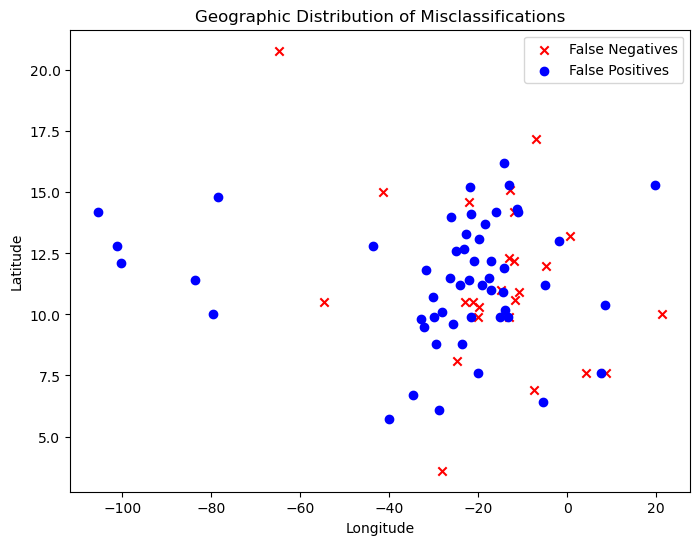

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


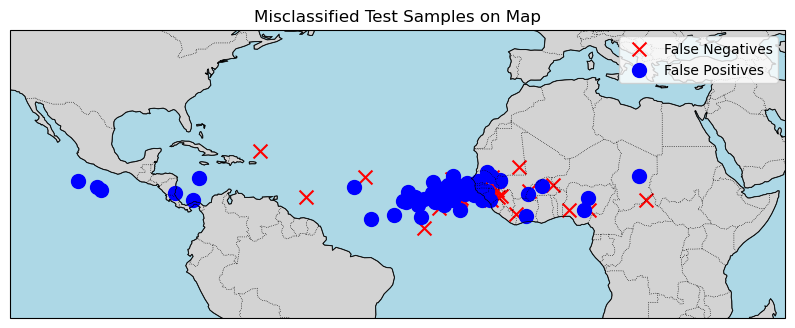

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

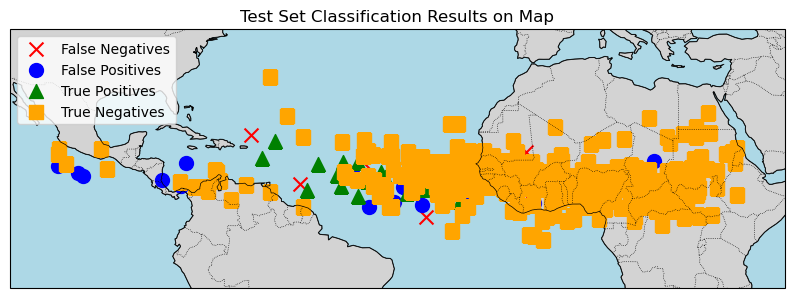

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2444
Unique latitudes: 241
Unique longitudes: 867


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

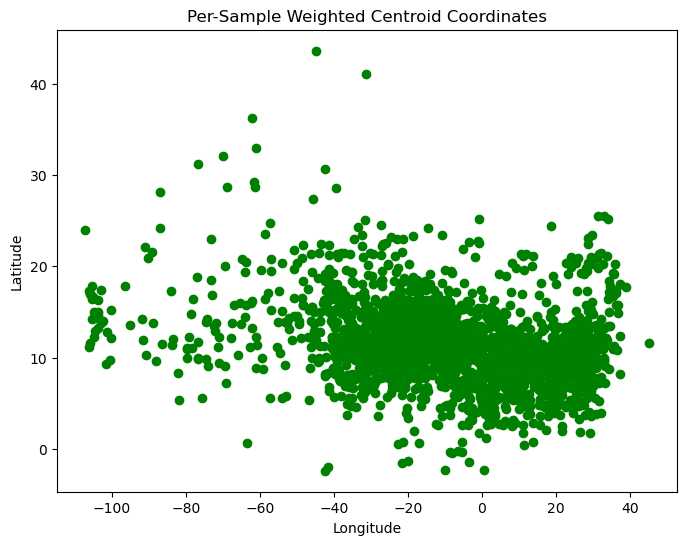

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.09744058549404144


Feature 0 - Increase in Loss: 0.0336046651005745


Feature 1 - Increase in Loss: -0.01007130742073059


Feature 2 - Increase in Loss: -0.0008366271853446905


Feature 3 - Increase in Loss: 0.04141068160533906


Feature 4 - Increase in Loss: 0.008087313175201422


Feature 5 - Increase in Loss: -0.00234382897615433


Feature 6 - Increase in Loss: 0.015647873282432556


Feature 7 - Increase in Loss: 0.02622349858283997


Feature 8 - Increase in Loss: 0.005776911973953247


Feature 9 - Increase in Loss: 0.0032477229833602905


Feature 10 - Increase in Loss: -0.01915769129991532


Feature 11 - Increase in Loss: -0.01054795235395431


Feature 12 - Increase in Loss: 0.02199306786060333


Feature 13 - Increase in Loss: 0.018994122743606567


Feature 14 - Increase in Loss: 0.007207697629928594


Feature 15 - Increase in Loss: 0.012094962596893313


Feature 16 - Increase in Loss: 0.001443375647068021


Feature 17 - Increase in Loss: 0.0010296255350112915
Permutation Importances (increase in loss) for all features: [ 0.03360467 -0.01007131 -0.00083663  0.04141068  0.00808731 -0.00234383
  0.01564787  0.0262235   0.00577691  0.00324772 -0.01915769 -0.01054795
  0.02199307  0.01899412  0.0072077   0.01209496  0.00144338  0.00102963]


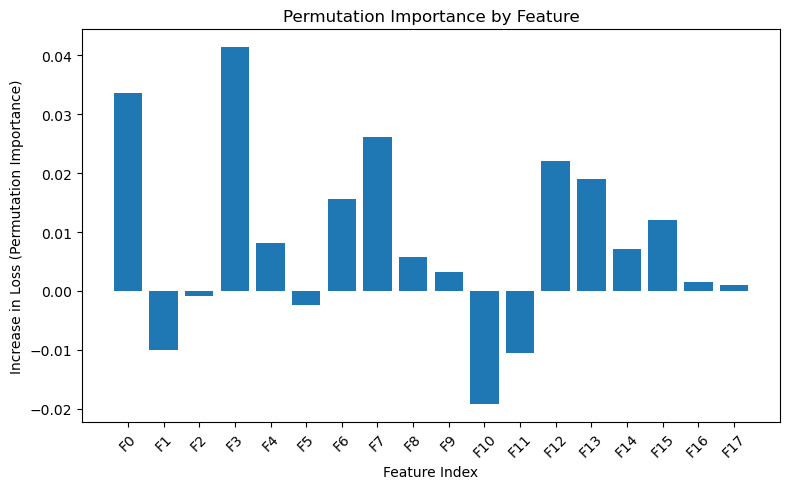

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


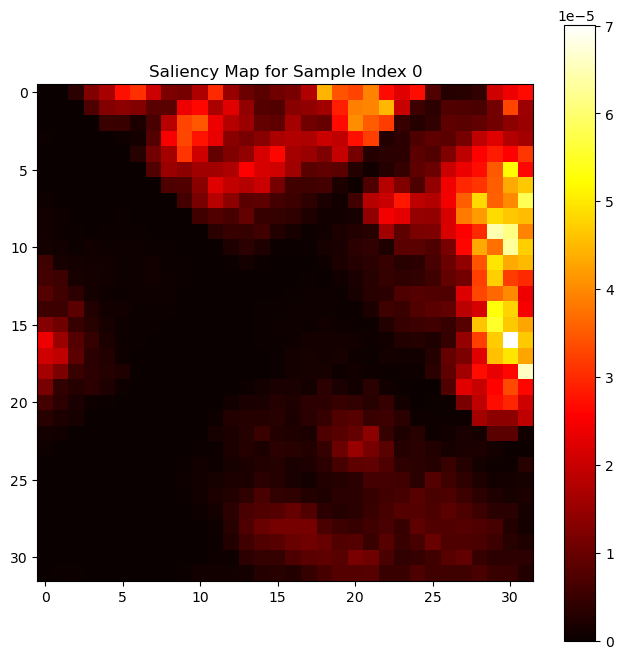

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



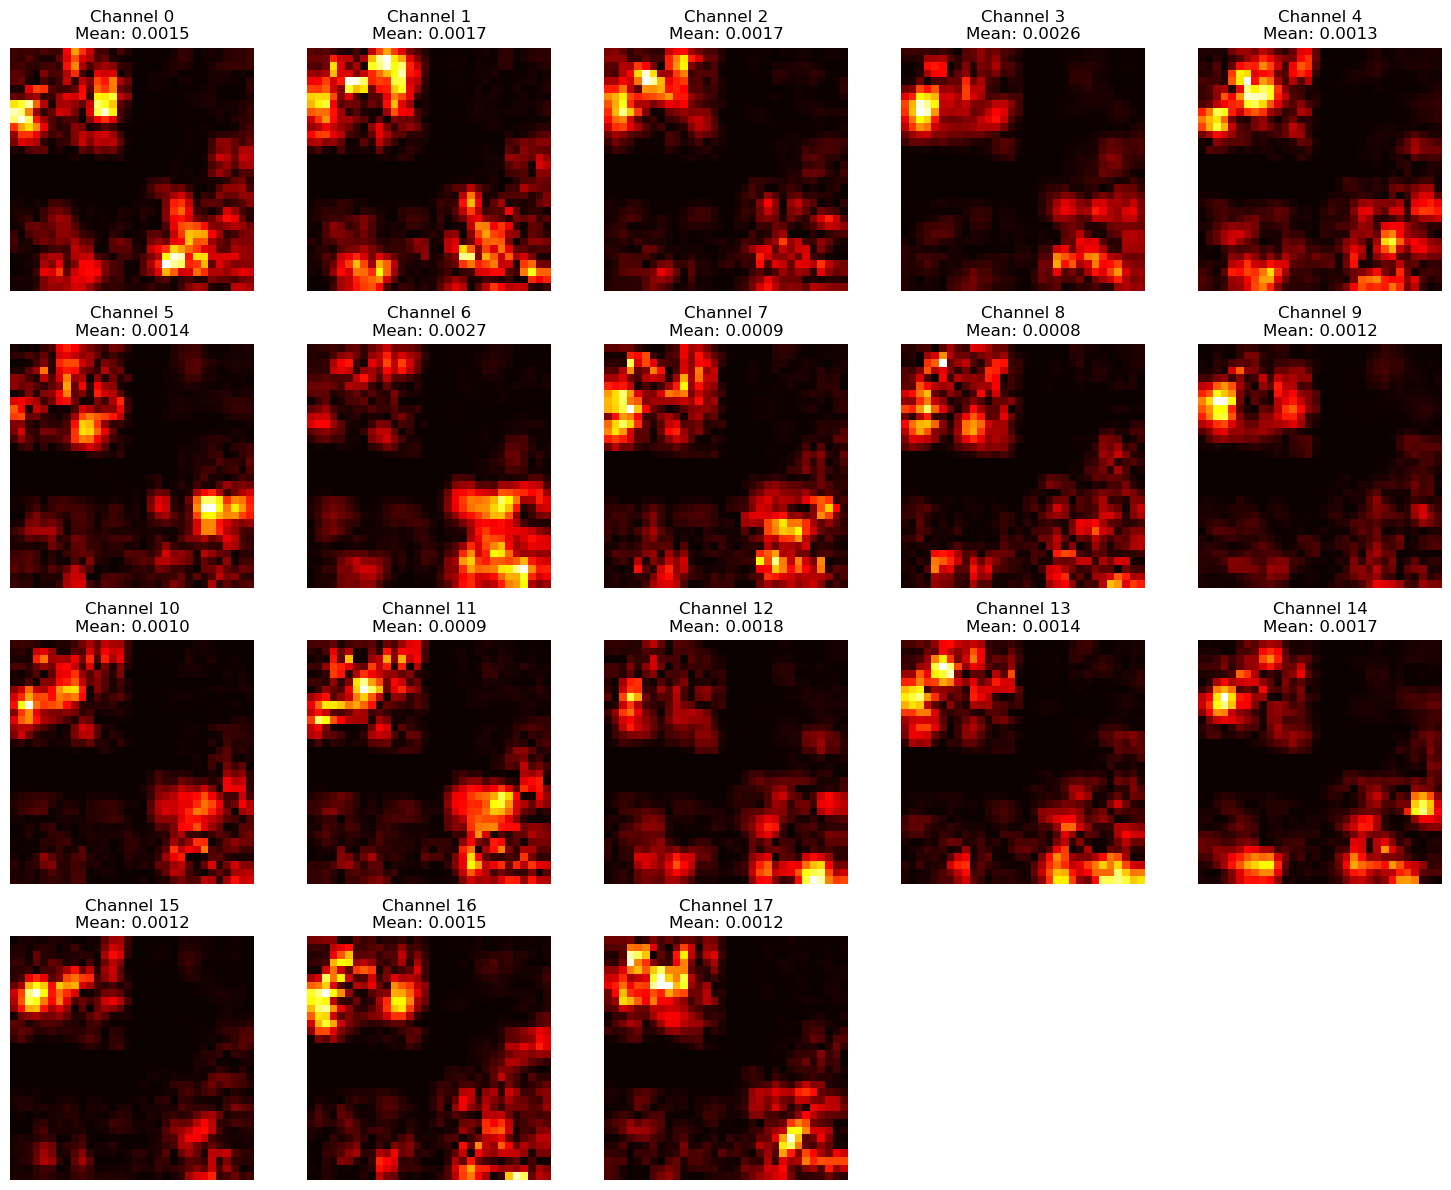

Channel importance (mean saliency per channel):
Channel 0: 0.0015
Channel 1: 0.0017
Channel 2: 0.0017
Channel 3: 0.0026
Channel 4: 0.0013
Channel 5: 0.0014
Channel 6: 0.0027
Channel 7: 0.0009
Channel 8: 0.0008
Channel 9: 0.0012
Channel 10: 0.0010
Channel 11: 0.0009
Channel 12: 0.0018
Channel 13: 0.0014
Channel 14: 0.0017
Channel 15: 0.0012
Channel 16: 0.0015
Channel 17: 0.0012


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


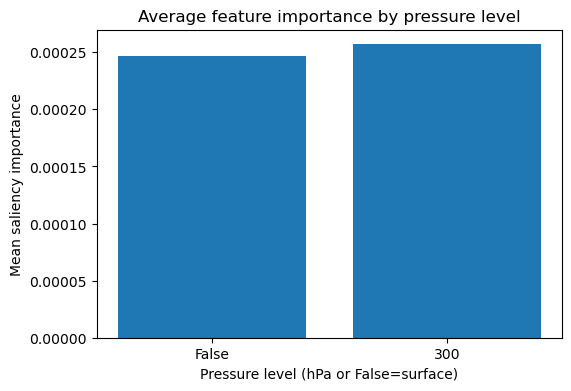

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.09744058549404144, 'compile_metrics': 0.3675767481327057}
    f1_score  val_f1_score
95  0.707547      0.413793
96  0.703088      0.407407
97  0.722892      0.400000
98  0.693780      0.375000
99  0.700240      0.400000


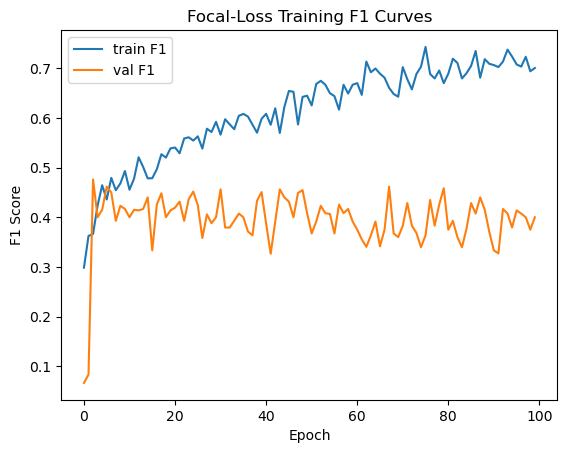

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Ensemble F1: 0.49019607843137253
